In previous posts, we've shown how to solve inverse problems to estimate the coefficients $q$ in a PDE from measured values of the solution $u$.
The computational problem that we aimed to solve was to minimize the functional

$$J(u, q) = E(u) + R(q)$$

where $E$ is a *misfit* functional and $R$ the *regularization* functional.
The solution was subject to a constraint

$$F(u, q) = 0$$

where $F$ is some partial differential equation.
Provided that $F$ is nice enough we can calculate derivatives of this functional using the adjoint method and then apply some sort of descent method.
Another important fact we'll use below is that the PDE has a solution operator $G(q)$.
We can then think of this in terms of a *reduced* objective functional, which in a gross abuse of notation we'll also write as $J$:

$$J(q) = E(G(q)) + R(q).$$

We can also give this problem a statistical interpretation.
The functional

$$\pi(q) = Z^{-1}e^{-J(q)}$$

is the Bayesian posterior density after having taken the measurements given the prior information that $R(q)$ averages to some value.
(The scalar $Z$ is a normalizing constant that we effectively cannot calculate.)
The *maximum a posteriori* or MAP estimator is the value of $q$ that maximizes the posterior density.
But maximizing the posterior density is the same as minimizing its negative logarithm.
This gets us right back to our original problem of minimizing the objective functional $J$.

Computing the most likely value of the parameters given the observations provides valuable information when the measurement errors are normally distributed and when the forward map $G$ is linear or only mildly nonlinear.
For many problems, however, the measurement errors are not normal or the forward map is not approximately linear.
The MAP estimator might still be useful, but it also might not be all that informative and it might not even exist.

In this post, I'll describe a procedure by which we can instead draw random samples from the posterior distribution.
Assuming that our sampling procedure is ergodic, we can approximate expectations of an arbitrary functional $f$ as a weighted sum:

$$\langle f\rangle = \int f(q)\,\mathrm{d}\pi(q) \approx \frac{1}{N}\sum_n f(q_n).$$

It doesn't make sense to seek the most likely value of the parameters when there are many local maxima of the posterior density or when the posterior is so flat near the maximum that it can't be located with reasonable accuracy.
In this circumstance, we're better off accepting the uncertainty for what it is and factoring it into what we do with our answer(s).

The classic approach for sampling from the posterior distribution is the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), a form of Markov-chain Monte Carlo that I'll assume you're familiar with.
One of the challenges in using this algorithm is that it scales poorly to dimensions much more than 10 or 12, and if you're doing PDE problems the dimensions are often in the thousands.
Here we'll try here an approach called the [Metropolis-adjusted Langevin](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm) algorithm or MALA.
The key innovation of MALA is to incorporate drift towards higher-probability regions of parameter space into the proposal density.
To be more specific, consider the [Itô diffusion](https://en.wikipedia.org/wiki/It%C3%B4_diffusion)

$$\dot q = \frac{1}{2}M^{-1}\mathrm{d}\log \pi(q) + M^{-\frac{1}{2}}\dot B,$$

where $M$ is some symmetric and positive-definite linear operator and $B$ is standard Brownian motion.
Under a few reasonable hypotheses on $\pi$, the limiting distribution of this process is $\pi$.
Of course we can't in general solve this SDE exactly, but we can discretize and I'll describe how below.

### Generating the exact data

We'll use the same input data and exact solution as the previous demo -- a random trigonometric polynomial for the boundary data and a spike in the conductivity to make it depart appreciably from the equivalent solution for homogeneous data.

In [1]:
import firedrake
Lx = firedrake.Constant(1.0)
Ly = firedrake.Constant(1.0)
nx, ny = 32, 32
mesh = firedrake.RectangleMesh(nx, ny, float(Lx), float(Ly), diagonal='crossed')
Q = firedrake.FunctionSpace(mesh, 'CG', 2)
V = firedrake.FunctionSpace(mesh, 'CG', 2)

/home/firedrake/firedrake/lib/python3.12/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
import numpy as np
from numpy import random, pi as π
from firedrake import sin, cos, Constant
x = firedrake.SpatialCoordinate(mesh)

def random_fourier_series(std_dev, num_modes, exponent, seed=1):
    rng = random.default_rng(seed=seed)
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    
    expr = Constant(0)
    for k in range(num_modes):
        for l in range(int(np.sqrt(num_modes**2 - k**2))):
            ϕ = π * (k * x[0] / Lx + l * x[1] / Ly)
            Z = 1 + (k**2 + l**2)**(exponent / 2)
            a_kl = Constant(A[k, l] / Z)
            b_kl = Constant(B[k, l] / Z)
            expr = expr + a_kl * sin(ϕ) + b_kl * cos(ϕ)
    
    return expr

In [3]:
from firedrake import Function
g = Function(V).interpolate(random_fourier_series(1.0, 6, 1, seed=1))

In [4]:
from firedrake import inner, min_value, max_value, Constant
a = -Constant(8.)
r = Constant(1/4)
y = Constant((0.4, 0.5))
expr = a * max_value(0, 1 - inner(x - y, x - y) / r**2)
q_true = Function(Q).interpolate(expr)

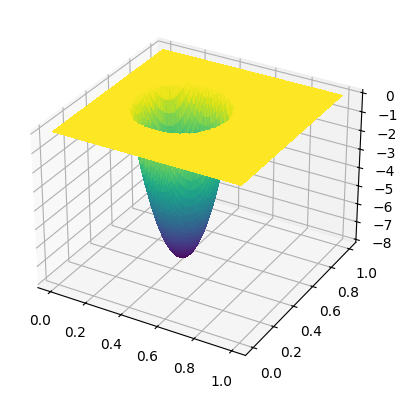

In [5]:
firedrake.trisurf(q_true);

In [6]:
b = Constant(6.)
R = Constant(1/4)
η = Constant((0.7, 0.5))
expr = b * max_value(0, 1 - inner(x - η, x - η) / R**2)
f = Function(V).interpolate(expr)

In [7]:
from firedrake import exp, grad, dx, ds
k = Constant(1.)
h = Constant(10.)
u_true = firedrake.Function(V)
v = firedrake.TestFunction(V)
F = (
    (k * exp(q_true) * inner(grad(u_true), grad(v)) - f * v) * dx +
    h * (u_true - g) * v * ds
)

In [8]:
opts = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
firedrake.solve(F == 0, u_true, **opts)

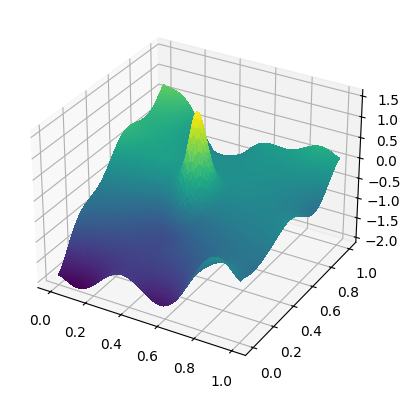

In [9]:
firedrake.trisurf(u_true);

### Generating the observational data

In the inverse problem tutorial, we only had to generate a single realization of spatial white noise.
Here we'll have to generate many realizations, so we'll wrap this up into a class that will store all the data structures we need.
We'll also abstract a bit over what the covariance operator is.
In the inverse problem tutorial we used the mass matrix as the covariance operator, and we will do that again here to generate the observational data.
As we'll see later, we'll also use this to generate the random noise used in the sampling algorithm, which will have non-trivial spatial correlations.
The important thing that the code below does is to apply the inverse of only one of the Cholesky factors instead of both.
We had to use the PETSc API to do this, since it isn't natively supported at the Firedrake level and arguably it shouldn't be.

In [10]:
from firedrake import assemble
from firedrake.petsc import PETSc
area = assemble(Constant(1) * dx(mesh))

class NoiseGenerator:
    def __init__(
        self,
        function_space,
        covariance=None,
        generator=random.default_rng()
    ):
        if covariance is None:
            ϕ = firedrake.TrialFunction(function_space)
            ψ = firedrake.TestFunction(function_space)
            covariance = inner(ϕ, ψ) * dx

        M = assemble(covariance, mat_type='aij').M.handle
        ksp = PETSc.KSP().create()
        ksp.setOperators(M)
        ksp.setUp()
        
        pc = ksp.pc
        pc.setType(pc.Type.CHOLESKY)
        pc.setFactorSolverType(PETSc.Mat.SolverType.PETSC)
        pc.setFactorSetUpSolverType()
        L = pc.getFactorMatrix()
        pc.setUp()
        
        self.rng = generator
        self.function_space = function_space
        self.preconditioner = pc
        self.cholesky_factor = L
        
        self.rhs = firedrake.Function(self.function_space)
        self.noise = firedrake.Function(self.function_space)

    def __call__(self):
        z, ξ = self.rhs, self.noise
        N = len(z.dat.data_ro[:])
        z.dat.data[:] = self.rng.standard_normal(N)

        L = self.cholesky_factor
        with z.dat.vec_ro as Z:
            with ξ.dat.vec as Ξ:
                L.solveBackward(Z, Ξ)
                Ξ *= np.sqrt(area / N)
                
        return ξ.copy(deepcopy=True)

In [11]:
white_noise_generator = NoiseGenerator(
    function_space=V,
    generator=random.default_rng(seed=1066)
)

In [12]:
û = u_true.dat.data_ro[:]
signal = û.max() - û.min()
signal_to_noise = 50
σ = firedrake.Constant(signal / signal_to_noise)

u_obs = u_true.copy(deepcopy=True)
ξ = white_noise_generator()
u_obs += σ * ξ

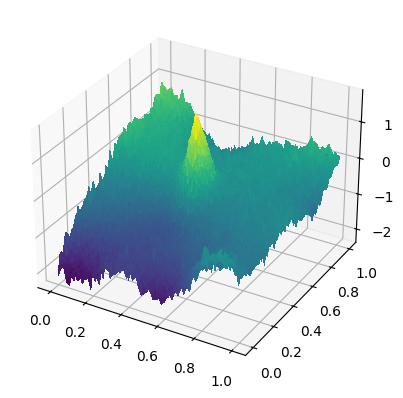

In [13]:
firedrake.trisurf(u_obs);

### Sampling

The sampling procedure that we'll use works by approximating paths of an Itô diffusion.
Many of the papers you'll come across on MALA or on diffusion processes assume a constant volatility matrix or inverse covariance of the added noise.
I've included a factor $M$, which we'll refer to as a *preconditioning* matrix.
The kinds of posterior distributions we encounter in data assimilation properties are often highly anisotropic in parameter space.
Making a good choice of preconditioning operator is a virtual necessity if for efficiently sampling from the posterior.

The theoretically optimal choice is to $M$ to be the second derivative or Hessian of the negative log-posterior.
Pyadjoint can apply a Hessian action for us, and we can then use the conjugate gradient method with an appropriate preconditioner to solve for the drift.
But to calculate the diffusion we need an inverse *square root* of the Hessian operator, and that will require us to call in to SLEPc.

The worst thing we could do is nothing because of the mesh-dependence problems that I described in the previous post on inverse problems.
The finite element mass matrix is the absolute least you can do without committing a criminal offense -- it represents the map from the dual of $L^2$ back to $L^2$ itself.

To do better than just the mass matrix, we can try to come up with a linear operator that will roughly recover the spectral asymptotics of the Hessian but which we can more easily express as a sparse matrix -- the Hessian will be dense.
Then we can just reuse the noise sampler class that I wrote above to compute the Cholesky factorization and generate random variables with this operator as its inverse covariance matrix.
Here we'll use an operator $M$ with the weak form

$$\langle M\phi, \psi\rangle = \int_\Omega\left(\phi\cdot\psi + \ell^2\nabla\phi\cdot\nabla\psi\right)dx$$

where $\ell$ is some length scale, which I'll take to be the diameter of the domain.
If the parameters $q$ live in the Sobolev space $H^1(\Omega)$, then $M$ is the canonical map from $H^1(\Omega)$ to its dual.
The length scale $\ell$ is there to make the units work out right.

In [14]:
ϕ, ψ = firedrake.TestFunction(Q), firedrake.TrialFunction(Q)
ℓ = firedrake.sqrt(Lx * Ly)
M = (ϕ * ψ + ℓ**2 * inner(grad(ϕ), grad(ψ))) * dx

diffusion_generator = NoiseGenerator(
    function_space=Q,
    covariance=M,
    generator=random.default_rng(1453),
)

We'll again start with the very blunt initial guess that the log-conductivity is 0 to initialize the problem.

In [15]:
q = firedrake.Function(Q)
u = firedrake.Function(V)
F = (
    (k * exp(q) * inner(grad(u), grad(v)) - f * v) * dx +
    h * (u - g) * v * ds
)
firedrake.solve(F == 0, u, **opts)

As I alluded to earlier, our proposal distribution for the MCMC algorithm is based on integrating the SDE

$$\dot q = -\frac{1}{2}M^{-1}\mathrm{d}J(q) + M^{-\frac{1}{2}}\dot B$$

where $B$ is standard Brownian motion.
The Euler-Maruyama scheme to integrate this equation for a single step of length $\delta t$ is

$$q^* = q - \frac{\delta t}{2}M^{-1}\mathrm{d}J(q) + \delta t^{\frac{1}{2}}M^{-\frac{1}{2}}\delta B.$$

But a naive integration of the SDE may have a different limiting distribution from the SDE itself, and it may even diverge.
To fix this problem, we'll use a Metropolis-style accept/reject step.
Having generated a proposal $q^*$, we'll accept it with probability

$$\alpha = \min\left\{1, \frac{\pi(q^*)\cdot\rho(q^*\to q)}{\pi(q)\cdot\rho(q\to q^*)}\right\}$$

where $\pi$ is the posterior density and $\rho$ is the transition density.
We don't know the normalizing factor in the posterior density, but by taking the ratio of the two this factor cancels:

$$\ln\frac{\pi(q^*)}{\pi(q)} = J(q) - J(q^*).$$

In the classic random walk Metropolis-Hastings algorithm, the ratio of the transition density from the current state to the proposed state usually cancels because the transition density is symmetric -- the chance of going from $q$ to $q^*$ is equal to the chance of going from $q^*$ back to $q$.
The algorithm that we're using here lacks this symmetry because of the gradient flow term in the proposal density.
The transition density can be written as:

$$\rho(q \to q^*) = Z^{-1}\exp\left\{-\frac{1}{2\tau}\left\|q^* - q + \frac{1}{2}\tau M^{-1}dJ(q)\right\|_M^2\right\}$$

Once again, the normalizing factor $Z$ is not directly computable but we're only interested in ratios:

$$2\tau\ln\frac{\rho(q^* \to q)}{\rho(q \to q^*)} = \left\|q^* - q + \frac{1}{2}\tau M^{-1}dJ(q)\right\|_M^2 - \left\|q - q^* + \frac{1}{2}\tau M^{-1}dJ(q^*)\right\|_M^2$$

This means that we need variables to store both the parameter guess, the PDE solution, and the derivative of the log-posterior at both the current state and the proposal at every stage of the iteration.

In [16]:
from firedrake.adjoint import Control, ReducedFunctional

α = Constant(1e-1)
drift_solver = firedrake.LinearSolver(assemble(M), **opts)
z = firedrake.Function(Q)
z_n = firedrake.Function(Q)
q_n = firedrake.Function(Q)
u_n = firedrake.Function(V)

firedrake.adjoint.continue_annotation()

J = 0.5 * (
    ((u - u_obs) / σ)**2 +
    α**2 * inner(grad(q), grad(q))
) * dx

q̂ = Control(q)
Ĵ = ReducedFunctional(assemble(J), q̂)
dĴ_dq = Ĵ.derivative(options={"riesz_representation": None})
drift_solver.solve(z, dĴ_dq)

I've tuned the step length for the Euler-Maruyama integration to get a good accept/reject ratio and (as we'll see later) to get a good decorrelation time.

In [17]:
τ = firedrake.Constant(5 / 6)

At the end of the loop I've also added a call to clear the tape for adjoint annotation.
If you don't clear the tape, the simulation can eat up more and more memory as it goes on.

In [18]:
from firedrake import sqrt, replace, energy_norm
import firedrake.adjoint
import tqdm

us = []
qs = []
Js = []

rng = random.default_rng(seed=42)

num_accepted = 0
num_rejected = 0

num_samples = 3000
progress = tqdm.trange(num_samples)
for sample in progress:
    δB = diffusion_generator()
    q_n = Function(Q).interpolate(q - 0.5 * τ * z + sqrt(τ) * δB)
    F_n = replace(F, {q: q_n, u: u_n})
    firedrake.solve(F_n == 0, u_n, **opts)
    
    J_n = replace(J, {q: q_n, u: u_n})
    q̂ = Control(q_n)
    Ĵ = ReducedFunctional(assemble(J_n), q̂)
    dĴ_dq = Ĵ.derivative(options={"riesz_representation": None})
    drift_solver.solve(z_n, dĴ_dq)

    δln_π = float(assemble(J - J_n))
    δq = Function(Q).interpolate(q_n - q + 0.5 * τ * z)
    δq_n = Function(Q).interpolate(q - q_n + 0.5 * τ * z_n)
    δln_ρ = float(
        assemble(energy_norm(M, δq) - energy_norm(M, δq_n)) / (2 * τ)
    )
    alpha = np.exp(δln_ρ + δln_π)
    roll = rng.uniform(0, 1)
    accept = roll > 1 - alpha
    num_accepted += accept
    num_rejected += not accept
    progress.set_description(
        f'Accepted, rejected: {num_accepted}, {num_rejected} |'
    )

    if accept:
        q.assign(q_n)
        u.assign(u_n)
        z.assign(z_n)

    qs.append(q.copy(deepcopy=True))
    us.append(u.copy(deepcopy=True))
    Js.append(float(assemble(J_n)))
    
    firedrake.adjoint.get_working_tape().clear_tape()

  0%|          | 0/3000 [00:00<?, ?it/s]

Accepted, rejected: 1, 0 |:   0%|          | 0/3000 [00:09<?, ?it/s]

Accepted, rejected: 1, 0 |:   0%|          | 1/3000 [00:09<7:47:38,  9.36s/it]

Accepted, rejected: 2, 0 |:   0%|          | 1/3000 [00:09<7:47:38,  9.36s/it]

Accepted, rejected: 2, 0 |:   0%|          | 2/3000 [00:09<3:21:50,  4.04s/it]

Accepted, rejected: 3, 0 |:   0%|          | 2/3000 [00:10<3:21:50,  4.04s/it]

Accepted, rejected: 3, 0 |:   0%|          | 3/3000 [00:10<2:04:57,  2.50s/it]

Accepted, rejected: 4, 0 |:   0%|          | 3/3000 [00:10<2:04:57,  2.50s/it]

Accepted, rejected: 4, 0 |:   0%|          | 4/3000 [00:10<1:21:15,  1.63s/it]

Accepted, rejected: 5, 0 |:   0%|          | 4/3000 [00:10<1:21:15,  1.63s/it]

Accepted, rejected: 5, 0 |:   0%|          | 5/3000 [00:10<57:27,  1.15s/it]  

Accepted, rejected: 6, 0 |:   0%|          | 5/3000 [00:11<57:27,  1.15s/it]

Accepted, rejected: 6, 0 |:   0%|          | 6/3000 [00:11<42:40,  1.17it/s]

Accepted, rejected: 7, 0 |:   0%|          | 6/3000 [00:11<42:40,  1.17it/s]

Accepted, rejected: 7, 0 |:   0%|          | 7/3000 [00:11<33:24,  1.49it/s]

Accepted, rejected: 8, 0 |:   0%|          | 7/3000 [00:11<33:24,  1.49it/s]

Accepted, rejected: 8, 0 |:   0%|          | 8/3000 [00:11<27:18,  1.83it/s]

Accepted, rejected: 9, 0 |:   0%|          | 8/3000 [00:12<27:18,  1.83it/s]

Accepted, rejected: 9, 0 |:   0%|          | 9/3000 [00:12<23:10,  2.15it/s]

Accepted, rejected: 10, 0 |:   0%|          | 9/3000 [00:12<23:10,  2.15it/s]

Accepted, rejected: 10, 0 |:   0%|          | 10/3000 [00:12<20:25,  2.44it/s]

Accepted, rejected: 11, 0 |:   0%|          | 10/3000 [00:12<20:25,  2.44it/s]

Accepted, rejected: 11, 0 |:   0%|          | 11/3000 [00:12<18:26,  2.70it/s]

Accepted, rejected: 12, 0 |:   0%|          | 11/3000 [00:12<18:26,  2.70it/s]

Accepted, rejected: 12, 0 |:   0%|          | 12/3000 [00:12<17:23,  2.86it/s]

Accepted, rejected: 13, 0 |:   0%|          | 12/3000 [00:13<17:23,  2.86it/s]

Accepted, rejected: 13, 0 |:   0%|          | 13/3000 [00:13<16:31,  3.01it/s]

Accepted, rejected: 14, 0 |:   0%|          | 13/3000 [00:13<16:31,  3.01it/s]

Accepted, rejected: 14, 0 |:   0%|          | 14/3000 [00:13<15:47,  3.15it/s]

Accepted, rejected: 15, 0 |:   0%|          | 14/3000 [00:13<15:47,  3.15it/s]

Accepted, rejected: 15, 0 |:   0%|          | 15/3000 [00:13<15:33,  3.20it/s]

Accepted, rejected: 16, 0 |:   0%|          | 15/3000 [00:14<15:33,  3.20it/s]

Accepted, rejected: 16, 0 |:   1%|          | 16/3000 [00:14<15:01,  3.31it/s]

Accepted, rejected: 17, 0 |:   1%|          | 16/3000 [00:14<15:01,  3.31it/s]

Accepted, rejected: 17, 0 |:   1%|          | 17/3000 [00:14<14:49,  3.35it/s]

Accepted, rejected: 18, 0 |:   1%|          | 17/3000 [00:14<14:49,  3.35it/s]

Accepted, rejected: 18, 0 |:   1%|          | 18/3000 [00:14<14:31,  3.42it/s]

Accepted, rejected: 19, 0 |:   1%|          | 18/3000 [00:14<14:31,  3.42it/s]

Accepted, rejected: 19, 0 |:   1%|          | 19/3000 [00:14<14:27,  3.44it/s]

Accepted, rejected: 20, 0 |:   1%|          | 19/3000 [00:15<14:27,  3.44it/s]

Accepted, rejected: 20, 0 |:   1%|          | 20/3000 [00:15<14:15,  3.48it/s]

Accepted, rejected: 21, 0 |:   1%|          | 20/3000 [00:15<14:15,  3.48it/s]

Accepted, rejected: 21, 0 |:   1%|          | 21/3000 [00:15<14:08,  3.51it/s]

Accepted, rejected: 22, 0 |:   1%|          | 21/3000 [00:15<14:08,  3.51it/s]

Accepted, rejected: 22, 0 |:   1%|          | 22/3000 [00:15<13:59,  3.55it/s]

Accepted, rejected: 23, 0 |:   1%|          | 22/3000 [00:16<13:59,  3.55it/s]

Accepted, rejected: 23, 0 |:   1%|          | 23/3000 [00:16<13:54,  3.57it/s]

Accepted, rejected: 24, 0 |:   1%|          | 23/3000 [00:16<13:54,  3.57it/s]

Accepted, rejected: 24, 0 |:   1%|          | 24/3000 [00:16<13:59,  3.54it/s]

Accepted, rejected: 25, 0 |:   1%|          | 24/3000 [00:16<13:59,  3.54it/s]

Accepted, rejected: 25, 0 |:   1%|          | 25/3000 [00:16<13:56,  3.56it/s]

Accepted, rejected: 26, 0 |:   1%|          | 25/3000 [00:16<13:56,  3.56it/s]

Accepted, rejected: 26, 0 |:   1%|          | 26/3000 [00:16<13:56,  3.55it/s]

Accepted, rejected: 27, 0 |:   1%|          | 26/3000 [00:17<13:56,  3.55it/s]

Accepted, rejected: 27, 0 |:   1%|          | 27/3000 [00:17<13:57,  3.55it/s]

Accepted, rejected: 28, 0 |:   1%|          | 27/3000 [00:17<13:57,  3.55it/s]

Accepted, rejected: 28, 0 |:   1%|          | 28/3000 [00:17<13:53,  3.57it/s]

Accepted, rejected: 29, 0 |:   1%|          | 28/3000 [00:17<13:53,  3.57it/s]

Accepted, rejected: 29, 0 |:   1%|          | 29/3000 [00:17<13:50,  3.58it/s]

Accepted, rejected: 30, 0 |:   1%|          | 29/3000 [00:18<13:50,  3.58it/s]

Accepted, rejected: 30, 0 |:   1%|          | 30/3000 [00:18<13:47,  3.59it/s]

Accepted, rejected: 31, 0 |:   1%|          | 30/3000 [00:18<13:47,  3.59it/s]

Accepted, rejected: 31, 0 |:   1%|          | 31/3000 [00:18<13:45,  3.60it/s]

Accepted, rejected: 32, 0 |:   1%|          | 31/3000 [00:18<13:45,  3.60it/s]

Accepted, rejected: 32, 0 |:   1%|          | 32/3000 [00:18<13:52,  3.56it/s]

Accepted, rejected: 33, 0 |:   1%|          | 32/3000 [00:18<13:52,  3.56it/s]

Accepted, rejected: 33, 0 |:   1%|          | 33/3000 [00:18<13:58,  3.54it/s]

Accepted, rejected: 34, 0 |:   1%|          | 33/3000 [00:19<13:58,  3.54it/s]

Accepted, rejected: 34, 0 |:   1%|          | 34/3000 [00:19<13:53,  3.56it/s]

Accepted, rejected: 35, 0 |:   1%|          | 34/3000 [00:19<13:53,  3.56it/s]

Accepted, rejected: 35, 0 |:   1%|          | 35/3000 [00:19<13:59,  3.53it/s]

Accepted, rejected: 36, 0 |:   1%|          | 35/3000 [00:19<13:59,  3.53it/s]

Accepted, rejected: 36, 0 |:   1%|          | 36/3000 [00:19<13:55,  3.55it/s]

Accepted, rejected: 37, 0 |:   1%|          | 36/3000 [00:20<13:55,  3.55it/s]

Accepted, rejected: 37, 0 |:   1%|          | 37/3000 [00:20<17:51,  2.77it/s]

Accepted, rejected: 38, 0 |:   1%|          | 37/3000 [00:20<17:51,  2.77it/s]

Accepted, rejected: 38, 0 |:   1%|▏         | 38/3000 [00:20<16:33,  2.98it/s]

Accepted, rejected: 39, 0 |:   1%|▏         | 38/3000 [00:20<16:33,  2.98it/s]

Accepted, rejected: 39, 0 |:   1%|▏         | 39/3000 [00:20<15:37,  3.16it/s]

Accepted, rejected: 40, 0 |:   1%|▏         | 39/3000 [00:21<15:37,  3.16it/s]

Accepted, rejected: 40, 0 |:   1%|▏         | 40/3000 [00:21<14:58,  3.30it/s]

Accepted, rejected: 41, 0 |:   1%|▏         | 40/3000 [00:21<14:58,  3.30it/s]

Accepted, rejected: 41, 0 |:   1%|▏         | 41/3000 [00:21<14:36,  3.38it/s]

Accepted, rejected: 42, 0 |:   1%|▏         | 41/3000 [00:21<14:36,  3.38it/s]

Accepted, rejected: 42, 0 |:   1%|▏         | 42/3000 [00:21<14:25,  3.42it/s]

Accepted, rejected: 43, 0 |:   1%|▏         | 42/3000 [00:21<14:25,  3.42it/s]

Accepted, rejected: 43, 0 |:   1%|▏         | 43/3000 [00:21<14:10,  3.48it/s]

Accepted, rejected: 44, 0 |:   1%|▏         | 43/3000 [00:22<14:10,  3.48it/s]

Accepted, rejected: 44, 0 |:   1%|▏         | 44/3000 [00:22<13:59,  3.52it/s]

Accepted, rejected: 45, 0 |:   1%|▏         | 44/3000 [00:22<13:59,  3.52it/s]

Accepted, rejected: 45, 0 |:   2%|▏         | 45/3000 [00:22<13:59,  3.52it/s]

Accepted, rejected: 46, 0 |:   2%|▏         | 45/3000 [00:22<13:59,  3.52it/s]

Accepted, rejected: 46, 0 |:   2%|▏         | 46/3000 [00:22<13:52,  3.55it/s]

Accepted, rejected: 47, 0 |:   2%|▏         | 46/3000 [00:23<13:52,  3.55it/s]

Accepted, rejected: 47, 0 |:   2%|▏         | 47/3000 [00:23<13:47,  3.57it/s]

Accepted, rejected: 48, 0 |:   2%|▏         | 47/3000 [00:23<13:47,  3.57it/s]

Accepted, rejected: 48, 0 |:   2%|▏         | 48/3000 [00:23<13:43,  3.58it/s]

Accepted, rejected: 49, 0 |:   2%|▏         | 48/3000 [00:23<13:43,  3.58it/s]

Accepted, rejected: 49, 0 |:   2%|▏         | 49/3000 [00:23<13:42,  3.59it/s]

Accepted, rejected: 50, 0 |:   2%|▏         | 49/3000 [00:23<13:42,  3.59it/s]

Accepted, rejected: 50, 0 |:   2%|▏         | 50/3000 [00:23<13:40,  3.60it/s]

Accepted, rejected: 51, 0 |:   2%|▏         | 50/3000 [00:24<13:40,  3.60it/s]

Accepted, rejected: 51, 0 |:   2%|▏         | 51/3000 [00:24<13:38,  3.60it/s]

Accepted, rejected: 52, 0 |:   2%|▏         | 51/3000 [00:24<13:38,  3.60it/s]

Accepted, rejected: 52, 0 |:   2%|▏         | 52/3000 [00:24<13:36,  3.61it/s]

Accepted, rejected: 53, 0 |:   2%|▏         | 52/3000 [00:24<13:36,  3.61it/s]

Accepted, rejected: 53, 0 |:   2%|▏         | 53/3000 [00:24<13:35,  3.61it/s]

Accepted, rejected: 54, 0 |:   2%|▏         | 53/3000 [00:24<13:35,  3.61it/s]

Accepted, rejected: 54, 0 |:   2%|▏         | 54/3000 [00:24<13:44,  3.57it/s]

Accepted, rejected: 55, 0 |:   2%|▏         | 54/3000 [00:25<13:44,  3.57it/s]

Accepted, rejected: 55, 0 |:   2%|▏         | 55/3000 [00:25<13:42,  3.58it/s]

Accepted, rejected: 56, 0 |:   2%|▏         | 55/3000 [00:25<13:42,  3.58it/s]

Accepted, rejected: 56, 0 |:   2%|▏         | 56/3000 [00:25<13:39,  3.59it/s]

Accepted, rejected: 57, 0 |:   2%|▏         | 56/3000 [00:25<13:39,  3.59it/s]

Accepted, rejected: 57, 0 |:   2%|▏         | 57/3000 [00:25<13:37,  3.60it/s]

Accepted, rejected: 58, 0 |:   2%|▏         | 57/3000 [00:26<13:37,  3.60it/s]

Accepted, rejected: 58, 0 |:   2%|▏         | 58/3000 [00:26<13:42,  3.58it/s]

Accepted, rejected: 59, 0 |:   2%|▏         | 58/3000 [00:26<13:42,  3.58it/s]

Accepted, rejected: 59, 0 |:   2%|▏         | 59/3000 [00:26<13:38,  3.59it/s]

Accepted, rejected: 60, 0 |:   2%|▏         | 59/3000 [00:26<13:38,  3.59it/s]

Accepted, rejected: 60, 0 |:   2%|▏         | 60/3000 [00:26<13:36,  3.60it/s]

Accepted, rejected: 61, 0 |:   2%|▏         | 60/3000 [00:26<13:36,  3.60it/s]

Accepted, rejected: 61, 0 |:   2%|▏         | 61/3000 [00:26<13:33,  3.61it/s]

Accepted, rejected: 62, 0 |:   2%|▏         | 61/3000 [00:27<13:33,  3.61it/s]

Accepted, rejected: 62, 0 |:   2%|▏         | 62/3000 [00:27<13:32,  3.62it/s]

Accepted, rejected: 63, 0 |:   2%|▏         | 62/3000 [00:27<13:32,  3.62it/s]

Accepted, rejected: 63, 0 |:   2%|▏         | 63/3000 [00:27<13:33,  3.61it/s]

Accepted, rejected: 64, 0 |:   2%|▏         | 63/3000 [00:27<13:33,  3.61it/s]

Accepted, rejected: 64, 0 |:   2%|▏         | 64/3000 [00:27<13:31,  3.62it/s]

Accepted, rejected: 65, 0 |:   2%|▏         | 64/3000 [00:28<13:31,  3.62it/s]

Accepted, rejected: 65, 0 |:   2%|▏         | 65/3000 [00:28<13:30,  3.62it/s]

Accepted, rejected: 66, 0 |:   2%|▏         | 65/3000 [00:28<13:30,  3.62it/s]

Accepted, rejected: 66, 0 |:   2%|▏         | 66/3000 [00:28<13:30,  3.62it/s]

Accepted, rejected: 67, 0 |:   2%|▏         | 66/3000 [00:28<13:30,  3.62it/s]

Accepted, rejected: 67, 0 |:   2%|▏         | 67/3000 [00:28<13:28,  3.63it/s]

Accepted, rejected: 68, 0 |:   2%|▏         | 67/3000 [00:28<13:28,  3.63it/s]

Accepted, rejected: 68, 0 |:   2%|▏         | 68/3000 [00:28<13:34,  3.60it/s]

Accepted, rejected: 69, 0 |:   2%|▏         | 68/3000 [00:29<13:34,  3.60it/s]

Accepted, rejected: 69, 0 |:   2%|▏         | 69/3000 [00:29<13:35,  3.59it/s]

Accepted, rejected: 70, 0 |:   2%|▏         | 69/3000 [00:29<13:35,  3.59it/s]

Accepted, rejected: 70, 0 |:   2%|▏         | 70/3000 [00:29<13:33,  3.60it/s]

Accepted, rejected: 71, 0 |:   2%|▏         | 70/3000 [00:29<13:33,  3.60it/s]

Accepted, rejected: 71, 0 |:   2%|▏         | 71/3000 [00:29<13:36,  3.59it/s]

Accepted, rejected: 72, 0 |:   2%|▏         | 71/3000 [00:29<13:36,  3.59it/s]

Accepted, rejected: 72, 0 |:   2%|▏         | 72/3000 [00:29<13:33,  3.60it/s]

Accepted, rejected: 73, 0 |:   2%|▏         | 72/3000 [00:30<13:33,  3.60it/s]

Accepted, rejected: 73, 0 |:   2%|▏         | 73/3000 [00:30<16:35,  2.94it/s]

Accepted, rejected: 74, 0 |:   2%|▏         | 73/3000 [00:30<16:35,  2.94it/s]

Accepted, rejected: 74, 0 |:   2%|▏         | 74/3000 [00:30<15:38,  3.12it/s]

Accepted, rejected: 75, 0 |:   2%|▏         | 74/3000 [00:31<15:38,  3.12it/s]

Accepted, rejected: 75, 0 |:   2%|▎         | 75/3000 [00:31<14:57,  3.26it/s]

Accepted, rejected: 76, 0 |:   2%|▎         | 75/3000 [00:31<14:57,  3.26it/s]

Accepted, rejected: 76, 0 |:   3%|▎         | 76/3000 [00:31<14:29,  3.36it/s]

Accepted, rejected: 77, 0 |:   3%|▎         | 76/3000 [00:31<14:29,  3.36it/s]

Accepted, rejected: 77, 0 |:   3%|▎         | 77/3000 [00:31<14:09,  3.44it/s]

Accepted, rejected: 78, 0 |:   3%|▎         | 77/3000 [00:31<14:09,  3.44it/s]

Accepted, rejected: 78, 0 |:   3%|▎         | 78/3000 [00:31<14:06,  3.45it/s]

Accepted, rejected: 79, 0 |:   3%|▎         | 78/3000 [00:32<14:06,  3.45it/s]

Accepted, rejected: 79, 0 |:   3%|▎         | 79/3000 [00:32<13:59,  3.48it/s]

Accepted, rejected: 80, 0 |:   3%|▎         | 79/3000 [00:32<13:59,  3.48it/s]

Accepted, rejected: 80, 0 |:   3%|▎         | 80/3000 [00:32<13:51,  3.51it/s]

Accepted, rejected: 81, 0 |:   3%|▎         | 80/3000 [00:32<13:51,  3.51it/s]

Accepted, rejected: 81, 0 |:   3%|▎         | 81/3000 [00:32<13:43,  3.54it/s]

Accepted, rejected: 82, 0 |:   3%|▎         | 81/3000 [00:32<13:43,  3.54it/s]

Accepted, rejected: 82, 0 |:   3%|▎         | 82/3000 [00:32<13:41,  3.55it/s]

Accepted, rejected: 83, 0 |:   3%|▎         | 82/3000 [00:33<13:41,  3.55it/s]

Accepted, rejected: 83, 0 |:   3%|▎         | 83/3000 [00:33<13:37,  3.57it/s]

Accepted, rejected: 84, 0 |:   3%|▎         | 83/3000 [00:33<13:37,  3.57it/s]

Accepted, rejected: 84, 0 |:   3%|▎         | 84/3000 [00:33<13:37,  3.57it/s]

Accepted, rejected: 85, 0 |:   3%|▎         | 84/3000 [00:33<13:37,  3.57it/s]

Accepted, rejected: 85, 0 |:   3%|▎         | 85/3000 [00:33<13:45,  3.53it/s]

Accepted, rejected: 86, 0 |:   3%|▎         | 85/3000 [00:34<13:45,  3.53it/s]

Accepted, rejected: 86, 0 |:   3%|▎         | 86/3000 [00:34<13:42,  3.54it/s]

Accepted, rejected: 87, 0 |:   3%|▎         | 86/3000 [00:34<13:42,  3.54it/s]

Accepted, rejected: 87, 0 |:   3%|▎         | 87/3000 [00:34<13:39,  3.55it/s]

Accepted, rejected: 88, 0 |:   3%|▎         | 87/3000 [00:34<13:39,  3.55it/s]

Accepted, rejected: 88, 0 |:   3%|▎         | 88/3000 [00:34<13:37,  3.56it/s]

Accepted, rejected: 89, 0 |:   3%|▎         | 88/3000 [00:34<13:37,  3.56it/s]

Accepted, rejected: 89, 0 |:   3%|▎         | 89/3000 [00:34<13:35,  3.57it/s]

Accepted, rejected: 90, 0 |:   3%|▎         | 89/3000 [00:35<13:35,  3.57it/s]

Accepted, rejected: 90, 0 |:   3%|▎         | 90/3000 [00:35<13:31,  3.59it/s]

Accepted, rejected: 91, 0 |:   3%|▎         | 90/3000 [00:35<13:31,  3.59it/s]

Accepted, rejected: 91, 0 |:   3%|▎         | 91/3000 [00:35<13:38,  3.56it/s]

Accepted, rejected: 92, 0 |:   3%|▎         | 91/3000 [00:35<13:38,  3.56it/s]

Accepted, rejected: 92, 0 |:   3%|▎         | 92/3000 [00:35<13:37,  3.56it/s]

Accepted, rejected: 93, 0 |:   3%|▎         | 92/3000 [00:36<13:37,  3.56it/s]

Accepted, rejected: 93, 0 |:   3%|▎         | 93/3000 [00:36<13:33,  3.57it/s]

Accepted, rejected: 94, 0 |:   3%|▎         | 93/3000 [00:36<13:33,  3.57it/s]

Accepted, rejected: 94, 0 |:   3%|▎         | 94/3000 [00:36<13:30,  3.58it/s]

Accepted, rejected: 95, 0 |:   3%|▎         | 94/3000 [00:36<13:30,  3.58it/s]

Accepted, rejected: 95, 0 |:   3%|▎         | 95/3000 [00:36<13:29,  3.59it/s]

Accepted, rejected: 96, 0 |:   3%|▎         | 95/3000 [00:36<13:29,  3.59it/s]

Accepted, rejected: 96, 0 |:   3%|▎         | 96/3000 [00:36<13:29,  3.59it/s]

Accepted, rejected: 97, 0 |:   3%|▎         | 96/3000 [00:37<13:29,  3.59it/s]

Accepted, rejected: 97, 0 |:   3%|▎         | 97/3000 [00:37<13:27,  3.59it/s]

Accepted, rejected: 98, 0 |:   3%|▎         | 97/3000 [00:37<13:27,  3.59it/s]

Accepted, rejected: 98, 0 |:   3%|▎         | 98/3000 [00:37<13:27,  3.59it/s]

Accepted, rejected: 99, 0 |:   3%|▎         | 98/3000 [00:37<13:27,  3.59it/s]

Accepted, rejected: 99, 0 |:   3%|▎         | 99/3000 [00:37<13:27,  3.59it/s]

Accepted, rejected: 100, 0 |:   3%|▎         | 99/3000 [00:37<13:27,  3.59it/s]

Accepted, rejected: 100, 0 |:   3%|▎         | 100/3000 [00:38<13:28,  3.59it/s]

Accepted, rejected: 101, 0 |:   3%|▎         | 100/3000 [00:38<13:28,  3.59it/s]

Accepted, rejected: 101, 0 |:   3%|▎         | 101/3000 [00:38<13:26,  3.59it/s]

Accepted, rejected: 102, 0 |:   3%|▎         | 101/3000 [00:38<13:26,  3.59it/s]

Accepted, rejected: 102, 0 |:   3%|▎         | 102/3000 [00:38<13:26,  3.59it/s]

Accepted, rejected: 103, 0 |:   3%|▎         | 102/3000 [00:38<13:26,  3.59it/s]

Accepted, rejected: 103, 0 |:   3%|▎         | 103/3000 [00:38<13:25,  3.59it/s]

Accepted, rejected: 104, 0 |:   3%|▎         | 103/3000 [00:39<13:25,  3.59it/s]

Accepted, rejected: 104, 0 |:   3%|▎         | 104/3000 [00:39<13:23,  3.60it/s]

Accepted, rejected: 105, 0 |:   3%|▎         | 104/3000 [00:39<13:23,  3.60it/s]

Accepted, rejected: 105, 0 |:   4%|▎         | 105/3000 [00:39<13:22,  3.61it/s]

Accepted, rejected: 106, 0 |:   4%|▎         | 105/3000 [00:39<13:22,  3.61it/s]

Accepted, rejected: 106, 0 |:   4%|▎         | 106/3000 [00:39<13:33,  3.56it/s]

Accepted, rejected: 107, 0 |:   4%|▎         | 106/3000 [00:39<13:33,  3.56it/s]

Accepted, rejected: 107, 0 |:   4%|▎         | 107/3000 [00:39<13:34,  3.55it/s]

Accepted, rejected: 108, 0 |:   4%|▎         | 107/3000 [00:40<13:34,  3.55it/s]

Accepted, rejected: 108, 0 |:   4%|▎         | 108/3000 [00:40<13:36,  3.54it/s]

Accepted, rejected: 109, 0 |:   4%|▎         | 108/3000 [00:40<13:36,  3.54it/s]

Accepted, rejected: 109, 0 |:   4%|▎         | 109/3000 [00:40<16:25,  2.93it/s]

Accepted, rejected: 110, 0 |:   4%|▎         | 109/3000 [00:40<16:25,  2.93it/s]

Accepted, rejected: 110, 0 |:   4%|▎         | 110/3000 [00:40<15:30,  3.10it/s]

Accepted, rejected: 111, 0 |:   4%|▎         | 110/3000 [00:41<15:30,  3.10it/s]

Accepted, rejected: 111, 0 |:   4%|▎         | 111/3000 [00:41<14:50,  3.25it/s]

Accepted, rejected: 112, 0 |:   4%|▎         | 111/3000 [00:41<14:50,  3.25it/s]

Accepted, rejected: 112, 0 |:   4%|▎         | 112/3000 [00:41<14:21,  3.35it/s]

Accepted, rejected: 113, 0 |:   4%|▎         | 112/3000 [00:41<14:21,  3.35it/s]

Accepted, rejected: 113, 0 |:   4%|▍         | 113/3000 [00:41<14:11,  3.39it/s]

Accepted, rejected: 114, 0 |:   4%|▍         | 113/3000 [00:42<14:11,  3.39it/s]

Accepted, rejected: 114, 0 |:   4%|▍         | 114/3000 [00:42<13:59,  3.44it/s]

Accepted, rejected: 115, 0 |:   4%|▍         | 114/3000 [00:42<13:59,  3.44it/s]

Accepted, rejected: 115, 0 |:   4%|▍         | 115/3000 [00:42<13:47,  3.49it/s]

Accepted, rejected: 116, 0 |:   4%|▍         | 115/3000 [00:42<13:47,  3.49it/s]

Accepted, rejected: 116, 0 |:   4%|▍         | 116/3000 [00:42<13:41,  3.51it/s]

Accepted, rejected: 117, 0 |:   4%|▍         | 116/3000 [00:42<13:41,  3.51it/s]

Accepted, rejected: 117, 0 |:   4%|▍         | 117/3000 [00:42<13:35,  3.54it/s]

Accepted, rejected: 118, 0 |:   4%|▍         | 117/3000 [00:43<13:35,  3.54it/s]

Accepted, rejected: 118, 0 |:   4%|▍         | 118/3000 [00:43<13:34,  3.54it/s]

Accepted, rejected: 119, 0 |:   4%|▍         | 118/3000 [00:43<13:34,  3.54it/s]

Accepted, rejected: 119, 0 |:   4%|▍         | 119/3000 [00:43<13:31,  3.55it/s]

Accepted, rejected: 120, 0 |:   4%|▍         | 119/3000 [00:43<13:31,  3.55it/s]

Accepted, rejected: 120, 0 |:   4%|▍         | 120/3000 [00:43<13:31,  3.55it/s]

Accepted, rejected: 121, 0 |:   4%|▍         | 120/3000 [00:44<13:31,  3.55it/s]

Accepted, rejected: 121, 0 |:   4%|▍         | 121/3000 [00:44<13:30,  3.55it/s]

Accepted, rejected: 122, 0 |:   4%|▍         | 121/3000 [00:44<13:30,  3.55it/s]

Accepted, rejected: 122, 0 |:   4%|▍         | 122/3000 [00:44<13:28,  3.56it/s]

Accepted, rejected: 123, 0 |:   4%|▍         | 122/3000 [00:44<13:28,  3.56it/s]

Accepted, rejected: 123, 0 |:   4%|▍         | 123/3000 [00:44<13:27,  3.56it/s]

Accepted, rejected: 124, 0 |:   4%|▍         | 123/3000 [00:44<13:27,  3.56it/s]

Accepted, rejected: 124, 0 |:   4%|▍         | 124/3000 [00:44<13:26,  3.56it/s]

Accepted, rejected: 125, 0 |:   4%|▍         | 124/3000 [00:45<13:26,  3.56it/s]

Accepted, rejected: 125, 0 |:   4%|▍         | 125/3000 [00:45<13:36,  3.52it/s]

Accepted, rejected: 126, 0 |:   4%|▍         | 125/3000 [00:45<13:36,  3.52it/s]

Accepted, rejected: 126, 0 |:   4%|▍         | 126/3000 [00:45<13:29,  3.55it/s]

Accepted, rejected: 127, 0 |:   4%|▍         | 126/3000 [00:45<13:29,  3.55it/s]

Accepted, rejected: 127, 0 |:   4%|▍         | 127/3000 [00:45<13:24,  3.57it/s]

Accepted, rejected: 128, 0 |:   4%|▍         | 127/3000 [00:46<13:24,  3.57it/s]

Accepted, rejected: 128, 0 |:   4%|▍         | 128/3000 [00:46<13:24,  3.57it/s]

Accepted, rejected: 129, 0 |:   4%|▍         | 128/3000 [00:46<13:24,  3.57it/s]

Accepted, rejected: 129, 0 |:   4%|▍         | 129/3000 [00:46<13:22,  3.58it/s]

Accepted, rejected: 130, 0 |:   4%|▍         | 129/3000 [00:46<13:22,  3.58it/s]

Accepted, rejected: 130, 0 |:   4%|▍         | 130/3000 [00:46<13:35,  3.52it/s]

Accepted, rejected: 131, 0 |:   4%|▍         | 130/3000 [00:46<13:35,  3.52it/s]

Accepted, rejected: 131, 0 |:   4%|▍         | 131/3000 [00:46<13:31,  3.54it/s]

Accepted, rejected: 132, 0 |:   4%|▍         | 131/3000 [00:47<13:31,  3.54it/s]

Accepted, rejected: 132, 0 |:   4%|▍         | 132/3000 [00:47<13:27,  3.55it/s]

Accepted, rejected: 133, 0 |:   4%|▍         | 132/3000 [00:47<13:27,  3.55it/s]

Accepted, rejected: 133, 0 |:   4%|▍         | 133/3000 [00:47<13:24,  3.57it/s]

Accepted, rejected: 134, 0 |:   4%|▍         | 133/3000 [00:47<13:24,  3.57it/s]

Accepted, rejected: 134, 0 |:   4%|▍         | 134/3000 [00:47<13:23,  3.57it/s]

Accepted, rejected: 135, 0 |:   4%|▍         | 134/3000 [00:48<13:23,  3.57it/s]

Accepted, rejected: 135, 0 |:   4%|▍         | 135/3000 [00:48<13:21,  3.57it/s]

Accepted, rejected: 136, 0 |:   4%|▍         | 135/3000 [00:48<13:21,  3.57it/s]

Accepted, rejected: 136, 0 |:   5%|▍         | 136/3000 [00:48<13:17,  3.59it/s]

Accepted, rejected: 137, 0 |:   5%|▍         | 136/3000 [00:48<13:17,  3.59it/s]

Accepted, rejected: 137, 0 |:   5%|▍         | 137/3000 [00:48<13:18,  3.59it/s]

Accepted, rejected: 138, 0 |:   5%|▍         | 137/3000 [00:48<13:18,  3.59it/s]

Accepted, rejected: 138, 0 |:   5%|▍         | 138/3000 [00:48<13:15,  3.60it/s]

Accepted, rejected: 139, 0 |:   5%|▍         | 138/3000 [00:49<13:15,  3.60it/s]

Accepted, rejected: 139, 0 |:   5%|▍         | 139/3000 [00:49<13:22,  3.56it/s]

Accepted, rejected: 140, 0 |:   5%|▍         | 139/3000 [00:49<13:22,  3.56it/s]

Accepted, rejected: 140, 0 |:   5%|▍         | 140/3000 [00:49<13:29,  3.53it/s]

Accepted, rejected: 141, 0 |:   5%|▍         | 140/3000 [00:49<13:29,  3.53it/s]

Accepted, rejected: 141, 0 |:   5%|▍         | 141/3000 [00:49<13:25,  3.55it/s]

Accepted, rejected: 142, 0 |:   5%|▍         | 141/3000 [00:49<13:25,  3.55it/s]

Accepted, rejected: 142, 0 |:   5%|▍         | 142/3000 [00:49<13:24,  3.55it/s]

Accepted, rejected: 143, 0 |:   5%|▍         | 142/3000 [00:50<13:24,  3.55it/s]

Accepted, rejected: 143, 0 |:   5%|▍         | 143/3000 [00:50<13:19,  3.57it/s]

Accepted, rejected: 144, 0 |:   5%|▍         | 143/3000 [00:50<13:19,  3.57it/s]

Accepted, rejected: 144, 0 |:   5%|▍         | 144/3000 [00:50<13:25,  3.54it/s]

Accepted, rejected: 145, 0 |:   5%|▍         | 144/3000 [00:51<13:25,  3.54it/s]

Accepted, rejected: 145, 0 |:   5%|▍         | 145/3000 [00:51<16:14,  2.93it/s]

Accepted, rejected: 146, 0 |:   5%|▍         | 145/3000 [00:51<16:14,  2.93it/s]

Accepted, rejected: 146, 0 |:   5%|▍         | 146/3000 [00:51<15:19,  3.10it/s]

Accepted, rejected: 147, 0 |:   5%|▍         | 146/3000 [00:51<15:19,  3.10it/s]

Accepted, rejected: 147, 0 |:   5%|▍         | 147/3000 [00:51<14:42,  3.23it/s]

Accepted, rejected: 148, 0 |:   5%|▍         | 147/3000 [00:51<14:42,  3.23it/s]

Accepted, rejected: 148, 0 |:   5%|▍         | 148/3000 [00:51<14:16,  3.33it/s]

Accepted, rejected: 149, 0 |:   5%|▍         | 148/3000 [00:52<14:16,  3.33it/s]

Accepted, rejected: 149, 0 |:   5%|▍         | 149/3000 [00:52<13:56,  3.41it/s]

Accepted, rejected: 150, 0 |:   5%|▍         | 149/3000 [00:52<13:56,  3.41it/s]

Accepted, rejected: 150, 0 |:   5%|▌         | 150/3000 [00:52<13:44,  3.46it/s]

Accepted, rejected: 151, 0 |:   5%|▌         | 150/3000 [00:52<13:44,  3.46it/s]

Accepted, rejected: 151, 0 |:   5%|▌         | 151/3000 [00:52<13:37,  3.49it/s]

Accepted, rejected: 152, 0 |:   5%|▌         | 151/3000 [00:52<13:37,  3.49it/s]

Accepted, rejected: 152, 0 |:   5%|▌         | 152/3000 [00:52<13:29,  3.52it/s]

Accepted, rejected: 153, 0 |:   5%|▌         | 152/3000 [00:53<13:29,  3.52it/s]

Accepted, rejected: 153, 0 |:   5%|▌         | 153/3000 [00:53<13:26,  3.53it/s]

Accepted, rejected: 154, 0 |:   5%|▌         | 153/3000 [00:53<13:26,  3.53it/s]

Accepted, rejected: 154, 0 |:   5%|▌         | 154/3000 [00:53<13:22,  3.55it/s]

Accepted, rejected: 155, 0 |:   5%|▌         | 154/3000 [00:53<13:22,  3.55it/s]

Accepted, rejected: 155, 0 |:   5%|▌         | 155/3000 [00:53<13:17,  3.57it/s]

Accepted, rejected: 156, 0 |:   5%|▌         | 155/3000 [00:54<13:17,  3.57it/s]

Accepted, rejected: 156, 0 |:   5%|▌         | 156/3000 [00:54<13:15,  3.57it/s]

Accepted, rejected: 157, 0 |:   5%|▌         | 156/3000 [00:54<13:15,  3.57it/s]

Accepted, rejected: 157, 0 |:   5%|▌         | 157/3000 [00:54<13:13,  3.58it/s]

Accepted, rejected: 158, 0 |:   5%|▌         | 157/3000 [00:54<13:13,  3.58it/s]

Accepted, rejected: 158, 0 |:   5%|▌         | 158/3000 [00:54<13:12,  3.59it/s]

Accepted, rejected: 159, 0 |:   5%|▌         | 158/3000 [00:54<13:12,  3.59it/s]

Accepted, rejected: 159, 0 |:   5%|▌         | 159/3000 [00:54<13:23,  3.53it/s]

Accepted, rejected: 160, 0 |:   5%|▌         | 159/3000 [00:55<13:23,  3.53it/s]

Accepted, rejected: 160, 0 |:   5%|▌         | 160/3000 [00:55<13:24,  3.53it/s]

Accepted, rejected: 161, 0 |:   5%|▌         | 160/3000 [00:55<13:24,  3.53it/s]

Accepted, rejected: 161, 0 |:   5%|▌         | 161/3000 [00:55<13:18,  3.56it/s]

Accepted, rejected: 162, 0 |:   5%|▌         | 161/3000 [00:55<13:18,  3.56it/s]

Accepted, rejected: 162, 0 |:   5%|▌         | 162/3000 [00:55<13:15,  3.57it/s]

Accepted, rejected: 163, 0 |:   5%|▌         | 162/3000 [00:56<13:15,  3.57it/s]

Accepted, rejected: 163, 0 |:   5%|▌         | 163/3000 [00:56<13:13,  3.57it/s]

Accepted, rejected: 164, 0 |:   5%|▌         | 163/3000 [00:56<13:13,  3.57it/s]

Accepted, rejected: 164, 0 |:   5%|▌         | 164/3000 [00:56<13:11,  3.58it/s]

Accepted, rejected: 165, 0 |:   5%|▌         | 164/3000 [00:56<13:11,  3.58it/s]

Accepted, rejected: 165, 0 |:   6%|▌         | 165/3000 [00:56<13:11,  3.58it/s]

Accepted, rejected: 166, 0 |:   6%|▌         | 165/3000 [00:56<13:11,  3.58it/s]

Accepted, rejected: 166, 0 |:   6%|▌         | 166/3000 [00:56<13:08,  3.59it/s]

Accepted, rejected: 167, 0 |:   6%|▌         | 166/3000 [00:57<13:08,  3.59it/s]

Accepted, rejected: 167, 0 |:   6%|▌         | 167/3000 [00:57<13:08,  3.59it/s]

Accepted, rejected: 168, 0 |:   6%|▌         | 167/3000 [00:57<13:08,  3.59it/s]

Accepted, rejected: 168, 0 |:   6%|▌         | 168/3000 [00:57<13:05,  3.60it/s]

Accepted, rejected: 169, 0 |:   6%|▌         | 168/3000 [00:57<13:05,  3.60it/s]

Accepted, rejected: 169, 0 |:   6%|▌         | 169/3000 [00:57<13:04,  3.61it/s]

Accepted, rejected: 170, 0 |:   6%|▌         | 169/3000 [00:57<13:04,  3.61it/s]

Accepted, rejected: 170, 0 |:   6%|▌         | 170/3000 [00:57<13:09,  3.59it/s]

Accepted, rejected: 171, 0 |:   6%|▌         | 170/3000 [00:58<13:09,  3.59it/s]

Accepted, rejected: 171, 0 |:   6%|▌         | 171/3000 [00:58<13:08,  3.59it/s]

Accepted, rejected: 172, 0 |:   6%|▌         | 171/3000 [00:58<13:08,  3.59it/s]

Accepted, rejected: 172, 0 |:   6%|▌         | 172/3000 [00:58<13:09,  3.58it/s]

Accepted, rejected: 173, 0 |:   6%|▌         | 172/3000 [00:58<13:09,  3.58it/s]

Accepted, rejected: 173, 0 |:   6%|▌         | 173/3000 [00:58<13:06,  3.59it/s]

Accepted, rejected: 174, 0 |:   6%|▌         | 173/3000 [00:59<13:06,  3.59it/s]

Accepted, rejected: 174, 0 |:   6%|▌         | 174/3000 [00:59<13:04,  3.60it/s]

Accepted, rejected: 175, 0 |:   6%|▌         | 174/3000 [00:59<13:04,  3.60it/s]

Accepted, rejected: 175, 0 |:   6%|▌         | 175/3000 [00:59<13:02,  3.61it/s]

Accepted, rejected: 176, 0 |:   6%|▌         | 175/3000 [00:59<13:02,  3.61it/s]

Accepted, rejected: 176, 0 |:   6%|▌         | 176/3000 [00:59<13:00,  3.62it/s]

Accepted, rejected: 177, 0 |:   6%|▌         | 176/3000 [00:59<13:00,  3.62it/s]

Accepted, rejected: 177, 0 |:   6%|▌         | 177/3000 [00:59<13:01,  3.61it/s]

Accepted, rejected: 178, 0 |:   6%|▌         | 177/3000 [01:00<13:01,  3.61it/s]

Accepted, rejected: 178, 0 |:   6%|▌         | 178/3000 [01:00<13:01,  3.61it/s]

Accepted, rejected: 179, 0 |:   6%|▌         | 178/3000 [01:00<13:01,  3.61it/s]

Accepted, rejected: 179, 0 |:   6%|▌         | 179/3000 [01:00<13:02,  3.61it/s]

Accepted, rejected: 180, 0 |:   6%|▌         | 179/3000 [01:00<13:02,  3.61it/s]

Accepted, rejected: 180, 0 |:   6%|▌         | 180/3000 [01:00<13:03,  3.60it/s]

Accepted, rejected: 181, 0 |:   6%|▌         | 180/3000 [01:01<13:03,  3.60it/s]

Accepted, rejected: 181, 0 |:   6%|▌         | 181/3000 [01:01<15:49,  2.97it/s]

Accepted, rejected: 182, 0 |:   6%|▌         | 181/3000 [01:01<15:49,  2.97it/s]

Accepted, rejected: 182, 0 |:   6%|▌         | 182/3000 [01:01<14:56,  3.15it/s]

Accepted, rejected: 183, 0 |:   6%|▌         | 182/3000 [01:01<14:56,  3.15it/s]

Accepted, rejected: 183, 0 |:   6%|▌         | 183/3000 [01:01<14:18,  3.28it/s]

Accepted, rejected: 184, 0 |:   6%|▌         | 183/3000 [01:02<14:18,  3.28it/s]

Accepted, rejected: 184, 0 |:   6%|▌         | 184/3000 [01:02<13:53,  3.38it/s]

Accepted, rejected: 185, 0 |:   6%|▌         | 184/3000 [01:02<13:53,  3.38it/s]

Accepted, rejected: 185, 0 |:   6%|▌         | 185/3000 [01:02<13:35,  3.45it/s]

Accepted, rejected: 186, 0 |:   6%|▌         | 185/3000 [01:02<13:35,  3.45it/s]

Accepted, rejected: 186, 0 |:   6%|▌         | 186/3000 [01:02<13:25,  3.49it/s]

Accepted, rejected: 187, 0 |:   6%|▌         | 186/3000 [01:02<13:25,  3.49it/s]

Accepted, rejected: 187, 0 |:   6%|▌         | 187/3000 [01:02<13:16,  3.53it/s]

Accepted, rejected: 188, 0 |:   6%|▌         | 187/3000 [01:03<13:16,  3.53it/s]

Accepted, rejected: 188, 0 |:   6%|▋         | 188/3000 [01:03<13:09,  3.56it/s]

Accepted, rejected: 189, 0 |:   6%|▋         | 188/3000 [01:03<13:09,  3.56it/s]

Accepted, rejected: 189, 0 |:   6%|▋         | 189/3000 [01:03<13:05,  3.58it/s]

Accepted, rejected: 190, 0 |:   6%|▋         | 189/3000 [01:03<13:05,  3.58it/s]

Accepted, rejected: 190, 0 |:   6%|▋         | 190/3000 [01:03<13:02,  3.59it/s]

Accepted, rejected: 191, 0 |:   6%|▋         | 190/3000 [01:03<13:02,  3.59it/s]

Accepted, rejected: 191, 0 |:   6%|▋         | 191/3000 [01:04<13:00,  3.60it/s]

Accepted, rejected: 192, 0 |:   6%|▋         | 191/3000 [01:04<13:00,  3.60it/s]

Accepted, rejected: 192, 0 |:   6%|▋         | 192/3000 [01:04<12:58,  3.61it/s]

Accepted, rejected: 193, 0 |:   6%|▋         | 192/3000 [01:04<12:58,  3.61it/s]

Accepted, rejected: 193, 0 |:   6%|▋         | 193/3000 [01:04<13:00,  3.60it/s]

Accepted, rejected: 194, 0 |:   6%|▋         | 193/3000 [01:04<13:00,  3.60it/s]

Accepted, rejected: 194, 0 |:   6%|▋         | 194/3000 [01:04<13:04,  3.58it/s]

Accepted, rejected: 195, 0 |:   6%|▋         | 194/3000 [01:05<13:04,  3.58it/s]

Accepted, rejected: 195, 0 |:   6%|▋         | 195/3000 [01:05<13:09,  3.56it/s]

Accepted, rejected: 196, 0 |:   6%|▋         | 195/3000 [01:05<13:09,  3.56it/s]

Accepted, rejected: 196, 0 |:   7%|▋         | 196/3000 [01:05<13:05,  3.57it/s]

Accepted, rejected: 197, 0 |:   7%|▋         | 196/3000 [01:05<13:05,  3.57it/s]

Accepted, rejected: 197, 0 |:   7%|▋         | 197/3000 [01:05<13:02,  3.58it/s]

Accepted, rejected: 198, 0 |:   7%|▋         | 197/3000 [01:05<13:02,  3.58it/s]

Accepted, rejected: 198, 0 |:   7%|▋         | 198/3000 [01:05<13:02,  3.58it/s]

Accepted, rejected: 199, 0 |:   7%|▋         | 198/3000 [01:06<13:02,  3.58it/s]

Accepted, rejected: 199, 0 |:   7%|▋         | 199/3000 [01:06<12:59,  3.59it/s]

Accepted, rejected: 200, 0 |:   7%|▋         | 199/3000 [01:06<12:59,  3.59it/s]

Accepted, rejected: 200, 0 |:   7%|▋         | 200/3000 [01:06<13:02,  3.58it/s]

Accepted, rejected: 201, 0 |:   7%|▋         | 200/3000 [01:06<13:02,  3.58it/s]

Accepted, rejected: 201, 0 |:   7%|▋         | 201/3000 [01:06<13:00,  3.59it/s]

Accepted, rejected: 202, 0 |:   7%|▋         | 201/3000 [01:07<13:00,  3.59it/s]

Accepted, rejected: 202, 0 |:   7%|▋         | 202/3000 [01:07<12:57,  3.60it/s]

Accepted, rejected: 203, 0 |:   7%|▋         | 202/3000 [01:07<12:57,  3.60it/s]

Accepted, rejected: 203, 0 |:   7%|▋         | 203/3000 [01:07<12:55,  3.61it/s]

Accepted, rejected: 204, 0 |:   7%|▋         | 203/3000 [01:07<12:55,  3.61it/s]

Accepted, rejected: 204, 0 |:   7%|▋         | 204/3000 [01:07<12:53,  3.61it/s]

Accepted, rejected: 205, 0 |:   7%|▋         | 204/3000 [01:07<12:53,  3.61it/s]

Accepted, rejected: 205, 0 |:   7%|▋         | 205/3000 [01:07<12:53,  3.61it/s]

Accepted, rejected: 206, 0 |:   7%|▋         | 205/3000 [01:08<12:53,  3.61it/s]

Accepted, rejected: 206, 0 |:   7%|▋         | 206/3000 [01:08<12:52,  3.62it/s]

Accepted, rejected: 207, 0 |:   7%|▋         | 206/3000 [01:08<12:52,  3.62it/s]

Accepted, rejected: 207, 0 |:   7%|▋         | 207/3000 [01:08<12:51,  3.62it/s]

Accepted, rejected: 208, 0 |:   7%|▋         | 207/3000 [01:08<12:51,  3.62it/s]

Accepted, rejected: 208, 0 |:   7%|▋         | 208/3000 [01:08<13:01,  3.57it/s]

Accepted, rejected: 209, 0 |:   7%|▋         | 208/3000 [01:09<13:01,  3.57it/s]

Accepted, rejected: 209, 0 |:   7%|▋         | 209/3000 [01:09<12:58,  3.59it/s]

Accepted, rejected: 210, 0 |:   7%|▋         | 209/3000 [01:09<12:58,  3.59it/s]

Accepted, rejected: 210, 0 |:   7%|▋         | 210/3000 [01:09<12:54,  3.60it/s]

Accepted, rejected: 211, 0 |:   7%|▋         | 210/3000 [01:09<12:54,  3.60it/s]

Accepted, rejected: 211, 0 |:   7%|▋         | 211/3000 [01:09<12:52,  3.61it/s]

Accepted, rejected: 212, 0 |:   7%|▋         | 211/3000 [01:09<12:52,  3.61it/s]

Accepted, rejected: 212, 0 |:   7%|▋         | 212/3000 [01:09<12:51,  3.61it/s]

Accepted, rejected: 213, 0 |:   7%|▋         | 212/3000 [01:10<12:51,  3.61it/s]

Accepted, rejected: 213, 0 |:   7%|▋         | 213/3000 [01:10<12:49,  3.62it/s]

Accepted, rejected: 214, 0 |:   7%|▋         | 213/3000 [01:10<12:49,  3.62it/s]

Accepted, rejected: 214, 0 |:   7%|▋         | 214/3000 [01:10<12:48,  3.62it/s]

Accepted, rejected: 215, 0 |:   7%|▋         | 214/3000 [01:10<12:48,  3.62it/s]

Accepted, rejected: 215, 0 |:   7%|▋         | 215/3000 [01:10<12:51,  3.61it/s]

Accepted, rejected: 216, 0 |:   7%|▋         | 215/3000 [01:10<12:51,  3.61it/s]

Accepted, rejected: 216, 0 |:   7%|▋         | 216/3000 [01:10<12:50,  3.61it/s]

Accepted, rejected: 217, 0 |:   7%|▋         | 216/3000 [01:11<12:50,  3.61it/s]

Accepted, rejected: 217, 0 |:   7%|▋         | 217/3000 [01:11<15:37,  2.97it/s]

Accepted, rejected: 218, 0 |:   7%|▋         | 217/3000 [01:11<15:37,  2.97it/s]

Accepted, rejected: 218, 0 |:   7%|▋         | 218/3000 [01:11<14:44,  3.15it/s]

Accepted, rejected: 219, 0 |:   7%|▋         | 218/3000 [01:11<14:44,  3.15it/s]

Accepted, rejected: 219, 0 |:   7%|▋         | 219/3000 [01:11<14:08,  3.28it/s]

Accepted, rejected: 220, 0 |:   7%|▋         | 219/3000 [01:12<14:08,  3.28it/s]

Accepted, rejected: 220, 0 |:   7%|▋         | 220/3000 [01:12<13:51,  3.34it/s]

Accepted, rejected: 221, 0 |:   7%|▋         | 220/3000 [01:12<13:51,  3.34it/s]

Accepted, rejected: 221, 0 |:   7%|▋         | 221/3000 [01:12<13:37,  3.40it/s]

Accepted, rejected: 222, 0 |:   7%|▋         | 221/3000 [01:12<13:37,  3.40it/s]

Accepted, rejected: 222, 0 |:   7%|▋         | 222/3000 [01:12<13:22,  3.46it/s]

Accepted, rejected: 223, 0 |:   7%|▋         | 222/3000 [01:13<13:22,  3.46it/s]

Accepted, rejected: 223, 0 |:   7%|▋         | 223/3000 [01:13<13:10,  3.51it/s]

Accepted, rejected: 224, 0 |:   7%|▋         | 223/3000 [01:13<13:10,  3.51it/s]

Accepted, rejected: 224, 0 |:   7%|▋         | 224/3000 [01:13<13:03,  3.54it/s]

Accepted, rejected: 225, 0 |:   7%|▋         | 224/3000 [01:13<13:03,  3.54it/s]

Accepted, rejected: 225, 0 |:   8%|▊         | 225/3000 [01:13<12:59,  3.56it/s]

Accepted, rejected: 226, 0 |:   8%|▊         | 225/3000 [01:13<12:59,  3.56it/s]

Accepted, rejected: 226, 0 |:   8%|▊         | 226/3000 [01:13<12:54,  3.58it/s]

Accepted, rejected: 227, 0 |:   8%|▊         | 226/3000 [01:14<12:54,  3.58it/s]

Accepted, rejected: 227, 0 |:   8%|▊         | 227/3000 [01:14<12:51,  3.60it/s]

Accepted, rejected: 228, 0 |:   8%|▊         | 227/3000 [01:14<12:51,  3.60it/s]

Accepted, rejected: 228, 0 |:   8%|▊         | 228/3000 [01:14<12:53,  3.58it/s]

Accepted, rejected: 229, 0 |:   8%|▊         | 228/3000 [01:14<12:53,  3.58it/s]

Accepted, rejected: 229, 0 |:   8%|▊         | 229/3000 [01:14<12:50,  3.60it/s]

Accepted, rejected: 230, 0 |:   8%|▊         | 229/3000 [01:15<12:50,  3.60it/s]

Accepted, rejected: 230, 0 |:   8%|▊         | 230/3000 [01:15<12:48,  3.61it/s]

Accepted, rejected: 231, 0 |:   8%|▊         | 230/3000 [01:15<12:48,  3.61it/s]

Accepted, rejected: 231, 0 |:   8%|▊         | 231/3000 [01:15<12:47,  3.61it/s]

Accepted, rejected: 232, 0 |:   8%|▊         | 231/3000 [01:15<12:47,  3.61it/s]

Accepted, rejected: 232, 0 |:   8%|▊         | 232/3000 [01:15<12:48,  3.60it/s]

Accepted, rejected: 233, 0 |:   8%|▊         | 232/3000 [01:15<12:48,  3.60it/s]

Accepted, rejected: 233, 0 |:   8%|▊         | 233/3000 [01:15<12:46,  3.61it/s]

Accepted, rejected: 234, 0 |:   8%|▊         | 233/3000 [01:16<12:46,  3.61it/s]

Accepted, rejected: 234, 0 |:   8%|▊         | 234/3000 [01:16<12:45,  3.62it/s]

Accepted, rejected: 235, 0 |:   8%|▊         | 234/3000 [01:16<12:45,  3.62it/s]

Accepted, rejected: 235, 0 |:   8%|▊         | 235/3000 [01:16<12:44,  3.62it/s]

Accepted, rejected: 236, 0 |:   8%|▊         | 235/3000 [01:16<12:44,  3.62it/s]

Accepted, rejected: 236, 0 |:   8%|▊         | 236/3000 [01:16<12:46,  3.61it/s]

Accepted, rejected: 237, 0 |:   8%|▊         | 236/3000 [01:16<12:46,  3.61it/s]

Accepted, rejected: 237, 0 |:   8%|▊         | 237/3000 [01:16<12:53,  3.57it/s]

Accepted, rejected: 238, 0 |:   8%|▊         | 237/3000 [01:17<12:53,  3.57it/s]

Accepted, rejected: 238, 0 |:   8%|▊         | 238/3000 [01:17<12:52,  3.58it/s]

Accepted, rejected: 239, 0 |:   8%|▊         | 238/3000 [01:17<12:52,  3.58it/s]

Accepted, rejected: 239, 0 |:   8%|▊         | 239/3000 [01:17<12:49,  3.59it/s]

Accepted, rejected: 239, 1 |:   8%|▊         | 239/3000 [01:17<12:49,  3.59it/s]

Accepted, rejected: 239, 1 |:   8%|▊         | 240/3000 [01:17<12:45,  3.61it/s]

Accepted, rejected: 240, 1 |:   8%|▊         | 240/3000 [01:18<12:45,  3.61it/s]

Accepted, rejected: 240, 1 |:   8%|▊         | 241/3000 [01:18<12:43,  3.61it/s]

Accepted, rejected: 241, 1 |:   8%|▊         | 241/3000 [01:18<12:43,  3.61it/s]

Accepted, rejected: 241, 1 |:   8%|▊         | 242/3000 [01:18<12:43,  3.61it/s]

Accepted, rejected: 242, 1 |:   8%|▊         | 242/3000 [01:18<12:43,  3.61it/s]

Accepted, rejected: 242, 1 |:   8%|▊         | 243/3000 [01:18<12:43,  3.61it/s]

Accepted, rejected: 243, 1 |:   8%|▊         | 243/3000 [01:18<12:43,  3.61it/s]

Accepted, rejected: 243, 1 |:   8%|▊         | 244/3000 [01:18<12:42,  3.61it/s]

Accepted, rejected: 244, 1 |:   8%|▊         | 244/3000 [01:19<12:42,  3.61it/s]

Accepted, rejected: 244, 1 |:   8%|▊         | 245/3000 [01:19<12:41,  3.62it/s]

Accepted, rejected: 245, 1 |:   8%|▊         | 245/3000 [01:19<12:41,  3.62it/s]

Accepted, rejected: 245, 1 |:   8%|▊         | 246/3000 [01:19<12:40,  3.62it/s]

Accepted, rejected: 246, 1 |:   8%|▊         | 246/3000 [01:19<12:40,  3.62it/s]

Accepted, rejected: 246, 1 |:   8%|▊         | 247/3000 [01:19<12:39,  3.62it/s]

Accepted, rejected: 247, 1 |:   8%|▊         | 247/3000 [01:20<12:39,  3.62it/s]

Accepted, rejected: 247, 1 |:   8%|▊         | 248/3000 [01:20<12:39,  3.62it/s]

Accepted, rejected: 248, 1 |:   8%|▊         | 248/3000 [01:20<12:39,  3.62it/s]

Accepted, rejected: 248, 1 |:   8%|▊         | 249/3000 [01:20<12:41,  3.61it/s]

Accepted, rejected: 249, 1 |:   8%|▊         | 249/3000 [01:20<12:41,  3.61it/s]

Accepted, rejected: 249, 1 |:   8%|▊         | 250/3000 [01:20<12:44,  3.60it/s]

Accepted, rejected: 250, 1 |:   8%|▊         | 250/3000 [01:20<12:44,  3.60it/s]

Accepted, rejected: 250, 1 |:   8%|▊         | 251/3000 [01:20<12:43,  3.60it/s]

Accepted, rejected: 251, 1 |:   8%|▊         | 251/3000 [01:21<12:43,  3.60it/s]

Accepted, rejected: 251, 1 |:   8%|▊         | 252/3000 [01:21<12:43,  3.60it/s]

Accepted, rejected: 252, 1 |:   8%|▊         | 252/3000 [01:21<12:43,  3.60it/s]

Accepted, rejected: 252, 1 |:   8%|▊         | 253/3000 [01:21<12:49,  3.57it/s]

Accepted, rejected: 253, 1 |:   8%|▊         | 253/3000 [01:21<12:49,  3.57it/s]

Accepted, rejected: 253, 1 |:   8%|▊         | 254/3000 [01:21<15:34,  2.94it/s]

Accepted, rejected: 254, 1 |:   8%|▊         | 254/3000 [01:22<15:34,  2.94it/s]

Accepted, rejected: 254, 1 |:   8%|▊         | 255/3000 [01:22<14:39,  3.12it/s]

Accepted, rejected: 255, 1 |:   8%|▊         | 255/3000 [01:22<14:39,  3.12it/s]

Accepted, rejected: 255, 1 |:   9%|▊         | 256/3000 [01:22<14:02,  3.26it/s]

Accepted, rejected: 256, 1 |:   9%|▊         | 256/3000 [01:22<14:02,  3.26it/s]

Accepted, rejected: 256, 1 |:   9%|▊         | 257/3000 [01:22<13:39,  3.35it/s]

Accepted, rejected: 257, 1 |:   9%|▊         | 257/3000 [01:22<13:39,  3.35it/s]

Accepted, rejected: 257, 1 |:   9%|▊         | 258/3000 [01:23<13:19,  3.43it/s]

Accepted, rejected: 257, 2 |:   9%|▊         | 258/3000 [01:23<13:19,  3.43it/s]

Accepted, rejected: 257, 2 |:   9%|▊         | 259/3000 [01:23<13:06,  3.49it/s]

Accepted, rejected: 258, 2 |:   9%|▊         | 259/3000 [01:23<13:06,  3.49it/s]

Accepted, rejected: 258, 2 |:   9%|▊         | 260/3000 [01:23<12:56,  3.53it/s]

Accepted, rejected: 259, 2 |:   9%|▊         | 260/3000 [01:23<12:56,  3.53it/s]

Accepted, rejected: 259, 2 |:   9%|▊         | 261/3000 [01:23<12:49,  3.56it/s]

Accepted, rejected: 260, 2 |:   9%|▊         | 261/3000 [01:24<12:49,  3.56it/s]

Accepted, rejected: 260, 2 |:   9%|▊         | 262/3000 [01:24<12:45,  3.58it/s]

Accepted, rejected: 261, 2 |:   9%|▊         | 262/3000 [01:24<12:45,  3.58it/s]

Accepted, rejected: 261, 2 |:   9%|▉         | 263/3000 [01:24<12:42,  3.59it/s]

Accepted, rejected: 261, 3 |:   9%|▉         | 263/3000 [01:24<12:42,  3.59it/s]

Accepted, rejected: 261, 3 |:   9%|▉         | 264/3000 [01:24<12:41,  3.59it/s]

Accepted, rejected: 262, 3 |:   9%|▉         | 264/3000 [01:24<12:41,  3.59it/s]

Accepted, rejected: 262, 3 |:   9%|▉         | 265/3000 [01:24<12:39,  3.60it/s]

Accepted, rejected: 263, 3 |:   9%|▉         | 265/3000 [01:25<12:39,  3.60it/s]

Accepted, rejected: 263, 3 |:   9%|▉         | 266/3000 [01:25<12:38,  3.60it/s]

Accepted, rejected: 264, 3 |:   9%|▉         | 266/3000 [01:25<12:38,  3.60it/s]

Accepted, rejected: 264, 3 |:   9%|▉         | 267/3000 [01:25<12:39,  3.60it/s]

Accepted, rejected: 265, 3 |:   9%|▉         | 267/3000 [01:25<12:39,  3.60it/s]

Accepted, rejected: 265, 3 |:   9%|▉         | 268/3000 [01:25<12:38,  3.60it/s]

Accepted, rejected: 265, 4 |:   9%|▉         | 268/3000 [01:26<12:38,  3.60it/s]

Accepted, rejected: 265, 4 |:   9%|▉         | 269/3000 [01:26<12:40,  3.59it/s]

Accepted, rejected: 265, 5 |:   9%|▉         | 269/3000 [01:26<12:40,  3.59it/s]

Accepted, rejected: 265, 5 |:   9%|▉         | 270/3000 [01:26<12:37,  3.60it/s]

Accepted, rejected: 265, 6 |:   9%|▉         | 270/3000 [01:26<12:37,  3.60it/s]

Accepted, rejected: 265, 6 |:   9%|▉         | 271/3000 [01:26<12:37,  3.60it/s]

Accepted, rejected: 265, 7 |:   9%|▉         | 271/3000 [01:26<12:37,  3.60it/s]

Accepted, rejected: 265, 7 |:   9%|▉         | 272/3000 [01:26<12:36,  3.60it/s]

Accepted, rejected: 265, 8 |:   9%|▉         | 272/3000 [01:27<12:36,  3.60it/s]

Accepted, rejected: 265, 8 |:   9%|▉         | 273/3000 [01:27<12:34,  3.61it/s]

Accepted, rejected: 266, 8 |:   9%|▉         | 273/3000 [01:27<12:34,  3.61it/s]

Accepted, rejected: 266, 8 |:   9%|▉         | 274/3000 [01:27<12:35,  3.61it/s]

Accepted, rejected: 267, 8 |:   9%|▉         | 274/3000 [01:27<12:35,  3.61it/s]

Accepted, rejected: 267, 8 |:   9%|▉         | 275/3000 [01:27<12:38,  3.59it/s]

Accepted, rejected: 268, 8 |:   9%|▉         | 275/3000 [01:27<12:38,  3.59it/s]

Accepted, rejected: 268, 8 |:   9%|▉         | 276/3000 [01:27<12:40,  3.58it/s]

Accepted, rejected: 269, 8 |:   9%|▉         | 276/3000 [01:28<12:40,  3.58it/s]

Accepted, rejected: 269, 8 |:   9%|▉         | 277/3000 [01:28<12:41,  3.58it/s]

Accepted, rejected: 270, 8 |:   9%|▉         | 277/3000 [01:28<12:41,  3.58it/s]

Accepted, rejected: 270, 8 |:   9%|▉         | 278/3000 [01:28<12:44,  3.56it/s]

Accepted, rejected: 271, 8 |:   9%|▉         | 278/3000 [01:28<12:44,  3.56it/s]

Accepted, rejected: 271, 8 |:   9%|▉         | 279/3000 [01:28<12:49,  3.54it/s]

Accepted, rejected: 272, 8 |:   9%|▉         | 279/3000 [01:29<12:49,  3.54it/s]

Accepted, rejected: 272, 8 |:   9%|▉         | 280/3000 [01:29<12:51,  3.53it/s]

Accepted, rejected: 273, 8 |:   9%|▉         | 280/3000 [01:29<12:51,  3.53it/s]

Accepted, rejected: 273, 8 |:   9%|▉         | 281/3000 [01:29<12:49,  3.53it/s]

Accepted, rejected: 273, 9 |:   9%|▉         | 281/3000 [01:29<12:49,  3.53it/s]

Accepted, rejected: 273, 9 |:   9%|▉         | 282/3000 [01:29<12:48,  3.53it/s]

Accepted, rejected: 274, 9 |:   9%|▉         | 282/3000 [01:29<12:48,  3.53it/s]

Accepted, rejected: 274, 9 |:   9%|▉         | 283/3000 [01:29<12:47,  3.54it/s]

Accepted, rejected: 275, 9 |:   9%|▉         | 283/3000 [01:30<12:47,  3.54it/s]

Accepted, rejected: 275, 9 |:   9%|▉         | 284/3000 [01:30<12:47,  3.54it/s]

Accepted, rejected: 276, 9 |:   9%|▉         | 284/3000 [01:30<12:47,  3.54it/s]

Accepted, rejected: 276, 9 |:  10%|▉         | 285/3000 [01:30<12:49,  3.53it/s]

Accepted, rejected: 277, 9 |:  10%|▉         | 285/3000 [01:30<12:49,  3.53it/s]

Accepted, rejected: 277, 9 |:  10%|▉         | 286/3000 [01:30<12:50,  3.52it/s]

Accepted, rejected: 277, 10 |:  10%|▉         | 286/3000 [01:31<12:50,  3.52it/s]

Accepted, rejected: 277, 10 |:  10%|▉         | 287/3000 [01:31<12:50,  3.52it/s]

Accepted, rejected: 278, 10 |:  10%|▉         | 287/3000 [01:31<12:50,  3.52it/s]

Accepted, rejected: 278, 10 |:  10%|▉         | 288/3000 [01:31<12:56,  3.49it/s]

Accepted, rejected: 279, 10 |:  10%|▉         | 288/3000 [01:31<12:56,  3.49it/s]

Accepted, rejected: 279, 10 |:  10%|▉         | 289/3000 [01:31<13:04,  3.46it/s]

Accepted, rejected: 279, 11 |:  10%|▉         | 289/3000 [01:32<13:04,  3.46it/s]

Accepted, rejected: 279, 11 |:  10%|▉         | 290/3000 [01:32<15:30,  2.91it/s]

Accepted, rejected: 280, 11 |:  10%|▉         | 290/3000 [01:32<15:30,  2.91it/s]

Accepted, rejected: 280, 11 |:  10%|▉         | 291/3000 [01:32<14:37,  3.09it/s]

Accepted, rejected: 281, 11 |:  10%|▉         | 291/3000 [01:32<14:37,  3.09it/s]

Accepted, rejected: 281, 11 |:  10%|▉         | 292/3000 [01:32<14:01,  3.22it/s]

Accepted, rejected: 282, 11 |:  10%|▉         | 292/3000 [01:33<14:01,  3.22it/s]

Accepted, rejected: 282, 11 |:  10%|▉         | 293/3000 [01:33<13:37,  3.31it/s]

Accepted, rejected: 283, 11 |:  10%|▉         | 293/3000 [01:33<13:37,  3.31it/s]

Accepted, rejected: 283, 11 |:  10%|▉         | 294/3000 [01:33<13:18,  3.39it/s]

Accepted, rejected: 284, 11 |:  10%|▉         | 294/3000 [01:33<13:18,  3.39it/s]

Accepted, rejected: 284, 11 |:  10%|▉         | 295/3000 [01:33<13:11,  3.42it/s]

Accepted, rejected: 285, 11 |:  10%|▉         | 295/3000 [01:33<13:11,  3.42it/s]

Accepted, rejected: 285, 11 |:  10%|▉         | 296/3000 [01:33<13:03,  3.45it/s]

Accepted, rejected: 286, 11 |:  10%|▉         | 296/3000 [01:34<13:03,  3.45it/s]

Accepted, rejected: 286, 11 |:  10%|▉         | 297/3000 [01:34<12:57,  3.48it/s]

Accepted, rejected: 287, 11 |:  10%|▉         | 297/3000 [01:34<12:57,  3.48it/s]

Accepted, rejected: 287, 11 |:  10%|▉         | 298/3000 [01:34<12:51,  3.50it/s]

Accepted, rejected: 288, 11 |:  10%|▉         | 298/3000 [01:34<12:51,  3.50it/s]

Accepted, rejected: 288, 11 |:  10%|▉         | 299/3000 [01:34<12:50,  3.51it/s]

Accepted, rejected: 289, 11 |:  10%|▉         | 299/3000 [01:34<12:50,  3.51it/s]

Accepted, rejected: 289, 11 |:  10%|█         | 300/3000 [01:34<12:48,  3.51it/s]

Accepted, rejected: 290, 11 |:  10%|█         | 300/3000 [01:35<12:48,  3.51it/s]

Accepted, rejected: 290, 11 |:  10%|█         | 301/3000 [01:35<12:46,  3.52it/s]

Accepted, rejected: 291, 11 |:  10%|█         | 301/3000 [01:35<12:46,  3.52it/s]

Accepted, rejected: 291, 11 |:  10%|█         | 302/3000 [01:35<12:41,  3.54it/s]

Accepted, rejected: 292, 11 |:  10%|█         | 302/3000 [01:35<12:41,  3.54it/s]

Accepted, rejected: 292, 11 |:  10%|█         | 303/3000 [01:35<12:45,  3.53it/s]

Accepted, rejected: 293, 11 |:  10%|█         | 303/3000 [01:36<12:45,  3.53it/s]

Accepted, rejected: 293, 11 |:  10%|█         | 304/3000 [01:36<12:41,  3.54it/s]

Accepted, rejected: 294, 11 |:  10%|█         | 304/3000 [01:36<12:41,  3.54it/s]

Accepted, rejected: 294, 11 |:  10%|█         | 305/3000 [01:36<12:36,  3.56it/s]

Accepted, rejected: 295, 11 |:  10%|█         | 305/3000 [01:36<12:36,  3.56it/s]

Accepted, rejected: 295, 11 |:  10%|█         | 306/3000 [01:36<12:35,  3.57it/s]

Accepted, rejected: 295, 12 |:  10%|█         | 306/3000 [01:36<12:35,  3.57it/s]

Accepted, rejected: 295, 12 |:  10%|█         | 307/3000 [01:36<12:41,  3.54it/s]

Accepted, rejected: 296, 12 |:  10%|█         | 307/3000 [01:37<12:41,  3.54it/s]

Accepted, rejected: 296, 12 |:  10%|█         | 308/3000 [01:37<12:35,  3.56it/s]

Accepted, rejected: 297, 12 |:  10%|█         | 308/3000 [01:37<12:35,  3.56it/s]

Accepted, rejected: 297, 12 |:  10%|█         | 309/3000 [01:37<12:32,  3.58it/s]

Accepted, rejected: 297, 13 |:  10%|█         | 309/3000 [01:37<12:32,  3.58it/s]

Accepted, rejected: 297, 13 |:  10%|█         | 310/3000 [01:37<12:28,  3.59it/s]

Accepted, rejected: 298, 13 |:  10%|█         | 310/3000 [01:38<12:28,  3.59it/s]

Accepted, rejected: 298, 13 |:  10%|█         | 311/3000 [01:38<12:26,  3.60it/s]

Accepted, rejected: 299, 13 |:  10%|█         | 311/3000 [01:38<12:26,  3.60it/s]

Accepted, rejected: 299, 13 |:  10%|█         | 312/3000 [01:38<12:24,  3.61it/s]

Accepted, rejected: 299, 14 |:  10%|█         | 312/3000 [01:38<12:24,  3.61it/s]

Accepted, rejected: 299, 14 |:  10%|█         | 313/3000 [01:38<12:26,  3.60it/s]

Accepted, rejected: 299, 15 |:  10%|█         | 313/3000 [01:38<12:26,  3.60it/s]

Accepted, rejected: 299, 15 |:  10%|█         | 314/3000 [01:38<12:35,  3.55it/s]

Accepted, rejected: 299, 16 |:  10%|█         | 314/3000 [01:39<12:35,  3.55it/s]

Accepted, rejected: 299, 16 |:  10%|█         | 315/3000 [01:39<12:32,  3.57it/s]

Accepted, rejected: 299, 17 |:  10%|█         | 315/3000 [01:39<12:32,  3.57it/s]

Accepted, rejected: 299, 17 |:  11%|█         | 316/3000 [01:39<12:30,  3.58it/s]

Accepted, rejected: 299, 18 |:  11%|█         | 316/3000 [01:39<12:30,  3.58it/s]

Accepted, rejected: 299, 18 |:  11%|█         | 317/3000 [01:39<12:28,  3.58it/s]

Accepted, rejected: 300, 18 |:  11%|█         | 317/3000 [01:40<12:28,  3.58it/s]

Accepted, rejected: 300, 18 |:  11%|█         | 318/3000 [01:40<12:26,  3.59it/s]

Accepted, rejected: 301, 18 |:  11%|█         | 318/3000 [01:40<12:26,  3.59it/s]

Accepted, rejected: 301, 18 |:  11%|█         | 319/3000 [01:40<12:24,  3.60it/s]

Accepted, rejected: 302, 18 |:  11%|█         | 319/3000 [01:40<12:24,  3.60it/s]

Accepted, rejected: 302, 18 |:  11%|█         | 320/3000 [01:40<12:30,  3.57it/s]

Accepted, rejected: 303, 18 |:  11%|█         | 320/3000 [01:40<12:30,  3.57it/s]

Accepted, rejected: 303, 18 |:  11%|█         | 321/3000 [01:40<12:28,  3.58it/s]

Accepted, rejected: 304, 18 |:  11%|█         | 321/3000 [01:41<12:28,  3.58it/s]

Accepted, rejected: 304, 18 |:  11%|█         | 322/3000 [01:41<12:25,  3.59it/s]

Accepted, rejected: 305, 18 |:  11%|█         | 322/3000 [01:41<12:25,  3.59it/s]

Accepted, rejected: 305, 18 |:  11%|█         | 323/3000 [01:41<12:23,  3.60it/s]

Accepted, rejected: 306, 18 |:  11%|█         | 323/3000 [01:41<12:23,  3.60it/s]

Accepted, rejected: 306, 18 |:  11%|█         | 324/3000 [01:41<12:22,  3.60it/s]

Accepted, rejected: 307, 18 |:  11%|█         | 324/3000 [01:41<12:22,  3.60it/s]

Accepted, rejected: 307, 18 |:  11%|█         | 325/3000 [01:41<12:25,  3.59it/s]

Accepted, rejected: 308, 18 |:  11%|█         | 325/3000 [01:42<12:25,  3.59it/s]

Accepted, rejected: 308, 18 |:  11%|█         | 326/3000 [01:42<12:32,  3.56it/s]

Accepted, rejected: 309, 18 |:  11%|█         | 326/3000 [01:42<12:32,  3.56it/s]

Accepted, rejected: 309, 18 |:  11%|█         | 327/3000 [01:42<15:01,  2.97it/s]

Accepted, rejected: 310, 18 |:  11%|█         | 327/3000 [01:42<15:01,  2.97it/s]

Accepted, rejected: 310, 18 |:  11%|█         | 328/3000 [01:43<14:10,  3.14it/s]

Accepted, rejected: 311, 18 |:  11%|█         | 328/3000 [01:43<14:10,  3.14it/s]

Accepted, rejected: 311, 18 |:  11%|█         | 329/3000 [01:43<13:34,  3.28it/s]

Accepted, rejected: 312, 18 |:  11%|█         | 329/3000 [01:43<13:34,  3.28it/s]

Accepted, rejected: 312, 18 |:  11%|█         | 330/3000 [01:43<13:09,  3.38it/s]

Accepted, rejected: 313, 18 |:  11%|█         | 330/3000 [01:43<13:09,  3.38it/s]

Accepted, rejected: 313, 18 |:  11%|█         | 331/3000 [01:43<12:53,  3.45it/s]

Accepted, rejected: 313, 19 |:  11%|█         | 331/3000 [01:44<12:53,  3.45it/s]

Accepted, rejected: 313, 19 |:  11%|█         | 332/3000 [01:44<12:40,  3.51it/s]

Accepted, rejected: 314, 19 |:  11%|█         | 332/3000 [01:44<12:40,  3.51it/s]

Accepted, rejected: 314, 19 |:  11%|█         | 333/3000 [01:44<12:33,  3.54it/s]

Accepted, rejected: 315, 19 |:  11%|█         | 333/3000 [01:44<12:33,  3.54it/s]

Accepted, rejected: 315, 19 |:  11%|█         | 334/3000 [01:44<12:41,  3.50it/s]

Accepted, rejected: 315, 20 |:  11%|█         | 334/3000 [01:44<12:41,  3.50it/s]

Accepted, rejected: 315, 20 |:  11%|█         | 335/3000 [01:44<12:36,  3.52it/s]

Accepted, rejected: 316, 20 |:  11%|█         | 335/3000 [01:45<12:36,  3.52it/s]

Accepted, rejected: 316, 20 |:  11%|█         | 336/3000 [01:45<12:29,  3.55it/s]

Accepted, rejected: 316, 21 |:  11%|█         | 336/3000 [01:45<12:29,  3.55it/s]

Accepted, rejected: 316, 21 |:  11%|█         | 337/3000 [01:45<12:24,  3.58it/s]

Accepted, rejected: 317, 21 |:  11%|█         | 337/3000 [01:45<12:24,  3.58it/s]

Accepted, rejected: 317, 21 |:  11%|█▏        | 338/3000 [01:45<12:22,  3.58it/s]

Accepted, rejected: 317, 22 |:  11%|█▏        | 338/3000 [01:46<12:22,  3.58it/s]

Accepted, rejected: 317, 22 |:  11%|█▏        | 339/3000 [01:46<12:19,  3.60it/s]

Accepted, rejected: 318, 22 |:  11%|█▏        | 339/3000 [01:46<12:19,  3.60it/s]

Accepted, rejected: 318, 22 |:  11%|█▏        | 340/3000 [01:46<12:17,  3.61it/s]

Accepted, rejected: 319, 22 |:  11%|█▏        | 340/3000 [01:46<12:17,  3.61it/s]

Accepted, rejected: 319, 22 |:  11%|█▏        | 341/3000 [01:46<12:19,  3.59it/s]

Accepted, rejected: 320, 22 |:  11%|█▏        | 341/3000 [01:46<12:19,  3.59it/s]

Accepted, rejected: 320, 22 |:  11%|█▏        | 342/3000 [01:46<12:18,  3.60it/s]

Accepted, rejected: 321, 22 |:  11%|█▏        | 342/3000 [01:47<12:18,  3.60it/s]

Accepted, rejected: 321, 22 |:  11%|█▏        | 343/3000 [01:47<12:16,  3.61it/s]

Accepted, rejected: 322, 22 |:  11%|█▏        | 343/3000 [01:47<12:16,  3.61it/s]

Accepted, rejected: 322, 22 |:  11%|█▏        | 344/3000 [01:47<12:15,  3.61it/s]

Accepted, rejected: 323, 22 |:  11%|█▏        | 344/3000 [01:47<12:15,  3.61it/s]

Accepted, rejected: 323, 22 |:  12%|█▏        | 345/3000 [01:47<12:13,  3.62it/s]

Accepted, rejected: 324, 22 |:  12%|█▏        | 345/3000 [01:47<12:13,  3.62it/s]

Accepted, rejected: 324, 22 |:  12%|█▏        | 346/3000 [01:47<12:12,  3.62it/s]

Accepted, rejected: 325, 22 |:  12%|█▏        | 346/3000 [01:48<12:12,  3.62it/s]

Accepted, rejected: 325, 22 |:  12%|█▏        | 347/3000 [01:48<12:11,  3.62it/s]

Accepted, rejected: 325, 23 |:  12%|█▏        | 347/3000 [01:48<12:11,  3.62it/s]

Accepted, rejected: 325, 23 |:  12%|█▏        | 348/3000 [01:48<12:14,  3.61it/s]

Accepted, rejected: 326, 23 |:  12%|█▏        | 348/3000 [01:48<12:14,  3.61it/s]

Accepted, rejected: 326, 23 |:  12%|█▏        | 349/3000 [01:48<12:23,  3.57it/s]

Accepted, rejected: 327, 23 |:  12%|█▏        | 349/3000 [01:49<12:23,  3.57it/s]

Accepted, rejected: 327, 23 |:  12%|█▏        | 350/3000 [01:49<12:21,  3.57it/s]

Accepted, rejected: 328, 23 |:  12%|█▏        | 350/3000 [01:49<12:21,  3.57it/s]

Accepted, rejected: 328, 23 |:  12%|█▏        | 351/3000 [01:49<12:18,  3.59it/s]

Accepted, rejected: 328, 24 |:  12%|█▏        | 351/3000 [01:49<12:18,  3.59it/s]

Accepted, rejected: 328, 24 |:  12%|█▏        | 352/3000 [01:49<12:16,  3.60it/s]

Accepted, rejected: 329, 24 |:  12%|█▏        | 352/3000 [01:49<12:16,  3.60it/s]

Accepted, rejected: 329, 24 |:  12%|█▏        | 353/3000 [01:49<12:13,  3.61it/s]

Accepted, rejected: 330, 24 |:  12%|█▏        | 353/3000 [01:50<12:13,  3.61it/s]

Accepted, rejected: 330, 24 |:  12%|█▏        | 354/3000 [01:50<12:12,  3.61it/s]

Accepted, rejected: 331, 24 |:  12%|█▏        | 354/3000 [01:50<12:12,  3.61it/s]

Accepted, rejected: 331, 24 |:  12%|█▏        | 355/3000 [01:50<12:14,  3.60it/s]

Accepted, rejected: 332, 24 |:  12%|█▏        | 355/3000 [01:50<12:14,  3.60it/s]

Accepted, rejected: 332, 24 |:  12%|█▏        | 356/3000 [01:50<12:11,  3.61it/s]

Accepted, rejected: 333, 24 |:  12%|█▏        | 356/3000 [01:51<12:11,  3.61it/s]

Accepted, rejected: 333, 24 |:  12%|█▏        | 357/3000 [01:51<12:09,  3.62it/s]

Accepted, rejected: 334, 24 |:  12%|█▏        | 357/3000 [01:51<12:09,  3.62it/s]

Accepted, rejected: 334, 24 |:  12%|█▏        | 358/3000 [01:51<12:08,  3.63it/s]

Accepted, rejected: 335, 24 |:  12%|█▏        | 358/3000 [01:51<12:08,  3.63it/s]

Accepted, rejected: 335, 24 |:  12%|█▏        | 359/3000 [01:51<12:08,  3.62it/s]

Accepted, rejected: 336, 24 |:  12%|█▏        | 359/3000 [01:51<12:08,  3.62it/s]

Accepted, rejected: 336, 24 |:  12%|█▏        | 360/3000 [01:51<12:07,  3.63it/s]

Accepted, rejected: 337, 24 |:  12%|█▏        | 360/3000 [01:52<12:07,  3.63it/s]

Accepted, rejected: 337, 24 |:  12%|█▏        | 361/3000 [01:52<12:07,  3.63it/s]

Accepted, rejected: 337, 25 |:  12%|█▏        | 361/3000 [01:52<12:07,  3.63it/s]

Accepted, rejected: 337, 25 |:  12%|█▏        | 362/3000 [01:52<12:18,  3.57it/s]

Accepted, rejected: 337, 26 |:  12%|█▏        | 362/3000 [01:52<12:18,  3.57it/s]

Accepted, rejected: 337, 26 |:  12%|█▏        | 363/3000 [01:52<14:32,  3.02it/s]

Accepted, rejected: 337, 27 |:  12%|█▏        | 363/3000 [01:53<14:32,  3.02it/s]

Accepted, rejected: 337, 27 |:  12%|█▏        | 364/3000 [01:53<13:47,  3.19it/s]

Accepted, rejected: 338, 27 |:  12%|█▏        | 364/3000 [01:53<13:47,  3.19it/s]

Accepted, rejected: 338, 27 |:  12%|█▏        | 365/3000 [01:53<13:15,  3.31it/s]

Accepted, rejected: 339, 27 |:  12%|█▏        | 365/3000 [01:53<13:15,  3.31it/s]

Accepted, rejected: 339, 27 |:  12%|█▏        | 366/3000 [01:53<12:53,  3.40it/s]

Accepted, rejected: 340, 27 |:  12%|█▏        | 366/3000 [01:53<12:53,  3.40it/s]

Accepted, rejected: 340, 27 |:  12%|█▏        | 367/3000 [01:53<12:38,  3.47it/s]

Accepted, rejected: 341, 27 |:  12%|█▏        | 367/3000 [01:54<12:38,  3.47it/s]

Accepted, rejected: 341, 27 |:  12%|█▏        | 368/3000 [01:54<12:29,  3.51it/s]

Accepted, rejected: 342, 27 |:  12%|█▏        | 368/3000 [01:54<12:29,  3.51it/s]

Accepted, rejected: 342, 27 |:  12%|█▏        | 369/3000 [01:54<12:21,  3.55it/s]

Accepted, rejected: 343, 27 |:  12%|█▏        | 369/3000 [01:54<12:21,  3.55it/s]

Accepted, rejected: 343, 27 |:  12%|█▏        | 370/3000 [01:54<12:16,  3.57it/s]

Accepted, rejected: 344, 27 |:  12%|█▏        | 370/3000 [01:55<12:16,  3.57it/s]

Accepted, rejected: 344, 27 |:  12%|█▏        | 371/3000 [01:55<12:12,  3.59it/s]

Accepted, rejected: 345, 27 |:  12%|█▏        | 371/3000 [01:55<12:12,  3.59it/s]

Accepted, rejected: 345, 27 |:  12%|█▏        | 372/3000 [01:55<12:18,  3.56it/s]

Accepted, rejected: 346, 27 |:  12%|█▏        | 372/3000 [01:55<12:18,  3.56it/s]

Accepted, rejected: 346, 27 |:  12%|█▏        | 373/3000 [01:55<12:14,  3.58it/s]

Accepted, rejected: 347, 27 |:  12%|█▏        | 373/3000 [01:55<12:14,  3.58it/s]

Accepted, rejected: 347, 27 |:  12%|█▏        | 374/3000 [01:55<12:12,  3.59it/s]

Accepted, rejected: 347, 28 |:  12%|█▏        | 374/3000 [01:56<12:12,  3.59it/s]

Accepted, rejected: 347, 28 |:  12%|█▎        | 375/3000 [01:56<12:10,  3.59it/s]

Accepted, rejected: 347, 29 |:  12%|█▎        | 375/3000 [01:56<12:10,  3.59it/s]

Accepted, rejected: 347, 29 |:  13%|█▎        | 376/3000 [01:56<12:07,  3.60it/s]

Accepted, rejected: 348, 29 |:  13%|█▎        | 376/3000 [01:56<12:07,  3.60it/s]

Accepted, rejected: 348, 29 |:  13%|█▎        | 377/3000 [01:56<12:08,  3.60it/s]

Accepted, rejected: 349, 29 |:  13%|█▎        | 377/3000 [01:57<12:08,  3.60it/s]

Accepted, rejected: 349, 29 |:  13%|█▎        | 378/3000 [01:57<12:08,  3.60it/s]

Accepted, rejected: 349, 30 |:  13%|█▎        | 378/3000 [01:57<12:08,  3.60it/s]

Accepted, rejected: 349, 30 |:  13%|█▎        | 379/3000 [01:57<12:05,  3.61it/s]

Accepted, rejected: 350, 30 |:  13%|█▎        | 379/3000 [01:57<12:05,  3.61it/s]

Accepted, rejected: 350, 30 |:  13%|█▎        | 380/3000 [01:57<12:04,  3.61it/s]

Accepted, rejected: 351, 30 |:  13%|█▎        | 380/3000 [01:57<12:04,  3.61it/s]

Accepted, rejected: 351, 30 |:  13%|█▎        | 381/3000 [01:57<12:03,  3.62it/s]

Accepted, rejected: 352, 30 |:  13%|█▎        | 381/3000 [01:58<12:03,  3.62it/s]

Accepted, rejected: 352, 30 |:  13%|█▎        | 382/3000 [01:58<12:03,  3.62it/s]

Accepted, rejected: 353, 30 |:  13%|█▎        | 382/3000 [01:58<12:03,  3.62it/s]

Accepted, rejected: 353, 30 |:  13%|█▎        | 383/3000 [01:58<12:02,  3.62it/s]

Accepted, rejected: 353, 31 |:  13%|█▎        | 383/3000 [01:58<12:02,  3.62it/s]

Accepted, rejected: 353, 31 |:  13%|█▎        | 384/3000 [01:58<12:01,  3.62it/s]

Accepted, rejected: 353, 32 |:  13%|█▎        | 384/3000 [01:58<12:01,  3.62it/s]

Accepted, rejected: 353, 32 |:  13%|█▎        | 385/3000 [01:58<11:59,  3.63it/s]

Accepted, rejected: 354, 32 |:  13%|█▎        | 385/3000 [01:59<11:59,  3.63it/s]

Accepted, rejected: 354, 32 |:  13%|█▎        | 386/3000 [01:59<11:59,  3.63it/s]

Accepted, rejected: 355, 32 |:  13%|█▎        | 386/3000 [01:59<11:59,  3.63it/s]

Accepted, rejected: 355, 32 |:  13%|█▎        | 387/3000 [01:59<11:59,  3.63it/s]

Accepted, rejected: 356, 32 |:  13%|█▎        | 387/3000 [01:59<11:59,  3.63it/s]

Accepted, rejected: 356, 32 |:  13%|█▎        | 388/3000 [01:59<11:59,  3.63it/s]

Accepted, rejected: 356, 33 |:  13%|█▎        | 388/3000 [02:00<11:59,  3.63it/s]

Accepted, rejected: 356, 33 |:  13%|█▎        | 389/3000 [02:00<11:57,  3.64it/s]

Accepted, rejected: 357, 33 |:  13%|█▎        | 389/3000 [02:00<11:57,  3.64it/s]

Accepted, rejected: 357, 33 |:  13%|█▎        | 390/3000 [02:00<11:57,  3.64it/s]

Accepted, rejected: 358, 33 |:  13%|█▎        | 390/3000 [02:00<11:57,  3.64it/s]

Accepted, rejected: 358, 33 |:  13%|█▎        | 391/3000 [02:00<11:57,  3.63it/s]

Accepted, rejected: 358, 34 |:  13%|█▎        | 391/3000 [02:00<11:57,  3.63it/s]

Accepted, rejected: 358, 34 |:  13%|█▎        | 392/3000 [02:00<11:57,  3.64it/s]

Accepted, rejected: 358, 35 |:  13%|█▎        | 392/3000 [02:01<11:57,  3.64it/s]

Accepted, rejected: 358, 35 |:  13%|█▎        | 393/3000 [02:01<11:56,  3.64it/s]

Accepted, rejected: 358, 36 |:  13%|█▎        | 393/3000 [02:01<11:56,  3.64it/s]

Accepted, rejected: 358, 36 |:  13%|█▎        | 394/3000 [02:01<11:55,  3.64it/s]

Accepted, rejected: 358, 37 |:  13%|█▎        | 394/3000 [02:01<11:55,  3.64it/s]

Accepted, rejected: 358, 37 |:  13%|█▎        | 395/3000 [02:01<11:57,  3.63it/s]

Accepted, rejected: 358, 38 |:  13%|█▎        | 395/3000 [02:01<11:57,  3.63it/s]

Accepted, rejected: 358, 38 |:  13%|█▎        | 396/3000 [02:01<11:57,  3.63it/s]

Accepted, rejected: 359, 38 |:  13%|█▎        | 396/3000 [02:02<11:57,  3.63it/s]

Accepted, rejected: 359, 38 |:  13%|█▎        | 397/3000 [02:02<11:56,  3.63it/s]

Accepted, rejected: 360, 38 |:  13%|█▎        | 397/3000 [02:02<11:56,  3.63it/s]

Accepted, rejected: 360, 38 |:  13%|█▎        | 398/3000 [02:02<11:56,  3.63it/s]

Accepted, rejected: 361, 38 |:  13%|█▎        | 398/3000 [02:02<11:56,  3.63it/s]

Accepted, rejected: 361, 38 |:  13%|█▎        | 399/3000 [02:02<11:57,  3.62it/s]

Accepted, rejected: 362, 38 |:  13%|█▎        | 399/3000 [02:03<11:57,  3.62it/s]

Accepted, rejected: 362, 38 |:  13%|█▎        | 400/3000 [02:03<11:58,  3.62it/s]

Accepted, rejected: 363, 38 |:  13%|█▎        | 400/3000 [02:03<11:58,  3.62it/s]

Accepted, rejected: 363, 38 |:  13%|█▎        | 401/3000 [02:03<14:24,  3.01it/s]

Accepted, rejected: 364, 38 |:  13%|█▎        | 401/3000 [02:03<14:24,  3.01it/s]

Accepted, rejected: 364, 38 |:  13%|█▎        | 402/3000 [02:03<13:38,  3.18it/s]

Accepted, rejected: 365, 38 |:  13%|█▎        | 402/3000 [02:04<13:38,  3.18it/s]

Accepted, rejected: 365, 38 |:  13%|█▎        | 403/3000 [02:04<13:06,  3.30it/s]

Accepted, rejected: 365, 39 |:  13%|█▎        | 403/3000 [02:04<13:06,  3.30it/s]

Accepted, rejected: 365, 39 |:  13%|█▎        | 404/3000 [02:04<12:42,  3.40it/s]

Accepted, rejected: 366, 39 |:  13%|█▎        | 404/3000 [02:04<12:42,  3.40it/s]

Accepted, rejected: 366, 39 |:  14%|█▎        | 405/3000 [02:04<12:26,  3.47it/s]

Accepted, rejected: 367, 39 |:  14%|█▎        | 405/3000 [02:04<12:26,  3.47it/s]

Accepted, rejected: 367, 39 |:  14%|█▎        | 406/3000 [02:04<12:16,  3.52it/s]

Accepted, rejected: 368, 39 |:  14%|█▎        | 406/3000 [02:05<12:16,  3.52it/s]

Accepted, rejected: 368, 39 |:  14%|█▎        | 407/3000 [02:05<12:09,  3.56it/s]

Accepted, rejected: 369, 39 |:  14%|█▎        | 407/3000 [02:05<12:09,  3.56it/s]

Accepted, rejected: 369, 39 |:  14%|█▎        | 408/3000 [02:05<12:04,  3.58it/s]

Accepted, rejected: 369, 40 |:  14%|█▎        | 408/3000 [02:05<12:04,  3.58it/s]

Accepted, rejected: 369, 40 |:  14%|█▎        | 409/3000 [02:05<12:00,  3.60it/s]

Accepted, rejected: 370, 40 |:  14%|█▎        | 409/3000 [02:06<12:00,  3.60it/s]

Accepted, rejected: 370, 40 |:  14%|█▎        | 410/3000 [02:06<11:57,  3.61it/s]

Accepted, rejected: 371, 40 |:  14%|█▎        | 410/3000 [02:06<11:57,  3.61it/s]

Accepted, rejected: 371, 40 |:  14%|█▎        | 411/3000 [02:06<11:56,  3.61it/s]

Accepted, rejected: 372, 40 |:  14%|█▎        | 411/3000 [02:06<11:56,  3.61it/s]

Accepted, rejected: 372, 40 |:  14%|█▎        | 412/3000 [02:06<11:55,  3.62it/s]

Accepted, rejected: 373, 40 |:  14%|█▎        | 412/3000 [02:06<11:55,  3.62it/s]

Accepted, rejected: 373, 40 |:  14%|█▍        | 413/3000 [02:06<11:55,  3.62it/s]

Accepted, rejected: 374, 40 |:  14%|█▍        | 413/3000 [02:07<11:55,  3.62it/s]

Accepted, rejected: 374, 40 |:  14%|█▍        | 414/3000 [02:07<11:54,  3.62it/s]

Accepted, rejected: 374, 41 |:  14%|█▍        | 414/3000 [02:07<11:54,  3.62it/s]

Accepted, rejected: 374, 41 |:  14%|█▍        | 415/3000 [02:07<11:53,  3.62it/s]

Accepted, rejected: 375, 41 |:  14%|█▍        | 415/3000 [02:07<11:53,  3.62it/s]

Accepted, rejected: 375, 41 |:  14%|█▍        | 416/3000 [02:07<11:52,  3.63it/s]

Accepted, rejected: 375, 42 |:  14%|█▍        | 416/3000 [02:07<11:52,  3.63it/s]

Accepted, rejected: 375, 42 |:  14%|█▍        | 417/3000 [02:07<11:51,  3.63it/s]

Accepted, rejected: 376, 42 |:  14%|█▍        | 417/3000 [02:08<11:51,  3.63it/s]

Accepted, rejected: 376, 42 |:  14%|█▍        | 418/3000 [02:08<11:50,  3.63it/s]

Accepted, rejected: 377, 42 |:  14%|█▍        | 418/3000 [02:08<11:50,  3.63it/s]

Accepted, rejected: 377, 42 |:  14%|█▍        | 419/3000 [02:08<11:50,  3.63it/s]

Accepted, rejected: 378, 42 |:  14%|█▍        | 419/3000 [02:08<11:50,  3.63it/s]

Accepted, rejected: 378, 42 |:  14%|█▍        | 420/3000 [02:08<11:50,  3.63it/s]

Accepted, rejected: 379, 42 |:  14%|█▍        | 420/3000 [02:09<11:50,  3.63it/s]

Accepted, rejected: 379, 42 |:  14%|█▍        | 421/3000 [02:09<11:49,  3.64it/s]

Accepted, rejected: 379, 43 |:  14%|█▍        | 421/3000 [02:09<11:49,  3.64it/s]

Accepted, rejected: 379, 43 |:  14%|█▍        | 422/3000 [02:09<11:48,  3.64it/s]

Accepted, rejected: 379, 44 |:  14%|█▍        | 422/3000 [02:09<11:48,  3.64it/s]

Accepted, rejected: 379, 44 |:  14%|█▍        | 423/3000 [02:09<11:57,  3.59it/s]

Accepted, rejected: 380, 44 |:  14%|█▍        | 423/3000 [02:09<11:57,  3.59it/s]

Accepted, rejected: 380, 44 |:  14%|█▍        | 424/3000 [02:09<11:56,  3.59it/s]

Accepted, rejected: 381, 44 |:  14%|█▍        | 424/3000 [02:10<11:56,  3.59it/s]

Accepted, rejected: 381, 44 |:  14%|█▍        | 425/3000 [02:10<11:54,  3.60it/s]

Accepted, rejected: 382, 44 |:  14%|█▍        | 425/3000 [02:10<11:54,  3.60it/s]

Accepted, rejected: 382, 44 |:  14%|█▍        | 426/3000 [02:10<11:53,  3.61it/s]

Accepted, rejected: 382, 45 |:  14%|█▍        | 426/3000 [02:10<11:53,  3.61it/s]

Accepted, rejected: 382, 45 |:  14%|█▍        | 427/3000 [02:10<11:51,  3.61it/s]

Accepted, rejected: 383, 45 |:  14%|█▍        | 427/3000 [02:10<11:51,  3.61it/s]

Accepted, rejected: 383, 45 |:  14%|█▍        | 428/3000 [02:10<11:50,  3.62it/s]

Accepted, rejected: 384, 45 |:  14%|█▍        | 428/3000 [02:11<11:50,  3.62it/s]

Accepted, rejected: 384, 45 |:  14%|█▍        | 429/3000 [02:11<11:49,  3.62it/s]

Accepted, rejected: 385, 45 |:  14%|█▍        | 429/3000 [02:11<11:49,  3.62it/s]

Accepted, rejected: 385, 45 |:  14%|█▍        | 430/3000 [02:11<11:48,  3.63it/s]

Accepted, rejected: 386, 45 |:  14%|█▍        | 430/3000 [02:11<11:48,  3.63it/s]

Accepted, rejected: 386, 45 |:  14%|█▍        | 431/3000 [02:11<11:48,  3.63it/s]

Accepted, rejected: 387, 45 |:  14%|█▍        | 431/3000 [02:12<11:48,  3.63it/s]

Accepted, rejected: 387, 45 |:  14%|█▍        | 432/3000 [02:12<11:47,  3.63it/s]

Accepted, rejected: 388, 45 |:  14%|█▍        | 432/3000 [02:12<11:47,  3.63it/s]

Accepted, rejected: 388, 45 |:  14%|█▍        | 433/3000 [02:12<11:47,  3.63it/s]

Accepted, rejected: 389, 45 |:  14%|█▍        | 433/3000 [02:12<11:47,  3.63it/s]

Accepted, rejected: 389, 45 |:  14%|█▍        | 434/3000 [02:12<11:47,  3.63it/s]

Accepted, rejected: 389, 46 |:  14%|█▍        | 434/3000 [02:12<11:47,  3.63it/s]

Accepted, rejected: 389, 46 |:  14%|█▍        | 435/3000 [02:12<11:46,  3.63it/s]

Accepted, rejected: 389, 47 |:  14%|█▍        | 435/3000 [02:13<11:46,  3.63it/s]

Accepted, rejected: 389, 47 |:  15%|█▍        | 436/3000 [02:13<11:45,  3.63it/s]

Accepted, rejected: 389, 48 |:  15%|█▍        | 436/3000 [02:13<11:45,  3.63it/s]

Accepted, rejected: 389, 48 |:  15%|█▍        | 437/3000 [02:13<11:45,  3.63it/s]

Accepted, rejected: 390, 48 |:  15%|█▍        | 437/3000 [02:13<11:45,  3.63it/s]

Accepted, rejected: 390, 48 |:  15%|█▍        | 438/3000 [02:13<14:06,  3.03it/s]

Accepted, rejected: 391, 48 |:  15%|█▍        | 438/3000 [02:14<14:06,  3.03it/s]

Accepted, rejected: 391, 48 |:  15%|█▍        | 439/3000 [02:14<13:22,  3.19it/s]

Accepted, rejected: 391, 49 |:  15%|█▍        | 439/3000 [02:14<13:22,  3.19it/s]

Accepted, rejected: 391, 49 |:  15%|█▍        | 440/3000 [02:14<12:52,  3.31it/s]

Accepted, rejected: 392, 49 |:  15%|█▍        | 440/3000 [02:14<12:52,  3.31it/s]

Accepted, rejected: 392, 49 |:  15%|█▍        | 441/3000 [02:14<12:31,  3.40it/s]

Accepted, rejected: 393, 49 |:  15%|█▍        | 441/3000 [02:15<12:31,  3.40it/s]

Accepted, rejected: 393, 49 |:  15%|█▍        | 442/3000 [02:15<12:17,  3.47it/s]

Accepted, rejected: 394, 49 |:  15%|█▍        | 442/3000 [02:15<12:17,  3.47it/s]

Accepted, rejected: 394, 49 |:  15%|█▍        | 443/3000 [02:15<12:07,  3.51it/s]

Accepted, rejected: 394, 50 |:  15%|█▍        | 443/3000 [02:15<12:07,  3.51it/s]

Accepted, rejected: 394, 50 |:  15%|█▍        | 444/3000 [02:15<12:00,  3.55it/s]

Accepted, rejected: 394, 51 |:  15%|█▍        | 444/3000 [02:15<12:00,  3.55it/s]

Accepted, rejected: 394, 51 |:  15%|█▍        | 445/3000 [02:15<11:54,  3.58it/s]

Accepted, rejected: 395, 51 |:  15%|█▍        | 445/3000 [02:16<11:54,  3.58it/s]

Accepted, rejected: 395, 51 |:  15%|█▍        | 446/3000 [02:16<11:51,  3.59it/s]

Accepted, rejected: 396, 51 |:  15%|█▍        | 446/3000 [02:16<11:51,  3.59it/s]

Accepted, rejected: 396, 51 |:  15%|█▍        | 447/3000 [02:16<11:49,  3.60it/s]

Accepted, rejected: 397, 51 |:  15%|█▍        | 447/3000 [02:16<11:49,  3.60it/s]

Accepted, rejected: 397, 51 |:  15%|█▍        | 448/3000 [02:16<11:47,  3.61it/s]

Accepted, rejected: 398, 51 |:  15%|█▍        | 448/3000 [02:16<11:47,  3.61it/s]

Accepted, rejected: 398, 51 |:  15%|█▍        | 449/3000 [02:16<11:46,  3.61it/s]

Accepted, rejected: 399, 51 |:  15%|█▍        | 449/3000 [02:17<11:46,  3.61it/s]

Accepted, rejected: 399, 51 |:  15%|█▌        | 450/3000 [02:17<11:46,  3.61it/s]

Accepted, rejected: 400, 51 |:  15%|█▌        | 450/3000 [02:17<11:46,  3.61it/s]

Accepted, rejected: 400, 51 |:  15%|█▌        | 451/3000 [02:17<11:53,  3.57it/s]

Accepted, rejected: 401, 51 |:  15%|█▌        | 451/3000 [02:17<11:53,  3.57it/s]

Accepted, rejected: 401, 51 |:  15%|█▌        | 452/3000 [02:17<11:50,  3.59it/s]

Accepted, rejected: 402, 51 |:  15%|█▌        | 452/3000 [02:18<11:50,  3.59it/s]

Accepted, rejected: 402, 51 |:  15%|█▌        | 453/3000 [02:18<11:48,  3.60it/s]

Accepted, rejected: 402, 52 |:  15%|█▌        | 453/3000 [02:18<11:48,  3.60it/s]

Accepted, rejected: 402, 52 |:  15%|█▌        | 454/3000 [02:18<11:45,  3.61it/s]

Accepted, rejected: 402, 53 |:  15%|█▌        | 454/3000 [02:18<11:45,  3.61it/s]

Accepted, rejected: 402, 53 |:  15%|█▌        | 455/3000 [02:18<11:43,  3.62it/s]

Accepted, rejected: 402, 54 |:  15%|█▌        | 455/3000 [02:18<11:43,  3.62it/s]

Accepted, rejected: 402, 54 |:  15%|█▌        | 456/3000 [02:18<11:41,  3.62it/s]

Accepted, rejected: 403, 54 |:  15%|█▌        | 456/3000 [02:19<11:41,  3.62it/s]

Accepted, rejected: 403, 54 |:  15%|█▌        | 457/3000 [02:19<11:42,  3.62it/s]

Accepted, rejected: 404, 54 |:  15%|█▌        | 457/3000 [02:19<11:42,  3.62it/s]

Accepted, rejected: 404, 54 |:  15%|█▌        | 458/3000 [02:19<11:41,  3.62it/s]

Accepted, rejected: 405, 54 |:  15%|█▌        | 458/3000 [02:19<11:41,  3.62it/s]

Accepted, rejected: 405, 54 |:  15%|█▌        | 459/3000 [02:19<11:40,  3.63it/s]

Accepted, rejected: 406, 54 |:  15%|█▌        | 459/3000 [02:20<11:40,  3.63it/s]

Accepted, rejected: 406, 54 |:  15%|█▌        | 460/3000 [02:20<11:39,  3.63it/s]

Accepted, rejected: 407, 54 |:  15%|█▌        | 460/3000 [02:20<11:39,  3.63it/s]

Accepted, rejected: 407, 54 |:  15%|█▌        | 461/3000 [02:20<11:39,  3.63it/s]

Accepted, rejected: 407, 55 |:  15%|█▌        | 461/3000 [02:20<11:39,  3.63it/s]

Accepted, rejected: 407, 55 |:  15%|█▌        | 462/3000 [02:20<11:38,  3.64it/s]

Accepted, rejected: 408, 55 |:  15%|█▌        | 462/3000 [02:20<11:38,  3.64it/s]

Accepted, rejected: 408, 55 |:  15%|█▌        | 463/3000 [02:20<11:37,  3.64it/s]

Accepted, rejected: 408, 56 |:  15%|█▌        | 463/3000 [02:21<11:37,  3.64it/s]

Accepted, rejected: 408, 56 |:  15%|█▌        | 464/3000 [02:21<11:36,  3.64it/s]

Accepted, rejected: 408, 57 |:  15%|█▌        | 464/3000 [02:21<11:36,  3.64it/s]

Accepted, rejected: 408, 57 |:  16%|█▌        | 465/3000 [02:21<11:36,  3.64it/s]

Accepted, rejected: 408, 58 |:  16%|█▌        | 465/3000 [02:21<11:36,  3.64it/s]

Accepted, rejected: 408, 58 |:  16%|█▌        | 466/3000 [02:21<11:40,  3.62it/s]

Accepted, rejected: 408, 59 |:  16%|█▌        | 466/3000 [02:21<11:40,  3.62it/s]

Accepted, rejected: 408, 59 |:  16%|█▌        | 467/3000 [02:21<11:39,  3.62it/s]

Accepted, rejected: 409, 59 |:  16%|█▌        | 467/3000 [02:22<11:39,  3.62it/s]

Accepted, rejected: 409, 59 |:  16%|█▌        | 468/3000 [02:22<11:39,  3.62it/s]

Accepted, rejected: 410, 59 |:  16%|█▌        | 468/3000 [02:22<11:39,  3.62it/s]

Accepted, rejected: 410, 59 |:  16%|█▌        | 469/3000 [02:22<11:38,  3.62it/s]

Accepted, rejected: 411, 59 |:  16%|█▌        | 469/3000 [02:22<11:38,  3.62it/s]

Accepted, rejected: 411, 59 |:  16%|█▌        | 470/3000 [02:22<11:38,  3.62it/s]

Accepted, rejected: 411, 60 |:  16%|█▌        | 470/3000 [02:23<11:38,  3.62it/s]

Accepted, rejected: 411, 60 |:  16%|█▌        | 471/3000 [02:23<11:37,  3.63it/s]

Accepted, rejected: 411, 61 |:  16%|█▌        | 471/3000 [02:23<11:37,  3.63it/s]

Accepted, rejected: 411, 61 |:  16%|█▌        | 472/3000 [02:23<11:37,  3.62it/s]

Accepted, rejected: 411, 62 |:  16%|█▌        | 472/3000 [02:23<11:37,  3.62it/s]

Accepted, rejected: 411, 62 |:  16%|█▌        | 473/3000 [02:23<11:37,  3.62it/s]

Accepted, rejected: 411, 63 |:  16%|█▌        | 473/3000 [02:23<11:37,  3.62it/s]

Accepted, rejected: 411, 63 |:  16%|█▌        | 474/3000 [02:23<11:36,  3.63it/s]

Accepted, rejected: 411, 64 |:  16%|█▌        | 474/3000 [02:24<11:36,  3.63it/s]

Accepted, rejected: 411, 64 |:  16%|█▌        | 475/3000 [02:24<13:54,  3.02it/s]

Accepted, rejected: 411, 65 |:  16%|█▌        | 475/3000 [02:24<13:54,  3.02it/s]

Accepted, rejected: 411, 65 |:  16%|█▌        | 476/3000 [02:24<13:11,  3.19it/s]

Accepted, rejected: 411, 66 |:  16%|█▌        | 476/3000 [02:24<13:11,  3.19it/s]

Accepted, rejected: 411, 66 |:  16%|█▌        | 477/3000 [02:24<12:40,  3.32it/s]

Accepted, rejected: 412, 66 |:  16%|█▌        | 477/3000 [02:25<12:40,  3.32it/s]

Accepted, rejected: 412, 66 |:  16%|█▌        | 478/3000 [02:25<12:20,  3.41it/s]

Accepted, rejected: 413, 66 |:  16%|█▌        | 478/3000 [02:25<12:20,  3.41it/s]

Accepted, rejected: 413, 66 |:  16%|█▌        | 479/3000 [02:25<12:08,  3.46it/s]

Accepted, rejected: 414, 66 |:  16%|█▌        | 479/3000 [02:25<12:08,  3.46it/s]

Accepted, rejected: 414, 66 |:  16%|█▌        | 480/3000 [02:25<11:57,  3.51it/s]

Accepted, rejected: 415, 66 |:  16%|█▌        | 480/3000 [02:25<11:57,  3.51it/s]

Accepted, rejected: 415, 66 |:  16%|█▌        | 481/3000 [02:25<11:50,  3.55it/s]

Accepted, rejected: 415, 67 |:  16%|█▌        | 481/3000 [02:26<11:50,  3.55it/s]

Accepted, rejected: 415, 67 |:  16%|█▌        | 482/3000 [02:26<11:45,  3.57it/s]

Accepted, rejected: 416, 67 |:  16%|█▌        | 482/3000 [02:26<11:45,  3.57it/s]

Accepted, rejected: 416, 67 |:  16%|█▌        | 483/3000 [02:26<11:43,  3.58it/s]

Accepted, rejected: 417, 67 |:  16%|█▌        | 483/3000 [02:26<11:43,  3.58it/s]

Accepted, rejected: 417, 67 |:  16%|█▌        | 484/3000 [02:26<11:39,  3.60it/s]

Accepted, rejected: 417, 68 |:  16%|█▌        | 484/3000 [02:27<11:39,  3.60it/s]

Accepted, rejected: 417, 68 |:  16%|█▌        | 485/3000 [02:27<11:37,  3.61it/s]

Accepted, rejected: 418, 68 |:  16%|█▌        | 485/3000 [02:27<11:37,  3.61it/s]

Accepted, rejected: 418, 68 |:  16%|█▌        | 486/3000 [02:27<11:35,  3.61it/s]

Accepted, rejected: 419, 68 |:  16%|█▌        | 486/3000 [02:27<11:35,  3.61it/s]

Accepted, rejected: 419, 68 |:  16%|█▌        | 487/3000 [02:27<11:34,  3.62it/s]

Accepted, rejected: 419, 69 |:  16%|█▌        | 487/3000 [02:27<11:34,  3.62it/s]

Accepted, rejected: 419, 69 |:  16%|█▋        | 488/3000 [02:27<11:33,  3.62it/s]

Accepted, rejected: 419, 70 |:  16%|█▋        | 488/3000 [02:28<11:33,  3.62it/s]

Accepted, rejected: 419, 70 |:  16%|█▋        | 489/3000 [02:28<11:32,  3.63it/s]

Accepted, rejected: 419, 71 |:  16%|█▋        | 489/3000 [02:28<11:32,  3.63it/s]

Accepted, rejected: 419, 71 |:  16%|█▋        | 490/3000 [02:28<11:31,  3.63it/s]

Accepted, rejected: 419, 72 |:  16%|█▋        | 490/3000 [02:28<11:31,  3.63it/s]

Accepted, rejected: 419, 72 |:  16%|█▋        | 491/3000 [02:28<11:30,  3.63it/s]

Accepted, rejected: 419, 73 |:  16%|█▋        | 491/3000 [02:29<11:30,  3.63it/s]

Accepted, rejected: 419, 73 |:  16%|█▋        | 492/3000 [02:29<11:30,  3.63it/s]

Accepted, rejected: 419, 74 |:  16%|█▋        | 492/3000 [02:29<11:30,  3.63it/s]

Accepted, rejected: 419, 74 |:  16%|█▋        | 493/3000 [02:29<11:29,  3.64it/s]

Accepted, rejected: 419, 75 |:  16%|█▋        | 493/3000 [02:29<11:29,  3.64it/s]

Accepted, rejected: 419, 75 |:  16%|█▋        | 494/3000 [02:29<11:29,  3.64it/s]

Accepted, rejected: 419, 76 |:  16%|█▋        | 494/3000 [02:29<11:29,  3.64it/s]

Accepted, rejected: 419, 76 |:  16%|█▋        | 495/3000 [02:29<11:28,  3.64it/s]

Accepted, rejected: 419, 77 |:  16%|█▋        | 495/3000 [02:30<11:28,  3.64it/s]

Accepted, rejected: 419, 77 |:  17%|█▋        | 496/3000 [02:30<11:28,  3.64it/s]

Accepted, rejected: 419, 78 |:  17%|█▋        | 496/3000 [02:30<11:28,  3.64it/s]

Accepted, rejected: 419, 78 |:  17%|█▋        | 497/3000 [02:30<11:27,  3.64it/s]

Accepted, rejected: 419, 79 |:  17%|█▋        | 497/3000 [02:30<11:27,  3.64it/s]

Accepted, rejected: 419, 79 |:  17%|█▋        | 498/3000 [02:30<11:28,  3.64it/s]

Accepted, rejected: 419, 80 |:  17%|█▋        | 498/3000 [02:30<11:28,  3.64it/s]

Accepted, rejected: 419, 80 |:  17%|█▋        | 499/3000 [02:30<11:28,  3.63it/s]

Accepted, rejected: 419, 81 |:  17%|█▋        | 499/3000 [02:31<11:28,  3.63it/s]

Accepted, rejected: 419, 81 |:  17%|█▋        | 500/3000 [02:31<11:28,  3.63it/s]

Accepted, rejected: 419, 82 |:  17%|█▋        | 500/3000 [02:31<11:28,  3.63it/s]

Accepted, rejected: 419, 82 |:  17%|█▋        | 501/3000 [02:31<11:27,  3.63it/s]

Accepted, rejected: 420, 82 |:  17%|█▋        | 501/3000 [02:31<11:27,  3.63it/s]

Accepted, rejected: 420, 82 |:  17%|█▋        | 502/3000 [02:31<11:27,  3.63it/s]

Accepted, rejected: 421, 82 |:  17%|█▋        | 502/3000 [02:32<11:27,  3.63it/s]

Accepted, rejected: 421, 82 |:  17%|█▋        | 503/3000 [02:32<11:27,  3.63it/s]

Accepted, rejected: 422, 82 |:  17%|█▋        | 503/3000 [02:32<11:27,  3.63it/s]

Accepted, rejected: 422, 82 |:  17%|█▋        | 504/3000 [02:32<11:27,  3.63it/s]

Accepted, rejected: 422, 83 |:  17%|█▋        | 504/3000 [02:32<11:27,  3.63it/s]

Accepted, rejected: 422, 83 |:  17%|█▋        | 505/3000 [02:32<11:27,  3.63it/s]

Accepted, rejected: 423, 83 |:  17%|█▋        | 505/3000 [02:32<11:27,  3.63it/s]

Accepted, rejected: 423, 83 |:  17%|█▋        | 506/3000 [02:32<11:26,  3.63it/s]

Accepted, rejected: 424, 83 |:  17%|█▋        | 506/3000 [02:33<11:26,  3.63it/s]

Accepted, rejected: 424, 83 |:  17%|█▋        | 507/3000 [02:33<11:26,  3.63it/s]

Accepted, rejected: 425, 83 |:  17%|█▋        | 507/3000 [02:33<11:26,  3.63it/s]

Accepted, rejected: 425, 83 |:  17%|█▋        | 508/3000 [02:33<11:25,  3.63it/s]

Accepted, rejected: 426, 83 |:  17%|█▋        | 508/3000 [02:33<11:25,  3.63it/s]

Accepted, rejected: 426, 83 |:  17%|█▋        | 509/3000 [02:33<11:25,  3.64it/s]

Accepted, rejected: 427, 83 |:  17%|█▋        | 509/3000 [02:33<11:25,  3.64it/s]

Accepted, rejected: 427, 83 |:  17%|█▋        | 510/3000 [02:33<11:25,  3.63it/s]

Accepted, rejected: 427, 84 |:  17%|█▋        | 510/3000 [02:34<11:25,  3.63it/s]

Accepted, rejected: 427, 84 |:  17%|█▋        | 511/3000 [02:34<11:24,  3.64it/s]

Accepted, rejected: 428, 84 |:  17%|█▋        | 511/3000 [02:34<11:24,  3.64it/s]

Accepted, rejected: 428, 84 |:  17%|█▋        | 512/3000 [02:34<13:43,  3.02it/s]

Accepted, rejected: 428, 85 |:  17%|█▋        | 512/3000 [02:34<13:43,  3.02it/s]

Accepted, rejected: 428, 85 |:  17%|█▋        | 513/3000 [02:34<13:00,  3.18it/s]

Accepted, rejected: 428, 86 |:  17%|█▋        | 513/3000 [02:35<13:00,  3.18it/s]

Accepted, rejected: 428, 86 |:  17%|█▋        | 514/3000 [02:35<12:29,  3.32it/s]

Accepted, rejected: 428, 87 |:  17%|█▋        | 514/3000 [02:35<12:29,  3.32it/s]

Accepted, rejected: 428, 87 |:  17%|█▋        | 515/3000 [02:35<12:08,  3.41it/s]

Accepted, rejected: 428, 88 |:  17%|█▋        | 515/3000 [02:35<12:08,  3.41it/s]

Accepted, rejected: 428, 88 |:  17%|█▋        | 516/3000 [02:35<11:52,  3.48it/s]

Accepted, rejected: 428, 89 |:  17%|█▋        | 516/3000 [02:36<11:52,  3.48it/s]

Accepted, rejected: 428, 89 |:  17%|█▋        | 517/3000 [02:36<11:42,  3.53it/s]

Accepted, rejected: 429, 89 |:  17%|█▋        | 517/3000 [02:36<11:42,  3.53it/s]

Accepted, rejected: 429, 89 |:  17%|█▋        | 518/3000 [02:36<11:36,  3.56it/s]

Accepted, rejected: 429, 90 |:  17%|█▋        | 518/3000 [02:36<11:36,  3.56it/s]

Accepted, rejected: 429, 90 |:  17%|█▋        | 519/3000 [02:36<11:31,  3.59it/s]

Accepted, rejected: 430, 90 |:  17%|█▋        | 519/3000 [02:36<11:31,  3.59it/s]

Accepted, rejected: 430, 90 |:  17%|█▋        | 520/3000 [02:36<11:29,  3.60it/s]

Accepted, rejected: 431, 90 |:  17%|█▋        | 520/3000 [02:37<11:29,  3.60it/s]

Accepted, rejected: 431, 90 |:  17%|█▋        | 521/3000 [02:37<11:26,  3.61it/s]

Accepted, rejected: 432, 90 |:  17%|█▋        | 521/3000 [02:37<11:26,  3.61it/s]

Accepted, rejected: 432, 90 |:  17%|█▋        | 522/3000 [02:37<11:25,  3.62it/s]

Accepted, rejected: 433, 90 |:  17%|█▋        | 522/3000 [02:37<11:25,  3.62it/s]

Accepted, rejected: 433, 90 |:  17%|█▋        | 523/3000 [02:37<11:25,  3.62it/s]

Accepted, rejected: 434, 90 |:  17%|█▋        | 523/3000 [02:37<11:25,  3.62it/s]

Accepted, rejected: 434, 90 |:  17%|█▋        | 524/3000 [02:37<11:24,  3.62it/s]

Accepted, rejected: 434, 91 |:  17%|█▋        | 524/3000 [02:38<11:24,  3.62it/s]

Accepted, rejected: 434, 91 |:  18%|█▊        | 525/3000 [02:38<11:22,  3.63it/s]

Accepted, rejected: 434, 92 |:  18%|█▊        | 525/3000 [02:38<11:22,  3.63it/s]

Accepted, rejected: 434, 92 |:  18%|█▊        | 526/3000 [02:38<11:21,  3.63it/s]

Accepted, rejected: 435, 92 |:  18%|█▊        | 526/3000 [02:38<11:21,  3.63it/s]

Accepted, rejected: 435, 92 |:  18%|█▊        | 527/3000 [02:38<11:21,  3.63it/s]

Accepted, rejected: 436, 92 |:  18%|█▊        | 527/3000 [02:39<11:21,  3.63it/s]

Accepted, rejected: 436, 92 |:  18%|█▊        | 528/3000 [02:39<11:21,  3.63it/s]

Accepted, rejected: 437, 92 |:  18%|█▊        | 528/3000 [02:39<11:21,  3.63it/s]

Accepted, rejected: 437, 92 |:  18%|█▊        | 529/3000 [02:39<11:21,  3.63it/s]

Accepted, rejected: 437, 93 |:  18%|█▊        | 529/3000 [02:39<11:21,  3.63it/s]

Accepted, rejected: 437, 93 |:  18%|█▊        | 530/3000 [02:39<11:19,  3.63it/s]

Accepted, rejected: 438, 93 |:  18%|█▊        | 530/3000 [02:39<11:19,  3.63it/s]

Accepted, rejected: 438, 93 |:  18%|█▊        | 531/3000 [02:39<11:19,  3.63it/s]

Accepted, rejected: 438, 94 |:  18%|█▊        | 531/3000 [02:40<11:19,  3.63it/s]

Accepted, rejected: 438, 94 |:  18%|█▊        | 532/3000 [02:40<11:17,  3.64it/s]

Accepted, rejected: 438, 95 |:  18%|█▊        | 532/3000 [02:40<11:17,  3.64it/s]

Accepted, rejected: 438, 95 |:  18%|█▊        | 533/3000 [02:40<11:17,  3.64it/s]

Accepted, rejected: 438, 96 |:  18%|█▊        | 533/3000 [02:40<11:17,  3.64it/s]

Accepted, rejected: 438, 96 |:  18%|█▊        | 534/3000 [02:40<11:17,  3.64it/s]

Accepted, rejected: 438, 97 |:  18%|█▊        | 534/3000 [02:41<11:17,  3.64it/s]

Accepted, rejected: 438, 97 |:  18%|█▊        | 535/3000 [02:41<11:16,  3.64it/s]

Accepted, rejected: 438, 98 |:  18%|█▊        | 535/3000 [02:41<11:16,  3.64it/s]

Accepted, rejected: 438, 98 |:  18%|█▊        | 536/3000 [02:41<11:15,  3.65it/s]

Accepted, rejected: 438, 99 |:  18%|█▊        | 536/3000 [02:41<11:15,  3.65it/s]

Accepted, rejected: 438, 99 |:  18%|█▊        | 537/3000 [02:41<11:15,  3.65it/s]

Accepted, rejected: 438, 100 |:  18%|█▊        | 537/3000 [02:41<11:15,  3.65it/s]

Accepted, rejected: 438, 100 |:  18%|█▊        | 538/3000 [02:41<11:14,  3.65it/s]

Accepted, rejected: 438, 101 |:  18%|█▊        | 538/3000 [02:42<11:14,  3.65it/s]

Accepted, rejected: 438, 101 |:  18%|█▊        | 539/3000 [02:42<11:13,  3.65it/s]

Accepted, rejected: 439, 101 |:  18%|█▊        | 539/3000 [02:42<11:13,  3.65it/s]

Accepted, rejected: 439, 101 |:  18%|█▊        | 540/3000 [02:42<11:13,  3.65it/s]

Accepted, rejected: 440, 101 |:  18%|█▊        | 540/3000 [02:42<11:13,  3.65it/s]

Accepted, rejected: 440, 101 |:  18%|█▊        | 541/3000 [02:42<11:14,  3.64it/s]

Accepted, rejected: 441, 101 |:  18%|█▊        | 541/3000 [02:42<11:14,  3.64it/s]

Accepted, rejected: 441, 101 |:  18%|█▊        | 542/3000 [02:42<11:14,  3.64it/s]

Accepted, rejected: 442, 101 |:  18%|█▊        | 542/3000 [02:43<11:14,  3.64it/s]

Accepted, rejected: 442, 101 |:  18%|█▊        | 543/3000 [02:43<11:14,  3.65it/s]

Accepted, rejected: 443, 101 |:  18%|█▊        | 543/3000 [02:43<11:14,  3.65it/s]

Accepted, rejected: 443, 101 |:  18%|█▊        | 544/3000 [02:43<11:13,  3.64it/s]

Accepted, rejected: 443, 102 |:  18%|█▊        | 544/3000 [02:43<11:13,  3.64it/s]

Accepted, rejected: 443, 102 |:  18%|█▊        | 545/3000 [02:43<11:12,  3.65it/s]

Accepted, rejected: 443, 103 |:  18%|█▊        | 545/3000 [02:44<11:12,  3.65it/s]

Accepted, rejected: 443, 103 |:  18%|█▊        | 546/3000 [02:44<11:19,  3.61it/s]

Accepted, rejected: 443, 104 |:  18%|█▊        | 546/3000 [02:44<11:19,  3.61it/s]

Accepted, rejected: 443, 104 |:  18%|█▊        | 547/3000 [02:44<11:17,  3.62it/s]

Accepted, rejected: 443, 105 |:  18%|█▊        | 547/3000 [02:44<11:17,  3.62it/s]

Accepted, rejected: 443, 105 |:  18%|█▊        | 548/3000 [02:44<11:16,  3.62it/s]

Accepted, rejected: 444, 105 |:  18%|█▊        | 548/3000 [02:44<11:16,  3.62it/s]

Accepted, rejected: 444, 105 |:  18%|█▊        | 549/3000 [02:44<11:16,  3.62it/s]

Accepted, rejected: 445, 105 |:  18%|█▊        | 549/3000 [02:45<11:16,  3.62it/s]

Accepted, rejected: 445, 105 |:  18%|█▊        | 550/3000 [02:45<13:44,  2.97it/s]

Accepted, rejected: 446, 105 |:  18%|█▊        | 550/3000 [02:45<13:44,  2.97it/s]

Accepted, rejected: 446, 105 |:  18%|█▊        | 551/3000 [02:45<12:57,  3.15it/s]

Accepted, rejected: 446, 106 |:  18%|█▊        | 551/3000 [02:45<12:57,  3.15it/s]

Accepted, rejected: 446, 106 |:  18%|█▊        | 552/3000 [02:45<12:24,  3.29it/s]

Accepted, rejected: 446, 107 |:  18%|█▊        | 552/3000 [02:46<12:24,  3.29it/s]

Accepted, rejected: 446, 107 |:  18%|█▊        | 553/3000 [02:46<12:00,  3.40it/s]

Accepted, rejected: 447, 107 |:  18%|█▊        | 553/3000 [02:46<12:00,  3.40it/s]

Accepted, rejected: 447, 107 |:  18%|█▊        | 554/3000 [02:46<11:44,  3.47it/s]

Accepted, rejected: 447, 108 |:  18%|█▊        | 554/3000 [02:46<11:44,  3.47it/s]

Accepted, rejected: 447, 108 |:  18%|█▊        | 555/3000 [02:46<11:33,  3.52it/s]

Accepted, rejected: 447, 109 |:  18%|█▊        | 555/3000 [02:46<11:33,  3.52it/s]

Accepted, rejected: 447, 109 |:  19%|█▊        | 556/3000 [02:46<11:26,  3.56it/s]

Accepted, rejected: 447, 110 |:  19%|█▊        | 556/3000 [02:47<11:26,  3.56it/s]

Accepted, rejected: 447, 110 |:  19%|█▊        | 557/3000 [02:47<11:20,  3.59it/s]

Accepted, rejected: 447, 111 |:  19%|█▊        | 557/3000 [02:47<11:20,  3.59it/s]

Accepted, rejected: 447, 111 |:  19%|█▊        | 558/3000 [02:47<11:16,  3.61it/s]

Accepted, rejected: 447, 112 |:  19%|█▊        | 558/3000 [02:47<11:16,  3.61it/s]

Accepted, rejected: 447, 112 |:  19%|█▊        | 559/3000 [02:47<11:13,  3.62it/s]

Accepted, rejected: 447, 113 |:  19%|█▊        | 559/3000 [02:48<11:13,  3.62it/s]

Accepted, rejected: 447, 113 |:  19%|█▊        | 560/3000 [02:48<11:11,  3.63it/s]

Accepted, rejected: 447, 114 |:  19%|█▊        | 560/3000 [02:48<11:11,  3.63it/s]

Accepted, rejected: 447, 114 |:  19%|█▊        | 561/3000 [02:48<11:10,  3.64it/s]

Accepted, rejected: 447, 115 |:  19%|█▊        | 561/3000 [02:48<11:10,  3.64it/s]

Accepted, rejected: 447, 115 |:  19%|█▊        | 562/3000 [02:48<11:10,  3.64it/s]

Accepted, rejected: 448, 115 |:  19%|█▊        | 562/3000 [02:48<11:10,  3.64it/s]

Accepted, rejected: 448, 115 |:  19%|█▉        | 563/3000 [02:48<11:10,  3.64it/s]

Accepted, rejected: 449, 115 |:  19%|█▉        | 563/3000 [02:49<11:10,  3.64it/s]

Accepted, rejected: 449, 115 |:  19%|█▉        | 564/3000 [02:49<11:10,  3.63it/s]

Accepted, rejected: 450, 115 |:  19%|█▉        | 564/3000 [02:49<11:10,  3.63it/s]

Accepted, rejected: 450, 115 |:  19%|█▉        | 565/3000 [02:49<11:10,  3.63it/s]

Accepted, rejected: 451, 115 |:  19%|█▉        | 565/3000 [02:49<11:10,  3.63it/s]

Accepted, rejected: 451, 115 |:  19%|█▉        | 566/3000 [02:49<11:10,  3.63it/s]

Accepted, rejected: 452, 115 |:  19%|█▉        | 566/3000 [02:49<11:10,  3.63it/s]

Accepted, rejected: 452, 115 |:  19%|█▉        | 567/3000 [02:49<11:09,  3.63it/s]

Accepted, rejected: 453, 115 |:  19%|█▉        | 567/3000 [02:50<11:09,  3.63it/s]

Accepted, rejected: 453, 115 |:  19%|█▉        | 568/3000 [02:50<11:09,  3.63it/s]

Accepted, rejected: 454, 115 |:  19%|█▉        | 568/3000 [02:50<11:09,  3.63it/s]

Accepted, rejected: 454, 115 |:  19%|█▉        | 569/3000 [02:50<11:09,  3.63it/s]

Accepted, rejected: 455, 115 |:  19%|█▉        | 569/3000 [02:50<11:09,  3.63it/s]

Accepted, rejected: 455, 115 |:  19%|█▉        | 570/3000 [02:50<11:09,  3.63it/s]

Accepted, rejected: 455, 116 |:  19%|█▉        | 570/3000 [02:51<11:09,  3.63it/s]

Accepted, rejected: 455, 116 |:  19%|█▉        | 571/3000 [02:51<11:08,  3.63it/s]

Accepted, rejected: 456, 116 |:  19%|█▉        | 571/3000 [02:51<11:08,  3.63it/s]

Accepted, rejected: 456, 116 |:  19%|█▉        | 572/3000 [02:51<11:08,  3.63it/s]

Accepted, rejected: 456, 117 |:  19%|█▉        | 572/3000 [02:51<11:08,  3.63it/s]

Accepted, rejected: 456, 117 |:  19%|█▉        | 573/3000 [02:51<11:07,  3.64it/s]

Accepted, rejected: 457, 117 |:  19%|█▉        | 573/3000 [02:51<11:07,  3.64it/s]

Accepted, rejected: 457, 117 |:  19%|█▉        | 574/3000 [02:51<11:06,  3.64it/s]

Accepted, rejected: 458, 117 |:  19%|█▉        | 574/3000 [02:52<11:06,  3.64it/s]

Accepted, rejected: 458, 117 |:  19%|█▉        | 575/3000 [02:52<11:05,  3.64it/s]

Accepted, rejected: 459, 117 |:  19%|█▉        | 575/3000 [02:52<11:05,  3.64it/s]

Accepted, rejected: 459, 117 |:  19%|█▉        | 576/3000 [02:52<11:05,  3.64it/s]

Accepted, rejected: 460, 117 |:  19%|█▉        | 576/3000 [02:52<11:05,  3.64it/s]

Accepted, rejected: 460, 117 |:  19%|█▉        | 577/3000 [02:52<11:04,  3.64it/s]

Accepted, rejected: 461, 117 |:  19%|█▉        | 577/3000 [02:53<11:04,  3.64it/s]

Accepted, rejected: 461, 117 |:  19%|█▉        | 578/3000 [02:53<11:04,  3.65it/s]

Accepted, rejected: 462, 117 |:  19%|█▉        | 578/3000 [02:53<11:04,  3.65it/s]

Accepted, rejected: 462, 117 |:  19%|█▉        | 579/3000 [02:53<11:05,  3.64it/s]

Accepted, rejected: 463, 117 |:  19%|█▉        | 579/3000 [02:53<11:05,  3.64it/s]

Accepted, rejected: 463, 117 |:  19%|█▉        | 580/3000 [02:53<11:05,  3.64it/s]

Accepted, rejected: 463, 118 |:  19%|█▉        | 580/3000 [02:53<11:05,  3.64it/s]

Accepted, rejected: 463, 118 |:  19%|█▉        | 581/3000 [02:53<11:03,  3.65it/s]

Accepted, rejected: 463, 119 |:  19%|█▉        | 581/3000 [02:54<11:03,  3.65it/s]

Accepted, rejected: 463, 119 |:  19%|█▉        | 582/3000 [02:54<11:02,  3.65it/s]

Accepted, rejected: 463, 120 |:  19%|█▉        | 582/3000 [02:54<11:02,  3.65it/s]

Accepted, rejected: 463, 120 |:  19%|█▉        | 583/3000 [02:54<11:01,  3.65it/s]

Accepted, rejected: 463, 121 |:  19%|█▉        | 583/3000 [02:54<11:01,  3.65it/s]

Accepted, rejected: 463, 121 |:  19%|█▉        | 584/3000 [02:54<11:01,  3.65it/s]

Accepted, rejected: 464, 121 |:  19%|█▉        | 584/3000 [02:54<11:01,  3.65it/s]

Accepted, rejected: 464, 121 |:  20%|█▉        | 585/3000 [02:54<11:01,  3.65it/s]

Accepted, rejected: 464, 122 |:  20%|█▉        | 585/3000 [02:55<11:01,  3.65it/s]

Accepted, rejected: 464, 122 |:  20%|█▉        | 586/3000 [02:55<11:01,  3.65it/s]

Accepted, rejected: 464, 123 |:  20%|█▉        | 586/3000 [02:55<11:01,  3.65it/s]

Accepted, rejected: 464, 123 |:  20%|█▉        | 587/3000 [02:55<13:06,  3.07it/s]

Accepted, rejected: 464, 124 |:  20%|█▉        | 587/3000 [02:55<13:06,  3.07it/s]

Accepted, rejected: 464, 124 |:  20%|█▉        | 588/3000 [02:55<12:26,  3.23it/s]

Accepted, rejected: 464, 125 |:  20%|█▉        | 588/3000 [02:56<12:26,  3.23it/s]

Accepted, rejected: 464, 125 |:  20%|█▉        | 589/3000 [02:56<11:59,  3.35it/s]

Accepted, rejected: 464, 126 |:  20%|█▉        | 589/3000 [02:56<11:59,  3.35it/s]

Accepted, rejected: 464, 126 |:  20%|█▉        | 590/3000 [02:56<11:41,  3.43it/s]

Accepted, rejected: 464, 127 |:  20%|█▉        | 590/3000 [02:56<11:41,  3.43it/s]

Accepted, rejected: 464, 127 |:  20%|█▉        | 591/3000 [02:56<11:28,  3.50it/s]

Accepted, rejected: 464, 128 |:  20%|█▉        | 591/3000 [02:57<11:28,  3.50it/s]

Accepted, rejected: 464, 128 |:  20%|█▉        | 592/3000 [02:57<11:20,  3.54it/s]

Accepted, rejected: 464, 129 |:  20%|█▉        | 592/3000 [02:57<11:20,  3.54it/s]

Accepted, rejected: 464, 129 |:  20%|█▉        | 593/3000 [02:57<11:14,  3.57it/s]

Accepted, rejected: 464, 130 |:  20%|█▉        | 593/3000 [02:57<11:14,  3.57it/s]

Accepted, rejected: 464, 130 |:  20%|█▉        | 594/3000 [02:57<11:09,  3.59it/s]

Accepted, rejected: 464, 131 |:  20%|█▉        | 594/3000 [02:57<11:09,  3.59it/s]

Accepted, rejected: 464, 131 |:  20%|█▉        | 595/3000 [02:57<11:06,  3.61it/s]

Accepted, rejected: 464, 132 |:  20%|█▉        | 595/3000 [02:58<11:06,  3.61it/s]

Accepted, rejected: 464, 132 |:  20%|█▉        | 596/3000 [02:58<11:04,  3.62it/s]

Accepted, rejected: 464, 133 |:  20%|█▉        | 596/3000 [02:58<11:04,  3.62it/s]

Accepted, rejected: 464, 133 |:  20%|█▉        | 597/3000 [02:58<11:02,  3.63it/s]

Accepted, rejected: 464, 134 |:  20%|█▉        | 597/3000 [02:58<11:02,  3.63it/s]

Accepted, rejected: 464, 134 |:  20%|█▉        | 598/3000 [02:58<11:01,  3.63it/s]

Accepted, rejected: 465, 134 |:  20%|█▉        | 598/3000 [02:58<11:01,  3.63it/s]

Accepted, rejected: 465, 134 |:  20%|█▉        | 599/3000 [02:58<11:02,  3.63it/s]

Accepted, rejected: 466, 134 |:  20%|█▉        | 599/3000 [02:59<11:02,  3.63it/s]

Accepted, rejected: 466, 134 |:  20%|██        | 600/3000 [02:59<11:01,  3.63it/s]

Accepted, rejected: 467, 134 |:  20%|██        | 600/3000 [02:59<11:01,  3.63it/s]

Accepted, rejected: 467, 134 |:  20%|██        | 601/3000 [02:59<11:01,  3.63it/s]

Accepted, rejected: 467, 135 |:  20%|██        | 601/3000 [02:59<11:01,  3.63it/s]

Accepted, rejected: 467, 135 |:  20%|██        | 602/3000 [02:59<11:00,  3.63it/s]

Accepted, rejected: 468, 135 |:  20%|██        | 602/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 468, 135 |:  20%|██        | 603/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 469, 135 |:  20%|██        | 603/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 469, 135 |:  20%|██        | 604/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 470, 135 |:  20%|██        | 604/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 470, 135 |:  20%|██        | 605/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 471, 135 |:  20%|██        | 605/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 471, 135 |:  20%|██        | 606/3000 [03:00<11:00,  3.63it/s]

Accepted, rejected: 472, 135 |:  20%|██        | 606/3000 [03:01<11:00,  3.63it/s]

Accepted, rejected: 472, 135 |:  20%|██        | 607/3000 [03:01<10:59,  3.63it/s]

Accepted, rejected: 472, 136 |:  20%|██        | 607/3000 [03:01<10:59,  3.63it/s]

Accepted, rejected: 472, 136 |:  20%|██        | 608/3000 [03:01<10:57,  3.64it/s]

Accepted, rejected: 473, 136 |:  20%|██        | 608/3000 [03:01<10:57,  3.64it/s]

Accepted, rejected: 473, 136 |:  20%|██        | 609/3000 [03:01<10:57,  3.64it/s]

Accepted, rejected: 474, 136 |:  20%|██        | 609/3000 [03:01<10:57,  3.64it/s]

Accepted, rejected: 474, 136 |:  20%|██        | 610/3000 [03:01<10:57,  3.64it/s]

Accepted, rejected: 475, 136 |:  20%|██        | 610/3000 [03:02<10:57,  3.64it/s]

Accepted, rejected: 475, 136 |:  20%|██        | 611/3000 [03:02<10:55,  3.64it/s]

Accepted, rejected: 476, 136 |:  20%|██        | 611/3000 [03:02<10:55,  3.64it/s]

Accepted, rejected: 476, 136 |:  20%|██        | 612/3000 [03:02<10:55,  3.64it/s]

Accepted, rejected: 477, 136 |:  20%|██        | 612/3000 [03:02<10:55,  3.64it/s]

Accepted, rejected: 477, 136 |:  20%|██        | 613/3000 [03:02<10:55,  3.64it/s]

Accepted, rejected: 478, 136 |:  20%|██        | 613/3000 [03:03<10:55,  3.64it/s]

Accepted, rejected: 478, 136 |:  20%|██        | 614/3000 [03:03<10:55,  3.64it/s]

Accepted, rejected: 479, 136 |:  20%|██        | 614/3000 [03:03<10:55,  3.64it/s]

Accepted, rejected: 479, 136 |:  20%|██        | 615/3000 [03:03<10:54,  3.64it/s]

Accepted, rejected: 479, 137 |:  20%|██        | 615/3000 [03:03<10:54,  3.64it/s]

Accepted, rejected: 479, 137 |:  21%|██        | 616/3000 [03:03<10:53,  3.65it/s]

Accepted, rejected: 479, 138 |:  21%|██        | 616/3000 [03:03<10:53,  3.65it/s]

Accepted, rejected: 479, 138 |:  21%|██        | 617/3000 [03:03<10:52,  3.65it/s]

Accepted, rejected: 479, 139 |:  21%|██        | 617/3000 [03:04<10:52,  3.65it/s]

Accepted, rejected: 479, 139 |:  21%|██        | 618/3000 [03:04<10:51,  3.66it/s]

Accepted, rejected: 479, 140 |:  21%|██        | 618/3000 [03:04<10:51,  3.66it/s]

Accepted, rejected: 479, 140 |:  21%|██        | 619/3000 [03:04<10:57,  3.62it/s]

Accepted, rejected: 479, 141 |:  21%|██        | 619/3000 [03:04<10:57,  3.62it/s]

Accepted, rejected: 479, 141 |:  21%|██        | 620/3000 [03:04<10:57,  3.62it/s]

Accepted, rejected: 479, 142 |:  21%|██        | 620/3000 [03:04<10:57,  3.62it/s]

Accepted, rejected: 479, 142 |:  21%|██        | 621/3000 [03:05<10:56,  3.62it/s]

Accepted, rejected: 479, 143 |:  21%|██        | 621/3000 [03:05<10:56,  3.62it/s]

Accepted, rejected: 479, 143 |:  21%|██        | 622/3000 [03:05<10:54,  3.63it/s]

Accepted, rejected: 480, 143 |:  21%|██        | 622/3000 [03:05<10:54,  3.63it/s]

Accepted, rejected: 480, 143 |:  21%|██        | 623/3000 [03:05<10:54,  3.63it/s]

Accepted, rejected: 481, 143 |:  21%|██        | 623/3000 [03:05<10:54,  3.63it/s]

Accepted, rejected: 481, 143 |:  21%|██        | 624/3000 [03:05<10:55,  3.63it/s]

Accepted, rejected: 482, 143 |:  21%|██        | 624/3000 [03:06<10:55,  3.63it/s]

Accepted, rejected: 482, 143 |:  21%|██        | 625/3000 [03:06<13:09,  3.01it/s]

Accepted, rejected: 483, 143 |:  21%|██        | 625/3000 [03:06<13:09,  3.01it/s]

Accepted, rejected: 483, 143 |:  21%|██        | 626/3000 [03:06<12:28,  3.17it/s]

Accepted, rejected: 484, 143 |:  21%|██        | 626/3000 [03:06<12:28,  3.17it/s]

Accepted, rejected: 484, 143 |:  21%|██        | 627/3000 [03:06<11:59,  3.30it/s]

Accepted, rejected: 484, 144 |:  21%|██        | 627/3000 [03:07<11:59,  3.30it/s]

Accepted, rejected: 484, 144 |:  21%|██        | 628/3000 [03:07<11:38,  3.40it/s]

Accepted, rejected: 484, 145 |:  21%|██        | 628/3000 [03:07<11:38,  3.40it/s]

Accepted, rejected: 484, 145 |:  21%|██        | 629/3000 [03:07<11:23,  3.47it/s]

Accepted, rejected: 485, 145 |:  21%|██        | 629/3000 [03:07<11:23,  3.47it/s]

Accepted, rejected: 485, 145 |:  21%|██        | 630/3000 [03:07<11:14,  3.51it/s]

Accepted, rejected: 486, 145 |:  21%|██        | 630/3000 [03:07<11:14,  3.51it/s]

Accepted, rejected: 486, 145 |:  21%|██        | 631/3000 [03:07<11:07,  3.55it/s]

Accepted, rejected: 487, 145 |:  21%|██        | 631/3000 [03:08<11:07,  3.55it/s]

Accepted, rejected: 487, 145 |:  21%|██        | 632/3000 [03:08<11:02,  3.57it/s]

Accepted, rejected: 487, 146 |:  21%|██        | 632/3000 [03:08<11:02,  3.57it/s]

Accepted, rejected: 487, 146 |:  21%|██        | 633/3000 [03:08<10:58,  3.59it/s]

Accepted, rejected: 488, 146 |:  21%|██        | 633/3000 [03:08<10:58,  3.59it/s]

Accepted, rejected: 488, 146 |:  21%|██        | 634/3000 [03:08<10:56,  3.60it/s]

Accepted, rejected: 488, 147 |:  21%|██        | 634/3000 [03:09<10:56,  3.60it/s]

Accepted, rejected: 488, 147 |:  21%|██        | 635/3000 [03:09<10:54,  3.61it/s]

Accepted, rejected: 488, 148 |:  21%|██        | 635/3000 [03:09<10:54,  3.61it/s]

Accepted, rejected: 488, 148 |:  21%|██        | 636/3000 [03:09<10:53,  3.62it/s]

Accepted, rejected: 489, 148 |:  21%|██        | 636/3000 [03:09<10:53,  3.62it/s]

Accepted, rejected: 489, 148 |:  21%|██        | 637/3000 [03:09<10:54,  3.61it/s]

Accepted, rejected: 489, 149 |:  21%|██        | 637/3000 [03:09<10:54,  3.61it/s]

Accepted, rejected: 489, 149 |:  21%|██▏       | 638/3000 [03:09<10:54,  3.61it/s]

Accepted, rejected: 489, 150 |:  21%|██▏       | 638/3000 [03:10<10:54,  3.61it/s]

Accepted, rejected: 489, 150 |:  21%|██▏       | 639/3000 [03:10<10:52,  3.62it/s]

Accepted, rejected: 490, 150 |:  21%|██▏       | 639/3000 [03:10<10:52,  3.62it/s]

Accepted, rejected: 490, 150 |:  21%|██▏       | 640/3000 [03:10<10:52,  3.61it/s]

Accepted, rejected: 491, 150 |:  21%|██▏       | 640/3000 [03:10<10:52,  3.61it/s]

Accepted, rejected: 491, 150 |:  21%|██▏       | 641/3000 [03:10<10:52,  3.61it/s]

Accepted, rejected: 492, 150 |:  21%|██▏       | 641/3000 [03:10<10:52,  3.61it/s]

Accepted, rejected: 492, 150 |:  21%|██▏       | 642/3000 [03:10<10:52,  3.62it/s]

Accepted, rejected: 492, 151 |:  21%|██▏       | 642/3000 [03:11<10:52,  3.62it/s]

Accepted, rejected: 492, 151 |:  21%|██▏       | 643/3000 [03:11<10:50,  3.62it/s]

Accepted, rejected: 492, 152 |:  21%|██▏       | 643/3000 [03:11<10:50,  3.62it/s]

Accepted, rejected: 492, 152 |:  21%|██▏       | 644/3000 [03:11<10:50,  3.62it/s]

Accepted, rejected: 493, 152 |:  21%|██▏       | 644/3000 [03:11<10:50,  3.62it/s]

Accepted, rejected: 493, 152 |:  22%|██▏       | 645/3000 [03:11<10:49,  3.62it/s]

Accepted, rejected: 494, 152 |:  22%|██▏       | 645/3000 [03:12<10:49,  3.62it/s]

Accepted, rejected: 494, 152 |:  22%|██▏       | 646/3000 [03:12<10:48,  3.63it/s]

Accepted, rejected: 494, 153 |:  22%|██▏       | 646/3000 [03:12<10:48,  3.63it/s]

Accepted, rejected: 494, 153 |:  22%|██▏       | 647/3000 [03:12<10:47,  3.63it/s]

Accepted, rejected: 495, 153 |:  22%|██▏       | 647/3000 [03:12<10:47,  3.63it/s]

Accepted, rejected: 495, 153 |:  22%|██▏       | 648/3000 [03:12<10:47,  3.63it/s]

Accepted, rejected: 496, 153 |:  22%|██▏       | 648/3000 [03:12<10:47,  3.63it/s]

Accepted, rejected: 496, 153 |:  22%|██▏       | 649/3000 [03:12<10:46,  3.64it/s]

Accepted, rejected: 496, 154 |:  22%|██▏       | 649/3000 [03:13<10:46,  3.64it/s]

Accepted, rejected: 496, 154 |:  22%|██▏       | 650/3000 [03:13<10:45,  3.64it/s]

Accepted, rejected: 496, 155 |:  22%|██▏       | 650/3000 [03:13<10:45,  3.64it/s]

Accepted, rejected: 496, 155 |:  22%|██▏       | 651/3000 [03:13<10:44,  3.64it/s]

Accepted, rejected: 497, 155 |:  22%|██▏       | 651/3000 [03:13<10:44,  3.64it/s]

Accepted, rejected: 497, 155 |:  22%|██▏       | 652/3000 [03:13<10:44,  3.64it/s]

Accepted, rejected: 498, 155 |:  22%|██▏       | 652/3000 [03:13<10:44,  3.64it/s]

Accepted, rejected: 498, 155 |:  22%|██▏       | 653/3000 [03:14<10:44,  3.64it/s]

Accepted, rejected: 499, 155 |:  22%|██▏       | 653/3000 [03:14<10:44,  3.64it/s]

Accepted, rejected: 499, 155 |:  22%|██▏       | 654/3000 [03:14<10:43,  3.64it/s]

Accepted, rejected: 500, 155 |:  22%|██▏       | 654/3000 [03:14<10:43,  3.64it/s]

Accepted, rejected: 500, 155 |:  22%|██▏       | 655/3000 [03:14<10:43,  3.64it/s]

Accepted, rejected: 501, 155 |:  22%|██▏       | 655/3000 [03:14<10:43,  3.64it/s]

Accepted, rejected: 501, 155 |:  22%|██▏       | 656/3000 [03:14<10:43,  3.64it/s]

Accepted, rejected: 502, 155 |:  22%|██▏       | 656/3000 [03:15<10:43,  3.64it/s]

Accepted, rejected: 502, 155 |:  22%|██▏       | 657/3000 [03:15<10:43,  3.64it/s]

Accepted, rejected: 502, 156 |:  22%|██▏       | 657/3000 [03:15<10:43,  3.64it/s]

Accepted, rejected: 502, 156 |:  22%|██▏       | 658/3000 [03:15<10:42,  3.65it/s]

Accepted, rejected: 503, 156 |:  22%|██▏       | 658/3000 [03:15<10:42,  3.65it/s]

Accepted, rejected: 503, 156 |:  22%|██▏       | 659/3000 [03:15<10:45,  3.62it/s]

Accepted, rejected: 503, 157 |:  22%|██▏       | 659/3000 [03:15<10:45,  3.62it/s]

Accepted, rejected: 503, 157 |:  22%|██▏       | 660/3000 [03:15<10:51,  3.59it/s]

Accepted, rejected: 503, 158 |:  22%|██▏       | 660/3000 [03:16<10:51,  3.59it/s]

Accepted, rejected: 503, 158 |:  22%|██▏       | 661/3000 [03:16<10:48,  3.61it/s]

Accepted, rejected: 504, 158 |:  22%|██▏       | 661/3000 [03:16<10:48,  3.61it/s]

Accepted, rejected: 504, 158 |:  22%|██▏       | 662/3000 [03:16<10:47,  3.61it/s]

Accepted, rejected: 505, 158 |:  22%|██▏       | 662/3000 [03:16<10:47,  3.61it/s]

Accepted, rejected: 505, 158 |:  22%|██▏       | 663/3000 [03:16<12:50,  3.03it/s]

Accepted, rejected: 505, 159 |:  22%|██▏       | 663/3000 [03:17<12:50,  3.03it/s]

Accepted, rejected: 505, 159 |:  22%|██▏       | 664/3000 [03:17<12:10,  3.20it/s]

Accepted, rejected: 505, 160 |:  22%|██▏       | 664/3000 [03:17<12:10,  3.20it/s]

Accepted, rejected: 505, 160 |:  22%|██▏       | 665/3000 [03:17<11:41,  3.33it/s]

Accepted, rejected: 506, 160 |:  22%|██▏       | 665/3000 [03:17<11:41,  3.33it/s]

Accepted, rejected: 506, 160 |:  22%|██▏       | 666/3000 [03:17<11:23,  3.42it/s]

Accepted, rejected: 507, 160 |:  22%|██▏       | 666/3000 [03:18<11:23,  3.42it/s]

Accepted, rejected: 507, 160 |:  22%|██▏       | 667/3000 [03:18<11:10,  3.48it/s]

Accepted, rejected: 508, 160 |:  22%|██▏       | 667/3000 [03:18<11:10,  3.48it/s]

Accepted, rejected: 508, 160 |:  22%|██▏       | 668/3000 [03:18<11:01,  3.52it/s]

Accepted, rejected: 509, 160 |:  22%|██▏       | 668/3000 [03:18<11:01,  3.52it/s]

Accepted, rejected: 509, 160 |:  22%|██▏       | 669/3000 [03:18<10:55,  3.55it/s]

Accepted, rejected: 510, 160 |:  22%|██▏       | 669/3000 [03:18<10:55,  3.55it/s]

Accepted, rejected: 510, 160 |:  22%|██▏       | 670/3000 [03:18<10:51,  3.58it/s]

Accepted, rejected: 510, 161 |:  22%|██▏       | 670/3000 [03:19<10:51,  3.58it/s]

Accepted, rejected: 510, 161 |:  22%|██▏       | 671/3000 [03:19<10:46,  3.60it/s]

Accepted, rejected: 511, 161 |:  22%|██▏       | 671/3000 [03:19<10:46,  3.60it/s]

Accepted, rejected: 511, 161 |:  22%|██▏       | 672/3000 [03:19<10:44,  3.61it/s]

Accepted, rejected: 512, 161 |:  22%|██▏       | 672/3000 [03:19<10:44,  3.61it/s]

Accepted, rejected: 512, 161 |:  22%|██▏       | 673/3000 [03:19<10:43,  3.62it/s]

Accepted, rejected: 513, 161 |:  22%|██▏       | 673/3000 [03:19<10:43,  3.62it/s]

Accepted, rejected: 513, 161 |:  22%|██▏       | 674/3000 [03:19<10:42,  3.62it/s]

Accepted, rejected: 514, 161 |:  22%|██▏       | 674/3000 [03:20<10:42,  3.62it/s]

Accepted, rejected: 514, 161 |:  22%|██▎       | 675/3000 [03:20<10:42,  3.62it/s]

Accepted, rejected: 514, 162 |:  22%|██▎       | 675/3000 [03:20<10:42,  3.62it/s]

Accepted, rejected: 514, 162 |:  23%|██▎       | 676/3000 [03:20<10:40,  3.63it/s]

Accepted, rejected: 515, 162 |:  23%|██▎       | 676/3000 [03:20<10:40,  3.63it/s]

Accepted, rejected: 515, 162 |:  23%|██▎       | 677/3000 [03:20<10:39,  3.63it/s]

Accepted, rejected: 516, 162 |:  23%|██▎       | 677/3000 [03:21<10:39,  3.63it/s]

Accepted, rejected: 516, 162 |:  23%|██▎       | 678/3000 [03:21<10:39,  3.63it/s]

Accepted, rejected: 517, 162 |:  23%|██▎       | 678/3000 [03:21<10:39,  3.63it/s]

Accepted, rejected: 517, 162 |:  23%|██▎       | 679/3000 [03:21<10:38,  3.63it/s]

Accepted, rejected: 517, 163 |:  23%|██▎       | 679/3000 [03:21<10:38,  3.63it/s]

Accepted, rejected: 517, 163 |:  23%|██▎       | 680/3000 [03:21<10:37,  3.64it/s]

Accepted, rejected: 517, 164 |:  23%|██▎       | 680/3000 [03:21<10:37,  3.64it/s]

Accepted, rejected: 517, 164 |:  23%|██▎       | 681/3000 [03:21<10:36,  3.64it/s]

Accepted, rejected: 517, 165 |:  23%|██▎       | 681/3000 [03:22<10:36,  3.64it/s]

Accepted, rejected: 517, 165 |:  23%|██▎       | 682/3000 [03:22<10:36,  3.64it/s]

Accepted, rejected: 517, 166 |:  23%|██▎       | 682/3000 [03:22<10:36,  3.64it/s]

Accepted, rejected: 517, 166 |:  23%|██▎       | 683/3000 [03:22<10:35,  3.65it/s]

Accepted, rejected: 517, 167 |:  23%|██▎       | 683/3000 [03:22<10:35,  3.65it/s]

Accepted, rejected: 517, 167 |:  23%|██▎       | 684/3000 [03:22<10:34,  3.65it/s]

Accepted, rejected: 518, 167 |:  23%|██▎       | 684/3000 [03:22<10:34,  3.65it/s]

Accepted, rejected: 518, 167 |:  23%|██▎       | 685/3000 [03:22<10:35,  3.64it/s]

Accepted, rejected: 518, 168 |:  23%|██▎       | 685/3000 [03:23<10:35,  3.64it/s]

Accepted, rejected: 518, 168 |:  23%|██▎       | 686/3000 [03:23<10:34,  3.65it/s]

Accepted, rejected: 518, 169 |:  23%|██▎       | 686/3000 [03:23<10:34,  3.65it/s]

Accepted, rejected: 518, 169 |:  23%|██▎       | 687/3000 [03:23<10:33,  3.65it/s]

Accepted, rejected: 519, 169 |:  23%|██▎       | 687/3000 [03:23<10:33,  3.65it/s]

Accepted, rejected: 519, 169 |:  23%|██▎       | 688/3000 [03:23<10:34,  3.65it/s]

Accepted, rejected: 520, 169 |:  23%|██▎       | 688/3000 [03:24<10:34,  3.65it/s]

Accepted, rejected: 520, 169 |:  23%|██▎       | 689/3000 [03:24<10:33,  3.65it/s]

Accepted, rejected: 521, 169 |:  23%|██▎       | 689/3000 [03:24<10:33,  3.65it/s]

Accepted, rejected: 521, 169 |:  23%|██▎       | 690/3000 [03:24<10:33,  3.64it/s]

Accepted, rejected: 522, 169 |:  23%|██▎       | 690/3000 [03:24<10:33,  3.64it/s]

Accepted, rejected: 522, 169 |:  23%|██▎       | 691/3000 [03:24<10:33,  3.65it/s]

Accepted, rejected: 523, 169 |:  23%|██▎       | 691/3000 [03:24<10:33,  3.65it/s]

Accepted, rejected: 523, 169 |:  23%|██▎       | 692/3000 [03:24<10:33,  3.64it/s]

Accepted, rejected: 524, 169 |:  23%|██▎       | 692/3000 [03:25<10:33,  3.64it/s]

Accepted, rejected: 524, 169 |:  23%|██▎       | 693/3000 [03:25<10:33,  3.64it/s]

Accepted, rejected: 525, 169 |:  23%|██▎       | 693/3000 [03:25<10:33,  3.64it/s]

Accepted, rejected: 525, 169 |:  23%|██▎       | 694/3000 [03:25<10:33,  3.64it/s]

Accepted, rejected: 526, 169 |:  23%|██▎       | 694/3000 [03:25<10:33,  3.64it/s]

Accepted, rejected: 526, 169 |:  23%|██▎       | 695/3000 [03:25<10:32,  3.65it/s]

Accepted, rejected: 527, 169 |:  23%|██▎       | 695/3000 [03:25<10:32,  3.65it/s]

Accepted, rejected: 527, 169 |:  23%|██▎       | 696/3000 [03:26<10:31,  3.65it/s]

Accepted, rejected: 528, 169 |:  23%|██▎       | 696/3000 [03:26<10:31,  3.65it/s]

Accepted, rejected: 528, 169 |:  23%|██▎       | 697/3000 [03:26<10:31,  3.64it/s]

Accepted, rejected: 528, 170 |:  23%|██▎       | 697/3000 [03:26<10:31,  3.64it/s]

Accepted, rejected: 528, 170 |:  23%|██▎       | 698/3000 [03:26<10:30,  3.65it/s]

Accepted, rejected: 528, 171 |:  23%|██▎       | 698/3000 [03:26<10:30,  3.65it/s]

Accepted, rejected: 528, 171 |:  23%|██▎       | 699/3000 [03:26<10:36,  3.62it/s]

Accepted, rejected: 528, 172 |:  23%|██▎       | 699/3000 [03:27<10:36,  3.62it/s]

Accepted, rejected: 528, 172 |:  23%|██▎       | 700/3000 [03:27<10:35,  3.62it/s]

Accepted, rejected: 528, 173 |:  23%|██▎       | 700/3000 [03:27<10:35,  3.62it/s]

Accepted, rejected: 528, 173 |:  23%|██▎       | 701/3000 [03:27<12:45,  3.00it/s]

Accepted, rejected: 528, 174 |:  23%|██▎       | 701/3000 [03:27<12:45,  3.00it/s]

Accepted, rejected: 528, 174 |:  23%|██▎       | 702/3000 [03:27<12:02,  3.18it/s]

Accepted, rejected: 528, 175 |:  23%|██▎       | 702/3000 [03:28<12:02,  3.18it/s]

Accepted, rejected: 528, 175 |:  23%|██▎       | 703/3000 [03:28<11:32,  3.31it/s]

Accepted, rejected: 529, 175 |:  23%|██▎       | 703/3000 [03:28<11:32,  3.31it/s]

Accepted, rejected: 529, 175 |:  23%|██▎       | 704/3000 [03:28<11:13,  3.41it/s]

Accepted, rejected: 530, 175 |:  23%|██▎       | 704/3000 [03:28<11:13,  3.41it/s]

Accepted, rejected: 530, 175 |:  24%|██▎       | 705/3000 [03:28<10:59,  3.48it/s]

Accepted, rejected: 531, 175 |:  24%|██▎       | 705/3000 [03:28<10:59,  3.48it/s]

Accepted, rejected: 531, 175 |:  24%|██▎       | 706/3000 [03:28<10:50,  3.53it/s]

Accepted, rejected: 532, 175 |:  24%|██▎       | 706/3000 [03:29<10:50,  3.53it/s]

Accepted, rejected: 532, 175 |:  24%|██▎       | 707/3000 [03:29<10:44,  3.56it/s]

Accepted, rejected: 533, 175 |:  24%|██▎       | 707/3000 [03:29<10:44,  3.56it/s]

Accepted, rejected: 533, 175 |:  24%|██▎       | 708/3000 [03:29<10:40,  3.58it/s]

Accepted, rejected: 534, 175 |:  24%|██▎       | 708/3000 [03:29<10:40,  3.58it/s]

Accepted, rejected: 534, 175 |:  24%|██▎       | 709/3000 [03:29<10:36,  3.60it/s]

Accepted, rejected: 534, 176 |:  24%|██▎       | 709/3000 [03:30<10:36,  3.60it/s]

Accepted, rejected: 534, 176 |:  24%|██▎       | 710/3000 [03:30<10:34,  3.61it/s]

Accepted, rejected: 535, 176 |:  24%|██▎       | 710/3000 [03:30<10:34,  3.61it/s]

Accepted, rejected: 535, 176 |:  24%|██▎       | 711/3000 [03:30<10:31,  3.62it/s]

Accepted, rejected: 536, 176 |:  24%|██▎       | 711/3000 [03:30<10:31,  3.62it/s]

Accepted, rejected: 536, 176 |:  24%|██▎       | 712/3000 [03:30<10:31,  3.63it/s]

Accepted, rejected: 537, 176 |:  24%|██▎       | 712/3000 [03:30<10:31,  3.63it/s]

Accepted, rejected: 537, 176 |:  24%|██▍       | 713/3000 [03:30<10:30,  3.63it/s]

Accepted, rejected: 538, 176 |:  24%|██▍       | 713/3000 [03:31<10:30,  3.63it/s]

Accepted, rejected: 538, 176 |:  24%|██▍       | 714/3000 [03:31<10:30,  3.62it/s]

Accepted, rejected: 539, 176 |:  24%|██▍       | 714/3000 [03:31<10:30,  3.62it/s]

Accepted, rejected: 539, 176 |:  24%|██▍       | 715/3000 [03:31<10:30,  3.62it/s]

Accepted, rejected: 540, 176 |:  24%|██▍       | 715/3000 [03:31<10:30,  3.62it/s]

Accepted, rejected: 540, 176 |:  24%|██▍       | 716/3000 [03:31<10:30,  3.62it/s]

Accepted, rejected: 541, 176 |:  24%|██▍       | 716/3000 [03:31<10:30,  3.62it/s]

Accepted, rejected: 541, 176 |:  24%|██▍       | 717/3000 [03:31<10:30,  3.62it/s]

Accepted, rejected: 541, 177 |:  24%|██▍       | 717/3000 [03:32<10:30,  3.62it/s]

Accepted, rejected: 541, 177 |:  24%|██▍       | 718/3000 [03:32<10:29,  3.62it/s]

Accepted, rejected: 541, 178 |:  24%|██▍       | 718/3000 [03:32<10:29,  3.62it/s]

Accepted, rejected: 541, 178 |:  24%|██▍       | 719/3000 [03:32<10:28,  3.63it/s]

Accepted, rejected: 542, 178 |:  24%|██▍       | 719/3000 [03:32<10:28,  3.63it/s]

Accepted, rejected: 542, 178 |:  24%|██▍       | 720/3000 [03:32<10:29,  3.62it/s]

Accepted, rejected: 543, 178 |:  24%|██▍       | 720/3000 [03:33<10:29,  3.62it/s]

Accepted, rejected: 543, 178 |:  24%|██▍       | 721/3000 [03:33<10:29,  3.62it/s]

Accepted, rejected: 544, 178 |:  24%|██▍       | 721/3000 [03:33<10:29,  3.62it/s]

Accepted, rejected: 544, 178 |:  24%|██▍       | 722/3000 [03:33<10:29,  3.62it/s]

Accepted, rejected: 544, 179 |:  24%|██▍       | 722/3000 [03:33<10:29,  3.62it/s]

Accepted, rejected: 544, 179 |:  24%|██▍       | 723/3000 [03:33<10:27,  3.63it/s]

Accepted, rejected: 545, 179 |:  24%|██▍       | 723/3000 [03:33<10:27,  3.63it/s]

Accepted, rejected: 545, 179 |:  24%|██▍       | 724/3000 [03:33<10:26,  3.63it/s]

Accepted, rejected: 545, 180 |:  24%|██▍       | 724/3000 [03:34<10:26,  3.63it/s]

Accepted, rejected: 545, 180 |:  24%|██▍       | 725/3000 [03:34<10:24,  3.64it/s]

Accepted, rejected: 545, 181 |:  24%|██▍       | 725/3000 [03:34<10:24,  3.64it/s]

Accepted, rejected: 545, 181 |:  24%|██▍       | 726/3000 [03:34<10:24,  3.64it/s]

Accepted, rejected: 545, 182 |:  24%|██▍       | 726/3000 [03:34<10:24,  3.64it/s]

Accepted, rejected: 545, 182 |:  24%|██▍       | 727/3000 [03:34<10:23,  3.64it/s]

Accepted, rejected: 545, 183 |:  24%|██▍       | 727/3000 [03:34<10:23,  3.64it/s]

Accepted, rejected: 545, 183 |:  24%|██▍       | 728/3000 [03:34<10:23,  3.64it/s]

Accepted, rejected: 546, 183 |:  24%|██▍       | 728/3000 [03:35<10:23,  3.64it/s]

Accepted, rejected: 546, 183 |:  24%|██▍       | 729/3000 [03:35<10:23,  3.65it/s]

Accepted, rejected: 546, 184 |:  24%|██▍       | 729/3000 [03:35<10:23,  3.65it/s]

Accepted, rejected: 546, 184 |:  24%|██▍       | 730/3000 [03:35<10:22,  3.65it/s]

Accepted, rejected: 546, 185 |:  24%|██▍       | 730/3000 [03:35<10:22,  3.65it/s]

Accepted, rejected: 546, 185 |:  24%|██▍       | 731/3000 [03:35<10:21,  3.65it/s]

Accepted, rejected: 546, 186 |:  24%|██▍       | 731/3000 [03:36<10:21,  3.65it/s]

Accepted, rejected: 546, 186 |:  24%|██▍       | 732/3000 [03:36<10:20,  3.65it/s]

Accepted, rejected: 546, 187 |:  24%|██▍       | 732/3000 [03:36<10:20,  3.65it/s]

Accepted, rejected: 546, 187 |:  24%|██▍       | 733/3000 [03:36<10:19,  3.66it/s]

Accepted, rejected: 546, 188 |:  24%|██▍       | 733/3000 [03:36<10:19,  3.66it/s]

Accepted, rejected: 546, 188 |:  24%|██▍       | 734/3000 [03:36<10:19,  3.66it/s]

Accepted, rejected: 546, 189 |:  24%|██▍       | 734/3000 [03:36<10:19,  3.66it/s]

Accepted, rejected: 546, 189 |:  24%|██▍       | 735/3000 [03:36<10:19,  3.65it/s]

Accepted, rejected: 546, 190 |:  24%|██▍       | 735/3000 [03:37<10:19,  3.65it/s]

Accepted, rejected: 546, 190 |:  25%|██▍       | 736/3000 [03:37<10:19,  3.66it/s]

Accepted, rejected: 546, 191 |:  25%|██▍       | 736/3000 [03:37<10:19,  3.66it/s]

Accepted, rejected: 546, 191 |:  25%|██▍       | 737/3000 [03:37<10:19,  3.66it/s]

Accepted, rejected: 546, 192 |:  25%|██▍       | 737/3000 [03:37<10:19,  3.66it/s]

Accepted, rejected: 546, 192 |:  25%|██▍       | 738/3000 [03:37<10:19,  3.65it/s]

Accepted, rejected: 546, 193 |:  25%|██▍       | 738/3000 [03:37<10:19,  3.65it/s]

Accepted, rejected: 546, 193 |:  25%|██▍       | 739/3000 [03:38<10:19,  3.65it/s]

Accepted, rejected: 546, 194 |:  25%|██▍       | 739/3000 [03:38<10:19,  3.65it/s]

Accepted, rejected: 546, 194 |:  25%|██▍       | 740/3000 [03:38<12:16,  3.07it/s]

Accepted, rejected: 546, 195 |:  25%|██▍       | 740/3000 [03:38<12:16,  3.07it/s]

Accepted, rejected: 546, 195 |:  25%|██▍       | 741/3000 [03:38<11:40,  3.23it/s]

Accepted, rejected: 546, 196 |:  25%|██▍       | 741/3000 [03:38<11:40,  3.23it/s]

Accepted, rejected: 546, 196 |:  25%|██▍       | 742/3000 [03:38<11:14,  3.35it/s]

Accepted, rejected: 547, 196 |:  25%|██▍       | 742/3000 [03:39<11:14,  3.35it/s]

Accepted, rejected: 547, 196 |:  25%|██▍       | 743/3000 [03:39<10:57,  3.43it/s]

Accepted, rejected: 548, 196 |:  25%|██▍       | 743/3000 [03:39<10:57,  3.43it/s]

Accepted, rejected: 548, 196 |:  25%|██▍       | 744/3000 [03:39<10:45,  3.49it/s]

Accepted, rejected: 549, 196 |:  25%|██▍       | 744/3000 [03:39<10:45,  3.49it/s]

Accepted, rejected: 549, 196 |:  25%|██▍       | 745/3000 [03:39<10:37,  3.54it/s]

Accepted, rejected: 550, 196 |:  25%|██▍       | 745/3000 [03:40<10:37,  3.54it/s]

Accepted, rejected: 550, 196 |:  25%|██▍       | 746/3000 [03:40<10:31,  3.57it/s]

Accepted, rejected: 551, 196 |:  25%|██▍       | 746/3000 [03:40<10:31,  3.57it/s]

Accepted, rejected: 551, 196 |:  25%|██▍       | 747/3000 [03:40<10:38,  3.53it/s]

Accepted, rejected: 552, 196 |:  25%|██▍       | 747/3000 [03:40<10:38,  3.53it/s]

Accepted, rejected: 552, 196 |:  25%|██▍       | 748/3000 [03:40<10:34,  3.55it/s]

Accepted, rejected: 553, 196 |:  25%|██▍       | 748/3000 [03:40<10:34,  3.55it/s]

Accepted, rejected: 553, 196 |:  25%|██▍       | 749/3000 [03:40<10:30,  3.57it/s]

Accepted, rejected: 554, 196 |:  25%|██▍       | 749/3000 [03:41<10:30,  3.57it/s]

Accepted, rejected: 554, 196 |:  25%|██▌       | 750/3000 [03:41<10:27,  3.58it/s]

Accepted, rejected: 555, 196 |:  25%|██▌       | 750/3000 [03:41<10:27,  3.58it/s]

Accepted, rejected: 555, 196 |:  25%|██▌       | 751/3000 [03:41<10:26,  3.59it/s]

Accepted, rejected: 555, 197 |:  25%|██▌       | 751/3000 [03:41<10:26,  3.59it/s]

Accepted, rejected: 555, 197 |:  25%|██▌       | 752/3000 [03:41<10:23,  3.60it/s]

Accepted, rejected: 555, 198 |:  25%|██▌       | 752/3000 [03:42<10:23,  3.60it/s]

Accepted, rejected: 555, 198 |:  25%|██▌       | 753/3000 [03:42<10:21,  3.61it/s]

Accepted, rejected: 555, 199 |:  25%|██▌       | 753/3000 [03:42<10:21,  3.61it/s]

Accepted, rejected: 555, 199 |:  25%|██▌       | 754/3000 [03:42<10:20,  3.62it/s]

Accepted, rejected: 556, 199 |:  25%|██▌       | 754/3000 [03:42<10:20,  3.62it/s]

Accepted, rejected: 556, 199 |:  25%|██▌       | 755/3000 [03:42<10:20,  3.62it/s]

Accepted, rejected: 556, 200 |:  25%|██▌       | 755/3000 [03:42<10:20,  3.62it/s]

Accepted, rejected: 556, 200 |:  25%|██▌       | 756/3000 [03:42<10:18,  3.63it/s]

Accepted, rejected: 556, 201 |:  25%|██▌       | 756/3000 [03:43<10:18,  3.63it/s]

Accepted, rejected: 556, 201 |:  25%|██▌       | 757/3000 [03:43<10:17,  3.63it/s]

Accepted, rejected: 557, 201 |:  25%|██▌       | 757/3000 [03:43<10:17,  3.63it/s]

Accepted, rejected: 557, 201 |:  25%|██▌       | 758/3000 [03:43<10:17,  3.63it/s]

Accepted, rejected: 558, 201 |:  25%|██▌       | 758/3000 [03:43<10:17,  3.63it/s]

Accepted, rejected: 558, 201 |:  25%|██▌       | 759/3000 [03:43<10:17,  3.63it/s]

Accepted, rejected: 559, 201 |:  25%|██▌       | 759/3000 [03:43<10:17,  3.63it/s]

Accepted, rejected: 559, 201 |:  25%|██▌       | 760/3000 [03:43<10:17,  3.63it/s]

Accepted, rejected: 560, 201 |:  25%|██▌       | 760/3000 [03:44<10:17,  3.63it/s]

Accepted, rejected: 560, 201 |:  25%|██▌       | 761/3000 [03:44<10:16,  3.63it/s]

Accepted, rejected: 560, 202 |:  25%|██▌       | 761/3000 [03:44<10:16,  3.63it/s]

Accepted, rejected: 560, 202 |:  25%|██▌       | 762/3000 [03:44<10:15,  3.63it/s]

Accepted, rejected: 560, 203 |:  25%|██▌       | 762/3000 [03:44<10:15,  3.63it/s]

Accepted, rejected: 560, 203 |:  25%|██▌       | 763/3000 [03:44<10:14,  3.64it/s]

Accepted, rejected: 560, 204 |:  25%|██▌       | 763/3000 [03:45<10:14,  3.64it/s]

Accepted, rejected: 560, 204 |:  25%|██▌       | 764/3000 [03:45<10:13,  3.64it/s]

Accepted, rejected: 561, 204 |:  25%|██▌       | 764/3000 [03:45<10:13,  3.64it/s]

Accepted, rejected: 561, 204 |:  26%|██▌       | 765/3000 [03:45<10:13,  3.64it/s]

Accepted, rejected: 561, 205 |:  26%|██▌       | 765/3000 [03:45<10:13,  3.64it/s]

Accepted, rejected: 561, 205 |:  26%|██▌       | 766/3000 [03:45<10:12,  3.64it/s]

Accepted, rejected: 561, 206 |:  26%|██▌       | 766/3000 [03:45<10:12,  3.64it/s]

Accepted, rejected: 561, 206 |:  26%|██▌       | 767/3000 [03:45<10:12,  3.65it/s]

Accepted, rejected: 561, 207 |:  26%|██▌       | 767/3000 [03:46<10:12,  3.65it/s]

Accepted, rejected: 561, 207 |:  26%|██▌       | 768/3000 [03:46<10:11,  3.65it/s]

Accepted, rejected: 561, 208 |:  26%|██▌       | 768/3000 [03:46<10:11,  3.65it/s]

Accepted, rejected: 561, 208 |:  26%|██▌       | 769/3000 [03:46<10:11,  3.65it/s]

Accepted, rejected: 561, 209 |:  26%|██▌       | 769/3000 [03:46<10:11,  3.65it/s]

Accepted, rejected: 561, 209 |:  26%|██▌       | 770/3000 [03:46<10:11,  3.65it/s]

Accepted, rejected: 561, 210 |:  26%|██▌       | 770/3000 [03:46<10:11,  3.65it/s]

Accepted, rejected: 561, 210 |:  26%|██▌       | 771/3000 [03:46<10:10,  3.65it/s]

Accepted, rejected: 561, 211 |:  26%|██▌       | 771/3000 [03:47<10:10,  3.65it/s]

Accepted, rejected: 561, 211 |:  26%|██▌       | 772/3000 [03:47<10:09,  3.65it/s]

Accepted, rejected: 561, 212 |:  26%|██▌       | 772/3000 [03:47<10:09,  3.65it/s]

Accepted, rejected: 561, 212 |:  26%|██▌       | 773/3000 [03:47<10:09,  3.65it/s]

Accepted, rejected: 561, 213 |:  26%|██▌       | 773/3000 [03:47<10:09,  3.65it/s]

Accepted, rejected: 561, 213 |:  26%|██▌       | 774/3000 [03:47<10:09,  3.65it/s]

Accepted, rejected: 561, 214 |:  26%|██▌       | 774/3000 [03:48<10:09,  3.65it/s]

Accepted, rejected: 561, 214 |:  26%|██▌       | 775/3000 [03:48<10:08,  3.66it/s]

Accepted, rejected: 561, 215 |:  26%|██▌       | 775/3000 [03:48<10:08,  3.66it/s]

Accepted, rejected: 561, 215 |:  26%|██▌       | 776/3000 [03:48<10:08,  3.65it/s]

Accepted, rejected: 561, 216 |:  26%|██▌       | 776/3000 [03:48<10:08,  3.65it/s]

Accepted, rejected: 561, 216 |:  26%|██▌       | 777/3000 [03:48<10:08,  3.65it/s]

Accepted, rejected: 561, 217 |:  26%|██▌       | 777/3000 [03:49<10:08,  3.65it/s]

Accepted, rejected: 561, 217 |:  26%|██▌       | 778/3000 [03:49<12:12,  3.03it/s]

Accepted, rejected: 561, 218 |:  26%|██▌       | 778/3000 [03:49<12:12,  3.03it/s]

Accepted, rejected: 561, 218 |:  26%|██▌       | 779/3000 [03:49<11:34,  3.20it/s]

Accepted, rejected: 561, 219 |:  26%|██▌       | 779/3000 [03:49<11:34,  3.20it/s]

Accepted, rejected: 561, 219 |:  26%|██▌       | 780/3000 [03:49<11:07,  3.32it/s]

Accepted, rejected: 561, 220 |:  26%|██▌       | 780/3000 [03:49<11:07,  3.32it/s]

Accepted, rejected: 561, 220 |:  26%|██▌       | 781/3000 [03:49<10:49,  3.42it/s]

Accepted, rejected: 562, 220 |:  26%|██▌       | 781/3000 [03:50<10:49,  3.42it/s]

Accepted, rejected: 562, 220 |:  26%|██▌       | 782/3000 [03:50<10:36,  3.48it/s]

Accepted, rejected: 563, 220 |:  26%|██▌       | 782/3000 [03:50<10:36,  3.48it/s]

Accepted, rejected: 563, 220 |:  26%|██▌       | 783/3000 [03:50<10:28,  3.53it/s]

Accepted, rejected: 564, 220 |:  26%|██▌       | 783/3000 [03:50<10:28,  3.53it/s]

Accepted, rejected: 564, 220 |:  26%|██▌       | 784/3000 [03:50<10:22,  3.56it/s]

Accepted, rejected: 565, 220 |:  26%|██▌       | 784/3000 [03:50<10:22,  3.56it/s]

Accepted, rejected: 565, 220 |:  26%|██▌       | 785/3000 [03:51<10:18,  3.58it/s]

Accepted, rejected: 566, 220 |:  26%|██▌       | 785/3000 [03:51<10:18,  3.58it/s]

Accepted, rejected: 566, 220 |:  26%|██▌       | 786/3000 [03:51<10:14,  3.60it/s]

Accepted, rejected: 567, 220 |:  26%|██▌       | 786/3000 [03:51<10:14,  3.60it/s]

Accepted, rejected: 567, 220 |:  26%|██▌       | 787/3000 [03:51<10:12,  3.61it/s]

Accepted, rejected: 567, 221 |:  26%|██▌       | 787/3000 [03:51<10:12,  3.61it/s]

Accepted, rejected: 567, 221 |:  26%|██▋       | 788/3000 [03:51<10:10,  3.62it/s]

Accepted, rejected: 568, 221 |:  26%|██▋       | 788/3000 [03:52<10:10,  3.62it/s]

Accepted, rejected: 568, 221 |:  26%|██▋       | 789/3000 [03:52<10:10,  3.62it/s]

Accepted, rejected: 569, 221 |:  26%|██▋       | 789/3000 [03:52<10:10,  3.62it/s]

Accepted, rejected: 569, 221 |:  26%|██▋       | 790/3000 [03:52<10:09,  3.62it/s]

Accepted, rejected: 569, 222 |:  26%|██▋       | 790/3000 [03:52<10:09,  3.62it/s]

Accepted, rejected: 569, 222 |:  26%|██▋       | 791/3000 [03:52<10:08,  3.63it/s]

Accepted, rejected: 569, 223 |:  26%|██▋       | 791/3000 [03:52<10:08,  3.63it/s]

Accepted, rejected: 569, 223 |:  26%|██▋       | 792/3000 [03:52<10:07,  3.63it/s]

Accepted, rejected: 569, 224 |:  26%|██▋       | 792/3000 [03:53<10:07,  3.63it/s]

Accepted, rejected: 569, 224 |:  26%|██▋       | 793/3000 [03:53<10:07,  3.63it/s]

Accepted, rejected: 569, 225 |:  26%|██▋       | 793/3000 [03:53<10:07,  3.63it/s]

Accepted, rejected: 569, 225 |:  26%|██▋       | 794/3000 [03:53<10:06,  3.64it/s]

Accepted, rejected: 569, 226 |:  26%|██▋       | 794/3000 [03:53<10:06,  3.64it/s]

Accepted, rejected: 569, 226 |:  26%|██▋       | 795/3000 [03:53<10:09,  3.62it/s]

Accepted, rejected: 569, 227 |:  26%|██▋       | 795/3000 [03:54<10:09,  3.62it/s]

Accepted, rejected: 569, 227 |:  27%|██▋       | 796/3000 [03:54<10:08,  3.62it/s]

Accepted, rejected: 569, 228 |:  27%|██▋       | 796/3000 [03:54<10:08,  3.62it/s]

Accepted, rejected: 569, 228 |:  27%|██▋       | 797/3000 [03:54<10:07,  3.63it/s]

Accepted, rejected: 569, 229 |:  27%|██▋       | 797/3000 [03:54<10:07,  3.63it/s]

Accepted, rejected: 569, 229 |:  27%|██▋       | 798/3000 [03:54<10:06,  3.63it/s]

Accepted, rejected: 570, 229 |:  27%|██▋       | 798/3000 [03:54<10:06,  3.63it/s]

Accepted, rejected: 570, 229 |:  27%|██▋       | 799/3000 [03:54<10:06,  3.63it/s]

Accepted, rejected: 571, 229 |:  27%|██▋       | 799/3000 [03:55<10:06,  3.63it/s]

Accepted, rejected: 571, 229 |:  27%|██▋       | 800/3000 [03:55<10:07,  3.62it/s]

Accepted, rejected: 572, 229 |:  27%|██▋       | 800/3000 [03:55<10:07,  3.62it/s]

Accepted, rejected: 572, 229 |:  27%|██▋       | 801/3000 [03:55<10:06,  3.63it/s]

Accepted, rejected: 573, 229 |:  27%|██▋       | 801/3000 [03:55<10:06,  3.63it/s]

Accepted, rejected: 573, 229 |:  27%|██▋       | 802/3000 [03:55<10:04,  3.63it/s]

Accepted, rejected: 574, 229 |:  27%|██▋       | 802/3000 [03:55<10:04,  3.63it/s]

Accepted, rejected: 574, 229 |:  27%|██▋       | 803/3000 [03:55<10:04,  3.64it/s]

Accepted, rejected: 575, 229 |:  27%|██▋       | 803/3000 [03:56<10:04,  3.64it/s]

Accepted, rejected: 575, 229 |:  27%|██▋       | 804/3000 [03:56<10:03,  3.64it/s]

Accepted, rejected: 575, 230 |:  27%|██▋       | 804/3000 [03:56<10:03,  3.64it/s]

Accepted, rejected: 575, 230 |:  27%|██▋       | 805/3000 [03:56<10:02,  3.64it/s]

Accepted, rejected: 575, 231 |:  27%|██▋       | 805/3000 [03:56<10:02,  3.64it/s]

Accepted, rejected: 575, 231 |:  27%|██▋       | 806/3000 [03:56<10:01,  3.65it/s]

Accepted, rejected: 575, 232 |:  27%|██▋       | 806/3000 [03:57<10:01,  3.65it/s]

Accepted, rejected: 575, 232 |:  27%|██▋       | 807/3000 [03:57<10:01,  3.65it/s]

Accepted, rejected: 575, 233 |:  27%|██▋       | 807/3000 [03:57<10:01,  3.65it/s]

Accepted, rejected: 575, 233 |:  27%|██▋       | 808/3000 [03:57<10:00,  3.65it/s]

Accepted, rejected: 575, 234 |:  27%|██▋       | 808/3000 [03:57<10:00,  3.65it/s]

Accepted, rejected: 575, 234 |:  27%|██▋       | 809/3000 [03:57<10:00,  3.65it/s]

Accepted, rejected: 576, 234 |:  27%|██▋       | 809/3000 [03:57<10:00,  3.65it/s]

Accepted, rejected: 576, 234 |:  27%|██▋       | 810/3000 [03:57<10:00,  3.65it/s]

Accepted, rejected: 577, 234 |:  27%|██▋       | 810/3000 [03:58<10:00,  3.65it/s]

Accepted, rejected: 577, 234 |:  27%|██▋       | 811/3000 [03:58<10:00,  3.65it/s]

Accepted, rejected: 577, 235 |:  27%|██▋       | 811/3000 [03:58<10:00,  3.65it/s]

Accepted, rejected: 577, 235 |:  27%|██▋       | 812/3000 [03:58<09:59,  3.65it/s]

Accepted, rejected: 578, 235 |:  27%|██▋       | 812/3000 [03:58<09:59,  3.65it/s]

Accepted, rejected: 578, 235 |:  27%|██▋       | 813/3000 [03:58<09:59,  3.65it/s]

Accepted, rejected: 578, 236 |:  27%|██▋       | 813/3000 [03:58<09:59,  3.65it/s]

Accepted, rejected: 578, 236 |:  27%|██▋       | 814/3000 [03:58<09:59,  3.65it/s]

Accepted, rejected: 578, 237 |:  27%|██▋       | 814/3000 [03:59<09:59,  3.65it/s]

Accepted, rejected: 578, 237 |:  27%|██▋       | 815/3000 [03:59<09:59,  3.64it/s]

Accepted, rejected: 579, 237 |:  27%|██▋       | 815/3000 [03:59<09:59,  3.64it/s]

Accepted, rejected: 579, 237 |:  27%|██▋       | 816/3000 [03:59<12:01,  3.03it/s]

Accepted, rejected: 580, 237 |:  27%|██▋       | 816/3000 [03:59<12:01,  3.03it/s]

Accepted, rejected: 580, 237 |:  27%|██▋       | 817/3000 [03:59<11:23,  3.19it/s]

Accepted, rejected: 581, 237 |:  27%|██▋       | 817/3000 [04:00<11:23,  3.19it/s]

Accepted, rejected: 581, 237 |:  27%|██▋       | 818/3000 [04:00<10:58,  3.32it/s]

Accepted, rejected: 582, 237 |:  27%|██▋       | 818/3000 [04:00<10:58,  3.32it/s]

Accepted, rejected: 582, 237 |:  27%|██▋       | 819/3000 [04:00<10:39,  3.41it/s]

Accepted, rejected: 582, 238 |:  27%|██▋       | 819/3000 [04:00<10:39,  3.41it/s]

Accepted, rejected: 582, 238 |:  27%|██▋       | 820/3000 [04:00<10:26,  3.48it/s]

Accepted, rejected: 582, 239 |:  27%|██▋       | 820/3000 [04:01<10:26,  3.48it/s]

Accepted, rejected: 582, 239 |:  27%|██▋       | 821/3000 [04:01<10:16,  3.53it/s]

Accepted, rejected: 583, 239 |:  27%|██▋       | 821/3000 [04:01<10:16,  3.53it/s]

Accepted, rejected: 583, 239 |:  27%|██▋       | 822/3000 [04:01<10:10,  3.57it/s]

Accepted, rejected: 583, 240 |:  27%|██▋       | 822/3000 [04:01<10:10,  3.57it/s]

Accepted, rejected: 583, 240 |:  27%|██▋       | 823/3000 [04:01<10:06,  3.59it/s]

Accepted, rejected: 583, 241 |:  27%|██▋       | 823/3000 [04:01<10:06,  3.59it/s]

Accepted, rejected: 583, 241 |:  27%|██▋       | 824/3000 [04:01<10:03,  3.61it/s]

Accepted, rejected: 584, 241 |:  27%|██▋       | 824/3000 [04:02<10:03,  3.61it/s]

Accepted, rejected: 584, 241 |:  28%|██▊       | 825/3000 [04:02<10:01,  3.62it/s]

Accepted, rejected: 585, 241 |:  28%|██▊       | 825/3000 [04:02<10:01,  3.62it/s]

Accepted, rejected: 585, 241 |:  28%|██▊       | 826/3000 [04:02<10:00,  3.62it/s]

Accepted, rejected: 586, 241 |:  28%|██▊       | 826/3000 [04:02<10:00,  3.62it/s]

Accepted, rejected: 586, 241 |:  28%|██▊       | 827/3000 [04:02<10:00,  3.62it/s]

Accepted, rejected: 587, 241 |:  28%|██▊       | 827/3000 [04:02<10:00,  3.62it/s]

Accepted, rejected: 587, 241 |:  28%|██▊       | 828/3000 [04:03<09:59,  3.62it/s]

Accepted, rejected: 588, 241 |:  28%|██▊       | 828/3000 [04:03<09:59,  3.62it/s]

Accepted, rejected: 588, 241 |:  28%|██▊       | 829/3000 [04:03<09:59,  3.62it/s]

Accepted, rejected: 588, 242 |:  28%|██▊       | 829/3000 [04:03<09:59,  3.62it/s]

Accepted, rejected: 588, 242 |:  28%|██▊       | 830/3000 [04:03<09:57,  3.63it/s]

Accepted, rejected: 589, 242 |:  28%|██▊       | 830/3000 [04:03<09:57,  3.63it/s]

Accepted, rejected: 589, 242 |:  28%|██▊       | 831/3000 [04:03<09:57,  3.63it/s]

Accepted, rejected: 589, 243 |:  28%|██▊       | 831/3000 [04:04<09:57,  3.63it/s]

Accepted, rejected: 589, 243 |:  28%|██▊       | 832/3000 [04:04<09:56,  3.64it/s]

Accepted, rejected: 589, 244 |:  28%|██▊       | 832/3000 [04:04<09:56,  3.64it/s]

Accepted, rejected: 589, 244 |:  28%|██▊       | 833/3000 [04:04<09:55,  3.64it/s]

Accepted, rejected: 589, 245 |:  28%|██▊       | 833/3000 [04:04<09:55,  3.64it/s]

Accepted, rejected: 589, 245 |:  28%|██▊       | 834/3000 [04:04<09:55,  3.64it/s]

Accepted, rejected: 589, 246 |:  28%|██▊       | 834/3000 [04:04<09:55,  3.64it/s]

Accepted, rejected: 589, 246 |:  28%|██▊       | 835/3000 [04:04<09:55,  3.64it/s]

Accepted, rejected: 589, 247 |:  28%|██▊       | 835/3000 [04:05<09:55,  3.64it/s]

Accepted, rejected: 589, 247 |:  28%|██▊       | 836/3000 [04:05<09:54,  3.64it/s]

Accepted, rejected: 589, 248 |:  28%|██▊       | 836/3000 [04:05<09:54,  3.64it/s]

Accepted, rejected: 589, 248 |:  28%|██▊       | 837/3000 [04:05<09:53,  3.65it/s]

Accepted, rejected: 590, 248 |:  28%|██▊       | 837/3000 [04:05<09:53,  3.65it/s]

Accepted, rejected: 590, 248 |:  28%|██▊       | 838/3000 [04:05<09:53,  3.64it/s]

Accepted, rejected: 591, 248 |:  28%|██▊       | 838/3000 [04:06<09:53,  3.64it/s]

Accepted, rejected: 591, 248 |:  28%|██▊       | 839/3000 [04:06<09:52,  3.65it/s]

Accepted, rejected: 592, 248 |:  28%|██▊       | 839/3000 [04:06<09:52,  3.65it/s]

Accepted, rejected: 592, 248 |:  28%|██▊       | 840/3000 [04:06<09:52,  3.65it/s]

Accepted, rejected: 592, 249 |:  28%|██▊       | 840/3000 [04:06<09:52,  3.65it/s]

Accepted, rejected: 592, 249 |:  28%|██▊       | 841/3000 [04:06<09:51,  3.65it/s]

Accepted, rejected: 593, 249 |:  28%|██▊       | 841/3000 [04:06<09:51,  3.65it/s]

Accepted, rejected: 593, 249 |:  28%|██▊       | 842/3000 [04:06<09:51,  3.65it/s]

Accepted, rejected: 594, 249 |:  28%|██▊       | 842/3000 [04:07<09:51,  3.65it/s]

Accepted, rejected: 594, 249 |:  28%|██▊       | 843/3000 [04:07<09:56,  3.61it/s]

Accepted, rejected: 594, 250 |:  28%|██▊       | 843/3000 [04:07<09:56,  3.61it/s]

Accepted, rejected: 594, 250 |:  28%|██▊       | 844/3000 [04:07<09:54,  3.63it/s]

Accepted, rejected: 594, 251 |:  28%|██▊       | 844/3000 [04:07<09:54,  3.63it/s]

Accepted, rejected: 594, 251 |:  28%|██▊       | 845/3000 [04:07<09:52,  3.64it/s]

Accepted, rejected: 595, 251 |:  28%|██▊       | 845/3000 [04:07<09:52,  3.64it/s]

Accepted, rejected: 595, 251 |:  28%|██▊       | 846/3000 [04:07<09:51,  3.64it/s]

Accepted, rejected: 596, 251 |:  28%|██▊       | 846/3000 [04:08<09:51,  3.64it/s]

Accepted, rejected: 596, 251 |:  28%|██▊       | 847/3000 [04:08<09:50,  3.65it/s]

Accepted, rejected: 596, 252 |:  28%|██▊       | 847/3000 [04:08<09:50,  3.65it/s]

Accepted, rejected: 596, 252 |:  28%|██▊       | 848/3000 [04:08<09:49,  3.65it/s]

Accepted, rejected: 596, 253 |:  28%|██▊       | 848/3000 [04:08<09:49,  3.65it/s]

Accepted, rejected: 596, 253 |:  28%|██▊       | 849/3000 [04:08<09:48,  3.66it/s]

Accepted, rejected: 597, 253 |:  28%|██▊       | 849/3000 [04:09<09:48,  3.66it/s]

Accepted, rejected: 597, 253 |:  28%|██▊       | 850/3000 [04:09<09:47,  3.66it/s]

Accepted, rejected: 598, 253 |:  28%|██▊       | 850/3000 [04:09<09:47,  3.66it/s]

Accepted, rejected: 598, 253 |:  28%|██▊       | 851/3000 [04:09<09:47,  3.66it/s]

Accepted, rejected: 599, 253 |:  28%|██▊       | 851/3000 [04:09<09:47,  3.66it/s]

Accepted, rejected: 599, 253 |:  28%|██▊       | 852/3000 [04:09<09:48,  3.65it/s]

Accepted, rejected: 600, 253 |:  28%|██▊       | 852/3000 [04:09<09:48,  3.65it/s]

Accepted, rejected: 600, 253 |:  28%|██▊       | 853/3000 [04:09<09:48,  3.65it/s]

Accepted, rejected: 601, 253 |:  28%|██▊       | 853/3000 [04:10<09:48,  3.65it/s]

Accepted, rejected: 601, 253 |:  28%|██▊       | 854/3000 [04:10<09:48,  3.65it/s]

Accepted, rejected: 601, 254 |:  28%|██▊       | 854/3000 [04:10<09:48,  3.65it/s]

Accepted, rejected: 601, 254 |:  28%|██▊       | 855/3000 [04:10<11:57,  2.99it/s]

Accepted, rejected: 602, 254 |:  28%|██▊       | 855/3000 [04:10<11:57,  2.99it/s]

Accepted, rejected: 602, 254 |:  29%|██▊       | 856/3000 [04:10<11:18,  3.16it/s]

Accepted, rejected: 603, 254 |:  29%|██▊       | 856/3000 [04:11<11:18,  3.16it/s]

Accepted, rejected: 603, 254 |:  29%|██▊       | 857/3000 [04:11<10:50,  3.30it/s]

Accepted, rejected: 604, 254 |:  29%|██▊       | 857/3000 [04:11<10:50,  3.30it/s]

Accepted, rejected: 604, 254 |:  29%|██▊       | 858/3000 [04:11<10:30,  3.40it/s]

Accepted, rejected: 605, 254 |:  29%|██▊       | 858/3000 [04:11<10:30,  3.40it/s]

Accepted, rejected: 605, 254 |:  29%|██▊       | 859/3000 [04:11<10:17,  3.47it/s]

Accepted, rejected: 606, 254 |:  29%|██▊       | 859/3000 [04:11<10:17,  3.47it/s]

Accepted, rejected: 606, 254 |:  29%|██▊       | 860/3000 [04:11<10:10,  3.51it/s]

Accepted, rejected: 607, 254 |:  29%|██▊       | 860/3000 [04:12<10:10,  3.51it/s]

Accepted, rejected: 607, 254 |:  29%|██▊       | 861/3000 [04:12<10:02,  3.55it/s]

Accepted, rejected: 608, 254 |:  29%|██▊       | 861/3000 [04:12<10:02,  3.55it/s]

Accepted, rejected: 608, 254 |:  29%|██▊       | 862/3000 [04:12<09:58,  3.57it/s]

Accepted, rejected: 609, 254 |:  29%|██▊       | 862/3000 [04:12<09:58,  3.57it/s]

Accepted, rejected: 609, 254 |:  29%|██▉       | 863/3000 [04:12<09:54,  3.59it/s]

Accepted, rejected: 610, 254 |:  29%|██▉       | 863/3000 [04:13<09:54,  3.59it/s]

Accepted, rejected: 610, 254 |:  29%|██▉       | 864/3000 [04:13<09:52,  3.61it/s]

Accepted, rejected: 611, 254 |:  29%|██▉       | 864/3000 [04:13<09:52,  3.61it/s]

Accepted, rejected: 611, 254 |:  29%|██▉       | 865/3000 [04:13<09:50,  3.62it/s]

Accepted, rejected: 612, 254 |:  29%|██▉       | 865/3000 [04:13<09:50,  3.62it/s]

Accepted, rejected: 612, 254 |:  29%|██▉       | 866/3000 [04:13<09:49,  3.62it/s]

Accepted, rejected: 613, 254 |:  29%|██▉       | 866/3000 [04:13<09:49,  3.62it/s]

Accepted, rejected: 613, 254 |:  29%|██▉       | 867/3000 [04:13<09:48,  3.62it/s]

Accepted, rejected: 614, 254 |:  29%|██▉       | 867/3000 [04:14<09:48,  3.62it/s]

Accepted, rejected: 614, 254 |:  29%|██▉       | 868/3000 [04:14<09:48,  3.62it/s]

Accepted, rejected: 614, 255 |:  29%|██▉       | 868/3000 [04:14<09:48,  3.62it/s]

Accepted, rejected: 614, 255 |:  29%|██▉       | 869/3000 [04:14<09:47,  3.63it/s]

Accepted, rejected: 614, 256 |:  29%|██▉       | 869/3000 [04:14<09:47,  3.63it/s]

Accepted, rejected: 614, 256 |:  29%|██▉       | 870/3000 [04:14<09:46,  3.63it/s]

Accepted, rejected: 615, 256 |:  29%|██▉       | 870/3000 [04:15<09:46,  3.63it/s]

Accepted, rejected: 615, 256 |:  29%|██▉       | 871/3000 [04:15<09:46,  3.63it/s]

Accepted, rejected: 615, 257 |:  29%|██▉       | 871/3000 [04:15<09:46,  3.63it/s]

Accepted, rejected: 615, 257 |:  29%|██▉       | 872/3000 [04:15<09:46,  3.63it/s]

Accepted, rejected: 616, 257 |:  29%|██▉       | 872/3000 [04:15<09:46,  3.63it/s]

Accepted, rejected: 616, 257 |:  29%|██▉       | 873/3000 [04:15<09:45,  3.63it/s]

Accepted, rejected: 617, 257 |:  29%|██▉       | 873/3000 [04:15<09:45,  3.63it/s]

Accepted, rejected: 617, 257 |:  29%|██▉       | 874/3000 [04:15<09:45,  3.63it/s]

Accepted, rejected: 618, 257 |:  29%|██▉       | 874/3000 [04:16<09:45,  3.63it/s]

Accepted, rejected: 618, 257 |:  29%|██▉       | 875/3000 [04:16<09:45,  3.63it/s]

Accepted, rejected: 619, 257 |:  29%|██▉       | 875/3000 [04:16<09:45,  3.63it/s]

Accepted, rejected: 619, 257 |:  29%|██▉       | 876/3000 [04:16<09:45,  3.63it/s]

Accepted, rejected: 620, 257 |:  29%|██▉       | 876/3000 [04:16<09:45,  3.63it/s]

Accepted, rejected: 620, 257 |:  29%|██▉       | 877/3000 [04:16<09:44,  3.63it/s]

Accepted, rejected: 621, 257 |:  29%|██▉       | 877/3000 [04:16<09:44,  3.63it/s]

Accepted, rejected: 621, 257 |:  29%|██▉       | 878/3000 [04:16<09:43,  3.64it/s]

Accepted, rejected: 622, 257 |:  29%|██▉       | 878/3000 [04:17<09:43,  3.64it/s]

Accepted, rejected: 622, 257 |:  29%|██▉       | 879/3000 [04:17<09:43,  3.64it/s]

Accepted, rejected: 623, 257 |:  29%|██▉       | 879/3000 [04:17<09:43,  3.64it/s]

Accepted, rejected: 623, 257 |:  29%|██▉       | 880/3000 [04:17<09:43,  3.63it/s]

Accepted, rejected: 623, 258 |:  29%|██▉       | 880/3000 [04:17<09:43,  3.63it/s]

Accepted, rejected: 623, 258 |:  29%|██▉       | 881/3000 [04:17<09:41,  3.64it/s]

Accepted, rejected: 624, 258 |:  29%|██▉       | 881/3000 [04:18<09:41,  3.64it/s]

Accepted, rejected: 624, 258 |:  29%|██▉       | 882/3000 [04:18<09:41,  3.64it/s]

Accepted, rejected: 625, 258 |:  29%|██▉       | 882/3000 [04:18<09:41,  3.64it/s]

Accepted, rejected: 625, 258 |:  29%|██▉       | 883/3000 [04:18<09:41,  3.64it/s]

Accepted, rejected: 626, 258 |:  29%|██▉       | 883/3000 [04:18<09:41,  3.64it/s]

Accepted, rejected: 626, 258 |:  29%|██▉       | 884/3000 [04:18<09:40,  3.64it/s]

Accepted, rejected: 626, 259 |:  29%|██▉       | 884/3000 [04:18<09:40,  3.64it/s]

Accepted, rejected: 626, 259 |:  30%|██▉       | 885/3000 [04:18<09:38,  3.65it/s]

Accepted, rejected: 626, 260 |:  30%|██▉       | 885/3000 [04:19<09:38,  3.65it/s]

Accepted, rejected: 626, 260 |:  30%|██▉       | 886/3000 [04:19<09:38,  3.66it/s]

Accepted, rejected: 626, 261 |:  30%|██▉       | 886/3000 [04:19<09:38,  3.66it/s]

Accepted, rejected: 626, 261 |:  30%|██▉       | 887/3000 [04:19<09:37,  3.66it/s]

Accepted, rejected: 626, 262 |:  30%|██▉       | 887/3000 [04:19<09:37,  3.66it/s]

Accepted, rejected: 626, 262 |:  30%|██▉       | 888/3000 [04:19<09:37,  3.66it/s]

Accepted, rejected: 626, 263 |:  30%|██▉       | 888/3000 [04:19<09:37,  3.66it/s]

Accepted, rejected: 626, 263 |:  30%|██▉       | 889/3000 [04:19<09:36,  3.66it/s]

Accepted, rejected: 627, 263 |:  30%|██▉       | 889/3000 [04:20<09:36,  3.66it/s]

Accepted, rejected: 627, 263 |:  30%|██▉       | 890/3000 [04:20<09:36,  3.66it/s]

Accepted, rejected: 627, 264 |:  30%|██▉       | 890/3000 [04:20<09:36,  3.66it/s]

Accepted, rejected: 627, 264 |:  30%|██▉       | 891/3000 [04:20<09:36,  3.66it/s]

Accepted, rejected: 628, 264 |:  30%|██▉       | 891/3000 [04:20<09:36,  3.66it/s]

Accepted, rejected: 628, 264 |:  30%|██▉       | 892/3000 [04:20<09:37,  3.65it/s]

Accepted, rejected: 629, 264 |:  30%|██▉       | 892/3000 [04:21<09:37,  3.65it/s]

Accepted, rejected: 629, 264 |:  30%|██▉       | 893/3000 [04:21<09:38,  3.65it/s]

Accepted, rejected: 629, 265 |:  30%|██▉       | 893/3000 [04:21<09:38,  3.65it/s]

Accepted, rejected: 629, 265 |:  30%|██▉       | 894/3000 [04:21<11:28,  3.06it/s]

Accepted, rejected: 630, 265 |:  30%|██▉       | 894/3000 [04:21<11:28,  3.06it/s]

Accepted, rejected: 630, 265 |:  30%|██▉       | 895/3000 [04:21<10:53,  3.22it/s]

Accepted, rejected: 631, 265 |:  30%|██▉       | 895/3000 [04:22<10:53,  3.22it/s]

Accepted, rejected: 631, 265 |:  30%|██▉       | 896/3000 [04:22<10:29,  3.34it/s]

Accepted, rejected: 632, 265 |:  30%|██▉       | 896/3000 [04:22<10:29,  3.34it/s]

Accepted, rejected: 632, 265 |:  30%|██▉       | 897/3000 [04:22<10:13,  3.43it/s]

Accepted, rejected: 632, 266 |:  30%|██▉       | 897/3000 [04:22<10:13,  3.43it/s]

Accepted, rejected: 632, 266 |:  30%|██▉       | 898/3000 [04:22<10:01,  3.49it/s]

Accepted, rejected: 632, 267 |:  30%|██▉       | 898/3000 [04:22<10:01,  3.49it/s]

Accepted, rejected: 632, 267 |:  30%|██▉       | 899/3000 [04:22<09:53,  3.54it/s]

Accepted, rejected: 632, 268 |:  30%|██▉       | 899/3000 [04:23<09:53,  3.54it/s]

Accepted, rejected: 632, 268 |:  30%|███       | 900/3000 [04:23<09:47,  3.57it/s]

Accepted, rejected: 632, 269 |:  30%|███       | 900/3000 [04:23<09:47,  3.57it/s]

Accepted, rejected: 632, 269 |:  30%|███       | 901/3000 [04:23<09:51,  3.55it/s]

Accepted, rejected: 632, 270 |:  30%|███       | 901/3000 [04:23<09:51,  3.55it/s]

Accepted, rejected: 632, 270 |:  30%|███       | 902/3000 [04:23<09:48,  3.57it/s]

Accepted, rejected: 632, 271 |:  30%|███       | 902/3000 [04:23<09:48,  3.57it/s]

Accepted, rejected: 632, 271 |:  30%|███       | 903/3000 [04:23<09:45,  3.58it/s]

Accepted, rejected: 632, 272 |:  30%|███       | 903/3000 [04:24<09:45,  3.58it/s]

Accepted, rejected: 632, 272 |:  30%|███       | 904/3000 [04:24<09:42,  3.60it/s]

Accepted, rejected: 633, 272 |:  30%|███       | 904/3000 [04:24<09:42,  3.60it/s]

Accepted, rejected: 633, 272 |:  30%|███       | 905/3000 [04:24<09:41,  3.61it/s]

Accepted, rejected: 634, 272 |:  30%|███       | 905/3000 [04:24<09:41,  3.61it/s]

Accepted, rejected: 634, 272 |:  30%|███       | 906/3000 [04:24<09:39,  3.61it/s]

Accepted, rejected: 635, 272 |:  30%|███       | 906/3000 [04:25<09:39,  3.61it/s]

Accepted, rejected: 635, 272 |:  30%|███       | 907/3000 [04:25<09:39,  3.61it/s]

Accepted, rejected: 636, 272 |:  30%|███       | 907/3000 [04:25<09:39,  3.61it/s]

Accepted, rejected: 636, 272 |:  30%|███       | 908/3000 [04:25<09:38,  3.62it/s]

Accepted, rejected: 637, 272 |:  30%|███       | 908/3000 [04:25<09:38,  3.62it/s]

Accepted, rejected: 637, 272 |:  30%|███       | 909/3000 [04:25<09:37,  3.62it/s]

Accepted, rejected: 638, 272 |:  30%|███       | 909/3000 [04:25<09:37,  3.62it/s]

Accepted, rejected: 638, 272 |:  30%|███       | 910/3000 [04:25<09:38,  3.61it/s]

Accepted, rejected: 639, 272 |:  30%|███       | 910/3000 [04:26<09:38,  3.61it/s]

Accepted, rejected: 639, 272 |:  30%|███       | 911/3000 [04:26<09:37,  3.62it/s]

Accepted, rejected: 640, 272 |:  30%|███       | 911/3000 [04:26<09:37,  3.62it/s]

Accepted, rejected: 640, 272 |:  30%|███       | 912/3000 [04:26<09:36,  3.62it/s]

Accepted, rejected: 641, 272 |:  30%|███       | 912/3000 [04:26<09:36,  3.62it/s]

Accepted, rejected: 641, 272 |:  30%|███       | 913/3000 [04:26<09:36,  3.62it/s]

Accepted, rejected: 642, 272 |:  30%|███       | 913/3000 [04:27<09:36,  3.62it/s]

Accepted, rejected: 642, 272 |:  30%|███       | 914/3000 [04:27<09:36,  3.62it/s]

Accepted, rejected: 643, 272 |:  30%|███       | 914/3000 [04:27<09:36,  3.62it/s]

Accepted, rejected: 643, 272 |:  30%|███       | 915/3000 [04:27<09:34,  3.63it/s]

Accepted, rejected: 644, 272 |:  30%|███       | 915/3000 [04:27<09:34,  3.63it/s]

Accepted, rejected: 644, 272 |:  31%|███       | 916/3000 [04:27<09:34,  3.63it/s]

Accepted, rejected: 644, 273 |:  31%|███       | 916/3000 [04:27<09:34,  3.63it/s]

Accepted, rejected: 644, 273 |:  31%|███       | 917/3000 [04:27<09:33,  3.63it/s]

Accepted, rejected: 644, 274 |:  31%|███       | 917/3000 [04:28<09:33,  3.63it/s]

Accepted, rejected: 644, 274 |:  31%|███       | 918/3000 [04:28<09:32,  3.64it/s]

Accepted, rejected: 644, 275 |:  31%|███       | 918/3000 [04:28<09:32,  3.64it/s]

Accepted, rejected: 644, 275 |:  31%|███       | 919/3000 [04:28<09:31,  3.64it/s]

Accepted, rejected: 644, 276 |:  31%|███       | 919/3000 [04:28<09:31,  3.64it/s]

Accepted, rejected: 644, 276 |:  31%|███       | 920/3000 [04:28<09:31,  3.64it/s]

Accepted, rejected: 644, 277 |:  31%|███       | 920/3000 [04:28<09:31,  3.64it/s]

Accepted, rejected: 644, 277 |:  31%|███       | 921/3000 [04:28<09:30,  3.65it/s]

Accepted, rejected: 644, 278 |:  31%|███       | 921/3000 [04:29<09:30,  3.65it/s]

Accepted, rejected: 644, 278 |:  31%|███       | 922/3000 [04:29<09:28,  3.66it/s]

Accepted, rejected: 644, 279 |:  31%|███       | 922/3000 [04:29<09:28,  3.66it/s]

Accepted, rejected: 644, 279 |:  31%|███       | 923/3000 [04:29<09:27,  3.66it/s]

Accepted, rejected: 644, 280 |:  31%|███       | 923/3000 [04:29<09:27,  3.66it/s]

Accepted, rejected: 644, 280 |:  31%|███       | 924/3000 [04:29<09:27,  3.66it/s]

Accepted, rejected: 644, 281 |:  31%|███       | 924/3000 [04:30<09:27,  3.66it/s]

Accepted, rejected: 644, 281 |:  31%|███       | 925/3000 [04:30<09:27,  3.66it/s]

Accepted, rejected: 644, 282 |:  31%|███       | 925/3000 [04:30<09:27,  3.66it/s]

Accepted, rejected: 644, 282 |:  31%|███       | 926/3000 [04:30<09:26,  3.66it/s]

Accepted, rejected: 644, 283 |:  31%|███       | 926/3000 [04:30<09:26,  3.66it/s]

Accepted, rejected: 644, 283 |:  31%|███       | 927/3000 [04:30<09:26,  3.66it/s]

Accepted, rejected: 644, 284 |:  31%|███       | 927/3000 [04:30<09:26,  3.66it/s]

Accepted, rejected: 644, 284 |:  31%|███       | 928/3000 [04:30<09:26,  3.66it/s]

Accepted, rejected: 644, 285 |:  31%|███       | 928/3000 [04:31<09:26,  3.66it/s]

Accepted, rejected: 644, 285 |:  31%|███       | 929/3000 [04:31<09:26,  3.66it/s]

Accepted, rejected: 644, 286 |:  31%|███       | 929/3000 [04:31<09:26,  3.66it/s]

Accepted, rejected: 644, 286 |:  31%|███       | 930/3000 [04:31<09:25,  3.66it/s]

Accepted, rejected: 644, 287 |:  31%|███       | 930/3000 [04:31<09:25,  3.66it/s]

Accepted, rejected: 644, 287 |:  31%|███       | 931/3000 [04:31<09:25,  3.66it/s]

Accepted, rejected: 644, 288 |:  31%|███       | 931/3000 [04:31<09:25,  3.66it/s]

Accepted, rejected: 644, 288 |:  31%|███       | 932/3000 [04:31<09:26,  3.65it/s]

Accepted, rejected: 644, 289 |:  31%|███       | 932/3000 [04:32<09:26,  3.65it/s]

Accepted, rejected: 644, 289 |:  31%|███       | 933/3000 [04:32<11:27,  3.01it/s]

Accepted, rejected: 644, 290 |:  31%|███       | 933/3000 [04:32<11:27,  3.01it/s]

Accepted, rejected: 644, 290 |:  31%|███       | 934/3000 [04:32<10:49,  3.18it/s]

Accepted, rejected: 644, 291 |:  31%|███       | 934/3000 [04:32<10:49,  3.18it/s]

Accepted, rejected: 644, 291 |:  31%|███       | 935/3000 [04:32<10:23,  3.31it/s]

Accepted, rejected: 644, 292 |:  31%|███       | 935/3000 [04:33<10:23,  3.31it/s]

Accepted, rejected: 644, 292 |:  31%|███       | 936/3000 [04:33<10:06,  3.41it/s]

Accepted, rejected: 645, 292 |:  31%|███       | 936/3000 [04:33<10:06,  3.41it/s]

Accepted, rejected: 645, 292 |:  31%|███       | 937/3000 [04:33<09:54,  3.47it/s]

Accepted, rejected: 646, 292 |:  31%|███       | 937/3000 [04:33<09:54,  3.47it/s]

Accepted, rejected: 646, 292 |:  31%|███▏      | 938/3000 [04:33<09:45,  3.52it/s]

Accepted, rejected: 647, 292 |:  31%|███▏      | 938/3000 [04:34<09:45,  3.52it/s]

Accepted, rejected: 647, 292 |:  31%|███▏      | 939/3000 [04:34<09:39,  3.56it/s]

Accepted, rejected: 647, 293 |:  31%|███▏      | 939/3000 [04:34<09:39,  3.56it/s]

Accepted, rejected: 647, 293 |:  31%|███▏      | 940/3000 [04:34<09:34,  3.59it/s]

Accepted, rejected: 647, 294 |:  31%|███▏      | 940/3000 [04:34<09:34,  3.59it/s]

Accepted, rejected: 647, 294 |:  31%|███▏      | 941/3000 [04:34<09:30,  3.61it/s]

Accepted, rejected: 648, 294 |:  31%|███▏      | 941/3000 [04:34<09:30,  3.61it/s]

Accepted, rejected: 648, 294 |:  31%|███▏      | 942/3000 [04:34<09:28,  3.62it/s]

Accepted, rejected: 649, 294 |:  31%|███▏      | 942/3000 [04:35<09:28,  3.62it/s]

Accepted, rejected: 649, 294 |:  31%|███▏      | 943/3000 [04:35<09:27,  3.62it/s]

Accepted, rejected: 650, 294 |:  31%|███▏      | 943/3000 [04:35<09:27,  3.62it/s]

Accepted, rejected: 650, 294 |:  31%|███▏      | 944/3000 [04:35<09:27,  3.62it/s]

Accepted, rejected: 650, 295 |:  31%|███▏      | 944/3000 [04:35<09:27,  3.62it/s]

Accepted, rejected: 650, 295 |:  32%|███▏      | 945/3000 [04:35<09:26,  3.63it/s]

Accepted, rejected: 650, 296 |:  32%|███▏      | 945/3000 [04:35<09:26,  3.63it/s]

Accepted, rejected: 650, 296 |:  32%|███▏      | 946/3000 [04:35<09:25,  3.63it/s]

Accepted, rejected: 651, 296 |:  32%|███▏      | 946/3000 [04:36<09:25,  3.63it/s]

Accepted, rejected: 651, 296 |:  32%|███▏      | 947/3000 [04:36<09:25,  3.63it/s]

Accepted, rejected: 652, 296 |:  32%|███▏      | 947/3000 [04:36<09:25,  3.63it/s]

Accepted, rejected: 652, 296 |:  32%|███▏      | 948/3000 [04:36<09:26,  3.62it/s]

Accepted, rejected: 653, 296 |:  32%|███▏      | 948/3000 [04:36<09:26,  3.62it/s]

Accepted, rejected: 653, 296 |:  32%|███▏      | 949/3000 [04:36<09:25,  3.62it/s]

Accepted, rejected: 654, 296 |:  32%|███▏      | 949/3000 [04:37<09:25,  3.62it/s]

Accepted, rejected: 654, 296 |:  32%|███▏      | 950/3000 [04:37<09:25,  3.62it/s]

Accepted, rejected: 655, 296 |:  32%|███▏      | 950/3000 [04:37<09:25,  3.62it/s]

Accepted, rejected: 655, 296 |:  32%|███▏      | 951/3000 [04:37<09:25,  3.62it/s]

Accepted, rejected: 655, 297 |:  32%|███▏      | 951/3000 [04:37<09:25,  3.62it/s]

Accepted, rejected: 655, 297 |:  32%|███▏      | 952/3000 [04:37<09:24,  3.63it/s]

Accepted, rejected: 655, 298 |:  32%|███▏      | 952/3000 [04:37<09:24,  3.63it/s]

Accepted, rejected: 655, 298 |:  32%|███▏      | 953/3000 [04:37<09:23,  3.63it/s]

Accepted, rejected: 655, 299 |:  32%|███▏      | 953/3000 [04:38<09:23,  3.63it/s]

Accepted, rejected: 655, 299 |:  32%|███▏      | 954/3000 [04:38<09:22,  3.63it/s]

Accepted, rejected: 656, 299 |:  32%|███▏      | 954/3000 [04:38<09:22,  3.63it/s]

Accepted, rejected: 656, 299 |:  32%|███▏      | 955/3000 [04:38<09:22,  3.64it/s]

Accepted, rejected: 657, 299 |:  32%|███▏      | 955/3000 [04:38<09:22,  3.64it/s]

Accepted, rejected: 657, 299 |:  32%|███▏      | 956/3000 [04:38<09:22,  3.64it/s]

Accepted, rejected: 658, 299 |:  32%|███▏      | 956/3000 [04:38<09:22,  3.64it/s]

Accepted, rejected: 658, 299 |:  32%|███▏      | 957/3000 [04:39<09:21,  3.64it/s]

Accepted, rejected: 659, 299 |:  32%|███▏      | 957/3000 [04:39<09:21,  3.64it/s]

Accepted, rejected: 659, 299 |:  32%|███▏      | 958/3000 [04:39<09:21,  3.64it/s]

Accepted, rejected: 660, 299 |:  32%|███▏      | 958/3000 [04:39<09:21,  3.64it/s]

Accepted, rejected: 660, 299 |:  32%|███▏      | 959/3000 [04:39<09:25,  3.61it/s]

Accepted, rejected: 660, 300 |:  32%|███▏      | 959/3000 [04:39<09:25,  3.61it/s]

Accepted, rejected: 660, 300 |:  32%|███▏      | 960/3000 [04:39<09:23,  3.62it/s]

Accepted, rejected: 660, 301 |:  32%|███▏      | 960/3000 [04:40<09:23,  3.62it/s]

Accepted, rejected: 660, 301 |:  32%|███▏      | 961/3000 [04:40<09:21,  3.63it/s]

Accepted, rejected: 660, 302 |:  32%|███▏      | 961/3000 [04:40<09:21,  3.63it/s]

Accepted, rejected: 660, 302 |:  32%|███▏      | 962/3000 [04:40<09:20,  3.64it/s]

Accepted, rejected: 660, 303 |:  32%|███▏      | 962/3000 [04:40<09:20,  3.64it/s]

Accepted, rejected: 660, 303 |:  32%|███▏      | 963/3000 [04:40<09:19,  3.64it/s]

Accepted, rejected: 660, 304 |:  32%|███▏      | 963/3000 [04:40<09:19,  3.64it/s]

Accepted, rejected: 660, 304 |:  32%|███▏      | 964/3000 [04:40<09:18,  3.65it/s]

Accepted, rejected: 661, 304 |:  32%|███▏      | 964/3000 [04:41<09:18,  3.65it/s]

Accepted, rejected: 661, 304 |:  32%|███▏      | 965/3000 [04:41<09:17,  3.65it/s]

Accepted, rejected: 662, 304 |:  32%|███▏      | 965/3000 [04:41<09:17,  3.65it/s]

Accepted, rejected: 662, 304 |:  32%|███▏      | 966/3000 [04:41<09:18,  3.64it/s]

Accepted, rejected: 663, 304 |:  32%|███▏      | 966/3000 [04:41<09:18,  3.64it/s]

Accepted, rejected: 663, 304 |:  32%|███▏      | 967/3000 [04:41<09:18,  3.64it/s]

Accepted, rejected: 664, 304 |:  32%|███▏      | 967/3000 [04:42<09:18,  3.64it/s]

Accepted, rejected: 664, 304 |:  32%|███▏      | 968/3000 [04:42<09:20,  3.62it/s]

Accepted, rejected: 665, 304 |:  32%|███▏      | 968/3000 [04:42<09:20,  3.62it/s]

Accepted, rejected: 665, 304 |:  32%|███▏      | 969/3000 [04:42<09:20,  3.62it/s]

Accepted, rejected: 666, 304 |:  32%|███▏      | 969/3000 [04:42<09:20,  3.62it/s]

Accepted, rejected: 666, 304 |:  32%|███▏      | 970/3000 [04:42<09:19,  3.63it/s]

Accepted, rejected: 666, 305 |:  32%|███▏      | 970/3000 [04:42<09:19,  3.63it/s]

Accepted, rejected: 666, 305 |:  32%|███▏      | 971/3000 [04:42<09:18,  3.63it/s]

Accepted, rejected: 666, 306 |:  32%|███▏      | 971/3000 [04:43<09:18,  3.63it/s]

Accepted, rejected: 666, 306 |:  32%|███▏      | 972/3000 [04:43<11:06,  3.04it/s]

Accepted, rejected: 666, 307 |:  32%|███▏      | 972/3000 [04:43<11:06,  3.04it/s]

Accepted, rejected: 666, 307 |:  32%|███▏      | 973/3000 [04:43<10:32,  3.21it/s]

Accepted, rejected: 667, 307 |:  32%|███▏      | 973/3000 [04:43<10:32,  3.21it/s]

Accepted, rejected: 667, 307 |:  32%|███▏      | 974/3000 [04:43<10:09,  3.33it/s]

Accepted, rejected: 667, 308 |:  32%|███▏      | 974/3000 [04:44<10:09,  3.33it/s]

Accepted, rejected: 667, 308 |:  32%|███▎      | 975/3000 [04:44<09:52,  3.42it/s]

Accepted, rejected: 668, 308 |:  32%|███▎      | 975/3000 [04:44<09:52,  3.42it/s]

Accepted, rejected: 668, 308 |:  33%|███▎      | 976/3000 [04:44<09:41,  3.48it/s]

Accepted, rejected: 669, 308 |:  33%|███▎      | 976/3000 [04:44<09:41,  3.48it/s]

Accepted, rejected: 669, 308 |:  33%|███▎      | 977/3000 [04:44<09:34,  3.52it/s]

Accepted, rejected: 669, 309 |:  33%|███▎      | 977/3000 [04:44<09:34,  3.52it/s]

Accepted, rejected: 669, 309 |:  33%|███▎      | 978/3000 [04:44<09:27,  3.56it/s]

Accepted, rejected: 670, 309 |:  33%|███▎      | 978/3000 [04:45<09:27,  3.56it/s]

Accepted, rejected: 670, 309 |:  33%|███▎      | 979/3000 [04:45<09:24,  3.58it/s]

Accepted, rejected: 671, 309 |:  33%|███▎      | 979/3000 [04:45<09:24,  3.58it/s]

Accepted, rejected: 671, 309 |:  33%|███▎      | 980/3000 [04:45<09:22,  3.59it/s]

Accepted, rejected: 672, 309 |:  33%|███▎      | 980/3000 [04:45<09:22,  3.59it/s]

Accepted, rejected: 672, 309 |:  33%|███▎      | 981/3000 [04:45<09:20,  3.60it/s]

Accepted, rejected: 673, 309 |:  33%|███▎      | 981/3000 [04:46<09:20,  3.60it/s]

Accepted, rejected: 673, 309 |:  33%|███▎      | 982/3000 [04:46<09:19,  3.61it/s]

Accepted, rejected: 674, 309 |:  33%|███▎      | 982/3000 [04:46<09:19,  3.61it/s]

Accepted, rejected: 674, 309 |:  33%|███▎      | 983/3000 [04:46<09:18,  3.61it/s]

Accepted, rejected: 675, 309 |:  33%|███▎      | 983/3000 [04:46<09:18,  3.61it/s]

Accepted, rejected: 675, 309 |:  33%|███▎      | 984/3000 [04:46<09:18,  3.61it/s]

Accepted, rejected: 675, 310 |:  33%|███▎      | 984/3000 [04:46<09:18,  3.61it/s]

Accepted, rejected: 675, 310 |:  33%|███▎      | 985/3000 [04:46<09:16,  3.62it/s]

Accepted, rejected: 676, 310 |:  33%|███▎      | 985/3000 [04:47<09:16,  3.62it/s]

Accepted, rejected: 676, 310 |:  33%|███▎      | 986/3000 [04:47<09:16,  3.62it/s]

Accepted, rejected: 677, 310 |:  33%|███▎      | 986/3000 [04:47<09:16,  3.62it/s]

Accepted, rejected: 677, 310 |:  33%|███▎      | 987/3000 [04:47<09:16,  3.62it/s]

Accepted, rejected: 677, 311 |:  33%|███▎      | 987/3000 [04:47<09:16,  3.62it/s]

Accepted, rejected: 677, 311 |:  33%|███▎      | 988/3000 [04:47<09:15,  3.62it/s]

Accepted, rejected: 678, 311 |:  33%|███▎      | 988/3000 [04:47<09:15,  3.62it/s]

Accepted, rejected: 678, 311 |:  33%|███▎      | 989/3000 [04:47<09:15,  3.62it/s]

Accepted, rejected: 679, 311 |:  33%|███▎      | 989/3000 [04:48<09:15,  3.62it/s]

Accepted, rejected: 679, 311 |:  33%|███▎      | 990/3000 [04:48<09:15,  3.62it/s]

Accepted, rejected: 680, 311 |:  33%|███▎      | 990/3000 [04:48<09:15,  3.62it/s]

Accepted, rejected: 680, 311 |:  33%|███▎      | 991/3000 [04:48<09:14,  3.62it/s]

Accepted, rejected: 680, 312 |:  33%|███▎      | 991/3000 [04:48<09:14,  3.62it/s]

Accepted, rejected: 680, 312 |:  33%|███▎      | 992/3000 [04:48<09:13,  3.63it/s]

Accepted, rejected: 680, 313 |:  33%|███▎      | 992/3000 [04:49<09:13,  3.63it/s]

Accepted, rejected: 680, 313 |:  33%|███▎      | 993/3000 [04:49<09:12,  3.63it/s]

Accepted, rejected: 680, 314 |:  33%|███▎      | 993/3000 [04:49<09:12,  3.63it/s]

Accepted, rejected: 680, 314 |:  33%|███▎      | 994/3000 [04:49<09:11,  3.64it/s]

Accepted, rejected: 681, 314 |:  33%|███▎      | 994/3000 [04:49<09:11,  3.64it/s]

Accepted, rejected: 681, 314 |:  33%|███▎      | 995/3000 [04:49<09:10,  3.64it/s]

Accepted, rejected: 682, 314 |:  33%|███▎      | 995/3000 [04:49<09:10,  3.64it/s]

Accepted, rejected: 682, 314 |:  33%|███▎      | 996/3000 [04:49<09:11,  3.64it/s]

Accepted, rejected: 683, 314 |:  33%|███▎      | 996/3000 [04:50<09:11,  3.64it/s]

Accepted, rejected: 683, 314 |:  33%|███▎      | 997/3000 [04:50<09:10,  3.64it/s]

Accepted, rejected: 683, 315 |:  33%|███▎      | 997/3000 [04:50<09:10,  3.64it/s]

Accepted, rejected: 683, 315 |:  33%|███▎      | 998/3000 [04:50<09:09,  3.64it/s]

Accepted, rejected: 684, 315 |:  33%|███▎      | 998/3000 [04:50<09:09,  3.64it/s]

Accepted, rejected: 684, 315 |:  33%|███▎      | 999/3000 [04:50<09:08,  3.65it/s]

Accepted, rejected: 685, 315 |:  33%|███▎      | 999/3000 [04:51<09:08,  3.65it/s]

Accepted, rejected: 685, 315 |:  33%|███▎      | 1000/3000 [04:51<09:08,  3.64it/s]

Accepted, rejected: 686, 315 |:  33%|███▎      | 1000/3000 [04:51<09:08,  3.64it/s]

Accepted, rejected: 686, 315 |:  33%|███▎      | 1001/3000 [04:51<09:09,  3.64it/s]

Accepted, rejected: 687, 315 |:  33%|███▎      | 1001/3000 [04:51<09:09,  3.64it/s]

Accepted, rejected: 687, 315 |:  33%|███▎      | 1002/3000 [04:51<09:08,  3.65it/s]

Accepted, rejected: 687, 316 |:  33%|███▎      | 1002/3000 [04:51<09:08,  3.65it/s]

Accepted, rejected: 687, 316 |:  33%|███▎      | 1003/3000 [04:51<09:07,  3.65it/s]

Accepted, rejected: 687, 317 |:  33%|███▎      | 1003/3000 [04:52<09:07,  3.65it/s]

Accepted, rejected: 687, 317 |:  33%|███▎      | 1004/3000 [04:52<09:06,  3.65it/s]

Accepted, rejected: 688, 317 |:  33%|███▎      | 1004/3000 [04:52<09:06,  3.65it/s]

Accepted, rejected: 688, 317 |:  34%|███▎      | 1005/3000 [04:52<09:06,  3.65it/s]

Accepted, rejected: 688, 318 |:  34%|███▎      | 1005/3000 [04:52<09:06,  3.65it/s]

Accepted, rejected: 688, 318 |:  34%|███▎      | 1006/3000 [04:52<09:05,  3.65it/s]

Accepted, rejected: 689, 318 |:  34%|███▎      | 1006/3000 [04:52<09:05,  3.65it/s]

Accepted, rejected: 689, 318 |:  34%|███▎      | 1007/3000 [04:52<09:05,  3.65it/s]

Accepted, rejected: 690, 318 |:  34%|███▎      | 1007/3000 [04:53<09:05,  3.65it/s]

Accepted, rejected: 690, 318 |:  34%|███▎      | 1008/3000 [04:53<09:05,  3.65it/s]

Accepted, rejected: 691, 318 |:  34%|███▎      | 1008/3000 [04:53<09:05,  3.65it/s]

Accepted, rejected: 691, 318 |:  34%|███▎      | 1009/3000 [04:53<09:05,  3.65it/s]

Accepted, rejected: 692, 318 |:  34%|███▎      | 1009/3000 [04:53<09:05,  3.65it/s]

Accepted, rejected: 692, 318 |:  34%|███▎      | 1010/3000 [04:53<09:05,  3.65it/s]

Accepted, rejected: 693, 318 |:  34%|███▎      | 1010/3000 [04:54<09:05,  3.65it/s]

Accepted, rejected: 693, 318 |:  34%|███▎      | 1011/3000 [04:54<09:06,  3.64it/s]

Accepted, rejected: 693, 319 |:  34%|███▎      | 1011/3000 [04:54<09:06,  3.64it/s]

Accepted, rejected: 693, 319 |:  34%|███▎      | 1012/3000 [04:54<10:50,  3.06it/s]

Accepted, rejected: 693, 320 |:  34%|███▎      | 1012/3000 [04:54<10:50,  3.06it/s]

Accepted, rejected: 693, 320 |:  34%|███▍      | 1013/3000 [04:54<10:17,  3.22it/s]

Accepted, rejected: 694, 320 |:  34%|███▍      | 1013/3000 [04:55<10:17,  3.22it/s]

Accepted, rejected: 694, 320 |:  34%|███▍      | 1014/3000 [04:55<09:55,  3.33it/s]

Accepted, rejected: 695, 320 |:  34%|███▍      | 1014/3000 [04:55<09:55,  3.33it/s]

Accepted, rejected: 695, 320 |:  34%|███▍      | 1015/3000 [04:55<09:40,  3.42it/s]

Accepted, rejected: 696, 320 |:  34%|███▍      | 1015/3000 [04:55<09:40,  3.42it/s]

Accepted, rejected: 696, 320 |:  34%|███▍      | 1016/3000 [04:55<09:35,  3.45it/s]

Accepted, rejected: 697, 320 |:  34%|███▍      | 1016/3000 [04:55<09:35,  3.45it/s]

Accepted, rejected: 697, 320 |:  34%|███▍      | 1017/3000 [04:55<09:26,  3.50it/s]

Accepted, rejected: 698, 320 |:  34%|███▍      | 1017/3000 [04:56<09:26,  3.50it/s]

Accepted, rejected: 698, 320 |:  34%|███▍      | 1018/3000 [04:56<09:20,  3.54it/s]

Accepted, rejected: 698, 321 |:  34%|███▍      | 1018/3000 [04:56<09:20,  3.54it/s]

Accepted, rejected: 698, 321 |:  34%|███▍      | 1019/3000 [04:56<09:14,  3.57it/s]

Accepted, rejected: 699, 321 |:  34%|███▍      | 1019/3000 [04:56<09:14,  3.57it/s]

Accepted, rejected: 699, 321 |:  34%|███▍      | 1020/3000 [04:56<09:11,  3.59it/s]

Accepted, rejected: 700, 321 |:  34%|███▍      | 1020/3000 [04:56<09:11,  3.59it/s]

Accepted, rejected: 700, 321 |:  34%|███▍      | 1021/3000 [04:56<09:10,  3.60it/s]

Accepted, rejected: 701, 321 |:  34%|███▍      | 1021/3000 [04:57<09:10,  3.60it/s]

Accepted, rejected: 701, 321 |:  34%|███▍      | 1022/3000 [04:57<09:09,  3.60it/s]

Accepted, rejected: 702, 321 |:  34%|███▍      | 1022/3000 [04:57<09:09,  3.60it/s]

Accepted, rejected: 702, 321 |:  34%|███▍      | 1023/3000 [04:57<09:07,  3.61it/s]

Accepted, rejected: 703, 321 |:  34%|███▍      | 1023/3000 [04:57<09:07,  3.61it/s]

Accepted, rejected: 703, 321 |:  34%|███▍      | 1024/3000 [04:57<09:07,  3.61it/s]

Accepted, rejected: 704, 321 |:  34%|███▍      | 1024/3000 [04:58<09:07,  3.61it/s]

Accepted, rejected: 704, 321 |:  34%|███▍      | 1025/3000 [04:58<09:06,  3.61it/s]

Accepted, rejected: 704, 322 |:  34%|███▍      | 1025/3000 [04:58<09:06,  3.61it/s]

Accepted, rejected: 704, 322 |:  34%|███▍      | 1026/3000 [04:58<09:06,  3.61it/s]

Accepted, rejected: 705, 322 |:  34%|███▍      | 1026/3000 [04:58<09:06,  3.61it/s]

Accepted, rejected: 705, 322 |:  34%|███▍      | 1027/3000 [04:58<09:05,  3.62it/s]

Accepted, rejected: 705, 323 |:  34%|███▍      | 1027/3000 [04:58<09:05,  3.62it/s]

Accepted, rejected: 705, 323 |:  34%|███▍      | 1028/3000 [04:58<09:05,  3.62it/s]

Accepted, rejected: 705, 324 |:  34%|███▍      | 1028/3000 [04:59<09:05,  3.62it/s]

Accepted, rejected: 705, 324 |:  34%|███▍      | 1029/3000 [04:59<09:04,  3.62it/s]

Accepted, rejected: 705, 325 |:  34%|███▍      | 1029/3000 [04:59<09:04,  3.62it/s]

Accepted, rejected: 705, 325 |:  34%|███▍      | 1030/3000 [04:59<09:03,  3.62it/s]

Accepted, rejected: 705, 326 |:  34%|███▍      | 1030/3000 [04:59<09:03,  3.62it/s]

Accepted, rejected: 705, 326 |:  34%|███▍      | 1031/3000 [04:59<09:03,  3.63it/s]

Accepted, rejected: 705, 327 |:  34%|███▍      | 1031/3000 [04:59<09:03,  3.63it/s]

Accepted, rejected: 705, 327 |:  34%|███▍      | 1032/3000 [05:00<09:02,  3.63it/s]

Accepted, rejected: 705, 328 |:  34%|███▍      | 1032/3000 [05:00<09:02,  3.63it/s]

Accepted, rejected: 705, 328 |:  34%|███▍      | 1033/3000 [05:00<09:01,  3.63it/s]

Accepted, rejected: 706, 328 |:  34%|███▍      | 1033/3000 [05:00<09:01,  3.63it/s]

Accepted, rejected: 706, 328 |:  34%|███▍      | 1034/3000 [05:00<09:01,  3.63it/s]

Accepted, rejected: 707, 328 |:  34%|███▍      | 1034/3000 [05:00<09:01,  3.63it/s]

Accepted, rejected: 707, 328 |:  34%|███▍      | 1035/3000 [05:00<09:01,  3.63it/s]

Accepted, rejected: 708, 328 |:  34%|███▍      | 1035/3000 [05:01<09:01,  3.63it/s]

Accepted, rejected: 708, 328 |:  35%|███▍      | 1036/3000 [05:01<09:00,  3.63it/s]

Accepted, rejected: 708, 329 |:  35%|███▍      | 1036/3000 [05:01<09:00,  3.63it/s]

Accepted, rejected: 708, 329 |:  35%|███▍      | 1037/3000 [05:01<08:59,  3.64it/s]

Accepted, rejected: 708, 330 |:  35%|███▍      | 1037/3000 [05:01<08:59,  3.64it/s]

Accepted, rejected: 708, 330 |:  35%|███▍      | 1038/3000 [05:01<08:59,  3.64it/s]

Accepted, rejected: 708, 331 |:  35%|███▍      | 1038/3000 [05:01<08:59,  3.64it/s]

Accepted, rejected: 708, 331 |:  35%|███▍      | 1039/3000 [05:01<08:58,  3.64it/s]

Accepted, rejected: 708, 332 |:  35%|███▍      | 1039/3000 [05:02<08:58,  3.64it/s]

Accepted, rejected: 708, 332 |:  35%|███▍      | 1040/3000 [05:02<08:58,  3.64it/s]

Accepted, rejected: 708, 333 |:  35%|███▍      | 1040/3000 [05:02<08:58,  3.64it/s]

Accepted, rejected: 708, 333 |:  35%|███▍      | 1041/3000 [05:02<08:57,  3.64it/s]

Accepted, rejected: 708, 334 |:  35%|███▍      | 1041/3000 [05:02<08:57,  3.64it/s]

Accepted, rejected: 708, 334 |:  35%|███▍      | 1042/3000 [05:02<08:57,  3.64it/s]

Accepted, rejected: 708, 335 |:  35%|███▍      | 1042/3000 [05:03<08:57,  3.64it/s]

Accepted, rejected: 708, 335 |:  35%|███▍      | 1043/3000 [05:03<08:56,  3.65it/s]

Accepted, rejected: 708, 336 |:  35%|███▍      | 1043/3000 [05:03<08:56,  3.65it/s]

Accepted, rejected: 708, 336 |:  35%|███▍      | 1044/3000 [05:03<08:55,  3.65it/s]

Accepted, rejected: 708, 337 |:  35%|███▍      | 1044/3000 [05:03<08:55,  3.65it/s]

Accepted, rejected: 708, 337 |:  35%|███▍      | 1045/3000 [05:03<08:54,  3.66it/s]

Accepted, rejected: 708, 338 |:  35%|███▍      | 1045/3000 [05:03<08:54,  3.66it/s]

Accepted, rejected: 708, 338 |:  35%|███▍      | 1046/3000 [05:03<08:54,  3.66it/s]

Accepted, rejected: 708, 339 |:  35%|███▍      | 1046/3000 [05:04<08:54,  3.66it/s]

Accepted, rejected: 708, 339 |:  35%|███▍      | 1047/3000 [05:04<08:55,  3.65it/s]

Accepted, rejected: 709, 339 |:  35%|███▍      | 1047/3000 [05:04<08:55,  3.65it/s]

Accepted, rejected: 709, 339 |:  35%|███▍      | 1048/3000 [05:04<08:58,  3.63it/s]

Accepted, rejected: 710, 339 |:  35%|███▍      | 1048/3000 [05:04<08:58,  3.63it/s]

Accepted, rejected: 710, 339 |:  35%|███▍      | 1049/3000 [05:04<08:58,  3.62it/s]

Accepted, rejected: 711, 339 |:  35%|███▍      | 1049/3000 [05:04<08:58,  3.62it/s]

Accepted, rejected: 711, 339 |:  35%|███▌      | 1050/3000 [05:04<08:59,  3.62it/s]

Accepted, rejected: 712, 339 |:  35%|███▌      | 1050/3000 [05:05<08:59,  3.62it/s]

Accepted, rejected: 712, 339 |:  35%|███▌      | 1051/3000 [05:05<11:01,  2.95it/s]

Accepted, rejected: 712, 340 |:  35%|███▌      | 1051/3000 [05:05<11:01,  2.95it/s]

Accepted, rejected: 712, 340 |:  35%|███▌      | 1052/3000 [05:05<10:21,  3.13it/s]

Accepted, rejected: 712, 341 |:  35%|███▌      | 1052/3000 [05:05<10:21,  3.13it/s]

Accepted, rejected: 712, 341 |:  35%|███▌      | 1053/3000 [05:05<09:54,  3.28it/s]

Accepted, rejected: 712, 342 |:  35%|███▌      | 1053/3000 [05:06<09:54,  3.28it/s]

Accepted, rejected: 712, 342 |:  35%|███▌      | 1054/3000 [05:06<09:35,  3.38it/s]

Accepted, rejected: 712, 343 |:  35%|███▌      | 1054/3000 [05:06<09:35,  3.38it/s]

Accepted, rejected: 712, 343 |:  35%|███▌      | 1055/3000 [05:06<09:22,  3.46it/s]

Accepted, rejected: 713, 343 |:  35%|███▌      | 1055/3000 [05:06<09:22,  3.46it/s]

Accepted, rejected: 713, 343 |:  35%|███▌      | 1056/3000 [05:06<09:13,  3.51it/s]

Accepted, rejected: 714, 343 |:  35%|███▌      | 1056/3000 [05:07<09:13,  3.51it/s]

Accepted, rejected: 714, 343 |:  35%|███▌      | 1057/3000 [05:07<09:07,  3.55it/s]

Accepted, rejected: 715, 343 |:  35%|███▌      | 1057/3000 [05:07<09:07,  3.55it/s]

Accepted, rejected: 715, 343 |:  35%|███▌      | 1058/3000 [05:07<09:03,  3.57it/s]

Accepted, rejected: 716, 343 |:  35%|███▌      | 1058/3000 [05:07<09:03,  3.57it/s]

Accepted, rejected: 716, 343 |:  35%|███▌      | 1059/3000 [05:07<09:00,  3.59it/s]

Accepted, rejected: 717, 343 |:  35%|███▌      | 1059/3000 [05:07<09:00,  3.59it/s]

Accepted, rejected: 717, 343 |:  35%|███▌      | 1060/3000 [05:07<08:59,  3.60it/s]

Accepted, rejected: 718, 343 |:  35%|███▌      | 1060/3000 [05:08<08:59,  3.60it/s]

Accepted, rejected: 718, 343 |:  35%|███▌      | 1061/3000 [05:08<08:58,  3.60it/s]

Accepted, rejected: 719, 343 |:  35%|███▌      | 1061/3000 [05:08<08:58,  3.60it/s]

Accepted, rejected: 719, 343 |:  35%|███▌      | 1062/3000 [05:08<08:57,  3.61it/s]

Accepted, rejected: 719, 344 |:  35%|███▌      | 1062/3000 [05:08<08:57,  3.61it/s]

Accepted, rejected: 719, 344 |:  35%|███▌      | 1063/3000 [05:08<08:55,  3.61it/s]

Accepted, rejected: 719, 345 |:  35%|███▌      | 1063/3000 [05:09<08:55,  3.61it/s]

Accepted, rejected: 719, 345 |:  35%|███▌      | 1064/3000 [05:09<08:54,  3.62it/s]

Accepted, rejected: 719, 346 |:  35%|███▌      | 1064/3000 [05:09<08:54,  3.62it/s]

Accepted, rejected: 719, 346 |:  36%|███▌      | 1065/3000 [05:09<08:53,  3.63it/s]

Accepted, rejected: 720, 346 |:  36%|███▌      | 1065/3000 [05:09<08:53,  3.63it/s]

Accepted, rejected: 720, 346 |:  36%|███▌      | 1066/3000 [05:09<08:53,  3.63it/s]

Accepted, rejected: 721, 346 |:  36%|███▌      | 1066/3000 [05:09<08:53,  3.63it/s]

Accepted, rejected: 721, 346 |:  36%|███▌      | 1067/3000 [05:09<08:52,  3.63it/s]

Accepted, rejected: 722, 346 |:  36%|███▌      | 1067/3000 [05:10<08:52,  3.63it/s]

Accepted, rejected: 722, 346 |:  36%|███▌      | 1068/3000 [05:10<08:52,  3.63it/s]

Accepted, rejected: 723, 346 |:  36%|███▌      | 1068/3000 [05:10<08:52,  3.63it/s]

Accepted, rejected: 723, 346 |:  36%|███▌      | 1069/3000 [05:10<08:52,  3.63it/s]

Accepted, rejected: 724, 346 |:  36%|███▌      | 1069/3000 [05:10<08:52,  3.63it/s]

Accepted, rejected: 724, 346 |:  36%|███▌      | 1070/3000 [05:10<08:51,  3.63it/s]

Accepted, rejected: 725, 346 |:  36%|███▌      | 1070/3000 [05:10<08:51,  3.63it/s]

Accepted, rejected: 725, 346 |:  36%|███▌      | 1071/3000 [05:10<08:51,  3.63it/s]

Accepted, rejected: 726, 346 |:  36%|███▌      | 1071/3000 [05:11<08:51,  3.63it/s]

Accepted, rejected: 726, 346 |:  36%|███▌      | 1072/3000 [05:11<08:50,  3.63it/s]

Accepted, rejected: 727, 346 |:  36%|███▌      | 1072/3000 [05:11<08:50,  3.63it/s]

Accepted, rejected: 727, 346 |:  36%|███▌      | 1073/3000 [05:11<08:49,  3.64it/s]

Accepted, rejected: 728, 346 |:  36%|███▌      | 1073/3000 [05:11<08:49,  3.64it/s]

Accepted, rejected: 728, 346 |:  36%|███▌      | 1074/3000 [05:11<08:50,  3.63it/s]

Accepted, rejected: 729, 346 |:  36%|███▌      | 1074/3000 [05:12<08:50,  3.63it/s]

Accepted, rejected: 729, 346 |:  36%|███▌      | 1075/3000 [05:12<08:49,  3.63it/s]

Accepted, rejected: 730, 346 |:  36%|███▌      | 1075/3000 [05:12<08:49,  3.63it/s]

Accepted, rejected: 730, 346 |:  36%|███▌      | 1076/3000 [05:12<08:49,  3.63it/s]

Accepted, rejected: 731, 346 |:  36%|███▌      | 1076/3000 [05:12<08:49,  3.63it/s]

Accepted, rejected: 731, 346 |:  36%|███▌      | 1077/3000 [05:12<08:49,  3.63it/s]

Accepted, rejected: 732, 346 |:  36%|███▌      | 1077/3000 [05:12<08:49,  3.63it/s]

Accepted, rejected: 732, 346 |:  36%|███▌      | 1078/3000 [05:12<08:47,  3.64it/s]

Accepted, rejected: 733, 346 |:  36%|███▌      | 1078/3000 [05:13<08:47,  3.64it/s]

Accepted, rejected: 733, 346 |:  36%|███▌      | 1079/3000 [05:13<08:47,  3.64it/s]

Accepted, rejected: 733, 347 |:  36%|███▌      | 1079/3000 [05:13<08:47,  3.64it/s]

Accepted, rejected: 733, 347 |:  36%|███▌      | 1080/3000 [05:13<08:46,  3.65it/s]

Accepted, rejected: 733, 348 |:  36%|███▌      | 1080/3000 [05:13<08:46,  3.65it/s]

Accepted, rejected: 733, 348 |:  36%|███▌      | 1081/3000 [05:13<08:45,  3.65it/s]

Accepted, rejected: 734, 348 |:  36%|███▌      | 1081/3000 [05:13<08:45,  3.65it/s]

Accepted, rejected: 734, 348 |:  36%|███▌      | 1082/3000 [05:13<08:46,  3.64it/s]

Accepted, rejected: 734, 349 |:  36%|███▌      | 1082/3000 [05:14<08:46,  3.64it/s]

Accepted, rejected: 734, 349 |:  36%|███▌      | 1083/3000 [05:14<08:45,  3.65it/s]

Accepted, rejected: 734, 350 |:  36%|███▌      | 1083/3000 [05:14<08:45,  3.65it/s]

Accepted, rejected: 734, 350 |:  36%|███▌      | 1084/3000 [05:14<08:45,  3.65it/s]

Accepted, rejected: 735, 350 |:  36%|███▌      | 1084/3000 [05:14<08:45,  3.65it/s]

Accepted, rejected: 735, 350 |:  36%|███▌      | 1085/3000 [05:14<08:47,  3.63it/s]

Accepted, rejected: 736, 350 |:  36%|███▌      | 1085/3000 [05:15<08:47,  3.63it/s]

Accepted, rejected: 736, 350 |:  36%|███▌      | 1086/3000 [05:15<08:51,  3.60it/s]

Accepted, rejected: 737, 350 |:  36%|███▌      | 1086/3000 [05:15<08:51,  3.60it/s]

Accepted, rejected: 737, 350 |:  36%|███▌      | 1087/3000 [05:15<08:49,  3.61it/s]

Accepted, rejected: 738, 350 |:  36%|███▌      | 1087/3000 [05:15<08:49,  3.61it/s]

Accepted, rejected: 738, 350 |:  36%|███▋      | 1088/3000 [05:15<08:49,  3.61it/s]

Accepted, rejected: 739, 350 |:  36%|███▋      | 1088/3000 [05:15<08:49,  3.61it/s]

Accepted, rejected: 739, 350 |:  36%|███▋      | 1089/3000 [05:15<08:47,  3.62it/s]

Accepted, rejected: 740, 350 |:  36%|███▋      | 1089/3000 [05:16<08:47,  3.62it/s]

Accepted, rejected: 740, 350 |:  36%|███▋      | 1090/3000 [05:16<10:40,  2.98it/s]

Accepted, rejected: 741, 350 |:  36%|███▋      | 1090/3000 [05:16<10:40,  2.98it/s]

Accepted, rejected: 741, 350 |:  36%|███▋      | 1091/3000 [05:16<10:05,  3.15it/s]

Accepted, rejected: 742, 350 |:  36%|███▋      | 1091/3000 [05:16<10:05,  3.15it/s]

Accepted, rejected: 742, 350 |:  36%|███▋      | 1092/3000 [05:16<09:41,  3.28it/s]

Accepted, rejected: 742, 351 |:  36%|███▋      | 1092/3000 [05:17<09:41,  3.28it/s]

Accepted, rejected: 742, 351 |:  36%|███▋      | 1093/3000 [05:17<09:23,  3.38it/s]

Accepted, rejected: 742, 352 |:  36%|███▋      | 1093/3000 [05:17<09:23,  3.38it/s]

Accepted, rejected: 742, 352 |:  36%|███▋      | 1094/3000 [05:17<09:12,  3.45it/s]

Accepted, rejected: 742, 353 |:  36%|███▋      | 1094/3000 [05:17<09:12,  3.45it/s]

Accepted, rejected: 742, 353 |:  36%|███▋      | 1095/3000 [05:17<09:04,  3.50it/s]

Accepted, rejected: 742, 354 |:  36%|███▋      | 1095/3000 [05:18<09:04,  3.50it/s]

Accepted, rejected: 742, 354 |:  37%|███▋      | 1096/3000 [05:18<08:57,  3.54it/s]

Accepted, rejected: 742, 355 |:  37%|███▋      | 1096/3000 [05:18<08:57,  3.54it/s]

Accepted, rejected: 742, 355 |:  37%|███▋      | 1097/3000 [05:18<08:53,  3.56it/s]

Accepted, rejected: 743, 355 |:  37%|███▋      | 1097/3000 [05:18<08:53,  3.56it/s]

Accepted, rejected: 743, 355 |:  37%|███▋      | 1098/3000 [05:18<08:51,  3.58it/s]

Accepted, rejected: 744, 355 |:  37%|███▋      | 1098/3000 [05:18<08:51,  3.58it/s]

Accepted, rejected: 744, 355 |:  37%|███▋      | 1099/3000 [05:18<08:49,  3.59it/s]

Accepted, rejected: 744, 356 |:  37%|███▋      | 1099/3000 [05:19<08:49,  3.59it/s]

Accepted, rejected: 744, 356 |:  37%|███▋      | 1100/3000 [05:19<08:47,  3.60it/s]

Accepted, rejected: 744, 357 |:  37%|███▋      | 1100/3000 [05:19<08:47,  3.60it/s]

Accepted, rejected: 744, 357 |:  37%|███▋      | 1101/3000 [05:19<08:46,  3.61it/s]

Accepted, rejected: 745, 357 |:  37%|███▋      | 1101/3000 [05:19<08:46,  3.61it/s]

Accepted, rejected: 745, 357 |:  37%|███▋      | 1102/3000 [05:19<08:46,  3.61it/s]

Accepted, rejected: 746, 357 |:  37%|███▋      | 1102/3000 [05:19<08:46,  3.61it/s]

Accepted, rejected: 746, 357 |:  37%|███▋      | 1103/3000 [05:19<08:45,  3.61it/s]

Accepted, rejected: 747, 357 |:  37%|███▋      | 1103/3000 [05:20<08:45,  3.61it/s]

Accepted, rejected: 747, 357 |:  37%|███▋      | 1104/3000 [05:20<08:46,  3.60it/s]

Accepted, rejected: 747, 358 |:  37%|███▋      | 1104/3000 [05:20<08:46,  3.60it/s]

Accepted, rejected: 747, 358 |:  37%|███▋      | 1105/3000 [05:20<08:45,  3.61it/s]

Accepted, rejected: 748, 358 |:  37%|███▋      | 1105/3000 [05:20<08:45,  3.61it/s]

Accepted, rejected: 748, 358 |:  37%|███▋      | 1106/3000 [05:20<08:45,  3.60it/s]

Accepted, rejected: 748, 359 |:  37%|███▋      | 1106/3000 [05:21<08:45,  3.60it/s]

Accepted, rejected: 748, 359 |:  37%|███▋      | 1107/3000 [05:21<08:45,  3.61it/s]

Accepted, rejected: 749, 359 |:  37%|███▋      | 1107/3000 [05:21<08:45,  3.61it/s]

Accepted, rejected: 749, 359 |:  37%|███▋      | 1108/3000 [05:21<08:45,  3.60it/s]

Accepted, rejected: 750, 359 |:  37%|███▋      | 1108/3000 [05:21<08:45,  3.60it/s]

Accepted, rejected: 750, 359 |:  37%|███▋      | 1109/3000 [05:21<08:44,  3.61it/s]

Accepted, rejected: 751, 359 |:  37%|███▋      | 1109/3000 [05:21<08:44,  3.61it/s]

Accepted, rejected: 751, 359 |:  37%|███▋      | 1110/3000 [05:21<08:43,  3.61it/s]

Accepted, rejected: 751, 360 |:  37%|███▋      | 1110/3000 [05:22<08:43,  3.61it/s]

Accepted, rejected: 751, 360 |:  37%|███▋      | 1111/3000 [05:22<08:42,  3.61it/s]

Accepted, rejected: 752, 360 |:  37%|███▋      | 1111/3000 [05:22<08:42,  3.61it/s]

Accepted, rejected: 752, 360 |:  37%|███▋      | 1112/3000 [05:22<08:41,  3.62it/s]

Accepted, rejected: 753, 360 |:  37%|███▋      | 1112/3000 [05:22<08:41,  3.62it/s]

Accepted, rejected: 753, 360 |:  37%|███▋      | 1113/3000 [05:22<08:40,  3.62it/s]

Accepted, rejected: 754, 360 |:  37%|███▋      | 1113/3000 [05:22<08:40,  3.62it/s]

Accepted, rejected: 754, 360 |:  37%|███▋      | 1114/3000 [05:22<08:40,  3.63it/s]

Accepted, rejected: 755, 360 |:  37%|███▋      | 1114/3000 [05:23<08:40,  3.63it/s]

Accepted, rejected: 755, 360 |:  37%|███▋      | 1115/3000 [05:23<08:39,  3.63it/s]

Accepted, rejected: 756, 360 |:  37%|███▋      | 1115/3000 [05:23<08:39,  3.63it/s]

Accepted, rejected: 756, 360 |:  37%|███▋      | 1116/3000 [05:23<08:39,  3.63it/s]

Accepted, rejected: 757, 360 |:  37%|███▋      | 1116/3000 [05:23<08:39,  3.63it/s]

Accepted, rejected: 757, 360 |:  37%|███▋      | 1117/3000 [05:23<08:38,  3.63it/s]

Accepted, rejected: 758, 360 |:  37%|███▋      | 1117/3000 [05:24<08:38,  3.63it/s]

Accepted, rejected: 758, 360 |:  37%|███▋      | 1118/3000 [05:24<08:39,  3.63it/s]

Accepted, rejected: 758, 361 |:  37%|███▋      | 1118/3000 [05:24<08:39,  3.63it/s]

Accepted, rejected: 758, 361 |:  37%|███▋      | 1119/3000 [05:24<08:38,  3.63it/s]

Accepted, rejected: 759, 361 |:  37%|███▋      | 1119/3000 [05:24<08:38,  3.63it/s]

Accepted, rejected: 759, 361 |:  37%|███▋      | 1120/3000 [05:24<08:37,  3.63it/s]

Accepted, rejected: 760, 361 |:  37%|███▋      | 1120/3000 [05:24<08:37,  3.63it/s]

Accepted, rejected: 760, 361 |:  37%|███▋      | 1121/3000 [05:24<08:36,  3.64it/s]

Accepted, rejected: 761, 361 |:  37%|███▋      | 1121/3000 [05:25<08:36,  3.64it/s]

Accepted, rejected: 761, 361 |:  37%|███▋      | 1122/3000 [05:25<08:36,  3.64it/s]

Accepted, rejected: 762, 361 |:  37%|███▋      | 1122/3000 [05:25<08:36,  3.64it/s]

Accepted, rejected: 762, 361 |:  37%|███▋      | 1123/3000 [05:25<08:35,  3.64it/s]

Accepted, rejected: 762, 362 |:  37%|███▋      | 1123/3000 [05:25<08:35,  3.64it/s]

Accepted, rejected: 762, 362 |:  37%|███▋      | 1124/3000 [05:25<08:34,  3.64it/s]

Accepted, rejected: 762, 363 |:  37%|███▋      | 1124/3000 [05:26<08:34,  3.64it/s]

Accepted, rejected: 762, 363 |:  38%|███▊      | 1125/3000 [05:26<08:34,  3.64it/s]

Accepted, rejected: 763, 363 |:  38%|███▊      | 1125/3000 [05:26<08:34,  3.64it/s]

Accepted, rejected: 763, 363 |:  38%|███▊      | 1126/3000 [05:26<08:35,  3.63it/s]

Accepted, rejected: 763, 364 |:  38%|███▊      | 1126/3000 [05:26<08:35,  3.63it/s]

Accepted, rejected: 763, 364 |:  38%|███▊      | 1127/3000 [05:26<08:34,  3.64it/s]

Accepted, rejected: 763, 365 |:  38%|███▊      | 1127/3000 [05:26<08:34,  3.64it/s]

Accepted, rejected: 763, 365 |:  38%|███▊      | 1128/3000 [05:26<08:35,  3.63it/s]

Accepted, rejected: 763, 366 |:  38%|███▊      | 1128/3000 [05:27<08:35,  3.63it/s]

Accepted, rejected: 763, 366 |:  38%|███▊      | 1129/3000 [05:27<08:35,  3.63it/s]

Accepted, rejected: 764, 366 |:  38%|███▊      | 1129/3000 [05:27<08:35,  3.63it/s]

Accepted, rejected: 764, 366 |:  38%|███▊      | 1130/3000 [05:27<08:35,  3.63it/s]

Accepted, rejected: 765, 366 |:  38%|███▊      | 1130/3000 [05:27<08:35,  3.63it/s]

Accepted, rejected: 765, 366 |:  38%|███▊      | 1131/3000 [05:27<10:15,  3.04it/s]

Accepted, rejected: 766, 366 |:  38%|███▊      | 1131/3000 [05:28<10:15,  3.04it/s]

Accepted, rejected: 766, 366 |:  38%|███▊      | 1132/3000 [05:28<09:44,  3.20it/s]

Accepted, rejected: 766, 367 |:  38%|███▊      | 1132/3000 [05:28<09:44,  3.20it/s]

Accepted, rejected: 766, 367 |:  38%|███▊      | 1133/3000 [05:28<09:22,  3.32it/s]

Accepted, rejected: 767, 367 |:  38%|███▊      | 1133/3000 [05:28<09:22,  3.32it/s]

Accepted, rejected: 767, 367 |:  38%|███▊      | 1134/3000 [05:28<09:08,  3.40it/s]

Accepted, rejected: 768, 367 |:  38%|███▊      | 1134/3000 [05:28<09:08,  3.40it/s]

Accepted, rejected: 768, 367 |:  38%|███▊      | 1135/3000 [05:28<08:57,  3.47it/s]

Accepted, rejected: 769, 367 |:  38%|███▊      | 1135/3000 [05:29<08:57,  3.47it/s]

Accepted, rejected: 769, 367 |:  38%|███▊      | 1136/3000 [05:29<08:51,  3.51it/s]

Accepted, rejected: 770, 367 |:  38%|███▊      | 1136/3000 [05:29<08:51,  3.51it/s]

Accepted, rejected: 770, 367 |:  38%|███▊      | 1137/3000 [05:29<08:45,  3.54it/s]

Accepted, rejected: 771, 367 |:  38%|███▊      | 1137/3000 [05:29<08:45,  3.54it/s]

Accepted, rejected: 771, 367 |:  38%|███▊      | 1138/3000 [05:29<08:42,  3.57it/s]

Accepted, rejected: 771, 368 |:  38%|███▊      | 1138/3000 [05:30<08:42,  3.57it/s]

Accepted, rejected: 771, 368 |:  38%|███▊      | 1139/3000 [05:30<08:39,  3.58it/s]

Accepted, rejected: 772, 368 |:  38%|███▊      | 1139/3000 [05:30<08:39,  3.58it/s]

Accepted, rejected: 772, 368 |:  38%|███▊      | 1140/3000 [05:30<08:37,  3.59it/s]

Accepted, rejected: 772, 369 |:  38%|███▊      | 1140/3000 [05:30<08:37,  3.59it/s]

Accepted, rejected: 772, 369 |:  38%|███▊      | 1141/3000 [05:30<08:35,  3.60it/s]

Accepted, rejected: 773, 369 |:  38%|███▊      | 1141/3000 [05:30<08:35,  3.60it/s]

Accepted, rejected: 773, 369 |:  38%|███▊      | 1142/3000 [05:30<08:35,  3.60it/s]

Accepted, rejected: 774, 369 |:  38%|███▊      | 1142/3000 [05:31<08:35,  3.60it/s]

Accepted, rejected: 774, 369 |:  38%|███▊      | 1143/3000 [05:31<08:35,  3.60it/s]

Accepted, rejected: 775, 369 |:  38%|███▊      | 1143/3000 [05:31<08:35,  3.60it/s]

Accepted, rejected: 775, 369 |:  38%|███▊      | 1144/3000 [05:31<08:34,  3.61it/s]

Accepted, rejected: 776, 369 |:  38%|███▊      | 1144/3000 [05:31<08:34,  3.61it/s]

Accepted, rejected: 776, 369 |:  38%|███▊      | 1145/3000 [05:31<08:33,  3.61it/s]

Accepted, rejected: 776, 370 |:  38%|███▊      | 1145/3000 [05:31<08:33,  3.61it/s]

Accepted, rejected: 776, 370 |:  38%|███▊      | 1146/3000 [05:31<08:33,  3.61it/s]

Accepted, rejected: 777, 370 |:  38%|███▊      | 1146/3000 [05:32<08:33,  3.61it/s]

Accepted, rejected: 777, 370 |:  38%|███▊      | 1147/3000 [05:32<08:33,  3.61it/s]

Accepted, rejected: 778, 370 |:  38%|███▊      | 1147/3000 [05:32<08:33,  3.61it/s]

Accepted, rejected: 778, 370 |:  38%|███▊      | 1148/3000 [05:32<08:33,  3.61it/s]

Accepted, rejected: 779, 370 |:  38%|███▊      | 1148/3000 [05:32<08:33,  3.61it/s]

Accepted, rejected: 779, 370 |:  38%|███▊      | 1149/3000 [05:32<08:32,  3.61it/s]

Accepted, rejected: 780, 370 |:  38%|███▊      | 1149/3000 [05:33<08:32,  3.61it/s]

Accepted, rejected: 780, 370 |:  38%|███▊      | 1150/3000 [05:33<08:32,  3.61it/s]

Accepted, rejected: 780, 371 |:  38%|███▊      | 1150/3000 [05:33<08:32,  3.61it/s]

Accepted, rejected: 780, 371 |:  38%|███▊      | 1151/3000 [05:33<08:31,  3.62it/s]

Accepted, rejected: 781, 371 |:  38%|███▊      | 1151/3000 [05:33<08:31,  3.62it/s]

Accepted, rejected: 781, 371 |:  38%|███▊      | 1152/3000 [05:33<08:30,  3.62it/s]

Accepted, rejected: 781, 372 |:  38%|███▊      | 1152/3000 [05:33<08:30,  3.62it/s]

Accepted, rejected: 781, 372 |:  38%|███▊      | 1153/3000 [05:33<08:31,  3.61it/s]

Accepted, rejected: 781, 373 |:  38%|███▊      | 1153/3000 [05:34<08:31,  3.61it/s]

Accepted, rejected: 781, 373 |:  38%|███▊      | 1154/3000 [05:34<08:31,  3.61it/s]

Accepted, rejected: 781, 374 |:  38%|███▊      | 1154/3000 [05:34<08:31,  3.61it/s]

Accepted, rejected: 781, 374 |:  38%|███▊      | 1155/3000 [05:34<08:32,  3.60it/s]

Accepted, rejected: 781, 375 |:  38%|███▊      | 1155/3000 [05:34<08:32,  3.60it/s]

Accepted, rejected: 781, 375 |:  39%|███▊      | 1156/3000 [05:34<08:30,  3.61it/s]

Accepted, rejected: 781, 376 |:  39%|███▊      | 1156/3000 [05:35<08:30,  3.61it/s]

Accepted, rejected: 781, 376 |:  39%|███▊      | 1157/3000 [05:35<08:28,  3.62it/s]

Accepted, rejected: 781, 377 |:  39%|███▊      | 1157/3000 [05:35<08:28,  3.62it/s]

Accepted, rejected: 781, 377 |:  39%|███▊      | 1158/3000 [05:35<08:27,  3.63it/s]

Accepted, rejected: 781, 378 |:  39%|███▊      | 1158/3000 [05:35<08:27,  3.63it/s]

Accepted, rejected: 781, 378 |:  39%|███▊      | 1159/3000 [05:35<08:27,  3.63it/s]

Accepted, rejected: 781, 379 |:  39%|███▊      | 1159/3000 [05:35<08:27,  3.63it/s]

Accepted, rejected: 781, 379 |:  39%|███▊      | 1160/3000 [05:35<08:26,  3.63it/s]

Accepted, rejected: 781, 380 |:  39%|███▊      | 1160/3000 [05:36<08:26,  3.63it/s]

Accepted, rejected: 781, 380 |:  39%|███▊      | 1161/3000 [05:36<08:26,  3.63it/s]

Accepted, rejected: 781, 381 |:  39%|███▊      | 1161/3000 [05:36<08:26,  3.63it/s]

Accepted, rejected: 781, 381 |:  39%|███▊      | 1162/3000 [05:36<08:25,  3.64it/s]

Accepted, rejected: 781, 382 |:  39%|███▊      | 1162/3000 [05:36<08:25,  3.64it/s]

Accepted, rejected: 781, 382 |:  39%|███▉      | 1163/3000 [05:36<08:24,  3.64it/s]

Accepted, rejected: 781, 383 |:  39%|███▉      | 1163/3000 [05:36<08:24,  3.64it/s]

Accepted, rejected: 781, 383 |:  39%|███▉      | 1164/3000 [05:36<08:24,  3.64it/s]

Accepted, rejected: 781, 384 |:  39%|███▉      | 1164/3000 [05:37<08:24,  3.64it/s]

Accepted, rejected: 781, 384 |:  39%|███▉      | 1165/3000 [05:37<08:23,  3.64it/s]

Accepted, rejected: 782, 384 |:  39%|███▉      | 1165/3000 [05:37<08:23,  3.64it/s]

Accepted, rejected: 782, 384 |:  39%|███▉      | 1166/3000 [05:37<08:23,  3.64it/s]

Accepted, rejected: 783, 384 |:  39%|███▉      | 1166/3000 [05:37<08:23,  3.64it/s]

Accepted, rejected: 783, 384 |:  39%|███▉      | 1167/3000 [05:37<08:23,  3.64it/s]

Accepted, rejected: 784, 384 |:  39%|███▉      | 1167/3000 [05:38<08:23,  3.64it/s]

Accepted, rejected: 784, 384 |:  39%|███▉      | 1168/3000 [05:38<08:23,  3.64it/s]

Accepted, rejected: 785, 384 |:  39%|███▉      | 1168/3000 [05:38<08:23,  3.64it/s]

Accepted, rejected: 785, 384 |:  39%|███▉      | 1169/3000 [05:38<08:23,  3.64it/s]

Accepted, rejected: 786, 384 |:  39%|███▉      | 1169/3000 [05:38<08:23,  3.64it/s]

Accepted, rejected: 786, 384 |:  39%|███▉      | 1170/3000 [05:38<08:23,  3.64it/s]

Accepted, rejected: 787, 384 |:  39%|███▉      | 1170/3000 [05:39<08:23,  3.64it/s]

Accepted, rejected: 787, 384 |:  39%|███▉      | 1171/3000 [05:39<10:05,  3.02it/s]

Accepted, rejected: 788, 384 |:  39%|███▉      | 1171/3000 [05:39<10:05,  3.02it/s]

Accepted, rejected: 788, 384 |:  39%|███▉      | 1172/3000 [05:39<09:34,  3.18it/s]

Accepted, rejected: 788, 385 |:  39%|███▉      | 1172/3000 [05:39<09:34,  3.18it/s]

Accepted, rejected: 788, 385 |:  39%|███▉      | 1173/3000 [05:39<09:12,  3.31it/s]

Accepted, rejected: 789, 385 |:  39%|███▉      | 1173/3000 [05:39<09:12,  3.31it/s]

Accepted, rejected: 789, 385 |:  39%|███▉      | 1174/3000 [05:39<08:57,  3.39it/s]

Accepted, rejected: 789, 386 |:  39%|███▉      | 1174/3000 [05:40<08:57,  3.39it/s]

Accepted, rejected: 789, 386 |:  39%|███▉      | 1175/3000 [05:40<08:46,  3.47it/s]

Accepted, rejected: 790, 386 |:  39%|███▉      | 1175/3000 [05:40<08:46,  3.47it/s]

Accepted, rejected: 790, 386 |:  39%|███▉      | 1176/3000 [05:40<08:39,  3.51it/s]

Accepted, rejected: 791, 386 |:  39%|███▉      | 1176/3000 [05:40<08:39,  3.51it/s]

Accepted, rejected: 791, 386 |:  39%|███▉      | 1177/3000 [05:40<08:34,  3.54it/s]

Accepted, rejected: 792, 386 |:  39%|███▉      | 1177/3000 [05:40<08:34,  3.54it/s]

Accepted, rejected: 792, 386 |:  39%|███▉      | 1178/3000 [05:41<08:30,  3.57it/s]

Accepted, rejected: 793, 386 |:  39%|███▉      | 1178/3000 [05:41<08:30,  3.57it/s]

Accepted, rejected: 793, 386 |:  39%|███▉      | 1179/3000 [05:41<08:28,  3.58it/s]

Accepted, rejected: 793, 387 |:  39%|███▉      | 1179/3000 [05:41<08:28,  3.58it/s]

Accepted, rejected: 793, 387 |:  39%|███▉      | 1180/3000 [05:41<08:26,  3.60it/s]

Accepted, rejected: 794, 387 |:  39%|███▉      | 1180/3000 [05:41<08:26,  3.60it/s]

Accepted, rejected: 794, 387 |:  39%|███▉      | 1181/3000 [05:41<08:25,  3.60it/s]

Accepted, rejected: 794, 388 |:  39%|███▉      | 1181/3000 [05:42<08:25,  3.60it/s]

Accepted, rejected: 794, 388 |:  39%|███▉      | 1182/3000 [05:42<08:24,  3.60it/s]

Accepted, rejected: 794, 389 |:  39%|███▉      | 1182/3000 [05:42<08:24,  3.60it/s]

Accepted, rejected: 794, 389 |:  39%|███▉      | 1183/3000 [05:42<08:24,  3.60it/s]

Accepted, rejected: 794, 390 |:  39%|███▉      | 1183/3000 [05:42<08:24,  3.60it/s]

Accepted, rejected: 794, 390 |:  39%|███▉      | 1184/3000 [05:42<08:23,  3.61it/s]

Accepted, rejected: 794, 391 |:  39%|███▉      | 1184/3000 [05:42<08:23,  3.61it/s]

Accepted, rejected: 794, 391 |:  40%|███▉      | 1185/3000 [05:42<08:23,  3.61it/s]

Accepted, rejected: 795, 391 |:  40%|███▉      | 1185/3000 [05:43<08:23,  3.61it/s]

Accepted, rejected: 795, 391 |:  40%|███▉      | 1186/3000 [05:43<08:23,  3.61it/s]

Accepted, rejected: 796, 391 |:  40%|███▉      | 1186/3000 [05:43<08:23,  3.61it/s]

Accepted, rejected: 796, 391 |:  40%|███▉      | 1187/3000 [05:43<08:23,  3.60it/s]

Accepted, rejected: 797, 391 |:  40%|███▉      | 1187/3000 [05:43<08:23,  3.60it/s]

Accepted, rejected: 797, 391 |:  40%|███▉      | 1188/3000 [05:43<08:23,  3.60it/s]

Accepted, rejected: 797, 392 |:  40%|███▉      | 1188/3000 [05:44<08:23,  3.60it/s]

Accepted, rejected: 797, 392 |:  40%|███▉      | 1189/3000 [05:44<08:24,  3.59it/s]

Accepted, rejected: 798, 392 |:  40%|███▉      | 1189/3000 [05:44<08:24,  3.59it/s]

Accepted, rejected: 798, 392 |:  40%|███▉      | 1190/3000 [05:44<08:23,  3.59it/s]

Accepted, rejected: 799, 392 |:  40%|███▉      | 1190/3000 [05:44<08:23,  3.59it/s]

Accepted, rejected: 799, 392 |:  40%|███▉      | 1191/3000 [05:44<08:23,  3.59it/s]

Accepted, rejected: 800, 392 |:  40%|███▉      | 1191/3000 [05:44<08:23,  3.59it/s]

Accepted, rejected: 800, 392 |:  40%|███▉      | 1192/3000 [05:44<08:22,  3.60it/s]

Accepted, rejected: 801, 392 |:  40%|███▉      | 1192/3000 [05:45<08:22,  3.60it/s]

Accepted, rejected: 801, 392 |:  40%|███▉      | 1193/3000 [05:45<08:20,  3.61it/s]

Accepted, rejected: 802, 392 |:  40%|███▉      | 1193/3000 [05:45<08:20,  3.61it/s]

Accepted, rejected: 802, 392 |:  40%|███▉      | 1194/3000 [05:45<08:20,  3.61it/s]

Accepted, rejected: 803, 392 |:  40%|███▉      | 1194/3000 [05:45<08:20,  3.61it/s]

Accepted, rejected: 803, 392 |:  40%|███▉      | 1195/3000 [05:45<08:18,  3.62it/s]

Accepted, rejected: 803, 393 |:  40%|███▉      | 1195/3000 [05:45<08:18,  3.62it/s]

Accepted, rejected: 803, 393 |:  40%|███▉      | 1196/3000 [05:45<08:17,  3.63it/s]

Accepted, rejected: 803, 394 |:  40%|███▉      | 1196/3000 [05:46<08:17,  3.63it/s]

Accepted, rejected: 803, 394 |:  40%|███▉      | 1197/3000 [05:46<08:15,  3.64it/s]

Accepted, rejected: 804, 394 |:  40%|███▉      | 1197/3000 [05:46<08:15,  3.64it/s]

Accepted, rejected: 804, 394 |:  40%|███▉      | 1198/3000 [05:46<08:15,  3.64it/s]

Accepted, rejected: 804, 395 |:  40%|███▉      | 1198/3000 [05:46<08:15,  3.64it/s]

Accepted, rejected: 804, 395 |:  40%|███▉      | 1199/3000 [05:46<08:14,  3.64it/s]

Accepted, rejected: 805, 395 |:  40%|███▉      | 1199/3000 [05:47<08:14,  3.64it/s]

Accepted, rejected: 805, 395 |:  40%|████      | 1200/3000 [05:47<08:14,  3.64it/s]

Accepted, rejected: 806, 395 |:  40%|████      | 1200/3000 [05:47<08:14,  3.64it/s]

Accepted, rejected: 806, 395 |:  40%|████      | 1201/3000 [05:47<08:14,  3.64it/s]

Accepted, rejected: 807, 395 |:  40%|████      | 1201/3000 [05:47<08:14,  3.64it/s]

Accepted, rejected: 807, 395 |:  40%|████      | 1202/3000 [05:47<08:13,  3.64it/s]

Accepted, rejected: 808, 395 |:  40%|████      | 1202/3000 [05:47<08:13,  3.64it/s]

Accepted, rejected: 808, 395 |:  40%|████      | 1203/3000 [05:47<08:13,  3.64it/s]

Accepted, rejected: 809, 395 |:  40%|████      | 1203/3000 [05:48<08:13,  3.64it/s]

Accepted, rejected: 809, 395 |:  40%|████      | 1204/3000 [05:48<08:13,  3.64it/s]

Accepted, rejected: 810, 395 |:  40%|████      | 1204/3000 [05:48<08:13,  3.64it/s]

Accepted, rejected: 810, 395 |:  40%|████      | 1205/3000 [05:48<08:14,  3.63it/s]

Accepted, rejected: 810, 396 |:  40%|████      | 1205/3000 [05:48<08:14,  3.63it/s]

Accepted, rejected: 810, 396 |:  40%|████      | 1206/3000 [05:48<08:13,  3.64it/s]

Accepted, rejected: 811, 396 |:  40%|████      | 1206/3000 [05:49<08:13,  3.64it/s]

Accepted, rejected: 811, 396 |:  40%|████      | 1207/3000 [05:49<08:15,  3.62it/s]

Accepted, rejected: 812, 396 |:  40%|████      | 1207/3000 [05:49<08:15,  3.62it/s]

Accepted, rejected: 812, 396 |:  40%|████      | 1208/3000 [05:49<08:14,  3.62it/s]

Accepted, rejected: 812, 397 |:  40%|████      | 1208/3000 [05:49<08:14,  3.62it/s]

Accepted, rejected: 812, 397 |:  40%|████      | 1209/3000 [05:49<08:13,  3.63it/s]

Accepted, rejected: 812, 398 |:  40%|████      | 1209/3000 [05:50<08:13,  3.63it/s]

Accepted, rejected: 812, 398 |:  40%|████      | 1210/3000 [05:50<09:53,  3.02it/s]

Accepted, rejected: 813, 398 |:  40%|████      | 1210/3000 [05:50<09:53,  3.02it/s]

Accepted, rejected: 813, 398 |:  40%|████      | 1211/3000 [05:50<09:22,  3.18it/s]

Accepted, rejected: 814, 398 |:  40%|████      | 1211/3000 [05:50<09:22,  3.18it/s]

Accepted, rejected: 814, 398 |:  40%|████      | 1212/3000 [05:50<09:00,  3.31it/s]

Accepted, rejected: 815, 398 |:  40%|████      | 1212/3000 [05:50<09:00,  3.31it/s]

Accepted, rejected: 815, 398 |:  40%|████      | 1213/3000 [05:50<08:46,  3.40it/s]

Accepted, rejected: 816, 398 |:  40%|████      | 1213/3000 [05:51<08:46,  3.40it/s]

Accepted, rejected: 816, 398 |:  40%|████      | 1214/3000 [05:51<08:35,  3.46it/s]

Accepted, rejected: 816, 399 |:  40%|████      | 1214/3000 [05:51<08:35,  3.46it/s]

Accepted, rejected: 816, 399 |:  40%|████      | 1215/3000 [05:51<08:28,  3.51it/s]

Accepted, rejected: 817, 399 |:  40%|████      | 1215/3000 [05:51<08:28,  3.51it/s]

Accepted, rejected: 817, 399 |:  41%|████      | 1216/3000 [05:51<08:22,  3.55it/s]

Accepted, rejected: 817, 400 |:  41%|████      | 1216/3000 [05:51<08:22,  3.55it/s]

Accepted, rejected: 817, 400 |:  41%|████      | 1217/3000 [05:51<08:18,  3.57it/s]

Accepted, rejected: 817, 401 |:  41%|████      | 1217/3000 [05:52<08:18,  3.57it/s]

Accepted, rejected: 817, 401 |:  41%|████      | 1218/3000 [05:52<08:16,  3.59it/s]

Accepted, rejected: 818, 401 |:  41%|████      | 1218/3000 [05:52<08:16,  3.59it/s]

Accepted, rejected: 818, 401 |:  41%|████      | 1219/3000 [05:52<08:14,  3.60it/s]

Accepted, rejected: 819, 401 |:  41%|████      | 1219/3000 [05:52<08:14,  3.60it/s]

Accepted, rejected: 819, 401 |:  41%|████      | 1220/3000 [05:52<08:13,  3.60it/s]

Accepted, rejected: 819, 402 |:  41%|████      | 1220/3000 [05:53<08:13,  3.60it/s]

Accepted, rejected: 819, 402 |:  41%|████      | 1221/3000 [05:53<08:13,  3.61it/s]

Accepted, rejected: 820, 402 |:  41%|████      | 1221/3000 [05:53<08:13,  3.61it/s]

Accepted, rejected: 820, 402 |:  41%|████      | 1222/3000 [05:53<08:12,  3.61it/s]

Accepted, rejected: 821, 402 |:  41%|████      | 1222/3000 [05:53<08:12,  3.61it/s]

Accepted, rejected: 821, 402 |:  41%|████      | 1223/3000 [05:53<08:15,  3.58it/s]

Accepted, rejected: 821, 403 |:  41%|████      | 1223/3000 [05:53<08:15,  3.58it/s]

Accepted, rejected: 821, 403 |:  41%|████      | 1224/3000 [05:53<08:15,  3.59it/s]

Accepted, rejected: 821, 404 |:  41%|████      | 1224/3000 [05:54<08:15,  3.59it/s]

Accepted, rejected: 821, 404 |:  41%|████      | 1225/3000 [05:54<08:14,  3.59it/s]

Accepted, rejected: 822, 404 |:  41%|████      | 1225/3000 [05:54<08:14,  3.59it/s]

Accepted, rejected: 822, 404 |:  41%|████      | 1226/3000 [05:54<08:13,  3.60it/s]

Accepted, rejected: 823, 404 |:  41%|████      | 1226/3000 [05:54<08:13,  3.60it/s]

Accepted, rejected: 823, 404 |:  41%|████      | 1227/3000 [05:54<08:12,  3.60it/s]

Accepted, rejected: 824, 404 |:  41%|████      | 1227/3000 [05:55<08:12,  3.60it/s]

Accepted, rejected: 824, 404 |:  41%|████      | 1228/3000 [05:55<08:11,  3.60it/s]

Accepted, rejected: 825, 404 |:  41%|████      | 1228/3000 [05:55<08:11,  3.60it/s]

Accepted, rejected: 825, 404 |:  41%|████      | 1229/3000 [05:55<08:10,  3.61it/s]

Accepted, rejected: 825, 405 |:  41%|████      | 1229/3000 [05:55<08:10,  3.61it/s]

Accepted, rejected: 825, 405 |:  41%|████      | 1230/3000 [05:55<08:09,  3.62it/s]

Accepted, rejected: 825, 406 |:  41%|████      | 1230/3000 [05:55<08:09,  3.62it/s]

Accepted, rejected: 825, 406 |:  41%|████      | 1231/3000 [05:55<08:08,  3.62it/s]

Accepted, rejected: 826, 406 |:  41%|████      | 1231/3000 [05:56<08:08,  3.62it/s]

Accepted, rejected: 826, 406 |:  41%|████      | 1232/3000 [05:56<08:07,  3.62it/s]

Accepted, rejected: 826, 407 |:  41%|████      | 1232/3000 [05:56<08:07,  3.62it/s]

Accepted, rejected: 826, 407 |:  41%|████      | 1233/3000 [05:56<08:06,  3.63it/s]

Accepted, rejected: 826, 408 |:  41%|████      | 1233/3000 [05:56<08:06,  3.63it/s]

Accepted, rejected: 826, 408 |:  41%|████      | 1234/3000 [05:56<08:05,  3.64it/s]

Accepted, rejected: 826, 409 |:  41%|████      | 1234/3000 [05:56<08:05,  3.64it/s]

Accepted, rejected: 826, 409 |:  41%|████      | 1235/3000 [05:56<08:05,  3.64it/s]

Accepted, rejected: 826, 410 |:  41%|████      | 1235/3000 [05:57<08:05,  3.64it/s]

Accepted, rejected: 826, 410 |:  41%|████      | 1236/3000 [05:57<08:05,  3.64it/s]

Accepted, rejected: 826, 411 |:  41%|████      | 1236/3000 [05:57<08:05,  3.64it/s]

Accepted, rejected: 826, 411 |:  41%|████      | 1237/3000 [05:57<08:04,  3.64it/s]

Accepted, rejected: 826, 412 |:  41%|████      | 1237/3000 [05:57<08:04,  3.64it/s]

Accepted, rejected: 826, 412 |:  41%|████▏     | 1238/3000 [05:57<08:03,  3.64it/s]

Accepted, rejected: 826, 413 |:  41%|████▏     | 1238/3000 [05:58<08:03,  3.64it/s]

Accepted, rejected: 826, 413 |:  41%|████▏     | 1239/3000 [05:58<08:03,  3.65it/s]

Accepted, rejected: 826, 414 |:  41%|████▏     | 1239/3000 [05:58<08:03,  3.65it/s]

Accepted, rejected: 826, 414 |:  41%|████▏     | 1240/3000 [05:58<08:02,  3.65it/s]

Accepted, rejected: 827, 414 |:  41%|████▏     | 1240/3000 [05:58<08:02,  3.65it/s]

Accepted, rejected: 827, 414 |:  41%|████▏     | 1241/3000 [05:58<08:02,  3.65it/s]

Accepted, rejected: 828, 414 |:  41%|████▏     | 1241/3000 [05:58<08:02,  3.65it/s]

Accepted, rejected: 828, 414 |:  41%|████▏     | 1242/3000 [05:58<08:02,  3.64it/s]

Accepted, rejected: 829, 414 |:  41%|████▏     | 1242/3000 [05:59<08:02,  3.64it/s]

Accepted, rejected: 829, 414 |:  41%|████▏     | 1243/3000 [05:59<08:02,  3.64it/s]

Accepted, rejected: 829, 415 |:  41%|████▏     | 1243/3000 [05:59<08:02,  3.64it/s]

Accepted, rejected: 829, 415 |:  41%|████▏     | 1244/3000 [05:59<08:01,  3.65it/s]

Accepted, rejected: 829, 416 |:  41%|████▏     | 1244/3000 [05:59<08:01,  3.65it/s]

Accepted, rejected: 829, 416 |:  42%|████▏     | 1245/3000 [05:59<08:01,  3.65it/s]

Accepted, rejected: 829, 417 |:  42%|████▏     | 1245/3000 [05:59<08:01,  3.65it/s]

Accepted, rejected: 829, 417 |:  42%|████▏     | 1246/3000 [05:59<08:00,  3.65it/s]

Accepted, rejected: 830, 417 |:  42%|████▏     | 1246/3000 [06:00<08:00,  3.65it/s]

Accepted, rejected: 830, 417 |:  42%|████▏     | 1247/3000 [06:00<08:01,  3.64it/s]

Accepted, rejected: 831, 417 |:  42%|████▏     | 1247/3000 [06:00<08:01,  3.64it/s]

Accepted, rejected: 831, 417 |:  42%|████▏     | 1248/3000 [06:00<08:04,  3.61it/s]

Accepted, rejected: 832, 417 |:  42%|████▏     | 1248/3000 [06:00<08:04,  3.61it/s]

Accepted, rejected: 832, 417 |:  42%|████▏     | 1249/3000 [06:00<08:06,  3.60it/s]

Accepted, rejected: 833, 417 |:  42%|████▏     | 1249/3000 [06:01<08:06,  3.60it/s]

Accepted, rejected: 833, 417 |:  42%|████▏     | 1250/3000 [06:01<08:05,  3.60it/s]

Accepted, rejected: 833, 418 |:  42%|████▏     | 1250/3000 [06:01<08:05,  3.60it/s]

Accepted, rejected: 833, 418 |:  42%|████▏     | 1251/3000 [06:01<09:53,  2.95it/s]

Accepted, rejected: 833, 419 |:  42%|████▏     | 1251/3000 [06:01<09:53,  2.95it/s]

Accepted, rejected: 833, 419 |:  42%|████▏     | 1252/3000 [06:01<09:18,  3.13it/s]

Accepted, rejected: 834, 419 |:  42%|████▏     | 1252/3000 [06:02<09:18,  3.13it/s]

Accepted, rejected: 834, 419 |:  42%|████▏     | 1253/3000 [06:02<08:55,  3.27it/s]

Accepted, rejected: 835, 419 |:  42%|████▏     | 1253/3000 [06:02<08:55,  3.27it/s]

Accepted, rejected: 835, 419 |:  42%|████▏     | 1254/3000 [06:02<08:38,  3.37it/s]

Accepted, rejected: 835, 420 |:  42%|████▏     | 1254/3000 [06:02<08:38,  3.37it/s]

Accepted, rejected: 835, 420 |:  42%|████▏     | 1255/3000 [06:02<08:26,  3.44it/s]

Accepted, rejected: 836, 420 |:  42%|████▏     | 1255/3000 [06:02<08:26,  3.44it/s]

Accepted, rejected: 836, 420 |:  42%|████▏     | 1256/3000 [06:02<08:18,  3.50it/s]

Accepted, rejected: 837, 420 |:  42%|████▏     | 1256/3000 [06:03<08:18,  3.50it/s]

Accepted, rejected: 837, 420 |:  42%|████▏     | 1257/3000 [06:03<08:13,  3.53it/s]

Accepted, rejected: 838, 420 |:  42%|████▏     | 1257/3000 [06:03<08:13,  3.53it/s]

Accepted, rejected: 838, 420 |:  42%|████▏     | 1258/3000 [06:03<08:09,  3.56it/s]

Accepted, rejected: 839, 420 |:  42%|████▏     | 1258/3000 [06:03<08:09,  3.56it/s]

Accepted, rejected: 839, 420 |:  42%|████▏     | 1259/3000 [06:03<08:06,  3.58it/s]

Accepted, rejected: 840, 420 |:  42%|████▏     | 1259/3000 [06:04<08:06,  3.58it/s]

Accepted, rejected: 840, 420 |:  42%|████▏     | 1260/3000 [06:04<08:05,  3.58it/s]

Accepted, rejected: 840, 421 |:  42%|████▏     | 1260/3000 [06:04<08:05,  3.58it/s]

Accepted, rejected: 840, 421 |:  42%|████▏     | 1261/3000 [06:04<08:03,  3.60it/s]

Accepted, rejected: 841, 421 |:  42%|████▏     | 1261/3000 [06:04<08:03,  3.60it/s]

Accepted, rejected: 841, 421 |:  42%|████▏     | 1262/3000 [06:04<08:02,  3.60it/s]

Accepted, rejected: 841, 422 |:  42%|████▏     | 1262/3000 [06:04<08:02,  3.60it/s]

Accepted, rejected: 841, 422 |:  42%|████▏     | 1263/3000 [06:04<08:01,  3.60it/s]

Accepted, rejected: 842, 422 |:  42%|████▏     | 1263/3000 [06:05<08:01,  3.60it/s]

Accepted, rejected: 842, 422 |:  42%|████▏     | 1264/3000 [06:05<08:01,  3.61it/s]

Accepted, rejected: 842, 423 |:  42%|████▏     | 1264/3000 [06:05<08:01,  3.61it/s]

Accepted, rejected: 842, 423 |:  42%|████▏     | 1265/3000 [06:05<08:00,  3.61it/s]

Accepted, rejected: 842, 424 |:  42%|████▏     | 1265/3000 [06:05<08:00,  3.61it/s]

Accepted, rejected: 842, 424 |:  42%|████▏     | 1266/3000 [06:05<07:59,  3.61it/s]

Accepted, rejected: 842, 425 |:  42%|████▏     | 1266/3000 [06:05<07:59,  3.61it/s]

Accepted, rejected: 842, 425 |:  42%|████▏     | 1267/3000 [06:05<07:59,  3.61it/s]

Accepted, rejected: 843, 425 |:  42%|████▏     | 1267/3000 [06:06<07:59,  3.61it/s]

Accepted, rejected: 843, 425 |:  42%|████▏     | 1268/3000 [06:06<07:59,  3.61it/s]

Accepted, rejected: 844, 425 |:  42%|████▏     | 1268/3000 [06:06<07:59,  3.61it/s]

Accepted, rejected: 844, 425 |:  42%|████▏     | 1269/3000 [06:06<07:59,  3.61it/s]

Accepted, rejected: 845, 425 |:  42%|████▏     | 1269/3000 [06:06<07:59,  3.61it/s]

Accepted, rejected: 845, 425 |:  42%|████▏     | 1270/3000 [06:06<07:59,  3.61it/s]

Accepted, rejected: 846, 425 |:  42%|████▏     | 1270/3000 [06:07<07:59,  3.61it/s]

Accepted, rejected: 846, 425 |:  42%|████▏     | 1271/3000 [06:07<07:58,  3.61it/s]

Accepted, rejected: 847, 425 |:  42%|████▏     | 1271/3000 [06:07<07:58,  3.61it/s]

Accepted, rejected: 847, 425 |:  42%|████▏     | 1272/3000 [06:07<07:58,  3.61it/s]

Accepted, rejected: 848, 425 |:  42%|████▏     | 1272/3000 [06:07<07:58,  3.61it/s]

Accepted, rejected: 848, 425 |:  42%|████▏     | 1273/3000 [06:07<07:57,  3.62it/s]

Accepted, rejected: 849, 425 |:  42%|████▏     | 1273/3000 [06:07<07:57,  3.62it/s]

Accepted, rejected: 849, 425 |:  42%|████▏     | 1274/3000 [06:07<07:57,  3.62it/s]

Accepted, rejected: 849, 426 |:  42%|████▏     | 1274/3000 [06:08<07:57,  3.62it/s]

Accepted, rejected: 849, 426 |:  42%|████▎     | 1275/3000 [06:08<07:55,  3.63it/s]

Accepted, rejected: 849, 427 |:  42%|████▎     | 1275/3000 [06:08<07:55,  3.63it/s]

Accepted, rejected: 849, 427 |:  43%|████▎     | 1276/3000 [06:08<07:54,  3.64it/s]

Accepted, rejected: 849, 428 |:  43%|████▎     | 1276/3000 [06:08<07:54,  3.64it/s]

Accepted, rejected: 849, 428 |:  43%|████▎     | 1277/3000 [06:08<07:53,  3.64it/s]

Accepted, rejected: 849, 429 |:  43%|████▎     | 1277/3000 [06:08<07:53,  3.64it/s]

Accepted, rejected: 849, 429 |:  43%|████▎     | 1278/3000 [06:08<07:53,  3.64it/s]

Accepted, rejected: 850, 429 |:  43%|████▎     | 1278/3000 [06:09<07:53,  3.64it/s]

Accepted, rejected: 850, 429 |:  43%|████▎     | 1279/3000 [06:09<07:52,  3.64it/s]

Accepted, rejected: 850, 430 |:  43%|████▎     | 1279/3000 [06:09<07:52,  3.64it/s]

Accepted, rejected: 850, 430 |:  43%|████▎     | 1280/3000 [06:09<07:52,  3.64it/s]

Accepted, rejected: 850, 431 |:  43%|████▎     | 1280/3000 [06:09<07:52,  3.64it/s]

Accepted, rejected: 850, 431 |:  43%|████▎     | 1281/3000 [06:09<07:52,  3.64it/s]

Accepted, rejected: 850, 432 |:  43%|████▎     | 1281/3000 [06:10<07:52,  3.64it/s]

Accepted, rejected: 850, 432 |:  43%|████▎     | 1282/3000 [06:10<07:51,  3.65it/s]

Accepted, rejected: 850, 433 |:  43%|████▎     | 1282/3000 [06:10<07:51,  3.65it/s]

Accepted, rejected: 850, 433 |:  43%|████▎     | 1283/3000 [06:10<07:51,  3.64it/s]

Accepted, rejected: 850, 434 |:  43%|████▎     | 1283/3000 [06:10<07:51,  3.64it/s]

Accepted, rejected: 850, 434 |:  43%|████▎     | 1284/3000 [06:10<07:50,  3.64it/s]

Accepted, rejected: 851, 434 |:  43%|████▎     | 1284/3000 [06:10<07:50,  3.64it/s]

Accepted, rejected: 851, 434 |:  43%|████▎     | 1285/3000 [06:10<07:51,  3.64it/s]

Accepted, rejected: 852, 434 |:  43%|████▎     | 1285/3000 [06:11<07:51,  3.64it/s]

Accepted, rejected: 852, 434 |:  43%|████▎     | 1286/3000 [06:11<07:51,  3.64it/s]

Accepted, rejected: 853, 434 |:  43%|████▎     | 1286/3000 [06:11<07:51,  3.64it/s]

Accepted, rejected: 853, 434 |:  43%|████▎     | 1287/3000 [06:11<07:50,  3.64it/s]

Accepted, rejected: 853, 435 |:  43%|████▎     | 1287/3000 [06:11<07:50,  3.64it/s]

Accepted, rejected: 853, 435 |:  43%|████▎     | 1288/3000 [06:11<07:50,  3.64it/s]

Accepted, rejected: 853, 436 |:  43%|████▎     | 1288/3000 [06:12<07:50,  3.64it/s]

Accepted, rejected: 853, 436 |:  43%|████▎     | 1289/3000 [06:12<07:50,  3.64it/s]

Accepted, rejected: 853, 437 |:  43%|████▎     | 1289/3000 [06:12<07:50,  3.64it/s]

Accepted, rejected: 853, 437 |:  43%|████▎     | 1290/3000 [06:12<07:49,  3.64it/s]

Accepted, rejected: 853, 438 |:  43%|████▎     | 1290/3000 [06:12<07:49,  3.64it/s]

Accepted, rejected: 853, 438 |:  43%|████▎     | 1291/3000 [06:12<09:23,  3.03it/s]

Accepted, rejected: 854, 438 |:  43%|████▎     | 1291/3000 [06:13<09:23,  3.03it/s]

Accepted, rejected: 854, 438 |:  43%|████▎     | 1292/3000 [06:13<08:55,  3.19it/s]

Accepted, rejected: 855, 438 |:  43%|████▎     | 1292/3000 [06:13<08:55,  3.19it/s]

Accepted, rejected: 855, 438 |:  43%|████▎     | 1293/3000 [06:13<08:35,  3.31it/s]

Accepted, rejected: 856, 438 |:  43%|████▎     | 1293/3000 [06:13<08:35,  3.31it/s]

Accepted, rejected: 856, 438 |:  43%|████▎     | 1294/3000 [06:13<08:21,  3.40it/s]

Accepted, rejected: 856, 439 |:  43%|████▎     | 1294/3000 [06:13<08:21,  3.40it/s]

Accepted, rejected: 856, 439 |:  43%|████▎     | 1295/3000 [06:13<08:11,  3.47it/s]

Accepted, rejected: 857, 439 |:  43%|████▎     | 1295/3000 [06:14<08:11,  3.47it/s]

Accepted, rejected: 857, 439 |:  43%|████▎     | 1296/3000 [06:14<08:05,  3.51it/s]

Accepted, rejected: 857, 440 |:  43%|████▎     | 1296/3000 [06:14<08:05,  3.51it/s]

Accepted, rejected: 857, 440 |:  43%|████▎     | 1297/3000 [06:14<08:00,  3.55it/s]

Accepted, rejected: 857, 441 |:  43%|████▎     | 1297/3000 [06:14<08:00,  3.55it/s]

Accepted, rejected: 857, 441 |:  43%|████▎     | 1298/3000 [06:14<07:56,  3.57it/s]

Accepted, rejected: 858, 441 |:  43%|████▎     | 1298/3000 [06:14<07:56,  3.57it/s]

Accepted, rejected: 858, 441 |:  43%|████▎     | 1299/3000 [06:14<07:54,  3.58it/s]

Accepted, rejected: 859, 441 |:  43%|████▎     | 1299/3000 [06:15<07:54,  3.58it/s]

Accepted, rejected: 859, 441 |:  43%|████▎     | 1300/3000 [06:15<07:53,  3.59it/s]

Accepted, rejected: 860, 441 |:  43%|████▎     | 1300/3000 [06:15<07:53,  3.59it/s]

Accepted, rejected: 860, 441 |:  43%|████▎     | 1301/3000 [06:15<07:51,  3.60it/s]

Accepted, rejected: 861, 441 |:  43%|████▎     | 1301/3000 [06:15<07:51,  3.60it/s]

Accepted, rejected: 861, 441 |:  43%|████▎     | 1302/3000 [06:15<07:51,  3.60it/s]

Accepted, rejected: 861, 442 |:  43%|████▎     | 1302/3000 [06:16<07:51,  3.60it/s]

Accepted, rejected: 861, 442 |:  43%|████▎     | 1303/3000 [06:16<07:50,  3.61it/s]

Accepted, rejected: 861, 443 |:  43%|████▎     | 1303/3000 [06:16<07:50,  3.61it/s]

Accepted, rejected: 861, 443 |:  43%|████▎     | 1304/3000 [06:16<07:48,  3.62it/s]

Accepted, rejected: 861, 444 |:  43%|████▎     | 1304/3000 [06:16<07:48,  3.62it/s]

Accepted, rejected: 861, 444 |:  44%|████▎     | 1305/3000 [06:16<07:48,  3.62it/s]

Accepted, rejected: 862, 444 |:  44%|████▎     | 1305/3000 [06:16<07:48,  3.62it/s]

Accepted, rejected: 862, 444 |:  44%|████▎     | 1306/3000 [06:16<07:48,  3.62it/s]

Accepted, rejected: 863, 444 |:  44%|████▎     | 1306/3000 [06:17<07:48,  3.62it/s]

Accepted, rejected: 863, 444 |:  44%|████▎     | 1307/3000 [06:17<07:48,  3.61it/s]

Accepted, rejected: 864, 444 |:  44%|████▎     | 1307/3000 [06:17<07:48,  3.61it/s]

Accepted, rejected: 864, 444 |:  44%|████▎     | 1308/3000 [06:17<07:48,  3.61it/s]

Accepted, rejected: 864, 445 |:  44%|████▎     | 1308/3000 [06:17<07:48,  3.61it/s]

Accepted, rejected: 864, 445 |:  44%|████▎     | 1309/3000 [06:17<07:48,  3.61it/s]

Accepted, rejected: 865, 445 |:  44%|████▎     | 1309/3000 [06:17<07:48,  3.61it/s]

Accepted, rejected: 865, 445 |:  44%|████▎     | 1310/3000 [06:17<07:47,  3.62it/s]

Accepted, rejected: 866, 445 |:  44%|████▎     | 1310/3000 [06:18<07:47,  3.62it/s]

Accepted, rejected: 866, 445 |:  44%|████▎     | 1311/3000 [06:18<07:46,  3.62it/s]

Accepted, rejected: 867, 445 |:  44%|████▎     | 1311/3000 [06:18<07:46,  3.62it/s]

Accepted, rejected: 867, 445 |:  44%|████▎     | 1312/3000 [06:18<07:46,  3.62it/s]

Accepted, rejected: 868, 445 |:  44%|████▎     | 1312/3000 [06:18<07:46,  3.62it/s]

Accepted, rejected: 868, 445 |:  44%|████▍     | 1313/3000 [06:18<07:46,  3.62it/s]

Accepted, rejected: 868, 446 |:  44%|████▍     | 1313/3000 [06:19<07:46,  3.62it/s]

Accepted, rejected: 868, 446 |:  44%|████▍     | 1314/3000 [06:19<07:45,  3.62it/s]

Accepted, rejected: 868, 447 |:  44%|████▍     | 1314/3000 [06:19<07:45,  3.62it/s]

Accepted, rejected: 868, 447 |:  44%|████▍     | 1315/3000 [06:19<07:44,  3.63it/s]

Accepted, rejected: 869, 447 |:  44%|████▍     | 1315/3000 [06:19<07:44,  3.63it/s]

Accepted, rejected: 869, 447 |:  44%|████▍     | 1316/3000 [06:19<07:44,  3.63it/s]

Accepted, rejected: 869, 448 |:  44%|████▍     | 1316/3000 [06:19<07:44,  3.63it/s]

Accepted, rejected: 869, 448 |:  44%|████▍     | 1317/3000 [06:19<07:43,  3.63it/s]

Accepted, rejected: 869, 449 |:  44%|████▍     | 1317/3000 [06:20<07:43,  3.63it/s]

Accepted, rejected: 869, 449 |:  44%|████▍     | 1318/3000 [06:20<07:42,  3.64it/s]

Accepted, rejected: 869, 450 |:  44%|████▍     | 1318/3000 [06:20<07:42,  3.64it/s]

Accepted, rejected: 869, 450 |:  44%|████▍     | 1319/3000 [06:20<07:41,  3.64it/s]

Accepted, rejected: 870, 450 |:  44%|████▍     | 1319/3000 [06:20<07:41,  3.64it/s]

Accepted, rejected: 870, 450 |:  44%|████▍     | 1320/3000 [06:20<07:41,  3.64it/s]

Accepted, rejected: 871, 450 |:  44%|████▍     | 1320/3000 [06:21<07:41,  3.64it/s]

Accepted, rejected: 871, 450 |:  44%|████▍     | 1321/3000 [06:21<07:41,  3.64it/s]

Accepted, rejected: 872, 450 |:  44%|████▍     | 1321/3000 [06:21<07:41,  3.64it/s]

Accepted, rejected: 872, 450 |:  44%|████▍     | 1322/3000 [06:21<07:41,  3.64it/s]

Accepted, rejected: 872, 451 |:  44%|████▍     | 1322/3000 [06:21<07:41,  3.64it/s]

Accepted, rejected: 872, 451 |:  44%|████▍     | 1323/3000 [06:21<07:40,  3.64it/s]

Accepted, rejected: 873, 451 |:  44%|████▍     | 1323/3000 [06:21<07:40,  3.64it/s]

Accepted, rejected: 873, 451 |:  44%|████▍     | 1324/3000 [06:21<07:40,  3.64it/s]

Accepted, rejected: 874, 451 |:  44%|████▍     | 1324/3000 [06:22<07:40,  3.64it/s]

Accepted, rejected: 874, 451 |:  44%|████▍     | 1325/3000 [06:22<07:39,  3.64it/s]

Accepted, rejected: 875, 451 |:  44%|████▍     | 1325/3000 [06:22<07:39,  3.64it/s]

Accepted, rejected: 875, 451 |:  44%|████▍     | 1326/3000 [06:22<07:40,  3.64it/s]

Accepted, rejected: 876, 451 |:  44%|████▍     | 1326/3000 [06:22<07:40,  3.64it/s]

Accepted, rejected: 876, 451 |:  44%|████▍     | 1327/3000 [06:22<07:40,  3.63it/s]

Accepted, rejected: 877, 451 |:  44%|████▍     | 1327/3000 [06:22<07:40,  3.63it/s]

Accepted, rejected: 877, 451 |:  44%|████▍     | 1328/3000 [06:22<07:39,  3.64it/s]

Accepted, rejected: 877, 452 |:  44%|████▍     | 1328/3000 [06:23<07:39,  3.64it/s]

Accepted, rejected: 877, 452 |:  44%|████▍     | 1329/3000 [06:23<07:39,  3.64it/s]

Accepted, rejected: 877, 453 |:  44%|████▍     | 1329/3000 [06:23<07:39,  3.64it/s]

Accepted, rejected: 877, 453 |:  44%|████▍     | 1330/3000 [06:23<07:39,  3.63it/s]

Accepted, rejected: 878, 453 |:  44%|████▍     | 1330/3000 [06:23<07:39,  3.63it/s]

Accepted, rejected: 878, 453 |:  44%|████▍     | 1331/3000 [06:23<07:39,  3.63it/s]

Accepted, rejected: 879, 453 |:  44%|████▍     | 1331/3000 [06:24<07:39,  3.63it/s]

Accepted, rejected: 879, 453 |:  44%|████▍     | 1332/3000 [06:24<09:14,  3.01it/s]

Accepted, rejected: 880, 453 |:  44%|████▍     | 1332/3000 [06:24<09:14,  3.01it/s]

Accepted, rejected: 880, 453 |:  44%|████▍     | 1333/3000 [06:24<08:45,  3.17it/s]

Accepted, rejected: 881, 453 |:  44%|████▍     | 1333/3000 [06:24<08:45,  3.17it/s]

Accepted, rejected: 881, 453 |:  44%|████▍     | 1334/3000 [06:24<08:24,  3.30it/s]

Accepted, rejected: 882, 453 |:  44%|████▍     | 1334/3000 [06:25<08:24,  3.30it/s]

Accepted, rejected: 882, 453 |:  44%|████▍     | 1335/3000 [06:25<08:10,  3.39it/s]

Accepted, rejected: 883, 453 |:  44%|████▍     | 1335/3000 [06:25<08:10,  3.39it/s]

Accepted, rejected: 883, 453 |:  45%|████▍     | 1336/3000 [06:25<08:00,  3.46it/s]

Accepted, rejected: 884, 453 |:  45%|████▍     | 1336/3000 [06:25<08:00,  3.46it/s]

Accepted, rejected: 884, 453 |:  45%|████▍     | 1337/3000 [06:25<07:53,  3.51it/s]

Accepted, rejected: 885, 453 |:  45%|████▍     | 1337/3000 [06:25<07:53,  3.51it/s]

Accepted, rejected: 885, 453 |:  45%|████▍     | 1338/3000 [06:25<07:48,  3.54it/s]

Accepted, rejected: 886, 453 |:  45%|████▍     | 1338/3000 [06:26<07:48,  3.54it/s]

Accepted, rejected: 886, 453 |:  45%|████▍     | 1339/3000 [06:26<07:45,  3.57it/s]

Accepted, rejected: 886, 454 |:  45%|████▍     | 1339/3000 [06:26<07:45,  3.57it/s]

Accepted, rejected: 886, 454 |:  45%|████▍     | 1340/3000 [06:26<07:42,  3.59it/s]

Accepted, rejected: 886, 455 |:  45%|████▍     | 1340/3000 [06:26<07:42,  3.59it/s]

Accepted, rejected: 886, 455 |:  45%|████▍     | 1341/3000 [06:26<07:40,  3.60it/s]

Accepted, rejected: 887, 455 |:  45%|████▍     | 1341/3000 [06:26<07:40,  3.60it/s]

Accepted, rejected: 887, 455 |:  45%|████▍     | 1342/3000 [06:26<07:39,  3.61it/s]

Accepted, rejected: 888, 455 |:  45%|████▍     | 1342/3000 [06:27<07:39,  3.61it/s]

Accepted, rejected: 888, 455 |:  45%|████▍     | 1343/3000 [06:27<07:39,  3.60it/s]

Accepted, rejected: 889, 455 |:  45%|████▍     | 1343/3000 [06:27<07:39,  3.60it/s]

Accepted, rejected: 889, 455 |:  45%|████▍     | 1344/3000 [06:27<07:39,  3.61it/s]

Accepted, rejected: 890, 455 |:  45%|████▍     | 1344/3000 [06:27<07:39,  3.61it/s]

Accepted, rejected: 890, 455 |:  45%|████▍     | 1345/3000 [06:27<07:38,  3.61it/s]

Accepted, rejected: 891, 455 |:  45%|████▍     | 1345/3000 [06:28<07:38,  3.61it/s]

Accepted, rejected: 891, 455 |:  45%|████▍     | 1346/3000 [06:28<07:38,  3.61it/s]

Accepted, rejected: 891, 456 |:  45%|████▍     | 1346/3000 [06:28<07:38,  3.61it/s]

Accepted, rejected: 891, 456 |:  45%|████▍     | 1347/3000 [06:28<07:37,  3.61it/s]

Accepted, rejected: 891, 457 |:  45%|████▍     | 1347/3000 [06:28<07:37,  3.61it/s]

Accepted, rejected: 891, 457 |:  45%|████▍     | 1348/3000 [06:28<07:36,  3.62it/s]

Accepted, rejected: 891, 458 |:  45%|████▍     | 1348/3000 [06:28<07:36,  3.62it/s]

Accepted, rejected: 891, 458 |:  45%|████▍     | 1349/3000 [06:28<07:36,  3.62it/s]

Accepted, rejected: 891, 459 |:  45%|████▍     | 1349/3000 [06:29<07:36,  3.62it/s]

Accepted, rejected: 891, 459 |:  45%|████▌     | 1350/3000 [06:29<07:36,  3.62it/s]

Accepted, rejected: 892, 459 |:  45%|████▌     | 1350/3000 [06:29<07:36,  3.62it/s]

Accepted, rejected: 892, 459 |:  45%|████▌     | 1351/3000 [06:29<07:35,  3.62it/s]

Accepted, rejected: 893, 459 |:  45%|████▌     | 1351/3000 [06:29<07:35,  3.62it/s]

Accepted, rejected: 893, 459 |:  45%|████▌     | 1352/3000 [06:29<07:35,  3.62it/s]

Accepted, rejected: 893, 460 |:  45%|████▌     | 1352/3000 [06:30<07:35,  3.62it/s]

Accepted, rejected: 893, 460 |:  45%|████▌     | 1353/3000 [06:30<07:34,  3.63it/s]

Accepted, rejected: 893, 461 |:  45%|████▌     | 1353/3000 [06:30<07:34,  3.63it/s]

Accepted, rejected: 893, 461 |:  45%|████▌     | 1354/3000 [06:30<07:33,  3.63it/s]

Accepted, rejected: 894, 461 |:  45%|████▌     | 1354/3000 [06:30<07:33,  3.63it/s]

Accepted, rejected: 894, 461 |:  45%|████▌     | 1355/3000 [06:30<07:33,  3.63it/s]

Accepted, rejected: 894, 462 |:  45%|████▌     | 1355/3000 [06:30<07:33,  3.63it/s]

Accepted, rejected: 894, 462 |:  45%|████▌     | 1356/3000 [06:30<07:32,  3.63it/s]

Accepted, rejected: 895, 462 |:  45%|████▌     | 1356/3000 [06:31<07:32,  3.63it/s]

Accepted, rejected: 895, 462 |:  45%|████▌     | 1357/3000 [06:31<07:32,  3.63it/s]

Accepted, rejected: 895, 463 |:  45%|████▌     | 1357/3000 [06:31<07:32,  3.63it/s]

Accepted, rejected: 895, 463 |:  45%|████▌     | 1358/3000 [06:31<07:31,  3.63it/s]

Accepted, rejected: 895, 464 |:  45%|████▌     | 1358/3000 [06:31<07:31,  3.63it/s]

Accepted, rejected: 895, 464 |:  45%|████▌     | 1359/3000 [06:31<07:30,  3.64it/s]

Accepted, rejected: 895, 465 |:  45%|████▌     | 1359/3000 [06:31<07:30,  3.64it/s]

Accepted, rejected: 895, 465 |:  45%|████▌     | 1360/3000 [06:31<07:30,  3.64it/s]

Accepted, rejected: 895, 466 |:  45%|████▌     | 1360/3000 [06:32<07:30,  3.64it/s]

Accepted, rejected: 895, 466 |:  45%|████▌     | 1361/3000 [06:32<07:30,  3.64it/s]

Accepted, rejected: 895, 467 |:  45%|████▌     | 1361/3000 [06:32<07:30,  3.64it/s]

Accepted, rejected: 895, 467 |:  45%|████▌     | 1362/3000 [06:32<07:29,  3.64it/s]

Accepted, rejected: 895, 468 |:  45%|████▌     | 1362/3000 [06:32<07:29,  3.64it/s]

Accepted, rejected: 895, 468 |:  45%|████▌     | 1363/3000 [06:32<07:29,  3.65it/s]

Accepted, rejected: 895, 469 |:  45%|████▌     | 1363/3000 [06:33<07:29,  3.65it/s]

Accepted, rejected: 895, 469 |:  45%|████▌     | 1364/3000 [06:33<07:28,  3.64it/s]

Accepted, rejected: 895, 470 |:  45%|████▌     | 1364/3000 [06:33<07:28,  3.64it/s]

Accepted, rejected: 895, 470 |:  46%|████▌     | 1365/3000 [06:33<07:32,  3.61it/s]

Accepted, rejected: 895, 471 |:  46%|████▌     | 1365/3000 [06:33<07:32,  3.61it/s]

Accepted, rejected: 895, 471 |:  46%|████▌     | 1366/3000 [06:33<07:31,  3.62it/s]

Accepted, rejected: 895, 472 |:  46%|████▌     | 1366/3000 [06:33<07:31,  3.62it/s]

Accepted, rejected: 895, 472 |:  46%|████▌     | 1367/3000 [06:33<07:30,  3.63it/s]

Accepted, rejected: 895, 473 |:  46%|████▌     | 1367/3000 [06:34<07:30,  3.63it/s]

Accepted, rejected: 895, 473 |:  46%|████▌     | 1368/3000 [06:34<07:29,  3.63it/s]

Accepted, rejected: 895, 474 |:  46%|████▌     | 1368/3000 [06:34<07:29,  3.63it/s]

Accepted, rejected: 895, 474 |:  46%|████▌     | 1369/3000 [06:34<07:29,  3.63it/s]

Accepted, rejected: 895, 475 |:  46%|████▌     | 1369/3000 [06:34<07:29,  3.63it/s]

Accepted, rejected: 895, 475 |:  46%|████▌     | 1370/3000 [06:34<07:31,  3.61it/s]

Accepted, rejected: 895, 476 |:  46%|████▌     | 1370/3000 [06:34<07:31,  3.61it/s]

Accepted, rejected: 895, 476 |:  46%|████▌     | 1371/3000 [06:34<07:30,  3.62it/s]

Accepted, rejected: 896, 476 |:  46%|████▌     | 1371/3000 [06:35<07:30,  3.62it/s]

Accepted, rejected: 896, 476 |:  46%|████▌     | 1372/3000 [06:35<07:30,  3.62it/s]

Accepted, rejected: 897, 476 |:  46%|████▌     | 1372/3000 [06:35<07:30,  3.62it/s]

Accepted, rejected: 897, 476 |:  46%|████▌     | 1373/3000 [06:35<09:10,  2.96it/s]

Accepted, rejected: 898, 476 |:  46%|████▌     | 1373/3000 [06:36<09:10,  2.96it/s]

Accepted, rejected: 898, 476 |:  46%|████▌     | 1374/3000 [06:36<08:38,  3.13it/s]

Accepted, rejected: 899, 476 |:  46%|████▌     | 1374/3000 [06:36<08:38,  3.13it/s]

Accepted, rejected: 899, 476 |:  46%|████▌     | 1375/3000 [06:36<08:17,  3.27it/s]

Accepted, rejected: 900, 476 |:  46%|████▌     | 1375/3000 [06:36<08:17,  3.27it/s]

Accepted, rejected: 900, 476 |:  46%|████▌     | 1376/3000 [06:36<08:02,  3.37it/s]

Accepted, rejected: 901, 476 |:  46%|████▌     | 1376/3000 [06:36<08:02,  3.37it/s]

Accepted, rejected: 901, 476 |:  46%|████▌     | 1377/3000 [06:36<07:51,  3.44it/s]

Accepted, rejected: 902, 476 |:  46%|████▌     | 1377/3000 [06:37<07:51,  3.44it/s]

Accepted, rejected: 902, 476 |:  46%|████▌     | 1378/3000 [06:37<07:44,  3.49it/s]

Accepted, rejected: 902, 477 |:  46%|████▌     | 1378/3000 [06:37<07:44,  3.49it/s]

Accepted, rejected: 902, 477 |:  46%|████▌     | 1379/3000 [06:37<07:38,  3.53it/s]

Accepted, rejected: 902, 478 |:  46%|████▌     | 1379/3000 [06:37<07:38,  3.53it/s]

Accepted, rejected: 902, 478 |:  46%|████▌     | 1380/3000 [06:37<07:34,  3.57it/s]

Accepted, rejected: 902, 479 |:  46%|████▌     | 1380/3000 [06:37<07:34,  3.57it/s]

Accepted, rejected: 902, 479 |:  46%|████▌     | 1381/3000 [06:37<07:31,  3.58it/s]

Accepted, rejected: 902, 480 |:  46%|████▌     | 1381/3000 [06:38<07:31,  3.58it/s]

Accepted, rejected: 902, 480 |:  46%|████▌     | 1382/3000 [06:38<07:30,  3.59it/s]

Accepted, rejected: 902, 481 |:  46%|████▌     | 1382/3000 [06:38<07:30,  3.59it/s]

Accepted, rejected: 902, 481 |:  46%|████▌     | 1383/3000 [06:38<07:28,  3.60it/s]

Accepted, rejected: 903, 481 |:  46%|████▌     | 1383/3000 [06:38<07:28,  3.60it/s]

Accepted, rejected: 903, 481 |:  46%|████▌     | 1384/3000 [06:38<07:28,  3.60it/s]

Accepted, rejected: 904, 481 |:  46%|████▌     | 1384/3000 [06:39<07:28,  3.60it/s]

Accepted, rejected: 904, 481 |:  46%|████▌     | 1385/3000 [06:39<07:27,  3.61it/s]

Accepted, rejected: 905, 481 |:  46%|████▌     | 1385/3000 [06:39<07:27,  3.61it/s]

Accepted, rejected: 905, 481 |:  46%|████▌     | 1386/3000 [06:39<07:27,  3.60it/s]

Accepted, rejected: 906, 481 |:  46%|████▌     | 1386/3000 [06:39<07:27,  3.60it/s]

Accepted, rejected: 906, 481 |:  46%|████▌     | 1387/3000 [06:39<07:27,  3.61it/s]

Accepted, rejected: 907, 481 |:  46%|████▌     | 1387/3000 [06:39<07:27,  3.61it/s]

Accepted, rejected: 907, 481 |:  46%|████▋     | 1388/3000 [06:39<07:27,  3.60it/s]

Accepted, rejected: 908, 481 |:  46%|████▋     | 1388/3000 [06:40<07:27,  3.60it/s]

Accepted, rejected: 908, 481 |:  46%|████▋     | 1389/3000 [06:40<07:26,  3.61it/s]

Accepted, rejected: 908, 482 |:  46%|████▋     | 1389/3000 [06:40<07:26,  3.61it/s]

Accepted, rejected: 908, 482 |:  46%|████▋     | 1390/3000 [06:40<07:25,  3.61it/s]

Accepted, rejected: 909, 482 |:  46%|████▋     | 1390/3000 [06:40<07:25,  3.61it/s]

Accepted, rejected: 909, 482 |:  46%|████▋     | 1391/3000 [06:40<07:25,  3.61it/s]

Accepted, rejected: 910, 482 |:  46%|████▋     | 1391/3000 [06:40<07:25,  3.61it/s]

Accepted, rejected: 910, 482 |:  46%|████▋     | 1392/3000 [06:41<07:25,  3.61it/s]

Accepted, rejected: 910, 483 |:  46%|████▋     | 1392/3000 [06:41<07:25,  3.61it/s]

Accepted, rejected: 910, 483 |:  46%|████▋     | 1393/3000 [06:41<07:24,  3.62it/s]

Accepted, rejected: 910, 484 |:  46%|████▋     | 1393/3000 [06:41<07:24,  3.62it/s]

Accepted, rejected: 910, 484 |:  46%|████▋     | 1394/3000 [06:41<07:23,  3.62it/s]

Accepted, rejected: 910, 485 |:  46%|████▋     | 1394/3000 [06:41<07:23,  3.62it/s]

Accepted, rejected: 910, 485 |:  46%|████▋     | 1395/3000 [06:41<07:22,  3.63it/s]

Accepted, rejected: 910, 486 |:  46%|████▋     | 1395/3000 [06:42<07:22,  3.63it/s]

Accepted, rejected: 910, 486 |:  47%|████▋     | 1396/3000 [06:42<07:22,  3.63it/s]

Accepted, rejected: 910, 487 |:  47%|████▋     | 1396/3000 [06:42<07:22,  3.63it/s]

Accepted, rejected: 910, 487 |:  47%|████▋     | 1397/3000 [06:42<07:21,  3.63it/s]

Accepted, rejected: 911, 487 |:  47%|████▋     | 1397/3000 [06:42<07:21,  3.63it/s]

Accepted, rejected: 911, 487 |:  47%|████▋     | 1398/3000 [06:42<07:21,  3.63it/s]

Accepted, rejected: 912, 487 |:  47%|████▋     | 1398/3000 [06:42<07:21,  3.63it/s]

Accepted, rejected: 912, 487 |:  47%|████▋     | 1399/3000 [06:42<07:21,  3.63it/s]

Accepted, rejected: 912, 488 |:  47%|████▋     | 1399/3000 [06:43<07:21,  3.63it/s]

Accepted, rejected: 912, 488 |:  47%|████▋     | 1400/3000 [06:43<07:20,  3.63it/s]

Accepted, rejected: 913, 488 |:  47%|████▋     | 1400/3000 [06:43<07:20,  3.63it/s]

Accepted, rejected: 913, 488 |:  47%|████▋     | 1401/3000 [06:43<07:20,  3.63it/s]

Accepted, rejected: 913, 489 |:  47%|████▋     | 1401/3000 [06:43<07:20,  3.63it/s]

Accepted, rejected: 913, 489 |:  47%|████▋     | 1402/3000 [06:43<07:19,  3.64it/s]

Accepted, rejected: 914, 489 |:  47%|████▋     | 1402/3000 [06:44<07:19,  3.64it/s]

Accepted, rejected: 914, 489 |:  47%|████▋     | 1403/3000 [06:44<07:19,  3.64it/s]

Accepted, rejected: 915, 489 |:  47%|████▋     | 1403/3000 [06:44<07:19,  3.64it/s]

Accepted, rejected: 915, 489 |:  47%|████▋     | 1404/3000 [06:44<07:18,  3.64it/s]

Accepted, rejected: 916, 489 |:  47%|████▋     | 1404/3000 [06:44<07:18,  3.64it/s]

Accepted, rejected: 916, 489 |:  47%|████▋     | 1405/3000 [06:44<07:18,  3.64it/s]

Accepted, rejected: 917, 489 |:  47%|████▋     | 1405/3000 [06:44<07:18,  3.64it/s]

Accepted, rejected: 917, 489 |:  47%|████▋     | 1406/3000 [06:44<07:17,  3.64it/s]

Accepted, rejected: 918, 489 |:  47%|████▋     | 1406/3000 [06:45<07:17,  3.64it/s]

Accepted, rejected: 918, 489 |:  47%|████▋     | 1407/3000 [06:45<07:17,  3.64it/s]

Accepted, rejected: 918, 490 |:  47%|████▋     | 1407/3000 [06:45<07:17,  3.64it/s]

Accepted, rejected: 918, 490 |:  47%|████▋     | 1408/3000 [06:45<07:17,  3.64it/s]

Accepted, rejected: 919, 490 |:  47%|████▋     | 1408/3000 [06:45<07:17,  3.64it/s]

Accepted, rejected: 919, 490 |:  47%|████▋     | 1409/3000 [06:45<07:16,  3.64it/s]

Accepted, rejected: 920, 490 |:  47%|████▋     | 1409/3000 [06:45<07:16,  3.64it/s]

Accepted, rejected: 920, 490 |:  47%|████▋     | 1410/3000 [06:45<07:16,  3.64it/s]

Accepted, rejected: 921, 490 |:  47%|████▋     | 1410/3000 [06:46<07:16,  3.64it/s]

Accepted, rejected: 921, 490 |:  47%|████▋     | 1411/3000 [06:46<07:16,  3.64it/s]

Accepted, rejected: 922, 490 |:  47%|████▋     | 1411/3000 [06:46<07:16,  3.64it/s]

Accepted, rejected: 922, 490 |:  47%|████▋     | 1412/3000 [06:46<07:19,  3.61it/s]

Accepted, rejected: 923, 490 |:  47%|████▋     | 1412/3000 [06:46<07:19,  3.61it/s]

Accepted, rejected: 923, 490 |:  47%|████▋     | 1413/3000 [06:46<08:49,  3.00it/s]

Accepted, rejected: 924, 490 |:  47%|████▋     | 1413/3000 [06:47<08:49,  3.00it/s]

Accepted, rejected: 924, 490 |:  47%|████▋     | 1414/3000 [06:47<08:21,  3.16it/s]

Accepted, rejected: 924, 491 |:  47%|████▋     | 1414/3000 [06:47<08:21,  3.16it/s]

Accepted, rejected: 924, 491 |:  47%|████▋     | 1415/3000 [06:47<08:01,  3.29it/s]

Accepted, rejected: 925, 491 |:  47%|████▋     | 1415/3000 [06:47<08:01,  3.29it/s]

Accepted, rejected: 925, 491 |:  47%|████▋     | 1416/3000 [06:47<07:47,  3.39it/s]

Accepted, rejected: 925, 492 |:  47%|████▋     | 1416/3000 [06:48<07:47,  3.39it/s]

Accepted, rejected: 925, 492 |:  47%|████▋     | 1417/3000 [06:48<07:37,  3.46it/s]

Accepted, rejected: 925, 493 |:  47%|████▋     | 1417/3000 [06:48<07:37,  3.46it/s]

Accepted, rejected: 925, 493 |:  47%|████▋     | 1418/3000 [06:48<07:30,  3.51it/s]

Accepted, rejected: 926, 493 |:  47%|████▋     | 1418/3000 [06:48<07:30,  3.51it/s]

Accepted, rejected: 926, 493 |:  47%|████▋     | 1419/3000 [06:48<07:26,  3.54it/s]

Accepted, rejected: 927, 493 |:  47%|████▋     | 1419/3000 [06:48<07:26,  3.54it/s]

Accepted, rejected: 927, 493 |:  47%|████▋     | 1420/3000 [06:48<07:23,  3.56it/s]

Accepted, rejected: 928, 493 |:  47%|████▋     | 1420/3000 [06:49<07:23,  3.56it/s]

Accepted, rejected: 928, 493 |:  47%|████▋     | 1421/3000 [06:49<07:21,  3.58it/s]

Accepted, rejected: 928, 494 |:  47%|████▋     | 1421/3000 [06:49<07:21,  3.58it/s]

Accepted, rejected: 928, 494 |:  47%|████▋     | 1422/3000 [06:49<07:19,  3.59it/s]

Accepted, rejected: 928, 495 |:  47%|████▋     | 1422/3000 [06:49<07:19,  3.59it/s]

Accepted, rejected: 928, 495 |:  47%|████▋     | 1423/3000 [06:49<07:18,  3.60it/s]

Accepted, rejected: 928, 496 |:  47%|████▋     | 1423/3000 [06:50<07:18,  3.60it/s]

Accepted, rejected: 928, 496 |:  47%|████▋     | 1424/3000 [06:50<07:17,  3.60it/s]

Accepted, rejected: 928, 497 |:  47%|████▋     | 1424/3000 [06:50<07:17,  3.60it/s]

Accepted, rejected: 928, 497 |:  48%|████▊     | 1425/3000 [06:50<07:16,  3.61it/s]

Accepted, rejected: 928, 498 |:  48%|████▊     | 1425/3000 [06:50<07:16,  3.61it/s]

Accepted, rejected: 928, 498 |:  48%|████▊     | 1426/3000 [06:50<07:15,  3.62it/s]

Accepted, rejected: 928, 499 |:  48%|████▊     | 1426/3000 [06:50<07:15,  3.62it/s]

Accepted, rejected: 928, 499 |:  48%|████▊     | 1427/3000 [06:50<07:15,  3.62it/s]

Accepted, rejected: 928, 500 |:  48%|████▊     | 1427/3000 [06:51<07:15,  3.62it/s]

Accepted, rejected: 928, 500 |:  48%|████▊     | 1428/3000 [06:51<07:14,  3.62it/s]

Accepted, rejected: 928, 501 |:  48%|████▊     | 1428/3000 [06:51<07:14,  3.62it/s]

Accepted, rejected: 928, 501 |:  48%|████▊     | 1429/3000 [06:51<07:14,  3.62it/s]

Accepted, rejected: 928, 502 |:  48%|████▊     | 1429/3000 [06:51<07:14,  3.62it/s]

Accepted, rejected: 928, 502 |:  48%|████▊     | 1430/3000 [06:51<07:13,  3.62it/s]

Accepted, rejected: 929, 502 |:  48%|████▊     | 1430/3000 [06:51<07:13,  3.62it/s]

Accepted, rejected: 929, 502 |:  48%|████▊     | 1431/3000 [06:51<07:14,  3.61it/s]

Accepted, rejected: 930, 502 |:  48%|████▊     | 1431/3000 [06:52<07:14,  3.61it/s]

Accepted, rejected: 930, 502 |:  48%|████▊     | 1432/3000 [06:52<07:14,  3.61it/s]

Accepted, rejected: 930, 503 |:  48%|████▊     | 1432/3000 [06:52<07:14,  3.61it/s]

Accepted, rejected: 930, 503 |:  48%|████▊     | 1433/3000 [06:52<07:13,  3.61it/s]

Accepted, rejected: 930, 504 |:  48%|████▊     | 1433/3000 [06:52<07:13,  3.61it/s]

Accepted, rejected: 930, 504 |:  48%|████▊     | 1434/3000 [06:52<07:13,  3.62it/s]

Accepted, rejected: 930, 505 |:  48%|████▊     | 1434/3000 [06:53<07:13,  3.62it/s]

Accepted, rejected: 930, 505 |:  48%|████▊     | 1435/3000 [06:53<07:11,  3.62it/s]

Accepted, rejected: 931, 505 |:  48%|████▊     | 1435/3000 [06:53<07:11,  3.62it/s]

Accepted, rejected: 931, 505 |:  48%|████▊     | 1436/3000 [06:53<07:11,  3.62it/s]

Accepted, rejected: 931, 506 |:  48%|████▊     | 1436/3000 [06:53<07:11,  3.62it/s]

Accepted, rejected: 931, 506 |:  48%|████▊     | 1437/3000 [06:53<07:13,  3.60it/s]

Accepted, rejected: 931, 507 |:  48%|████▊     | 1437/3000 [06:53<07:13,  3.60it/s]

Accepted, rejected: 931, 507 |:  48%|████▊     | 1438/3000 [06:53<07:12,  3.61it/s]

Accepted, rejected: 932, 507 |:  48%|████▊     | 1438/3000 [06:54<07:12,  3.61it/s]

Accepted, rejected: 932, 507 |:  48%|████▊     | 1439/3000 [06:54<07:11,  3.62it/s]

Accepted, rejected: 933, 507 |:  48%|████▊     | 1439/3000 [06:54<07:11,  3.62it/s]

Accepted, rejected: 933, 507 |:  48%|████▊     | 1440/3000 [06:54<07:10,  3.62it/s]

Accepted, rejected: 934, 507 |:  48%|████▊     | 1440/3000 [06:54<07:10,  3.62it/s]

Accepted, rejected: 934, 507 |:  48%|████▊     | 1441/3000 [06:54<07:09,  3.63it/s]

Accepted, rejected: 935, 507 |:  48%|████▊     | 1441/3000 [06:54<07:09,  3.63it/s]

Accepted, rejected: 935, 507 |:  48%|████▊     | 1442/3000 [06:54<07:09,  3.63it/s]

Accepted, rejected: 936, 507 |:  48%|████▊     | 1442/3000 [06:55<07:09,  3.63it/s]

Accepted, rejected: 936, 507 |:  48%|████▊     | 1443/3000 [06:55<07:08,  3.63it/s]

Accepted, rejected: 936, 508 |:  48%|████▊     | 1443/3000 [06:55<07:08,  3.63it/s]

Accepted, rejected: 936, 508 |:  48%|████▊     | 1444/3000 [06:55<07:07,  3.64it/s]

Accepted, rejected: 936, 509 |:  48%|████▊     | 1444/3000 [06:55<07:07,  3.64it/s]

Accepted, rejected: 936, 509 |:  48%|████▊     | 1445/3000 [06:55<07:07,  3.64it/s]

Accepted, rejected: 937, 509 |:  48%|████▊     | 1445/3000 [06:56<07:07,  3.64it/s]

Accepted, rejected: 937, 509 |:  48%|████▊     | 1446/3000 [06:56<07:07,  3.64it/s]

Accepted, rejected: 938, 509 |:  48%|████▊     | 1446/3000 [06:56<07:07,  3.64it/s]

Accepted, rejected: 938, 509 |:  48%|████▊     | 1447/3000 [06:56<07:06,  3.64it/s]

Accepted, rejected: 939, 509 |:  48%|████▊     | 1447/3000 [06:56<07:06,  3.64it/s]

Accepted, rejected: 939, 509 |:  48%|████▊     | 1448/3000 [06:56<07:06,  3.64it/s]

Accepted, rejected: 940, 509 |:  48%|████▊     | 1448/3000 [06:56<07:06,  3.64it/s]

Accepted, rejected: 940, 509 |:  48%|████▊     | 1449/3000 [06:56<07:06,  3.64it/s]

Accepted, rejected: 940, 510 |:  48%|████▊     | 1449/3000 [06:57<07:06,  3.64it/s]

Accepted, rejected: 940, 510 |:  48%|████▊     | 1450/3000 [06:57<07:05,  3.65it/s]

Accepted, rejected: 941, 510 |:  48%|████▊     | 1450/3000 [06:57<07:05,  3.65it/s]

Accepted, rejected: 941, 510 |:  48%|████▊     | 1451/3000 [06:57<07:04,  3.65it/s]

Accepted, rejected: 941, 511 |:  48%|████▊     | 1451/3000 [06:57<07:04,  3.65it/s]

Accepted, rejected: 941, 511 |:  48%|████▊     | 1452/3000 [06:57<07:04,  3.65it/s]

Accepted, rejected: 941, 512 |:  48%|████▊     | 1452/3000 [06:57<07:04,  3.65it/s]

Accepted, rejected: 941, 512 |:  48%|████▊     | 1453/3000 [06:58<07:04,  3.65it/s]

Accepted, rejected: 942, 512 |:  48%|████▊     | 1453/3000 [06:58<07:04,  3.65it/s]

Accepted, rejected: 942, 512 |:  48%|████▊     | 1454/3000 [06:58<07:04,  3.64it/s]

Accepted, rejected: 943, 512 |:  48%|████▊     | 1454/3000 [06:58<07:04,  3.64it/s]

Accepted, rejected: 943, 512 |:  48%|████▊     | 1455/3000 [06:58<08:33,  3.01it/s]

Accepted, rejected: 943, 513 |:  48%|████▊     | 1455/3000 [06:59<08:33,  3.01it/s]

Accepted, rejected: 943, 513 |:  49%|████▊     | 1456/3000 [06:59<08:06,  3.17it/s]

Accepted, rejected: 943, 514 |:  49%|████▊     | 1456/3000 [06:59<08:06,  3.17it/s]

Accepted, rejected: 943, 514 |:  49%|████▊     | 1457/3000 [06:59<07:46,  3.31it/s]

Accepted, rejected: 944, 514 |:  49%|████▊     | 1457/3000 [06:59<07:46,  3.31it/s]

Accepted, rejected: 944, 514 |:  49%|████▊     | 1458/3000 [06:59<07:33,  3.40it/s]

Accepted, rejected: 945, 514 |:  49%|████▊     | 1458/3000 [06:59<07:33,  3.40it/s]

Accepted, rejected: 945, 514 |:  49%|████▊     | 1459/3000 [06:59<07:24,  3.46it/s]

Accepted, rejected: 946, 514 |:  49%|████▊     | 1459/3000 [07:00<07:24,  3.46it/s]

Accepted, rejected: 946, 514 |:  49%|████▊     | 1460/3000 [07:00<07:18,  3.51it/s]

Accepted, rejected: 947, 514 |:  49%|████▊     | 1460/3000 [07:00<07:18,  3.51it/s]

Accepted, rejected: 947, 514 |:  49%|████▊     | 1461/3000 [07:00<07:13,  3.55it/s]

Accepted, rejected: 948, 514 |:  49%|████▊     | 1461/3000 [07:00<07:13,  3.55it/s]

Accepted, rejected: 948, 514 |:  49%|████▊     | 1462/3000 [07:00<07:10,  3.57it/s]

Accepted, rejected: 949, 514 |:  49%|████▊     | 1462/3000 [07:00<07:10,  3.57it/s]

Accepted, rejected: 949, 514 |:  49%|████▉     | 1463/3000 [07:00<07:09,  3.58it/s]

Accepted, rejected: 949, 515 |:  49%|████▉     | 1463/3000 [07:01<07:09,  3.58it/s]

Accepted, rejected: 949, 515 |:  49%|████▉     | 1464/3000 [07:01<07:07,  3.60it/s]

Accepted, rejected: 949, 516 |:  49%|████▉     | 1464/3000 [07:01<07:07,  3.60it/s]

Accepted, rejected: 949, 516 |:  49%|████▉     | 1465/3000 [07:01<07:06,  3.60it/s]

Accepted, rejected: 949, 517 |:  49%|████▉     | 1465/3000 [07:01<07:06,  3.60it/s]

Accepted, rejected: 949, 517 |:  49%|████▉     | 1466/3000 [07:01<07:04,  3.61it/s]

Accepted, rejected: 949, 518 |:  49%|████▉     | 1466/3000 [07:02<07:04,  3.61it/s]

Accepted, rejected: 949, 518 |:  49%|████▉     | 1467/3000 [07:02<07:03,  3.62it/s]

Accepted, rejected: 949, 519 |:  49%|████▉     | 1467/3000 [07:02<07:03,  3.62it/s]

Accepted, rejected: 949, 519 |:  49%|████▉     | 1468/3000 [07:02<07:03,  3.62it/s]

Accepted, rejected: 950, 519 |:  49%|████▉     | 1468/3000 [07:02<07:03,  3.62it/s]

Accepted, rejected: 950, 519 |:  49%|████▉     | 1469/3000 [07:02<07:03,  3.61it/s]

Accepted, rejected: 951, 519 |:  49%|████▉     | 1469/3000 [07:02<07:03,  3.61it/s]

Accepted, rejected: 951, 519 |:  49%|████▉     | 1470/3000 [07:02<07:03,  3.61it/s]

Accepted, rejected: 952, 519 |:  49%|████▉     | 1470/3000 [07:03<07:03,  3.61it/s]

Accepted, rejected: 952, 519 |:  49%|████▉     | 1471/3000 [07:03<07:03,  3.61it/s]

Accepted, rejected: 953, 519 |:  49%|████▉     | 1471/3000 [07:03<07:03,  3.61it/s]

Accepted, rejected: 953, 519 |:  49%|████▉     | 1472/3000 [07:03<07:03,  3.61it/s]

Accepted, rejected: 953, 520 |:  49%|████▉     | 1472/3000 [07:03<07:03,  3.61it/s]

Accepted, rejected: 953, 520 |:  49%|████▉     | 1473/3000 [07:03<07:02,  3.62it/s]

Accepted, rejected: 954, 520 |:  49%|████▉     | 1473/3000 [07:03<07:02,  3.62it/s]

Accepted, rejected: 954, 520 |:  49%|████▉     | 1474/3000 [07:03<07:01,  3.62it/s]

Accepted, rejected: 954, 521 |:  49%|████▉     | 1474/3000 [07:04<07:01,  3.62it/s]

Accepted, rejected: 954, 521 |:  49%|████▉     | 1475/3000 [07:04<07:01,  3.62it/s]

Accepted, rejected: 954, 522 |:  49%|████▉     | 1475/3000 [07:04<07:01,  3.62it/s]

Accepted, rejected: 954, 522 |:  49%|████▉     | 1476/3000 [07:04<07:00,  3.63it/s]

Accepted, rejected: 954, 523 |:  49%|████▉     | 1476/3000 [07:04<07:00,  3.63it/s]

Accepted, rejected: 954, 523 |:  49%|████▉     | 1477/3000 [07:04<06:59,  3.63it/s]

Accepted, rejected: 955, 523 |:  49%|████▉     | 1477/3000 [07:05<06:59,  3.63it/s]

Accepted, rejected: 955, 523 |:  49%|████▉     | 1478/3000 [07:05<06:59,  3.63it/s]

Accepted, rejected: 956, 523 |:  49%|████▉     | 1478/3000 [07:05<06:59,  3.63it/s]

Accepted, rejected: 956, 523 |:  49%|████▉     | 1479/3000 [07:05<06:59,  3.63it/s]

Accepted, rejected: 957, 523 |:  49%|████▉     | 1479/3000 [07:05<06:59,  3.63it/s]

Accepted, rejected: 957, 523 |:  49%|████▉     | 1480/3000 [07:05<06:58,  3.63it/s]

Accepted, rejected: 958, 523 |:  49%|████▉     | 1480/3000 [07:05<06:58,  3.63it/s]

Accepted, rejected: 958, 523 |:  49%|████▉     | 1481/3000 [07:05<06:58,  3.63it/s]

Accepted, rejected: 959, 523 |:  49%|████▉     | 1481/3000 [07:06<06:58,  3.63it/s]

Accepted, rejected: 959, 523 |:  49%|████▉     | 1482/3000 [07:06<06:59,  3.62it/s]

Accepted, rejected: 960, 523 |:  49%|████▉     | 1482/3000 [07:06<06:59,  3.62it/s]

Accepted, rejected: 960, 523 |:  49%|████▉     | 1483/3000 [07:06<06:59,  3.62it/s]

Accepted, rejected: 961, 523 |:  49%|████▉     | 1483/3000 [07:06<06:59,  3.62it/s]

Accepted, rejected: 961, 523 |:  49%|████▉     | 1484/3000 [07:06<06:58,  3.62it/s]

Accepted, rejected: 962, 523 |:  49%|████▉     | 1484/3000 [07:07<06:58,  3.62it/s]

Accepted, rejected: 962, 523 |:  50%|████▉     | 1485/3000 [07:07<06:58,  3.62it/s]

Accepted, rejected: 962, 524 |:  50%|████▉     | 1485/3000 [07:07<06:58,  3.62it/s]

Accepted, rejected: 962, 524 |:  50%|████▉     | 1486/3000 [07:07<06:57,  3.63it/s]

Accepted, rejected: 963, 524 |:  50%|████▉     | 1486/3000 [07:07<06:57,  3.63it/s]

Accepted, rejected: 963, 524 |:  50%|████▉     | 1487/3000 [07:07<06:56,  3.63it/s]

Accepted, rejected: 964, 524 |:  50%|████▉     | 1487/3000 [07:07<06:56,  3.63it/s]

Accepted, rejected: 964, 524 |:  50%|████▉     | 1488/3000 [07:07<06:56,  3.63it/s]

Accepted, rejected: 965, 524 |:  50%|████▉     | 1488/3000 [07:08<06:56,  3.63it/s]

Accepted, rejected: 965, 524 |:  50%|████▉     | 1489/3000 [07:08<06:55,  3.64it/s]

Accepted, rejected: 965, 525 |:  50%|████▉     | 1489/3000 [07:08<06:55,  3.64it/s]

Accepted, rejected: 965, 525 |:  50%|████▉     | 1490/3000 [07:08<06:54,  3.64it/s]

Accepted, rejected: 965, 526 |:  50%|████▉     | 1490/3000 [07:08<06:54,  3.64it/s]

Accepted, rejected: 965, 526 |:  50%|████▉     | 1491/3000 [07:08<06:54,  3.64it/s]

Accepted, rejected: 966, 526 |:  50%|████▉     | 1491/3000 [07:08<06:54,  3.64it/s]

Accepted, rejected: 966, 526 |:  50%|████▉     | 1492/3000 [07:08<06:56,  3.62it/s]

Accepted, rejected: 967, 526 |:  50%|████▉     | 1492/3000 [07:09<06:56,  3.62it/s]

Accepted, rejected: 967, 526 |:  50%|████▉     | 1493/3000 [07:09<06:56,  3.62it/s]

Accepted, rejected: 968, 526 |:  50%|████▉     | 1493/3000 [07:09<06:56,  3.62it/s]

Accepted, rejected: 968, 526 |:  50%|████▉     | 1494/3000 [07:09<06:58,  3.60it/s]

Accepted, rejected: 969, 526 |:  50%|████▉     | 1494/3000 [07:09<06:58,  3.60it/s]

Accepted, rejected: 969, 526 |:  50%|████▉     | 1495/3000 [07:09<07:00,  3.58it/s]

Accepted, rejected: 970, 526 |:  50%|████▉     | 1495/3000 [07:10<07:00,  3.58it/s]

Accepted, rejected: 970, 526 |:  50%|████▉     | 1496/3000 [07:10<08:27,  2.96it/s]

Accepted, rejected: 971, 526 |:  50%|████▉     | 1496/3000 [07:10<08:27,  2.96it/s]

Accepted, rejected: 971, 526 |:  50%|████▉     | 1497/3000 [07:10<07:59,  3.14it/s]

Accepted, rejected: 972, 526 |:  50%|████▉     | 1497/3000 [07:10<07:59,  3.14it/s]

Accepted, rejected: 972, 526 |:  50%|████▉     | 1498/3000 [07:10<07:39,  3.27it/s]

Accepted, rejected: 973, 526 |:  50%|████▉     | 1498/3000 [07:11<07:39,  3.27it/s]

Accepted, rejected: 973, 526 |:  50%|████▉     | 1499/3000 [07:11<07:25,  3.37it/s]

Accepted, rejected: 974, 526 |:  50%|████▉     | 1499/3000 [07:11<07:25,  3.37it/s]

Accepted, rejected: 974, 526 |:  50%|█████     | 1500/3000 [07:11<07:15,  3.44it/s]

Accepted, rejected: 975, 526 |:  50%|█████     | 1500/3000 [07:11<07:15,  3.44it/s]

Accepted, rejected: 975, 526 |:  50%|█████     | 1501/3000 [07:11<07:08,  3.49it/s]

Accepted, rejected: 976, 526 |:  50%|█████     | 1501/3000 [07:11<07:08,  3.49it/s]

Accepted, rejected: 976, 526 |:  50%|█████     | 1502/3000 [07:11<07:03,  3.53it/s]

Accepted, rejected: 977, 526 |:  50%|█████     | 1502/3000 [07:12<07:03,  3.53it/s]

Accepted, rejected: 977, 526 |:  50%|█████     | 1503/3000 [07:12<07:00,  3.56it/s]

Accepted, rejected: 978, 526 |:  50%|█████     | 1503/3000 [07:12<07:00,  3.56it/s]

Accepted, rejected: 978, 526 |:  50%|█████     | 1504/3000 [07:12<06:58,  3.57it/s]

Accepted, rejected: 979, 526 |:  50%|█████     | 1504/3000 [07:12<06:58,  3.57it/s]

Accepted, rejected: 979, 526 |:  50%|█████     | 1505/3000 [07:12<06:56,  3.59it/s]

Accepted, rejected: 979, 527 |:  50%|█████     | 1505/3000 [07:13<06:56,  3.59it/s]

Accepted, rejected: 979, 527 |:  50%|█████     | 1506/3000 [07:13<06:55,  3.60it/s]

Accepted, rejected: 980, 527 |:  50%|█████     | 1506/3000 [07:13<06:55,  3.60it/s]

Accepted, rejected: 980, 527 |:  50%|█████     | 1507/3000 [07:13<06:54,  3.60it/s]

Accepted, rejected: 981, 527 |:  50%|█████     | 1507/3000 [07:13<06:54,  3.60it/s]

Accepted, rejected: 981, 527 |:  50%|█████     | 1508/3000 [07:13<06:58,  3.57it/s]

Accepted, rejected: 982, 527 |:  50%|█████     | 1508/3000 [07:13<06:58,  3.57it/s]

Accepted, rejected: 982, 527 |:  50%|█████     | 1509/3000 [07:13<06:56,  3.58it/s]

Accepted, rejected: 983, 527 |:  50%|█████     | 1509/3000 [07:14<06:56,  3.58it/s]

Accepted, rejected: 983, 527 |:  50%|█████     | 1510/3000 [07:14<06:56,  3.58it/s]

Accepted, rejected: 983, 528 |:  50%|█████     | 1510/3000 [07:14<06:56,  3.58it/s]

Accepted, rejected: 983, 528 |:  50%|█████     | 1511/3000 [07:14<06:54,  3.59it/s]

Accepted, rejected: 983, 529 |:  50%|█████     | 1511/3000 [07:14<06:54,  3.59it/s]

Accepted, rejected: 983, 529 |:  50%|█████     | 1512/3000 [07:14<06:53,  3.60it/s]

Accepted, rejected: 984, 529 |:  50%|█████     | 1512/3000 [07:14<06:53,  3.60it/s]

Accepted, rejected: 984, 529 |:  50%|█████     | 1513/3000 [07:14<06:52,  3.60it/s]

Accepted, rejected: 985, 529 |:  50%|█████     | 1513/3000 [07:15<06:52,  3.60it/s]

Accepted, rejected: 985, 529 |:  50%|█████     | 1514/3000 [07:15<06:52,  3.60it/s]

Accepted, rejected: 986, 529 |:  50%|█████     | 1514/3000 [07:15<06:52,  3.60it/s]

Accepted, rejected: 986, 529 |:  50%|█████     | 1515/3000 [07:15<06:51,  3.61it/s]

Accepted, rejected: 986, 530 |:  50%|█████     | 1515/3000 [07:15<06:51,  3.61it/s]

Accepted, rejected: 986, 530 |:  51%|█████     | 1516/3000 [07:15<06:50,  3.62it/s]

Accepted, rejected: 986, 531 |:  51%|█████     | 1516/3000 [07:16<06:50,  3.62it/s]

Accepted, rejected: 986, 531 |:  51%|█████     | 1517/3000 [07:16<06:49,  3.62it/s]

Accepted, rejected: 987, 531 |:  51%|█████     | 1517/3000 [07:16<06:49,  3.62it/s]

Accepted, rejected: 987, 531 |:  51%|█████     | 1518/3000 [07:16<06:49,  3.62it/s]

Accepted, rejected: 988, 531 |:  51%|█████     | 1518/3000 [07:16<06:49,  3.62it/s]

Accepted, rejected: 988, 531 |:  51%|█████     | 1519/3000 [07:16<06:49,  3.62it/s]

Accepted, rejected: 989, 531 |:  51%|█████     | 1519/3000 [07:16<06:49,  3.62it/s]

Accepted, rejected: 989, 531 |:  51%|█████     | 1520/3000 [07:16<06:48,  3.62it/s]

Accepted, rejected: 989, 532 |:  51%|█████     | 1520/3000 [07:17<06:48,  3.62it/s]

Accepted, rejected: 989, 532 |:  51%|█████     | 1521/3000 [07:17<06:48,  3.62it/s]

Accepted, rejected: 989, 533 |:  51%|█████     | 1521/3000 [07:17<06:48,  3.62it/s]

Accepted, rejected: 989, 533 |:  51%|█████     | 1522/3000 [07:17<06:47,  3.63it/s]

Accepted, rejected: 990, 533 |:  51%|█████     | 1522/3000 [07:17<06:47,  3.63it/s]

Accepted, rejected: 990, 533 |:  51%|█████     | 1523/3000 [07:17<06:47,  3.63it/s]

Accepted, rejected: 990, 534 |:  51%|█████     | 1523/3000 [07:17<06:47,  3.63it/s]

Accepted, rejected: 990, 534 |:  51%|█████     | 1524/3000 [07:18<06:46,  3.63it/s]

Accepted, rejected: 990, 535 |:  51%|█████     | 1524/3000 [07:18<06:46,  3.63it/s]

Accepted, rejected: 990, 535 |:  51%|█████     | 1525/3000 [07:18<06:45,  3.64it/s]

Accepted, rejected: 990, 536 |:  51%|█████     | 1525/3000 [07:18<06:45,  3.64it/s]

Accepted, rejected: 990, 536 |:  51%|█████     | 1526/3000 [07:18<06:45,  3.64it/s]

Accepted, rejected: 990, 537 |:  51%|█████     | 1526/3000 [07:18<06:45,  3.64it/s]

Accepted, rejected: 990, 537 |:  51%|█████     | 1527/3000 [07:18<06:44,  3.64it/s]

Accepted, rejected: 990, 538 |:  51%|█████     | 1527/3000 [07:19<06:44,  3.64it/s]

Accepted, rejected: 990, 538 |:  51%|█████     | 1528/3000 [07:19<06:44,  3.64it/s]

Accepted, rejected: 990, 539 |:  51%|█████     | 1528/3000 [07:19<06:44,  3.64it/s]

Accepted, rejected: 990, 539 |:  51%|█████     | 1529/3000 [07:19<06:43,  3.64it/s]

Accepted, rejected: 990, 540 |:  51%|█████     | 1529/3000 [07:19<06:43,  3.64it/s]

Accepted, rejected: 990, 540 |:  51%|█████     | 1530/3000 [07:19<06:42,  3.65it/s]

Accepted, rejected: 990, 541 |:  51%|█████     | 1530/3000 [07:19<06:42,  3.65it/s]

Accepted, rejected: 990, 541 |:  51%|█████     | 1531/3000 [07:19<06:42,  3.65it/s]

Accepted, rejected: 990, 542 |:  51%|█████     | 1531/3000 [07:20<06:42,  3.65it/s]

Accepted, rejected: 990, 542 |:  51%|█████     | 1532/3000 [07:20<06:43,  3.64it/s]

Accepted, rejected: 990, 543 |:  51%|█████     | 1532/3000 [07:20<06:43,  3.64it/s]

Accepted, rejected: 990, 543 |:  51%|█████     | 1533/3000 [07:20<06:42,  3.64it/s]

Accepted, rejected: 990, 544 |:  51%|█████     | 1533/3000 [07:20<06:42,  3.64it/s]

Accepted, rejected: 990, 544 |:  51%|█████     | 1534/3000 [07:20<06:44,  3.63it/s]

Accepted, rejected: 990, 545 |:  51%|█████     | 1534/3000 [07:21<06:44,  3.63it/s]

Accepted, rejected: 990, 545 |:  51%|█████     | 1535/3000 [07:21<06:43,  3.63it/s]

Accepted, rejected: 990, 546 |:  51%|█████     | 1535/3000 [07:21<06:43,  3.63it/s]

Accepted, rejected: 990, 546 |:  51%|█████     | 1536/3000 [07:21<06:43,  3.63it/s]

Accepted, rejected: 990, 547 |:  51%|█████     | 1536/3000 [07:21<06:43,  3.63it/s]

Accepted, rejected: 990, 547 |:  51%|█████     | 1537/3000 [07:21<08:18,  2.93it/s]

Accepted, rejected: 990, 548 |:  51%|█████     | 1537/3000 [07:22<08:18,  2.93it/s]

Accepted, rejected: 990, 548 |:  51%|█████▏    | 1538/3000 [07:22<07:48,  3.12it/s]

Accepted, rejected: 990, 549 |:  51%|█████▏    | 1538/3000 [07:22<07:48,  3.12it/s]

Accepted, rejected: 990, 549 |:  51%|█████▏    | 1539/3000 [07:22<07:27,  3.26it/s]

Accepted, rejected: 990, 550 |:  51%|█████▏    | 1539/3000 [07:22<07:27,  3.26it/s]

Accepted, rejected: 990, 550 |:  51%|█████▏    | 1540/3000 [07:22<07:13,  3.37it/s]

Accepted, rejected: 990, 551 |:  51%|█████▏    | 1540/3000 [07:22<07:13,  3.37it/s]

Accepted, rejected: 990, 551 |:  51%|█████▏    | 1541/3000 [07:22<07:03,  3.45it/s]

Accepted, rejected: 990, 552 |:  51%|█████▏    | 1541/3000 [07:23<07:03,  3.45it/s]

Accepted, rejected: 990, 552 |:  51%|█████▏    | 1542/3000 [07:23<06:56,  3.50it/s]

Accepted, rejected: 990, 553 |:  51%|█████▏    | 1542/3000 [07:23<06:56,  3.50it/s]

Accepted, rejected: 990, 553 |:  51%|█████▏    | 1543/3000 [07:23<06:51,  3.54it/s]

Accepted, rejected: 990, 554 |:  51%|█████▏    | 1543/3000 [07:23<06:51,  3.54it/s]

Accepted, rejected: 990, 554 |:  51%|█████▏    | 1544/3000 [07:23<06:47,  3.57it/s]

Accepted, rejected: 990, 555 |:  51%|█████▏    | 1544/3000 [07:23<06:47,  3.57it/s]

Accepted, rejected: 990, 555 |:  52%|█████▏    | 1545/3000 [07:23<06:45,  3.59it/s]

Accepted, rejected: 990, 556 |:  52%|█████▏    | 1545/3000 [07:24<06:45,  3.59it/s]

Accepted, rejected: 990, 556 |:  52%|█████▏    | 1546/3000 [07:24<06:43,  3.60it/s]

Accepted, rejected: 990, 557 |:  52%|█████▏    | 1546/3000 [07:24<06:43,  3.60it/s]

Accepted, rejected: 990, 557 |:  52%|█████▏    | 1547/3000 [07:24<06:42,  3.61it/s]

Accepted, rejected: 990, 558 |:  52%|█████▏    | 1547/3000 [07:24<06:42,  3.61it/s]

Accepted, rejected: 990, 558 |:  52%|█████▏    | 1548/3000 [07:24<06:41,  3.62it/s]

Accepted, rejected: 990, 559 |:  52%|█████▏    | 1548/3000 [07:25<06:41,  3.62it/s]

Accepted, rejected: 990, 559 |:  52%|█████▏    | 1549/3000 [07:25<06:41,  3.62it/s]

Accepted, rejected: 990, 560 |:  52%|█████▏    | 1549/3000 [07:25<06:41,  3.62it/s]

Accepted, rejected: 990, 560 |:  52%|█████▏    | 1550/3000 [07:25<06:40,  3.62it/s]

Accepted, rejected: 990, 561 |:  52%|█████▏    | 1550/3000 [07:25<06:40,  3.62it/s]

Accepted, rejected: 990, 561 |:  52%|█████▏    | 1551/3000 [07:25<06:39,  3.62it/s]

Accepted, rejected: 990, 562 |:  52%|█████▏    | 1551/3000 [07:25<06:39,  3.62it/s]

Accepted, rejected: 990, 562 |:  52%|█████▏    | 1552/3000 [07:25<06:39,  3.62it/s]

Accepted, rejected: 990, 563 |:  52%|█████▏    | 1552/3000 [07:26<06:39,  3.62it/s]

Accepted, rejected: 990, 563 |:  52%|█████▏    | 1553/3000 [07:26<06:39,  3.62it/s]

Accepted, rejected: 990, 564 |:  52%|█████▏    | 1553/3000 [07:26<06:39,  3.62it/s]

Accepted, rejected: 990, 564 |:  52%|█████▏    | 1554/3000 [07:26<06:39,  3.62it/s]

Accepted, rejected: 990, 565 |:  52%|█████▏    | 1554/3000 [07:26<06:39,  3.62it/s]

Accepted, rejected: 990, 565 |:  52%|█████▏    | 1555/3000 [07:26<06:38,  3.62it/s]

Accepted, rejected: 990, 566 |:  52%|█████▏    | 1555/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 990, 566 |:  52%|█████▏    | 1556/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 991, 566 |:  52%|█████▏    | 1556/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 991, 566 |:  52%|█████▏    | 1557/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 992, 566 |:  52%|█████▏    | 1557/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 992, 566 |:  52%|█████▏    | 1558/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 993, 566 |:  52%|█████▏    | 1558/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 993, 566 |:  52%|█████▏    | 1559/3000 [07:27<06:38,  3.62it/s]

Accepted, rejected: 994, 566 |:  52%|█████▏    | 1559/3000 [07:28<06:38,  3.62it/s]

Accepted, rejected: 994, 566 |:  52%|█████▏    | 1560/3000 [07:28<06:37,  3.62it/s]

Accepted, rejected: 995, 566 |:  52%|█████▏    | 1560/3000 [07:28<06:37,  3.62it/s]

Accepted, rejected: 995, 566 |:  52%|█████▏    | 1561/3000 [07:28<06:37,  3.62it/s]

Accepted, rejected: 996, 566 |:  52%|█████▏    | 1561/3000 [07:28<06:37,  3.62it/s]

Accepted, rejected: 996, 566 |:  52%|█████▏    | 1562/3000 [07:28<06:36,  3.62it/s]

Accepted, rejected: 997, 566 |:  52%|█████▏    | 1562/3000 [07:28<06:36,  3.62it/s]

Accepted, rejected: 997, 566 |:  52%|█████▏    | 1563/3000 [07:28<06:36,  3.62it/s]

Accepted, rejected: 998, 566 |:  52%|█████▏    | 1563/3000 [07:29<06:36,  3.62it/s]

Accepted, rejected: 998, 566 |:  52%|█████▏    | 1564/3000 [07:29<06:36,  3.62it/s]

Accepted, rejected: 999, 566 |:  52%|█████▏    | 1564/3000 [07:29<06:36,  3.62it/s]

Accepted, rejected: 999, 566 |:  52%|█████▏    | 1565/3000 [07:29<06:35,  3.63it/s]

Accepted, rejected: 1000, 566 |:  52%|█████▏    | 1565/3000 [07:29<06:35,  3.63it/s]

Accepted, rejected: 1000, 566 |:  52%|█████▏    | 1566/3000 [07:29<06:35,  3.63it/s]

Accepted, rejected: 1000, 567 |:  52%|█████▏    | 1566/3000 [07:30<06:35,  3.63it/s]

Accepted, rejected: 1000, 567 |:  52%|█████▏    | 1567/3000 [07:30<06:34,  3.63it/s]

Accepted, rejected: 1000, 568 |:  52%|█████▏    | 1567/3000 [07:30<06:34,  3.63it/s]

Accepted, rejected: 1000, 568 |:  52%|█████▏    | 1568/3000 [07:30<06:34,  3.63it/s]

Accepted, rejected: 1001, 568 |:  52%|█████▏    | 1568/3000 [07:30<06:34,  3.63it/s]

Accepted, rejected: 1001, 568 |:  52%|█████▏    | 1569/3000 [07:30<06:33,  3.63it/s]

Accepted, rejected: 1002, 568 |:  52%|█████▏    | 1569/3000 [07:30<06:33,  3.63it/s]

Accepted, rejected: 1002, 568 |:  52%|█████▏    | 1570/3000 [07:30<06:33,  3.63it/s]

Accepted, rejected: 1003, 568 |:  52%|█████▏    | 1570/3000 [07:31<06:33,  3.63it/s]

Accepted, rejected: 1003, 568 |:  52%|█████▏    | 1571/3000 [07:31<06:33,  3.63it/s]

Accepted, rejected: 1004, 568 |:  52%|█████▏    | 1571/3000 [07:31<06:33,  3.63it/s]

Accepted, rejected: 1004, 568 |:  52%|█████▏    | 1572/3000 [07:31<06:33,  3.63it/s]

Accepted, rejected: 1005, 568 |:  52%|█████▏    | 1572/3000 [07:31<06:33,  3.63it/s]

Accepted, rejected: 1005, 568 |:  52%|█████▏    | 1573/3000 [07:31<06:33,  3.63it/s]

Accepted, rejected: 1006, 568 |:  52%|█████▏    | 1573/3000 [07:31<06:33,  3.63it/s]

Accepted, rejected: 1006, 568 |:  52%|█████▏    | 1574/3000 [07:31<06:33,  3.62it/s]

Accepted, rejected: 1007, 568 |:  52%|█████▏    | 1574/3000 [07:32<06:33,  3.62it/s]

Accepted, rejected: 1007, 568 |:  52%|█████▎    | 1575/3000 [07:32<06:35,  3.61it/s]

Accepted, rejected: 1007, 569 |:  52%|█████▎    | 1575/3000 [07:32<06:35,  3.61it/s]

Accepted, rejected: 1007, 569 |:  53%|█████▎    | 1576/3000 [07:32<06:33,  3.62it/s]

Accepted, rejected: 1008, 569 |:  53%|█████▎    | 1576/3000 [07:32<06:33,  3.62it/s]

Accepted, rejected: 1008, 569 |:  53%|█████▎    | 1577/3000 [07:32<06:33,  3.62it/s]

Accepted, rejected: 1009, 569 |:  53%|█████▎    | 1577/3000 [07:33<06:33,  3.62it/s]

Accepted, rejected: 1009, 569 |:  53%|█████▎    | 1578/3000 [07:33<07:57,  2.98it/s]

Accepted, rejected: 1010, 569 |:  53%|█████▎    | 1578/3000 [07:33<07:57,  2.98it/s]

Accepted, rejected: 1010, 569 |:  53%|█████▎    | 1579/3000 [07:33<07:31,  3.14it/s]

Accepted, rejected: 1011, 569 |:  53%|█████▎    | 1579/3000 [07:33<07:31,  3.14it/s]

Accepted, rejected: 1011, 569 |:  53%|█████▎    | 1580/3000 [07:33<07:14,  3.27it/s]

Accepted, rejected: 1012, 569 |:  53%|█████▎    | 1580/3000 [07:34<07:14,  3.27it/s]

Accepted, rejected: 1012, 569 |:  53%|█████▎    | 1581/3000 [07:34<07:01,  3.37it/s]

Accepted, rejected: 1012, 570 |:  53%|█████▎    | 1581/3000 [07:34<07:01,  3.37it/s]

Accepted, rejected: 1012, 570 |:  53%|█████▎    | 1582/3000 [07:34<06:51,  3.45it/s]

Accepted, rejected: 1012, 571 |:  53%|█████▎    | 1582/3000 [07:34<06:51,  3.45it/s]

Accepted, rejected: 1012, 571 |:  53%|█████▎    | 1583/3000 [07:34<06:44,  3.50it/s]

Accepted, rejected: 1012, 572 |:  53%|█████▎    | 1583/3000 [07:34<06:44,  3.50it/s]

Accepted, rejected: 1012, 572 |:  53%|█████▎    | 1584/3000 [07:34<06:39,  3.54it/s]

Accepted, rejected: 1012, 573 |:  53%|█████▎    | 1584/3000 [07:35<06:39,  3.54it/s]

Accepted, rejected: 1012, 573 |:  53%|█████▎    | 1585/3000 [07:35<06:35,  3.57it/s]

Accepted, rejected: 1013, 573 |:  53%|█████▎    | 1585/3000 [07:35<06:35,  3.57it/s]

Accepted, rejected: 1013, 573 |:  53%|█████▎    | 1586/3000 [07:35<06:34,  3.59it/s]

Accepted, rejected: 1014, 573 |:  53%|█████▎    | 1586/3000 [07:35<06:34,  3.59it/s]

Accepted, rejected: 1014, 573 |:  53%|█████▎    | 1587/3000 [07:35<06:33,  3.59it/s]

Accepted, rejected: 1015, 573 |:  53%|█████▎    | 1587/3000 [07:36<06:33,  3.59it/s]

Accepted, rejected: 1015, 573 |:  53%|█████▎    | 1588/3000 [07:36<06:32,  3.60it/s]

Accepted, rejected: 1015, 574 |:  53%|█████▎    | 1588/3000 [07:36<06:32,  3.60it/s]

Accepted, rejected: 1015, 574 |:  53%|█████▎    | 1589/3000 [07:36<06:31,  3.60it/s]

Accepted, rejected: 1015, 575 |:  53%|█████▎    | 1589/3000 [07:36<06:31,  3.60it/s]

Accepted, rejected: 1015, 575 |:  53%|█████▎    | 1590/3000 [07:36<06:31,  3.61it/s]

Accepted, rejected: 1015, 576 |:  53%|█████▎    | 1590/3000 [07:36<06:31,  3.61it/s]

Accepted, rejected: 1015, 576 |:  53%|█████▎    | 1591/3000 [07:36<06:30,  3.61it/s]

Accepted, rejected: 1015, 577 |:  53%|█████▎    | 1591/3000 [07:37<06:30,  3.61it/s]

Accepted, rejected: 1015, 577 |:  53%|█████▎    | 1592/3000 [07:37<06:29,  3.61it/s]

Accepted, rejected: 1016, 577 |:  53%|█████▎    | 1592/3000 [07:37<06:29,  3.61it/s]

Accepted, rejected: 1016, 577 |:  53%|█████▎    | 1593/3000 [07:37<06:29,  3.61it/s]

Accepted, rejected: 1017, 577 |:  53%|█████▎    | 1593/3000 [07:37<06:29,  3.61it/s]

Accepted, rejected: 1017, 577 |:  53%|█████▎    | 1594/3000 [07:37<06:29,  3.61it/s]

Accepted, rejected: 1018, 577 |:  53%|█████▎    | 1594/3000 [07:37<06:29,  3.61it/s]

Accepted, rejected: 1018, 577 |:  53%|█████▎    | 1595/3000 [07:37<06:28,  3.61it/s]

Accepted, rejected: 1019, 577 |:  53%|█████▎    | 1595/3000 [07:38<06:28,  3.61it/s]

Accepted, rejected: 1019, 577 |:  53%|█████▎    | 1596/3000 [07:38<06:28,  3.61it/s]

Accepted, rejected: 1019, 578 |:  53%|█████▎    | 1596/3000 [07:38<06:28,  3.61it/s]

Accepted, rejected: 1019, 578 |:  53%|█████▎    | 1597/3000 [07:38<06:27,  3.62it/s]

Accepted, rejected: 1019, 579 |:  53%|█████▎    | 1597/3000 [07:38<06:27,  3.62it/s]

Accepted, rejected: 1019, 579 |:  53%|█████▎    | 1598/3000 [07:38<06:26,  3.63it/s]

Accepted, rejected: 1020, 579 |:  53%|█████▎    | 1598/3000 [07:39<06:26,  3.63it/s]

Accepted, rejected: 1020, 579 |:  53%|█████▎    | 1599/3000 [07:39<06:26,  3.63it/s]

Accepted, rejected: 1021, 579 |:  53%|█████▎    | 1599/3000 [07:39<06:26,  3.63it/s]

Accepted, rejected: 1021, 579 |:  53%|█████▎    | 1600/3000 [07:39<06:25,  3.63it/s]

Accepted, rejected: 1022, 579 |:  53%|█████▎    | 1600/3000 [07:39<06:25,  3.63it/s]

Accepted, rejected: 1022, 579 |:  53%|█████▎    | 1601/3000 [07:39<06:25,  3.63it/s]

Accepted, rejected: 1022, 580 |:  53%|█████▎    | 1601/3000 [07:39<06:25,  3.63it/s]

Accepted, rejected: 1022, 580 |:  53%|█████▎    | 1602/3000 [07:39<06:25,  3.63it/s]

Accepted, rejected: 1023, 580 |:  53%|█████▎    | 1602/3000 [07:40<06:25,  3.63it/s]

Accepted, rejected: 1023, 580 |:  53%|█████▎    | 1603/3000 [07:40<06:25,  3.63it/s]

Accepted, rejected: 1024, 580 |:  53%|█████▎    | 1603/3000 [07:40<06:25,  3.63it/s]

Accepted, rejected: 1024, 580 |:  53%|█████▎    | 1604/3000 [07:40<06:24,  3.63it/s]

Accepted, rejected: 1025, 580 |:  53%|█████▎    | 1604/3000 [07:40<06:24,  3.63it/s]

Accepted, rejected: 1025, 580 |:  54%|█████▎    | 1605/3000 [07:40<06:24,  3.63it/s]

Accepted, rejected: 1026, 580 |:  54%|█████▎    | 1605/3000 [07:41<06:24,  3.63it/s]

Accepted, rejected: 1026, 580 |:  54%|█████▎    | 1606/3000 [07:41<06:23,  3.63it/s]

Accepted, rejected: 1027, 580 |:  54%|█████▎    | 1606/3000 [07:41<06:23,  3.63it/s]

Accepted, rejected: 1027, 580 |:  54%|█████▎    | 1607/3000 [07:41<06:23,  3.63it/s]

Accepted, rejected: 1028, 580 |:  54%|█████▎    | 1607/3000 [07:41<06:23,  3.63it/s]

Accepted, rejected: 1028, 580 |:  54%|█████▎    | 1608/3000 [07:41<06:22,  3.63it/s]

Accepted, rejected: 1029, 580 |:  54%|█████▎    | 1608/3000 [07:41<06:22,  3.63it/s]

Accepted, rejected: 1029, 580 |:  54%|█████▎    | 1609/3000 [07:41<06:22,  3.64it/s]

Accepted, rejected: 1030, 580 |:  54%|█████▎    | 1609/3000 [07:42<06:22,  3.64it/s]

Accepted, rejected: 1030, 580 |:  54%|█████▎    | 1610/3000 [07:42<06:21,  3.64it/s]

Accepted, rejected: 1030, 581 |:  54%|█████▎    | 1610/3000 [07:42<06:21,  3.64it/s]

Accepted, rejected: 1030, 581 |:  54%|█████▎    | 1611/3000 [07:42<06:21,  3.64it/s]

Accepted, rejected: 1030, 582 |:  54%|█████▎    | 1611/3000 [07:42<06:21,  3.64it/s]

Accepted, rejected: 1030, 582 |:  54%|█████▎    | 1612/3000 [07:42<06:20,  3.64it/s]

Accepted, rejected: 1030, 583 |:  54%|█████▎    | 1612/3000 [07:42<06:20,  3.64it/s]

Accepted, rejected: 1030, 583 |:  54%|█████▍    | 1613/3000 [07:42<06:20,  3.64it/s]

Accepted, rejected: 1030, 584 |:  54%|█████▍    | 1613/3000 [07:43<06:20,  3.64it/s]

Accepted, rejected: 1030, 584 |:  54%|█████▍    | 1614/3000 [07:43<06:19,  3.65it/s]

Accepted, rejected: 1031, 584 |:  54%|█████▍    | 1614/3000 [07:43<06:19,  3.65it/s]

Accepted, rejected: 1031, 584 |:  54%|█████▍    | 1615/3000 [07:43<06:19,  3.65it/s]

Accepted, rejected: 1032, 584 |:  54%|█████▍    | 1615/3000 [07:43<06:19,  3.65it/s]

Accepted, rejected: 1032, 584 |:  54%|█████▍    | 1616/3000 [07:43<06:19,  3.64it/s]

Accepted, rejected: 1032, 585 |:  54%|█████▍    | 1616/3000 [07:44<06:19,  3.64it/s]

Accepted, rejected: 1032, 585 |:  54%|█████▍    | 1617/3000 [07:44<06:19,  3.64it/s]

Accepted, rejected: 1033, 585 |:  54%|█████▍    | 1617/3000 [07:44<06:19,  3.64it/s]

Accepted, rejected: 1033, 585 |:  54%|█████▍    | 1618/3000 [07:44<06:19,  3.64it/s]

Accepted, rejected: 1034, 585 |:  54%|█████▍    | 1618/3000 [07:44<06:19,  3.64it/s]

Accepted, rejected: 1034, 585 |:  54%|█████▍    | 1619/3000 [07:44<06:20,  3.63it/s]

Accepted, rejected: 1035, 585 |:  54%|█████▍    | 1619/3000 [07:45<06:20,  3.63it/s]

Accepted, rejected: 1035, 585 |:  54%|█████▍    | 1620/3000 [07:45<07:43,  2.98it/s]

Accepted, rejected: 1035, 586 |:  54%|█████▍    | 1620/3000 [07:45<07:43,  2.98it/s]

Accepted, rejected: 1035, 586 |:  54%|█████▍    | 1621/3000 [07:45<07:17,  3.15it/s]

Accepted, rejected: 1035, 587 |:  54%|█████▍    | 1621/3000 [07:45<07:17,  3.15it/s]

Accepted, rejected: 1035, 587 |:  54%|█████▍    | 1622/3000 [07:45<06:59,  3.28it/s]

Accepted, rejected: 1036, 587 |:  54%|█████▍    | 1622/3000 [07:45<06:59,  3.28it/s]

Accepted, rejected: 1036, 587 |:  54%|█████▍    | 1623/3000 [07:45<06:47,  3.38it/s]

Accepted, rejected: 1037, 587 |:  54%|█████▍    | 1623/3000 [07:46<06:47,  3.38it/s]

Accepted, rejected: 1037, 587 |:  54%|█████▍    | 1624/3000 [07:46<06:39,  3.45it/s]

Accepted, rejected: 1038, 587 |:  54%|█████▍    | 1624/3000 [07:46<06:39,  3.45it/s]

Accepted, rejected: 1038, 587 |:  54%|█████▍    | 1625/3000 [07:46<06:33,  3.50it/s]

Accepted, rejected: 1039, 587 |:  54%|█████▍    | 1625/3000 [07:46<06:33,  3.50it/s]

Accepted, rejected: 1039, 587 |:  54%|█████▍    | 1626/3000 [07:46<06:28,  3.53it/s]

Accepted, rejected: 1040, 587 |:  54%|█████▍    | 1626/3000 [07:46<06:28,  3.53it/s]

Accepted, rejected: 1040, 587 |:  54%|█████▍    | 1627/3000 [07:46<06:25,  3.56it/s]

Accepted, rejected: 1040, 588 |:  54%|█████▍    | 1627/3000 [07:47<06:25,  3.56it/s]

Accepted, rejected: 1040, 588 |:  54%|█████▍    | 1628/3000 [07:47<06:23,  3.58it/s]

Accepted, rejected: 1040, 589 |:  54%|█████▍    | 1628/3000 [07:47<06:23,  3.58it/s]

Accepted, rejected: 1040, 589 |:  54%|█████▍    | 1629/3000 [07:47<06:21,  3.59it/s]

Accepted, rejected: 1041, 589 |:  54%|█████▍    | 1629/3000 [07:47<06:21,  3.59it/s]

Accepted, rejected: 1041, 589 |:  54%|█████▍    | 1630/3000 [07:47<06:21,  3.59it/s]

Accepted, rejected: 1042, 589 |:  54%|█████▍    | 1630/3000 [07:48<06:21,  3.59it/s]

Accepted, rejected: 1042, 589 |:  54%|█████▍    | 1631/3000 [07:48<06:20,  3.60it/s]

Accepted, rejected: 1043, 589 |:  54%|█████▍    | 1631/3000 [07:48<06:20,  3.60it/s]

Accepted, rejected: 1043, 589 |:  54%|█████▍    | 1632/3000 [07:48<06:19,  3.60it/s]

Accepted, rejected: 1044, 589 |:  54%|█████▍    | 1632/3000 [07:48<06:19,  3.60it/s]

Accepted, rejected: 1044, 589 |:  54%|█████▍    | 1633/3000 [07:48<06:19,  3.60it/s]

Accepted, rejected: 1045, 589 |:  54%|█████▍    | 1633/3000 [07:48<06:19,  3.60it/s]

Accepted, rejected: 1045, 589 |:  54%|█████▍    | 1634/3000 [07:48<06:19,  3.60it/s]

Accepted, rejected: 1046, 589 |:  54%|█████▍    | 1634/3000 [07:49<06:19,  3.60it/s]

Accepted, rejected: 1046, 589 |:  55%|█████▍    | 1635/3000 [07:49<06:19,  3.60it/s]

Accepted, rejected: 1047, 589 |:  55%|█████▍    | 1635/3000 [07:49<06:19,  3.60it/s]

Accepted, rejected: 1047, 589 |:  55%|█████▍    | 1636/3000 [07:49<06:19,  3.60it/s]

Accepted, rejected: 1048, 589 |:  55%|█████▍    | 1636/3000 [07:49<06:19,  3.60it/s]

Accepted, rejected: 1048, 589 |:  55%|█████▍    | 1637/3000 [07:49<06:18,  3.60it/s]

Accepted, rejected: 1049, 589 |:  55%|█████▍    | 1637/3000 [07:50<06:18,  3.60it/s]

Accepted, rejected: 1049, 589 |:  55%|█████▍    | 1638/3000 [07:50<06:18,  3.60it/s]

Accepted, rejected: 1050, 589 |:  55%|█████▍    | 1638/3000 [07:50<06:18,  3.60it/s]

Accepted, rejected: 1050, 589 |:  55%|█████▍    | 1639/3000 [07:50<06:18,  3.60it/s]

Accepted, rejected: 1051, 589 |:  55%|█████▍    | 1639/3000 [07:50<06:18,  3.60it/s]

Accepted, rejected: 1051, 589 |:  55%|█████▍    | 1640/3000 [07:50<06:17,  3.60it/s]

Accepted, rejected: 1052, 589 |:  55%|█████▍    | 1640/3000 [07:50<06:17,  3.60it/s]

Accepted, rejected: 1052, 589 |:  55%|█████▍    | 1641/3000 [07:50<06:16,  3.61it/s]

Accepted, rejected: 1052, 590 |:  55%|█████▍    | 1641/3000 [07:51<06:16,  3.61it/s]

Accepted, rejected: 1052, 590 |:  55%|█████▍    | 1642/3000 [07:51<06:15,  3.62it/s]

Accepted, rejected: 1052, 591 |:  55%|█████▍    | 1642/3000 [07:51<06:15,  3.62it/s]

Accepted, rejected: 1052, 591 |:  55%|█████▍    | 1643/3000 [07:51<06:14,  3.62it/s]

Accepted, rejected: 1052, 592 |:  55%|█████▍    | 1643/3000 [07:51<06:14,  3.62it/s]

Accepted, rejected: 1052, 592 |:  55%|█████▍    | 1644/3000 [07:51<06:13,  3.63it/s]

Accepted, rejected: 1052, 593 |:  55%|█████▍    | 1644/3000 [07:51<06:13,  3.63it/s]

Accepted, rejected: 1052, 593 |:  55%|█████▍    | 1645/3000 [07:51<06:13,  3.63it/s]

Accepted, rejected: 1052, 594 |:  55%|█████▍    | 1645/3000 [07:52<06:13,  3.63it/s]

Accepted, rejected: 1052, 594 |:  55%|█████▍    | 1646/3000 [07:52<06:12,  3.63it/s]

Accepted, rejected: 1052, 595 |:  55%|█████▍    | 1646/3000 [07:52<06:12,  3.63it/s]

Accepted, rejected: 1052, 595 |:  55%|█████▍    | 1647/3000 [07:52<06:12,  3.64it/s]

Accepted, rejected: 1053, 595 |:  55%|█████▍    | 1647/3000 [07:52<06:12,  3.64it/s]

Accepted, rejected: 1053, 595 |:  55%|█████▍    | 1648/3000 [07:52<06:11,  3.64it/s]

Accepted, rejected: 1054, 595 |:  55%|█████▍    | 1648/3000 [07:53<06:11,  3.64it/s]

Accepted, rejected: 1054, 595 |:  55%|█████▍    | 1649/3000 [07:53<06:11,  3.64it/s]

Accepted, rejected: 1055, 595 |:  55%|█████▍    | 1649/3000 [07:53<06:11,  3.64it/s]

Accepted, rejected: 1055, 595 |:  55%|█████▌    | 1650/3000 [07:53<06:11,  3.63it/s]

Accepted, rejected: 1055, 596 |:  55%|█████▌    | 1650/3000 [07:53<06:11,  3.63it/s]

Accepted, rejected: 1055, 596 |:  55%|█████▌    | 1651/3000 [07:53<06:10,  3.64it/s]

Accepted, rejected: 1055, 597 |:  55%|█████▌    | 1651/3000 [07:53<06:10,  3.64it/s]

Accepted, rejected: 1055, 597 |:  55%|█████▌    | 1652/3000 [07:53<06:12,  3.62it/s]

Accepted, rejected: 1055, 598 |:  55%|█████▌    | 1652/3000 [07:54<06:12,  3.62it/s]

Accepted, rejected: 1055, 598 |:  55%|█████▌    | 1653/3000 [07:54<06:12,  3.62it/s]

Accepted, rejected: 1055, 599 |:  55%|█████▌    | 1653/3000 [07:54<06:12,  3.62it/s]

Accepted, rejected: 1055, 599 |:  55%|█████▌    | 1654/3000 [07:54<06:11,  3.63it/s]

Accepted, rejected: 1056, 599 |:  55%|█████▌    | 1654/3000 [07:54<06:11,  3.63it/s]

Accepted, rejected: 1056, 599 |:  55%|█████▌    | 1655/3000 [07:54<06:10,  3.63it/s]

Accepted, rejected: 1056, 600 |:  55%|█████▌    | 1655/3000 [07:54<06:10,  3.63it/s]

Accepted, rejected: 1056, 600 |:  55%|█████▌    | 1656/3000 [07:55<06:09,  3.64it/s]

Accepted, rejected: 1056, 601 |:  55%|█████▌    | 1656/3000 [07:55<06:09,  3.64it/s]

Accepted, rejected: 1056, 601 |:  55%|█████▌    | 1657/3000 [07:55<06:09,  3.64it/s]

Accepted, rejected: 1057, 601 |:  55%|█████▌    | 1657/3000 [07:55<06:09,  3.64it/s]

Accepted, rejected: 1057, 601 |:  55%|█████▌    | 1658/3000 [07:55<06:10,  3.62it/s]

Accepted, rejected: 1058, 601 |:  55%|█████▌    | 1658/3000 [07:55<06:10,  3.62it/s]

Accepted, rejected: 1058, 601 |:  55%|█████▌    | 1659/3000 [07:55<06:11,  3.61it/s]

Accepted, rejected: 1058, 602 |:  55%|█████▌    | 1659/3000 [07:56<06:11,  3.61it/s]

Accepted, rejected: 1058, 602 |:  55%|█████▌    | 1660/3000 [07:56<06:10,  3.61it/s]

Accepted, rejected: 1058, 603 |:  55%|█████▌    | 1660/3000 [07:56<06:10,  3.61it/s]

Accepted, rejected: 1058, 603 |:  55%|█████▌    | 1661/3000 [07:56<06:09,  3.62it/s]

Accepted, rejected: 1059, 603 |:  55%|█████▌    | 1661/3000 [07:56<06:09,  3.62it/s]

Accepted, rejected: 1059, 603 |:  55%|█████▌    | 1662/3000 [07:56<07:36,  2.93it/s]

Accepted, rejected: 1060, 603 |:  55%|█████▌    | 1662/3000 [07:57<07:36,  2.93it/s]

Accepted, rejected: 1060, 603 |:  55%|█████▌    | 1663/3000 [07:57<07:10,  3.11it/s]

Accepted, rejected: 1061, 603 |:  55%|█████▌    | 1663/3000 [07:57<07:10,  3.11it/s]

Accepted, rejected: 1061, 603 |:  55%|█████▌    | 1664/3000 [07:57<06:51,  3.25it/s]

Accepted, rejected: 1062, 603 |:  55%|█████▌    | 1664/3000 [07:57<06:51,  3.25it/s]

Accepted, rejected: 1062, 603 |:  56%|█████▌    | 1665/3000 [07:57<06:38,  3.35it/s]

Accepted, rejected: 1063, 603 |:  56%|█████▌    | 1665/3000 [07:57<06:38,  3.35it/s]

Accepted, rejected: 1063, 603 |:  56%|█████▌    | 1666/3000 [07:57<06:29,  3.42it/s]

Accepted, rejected: 1064, 603 |:  56%|█████▌    | 1666/3000 [07:58<06:29,  3.42it/s]

Accepted, rejected: 1064, 603 |:  56%|█████▌    | 1667/3000 [07:58<06:23,  3.48it/s]

Accepted, rejected: 1064, 604 |:  56%|█████▌    | 1667/3000 [07:58<06:23,  3.48it/s]

Accepted, rejected: 1064, 604 |:  56%|█████▌    | 1668/3000 [07:58<06:18,  3.52it/s]

Accepted, rejected: 1064, 605 |:  56%|█████▌    | 1668/3000 [07:58<06:18,  3.52it/s]

Accepted, rejected: 1064, 605 |:  56%|█████▌    | 1669/3000 [07:58<06:14,  3.55it/s]

Accepted, rejected: 1065, 605 |:  56%|█████▌    | 1669/3000 [07:59<06:14,  3.55it/s]

Accepted, rejected: 1065, 605 |:  56%|█████▌    | 1670/3000 [07:59<06:13,  3.56it/s]

Accepted, rejected: 1065, 606 |:  56%|█████▌    | 1670/3000 [07:59<06:13,  3.56it/s]

Accepted, rejected: 1065, 606 |:  56%|█████▌    | 1671/3000 [07:59<06:11,  3.58it/s]

Accepted, rejected: 1065, 607 |:  56%|█████▌    | 1671/3000 [07:59<06:11,  3.58it/s]

Accepted, rejected: 1065, 607 |:  56%|█████▌    | 1672/3000 [07:59<06:09,  3.59it/s]

Accepted, rejected: 1065, 608 |:  56%|█████▌    | 1672/3000 [07:59<06:09,  3.59it/s]

Accepted, rejected: 1065, 608 |:  56%|█████▌    | 1673/3000 [07:59<06:09,  3.59it/s]

Accepted, rejected: 1065, 609 |:  56%|█████▌    | 1673/3000 [08:00<06:09,  3.59it/s]

Accepted, rejected: 1065, 609 |:  56%|█████▌    | 1674/3000 [08:00<06:08,  3.60it/s]

Accepted, rejected: 1066, 609 |:  56%|█████▌    | 1674/3000 [08:00<06:08,  3.60it/s]

Accepted, rejected: 1066, 609 |:  56%|█████▌    | 1675/3000 [08:00<06:07,  3.60it/s]

Accepted, rejected: 1067, 609 |:  56%|█████▌    | 1675/3000 [08:00<06:07,  3.60it/s]

Accepted, rejected: 1067, 609 |:  56%|█████▌    | 1676/3000 [08:00<06:07,  3.60it/s]

Accepted, rejected: 1068, 609 |:  56%|█████▌    | 1676/3000 [08:01<06:07,  3.60it/s]

Accepted, rejected: 1068, 609 |:  56%|█████▌    | 1677/3000 [08:01<06:08,  3.59it/s]

Accepted, rejected: 1068, 610 |:  56%|█████▌    | 1677/3000 [08:01<06:08,  3.59it/s]

Accepted, rejected: 1068, 610 |:  56%|█████▌    | 1678/3000 [08:01<06:07,  3.60it/s]

Accepted, rejected: 1069, 610 |:  56%|█████▌    | 1678/3000 [08:01<06:07,  3.60it/s]

Accepted, rejected: 1069, 610 |:  56%|█████▌    | 1679/3000 [08:01<06:07,  3.60it/s]

Accepted, rejected: 1070, 610 |:  56%|█████▌    | 1679/3000 [08:01<06:07,  3.60it/s]

Accepted, rejected: 1070, 610 |:  56%|█████▌    | 1680/3000 [08:01<06:07,  3.59it/s]

Accepted, rejected: 1071, 610 |:  56%|█████▌    | 1680/3000 [08:02<06:07,  3.59it/s]

Accepted, rejected: 1071, 610 |:  56%|█████▌    | 1681/3000 [08:02<06:06,  3.60it/s]

Accepted, rejected: 1072, 610 |:  56%|█████▌    | 1681/3000 [08:02<06:06,  3.60it/s]

Accepted, rejected: 1072, 610 |:  56%|█████▌    | 1682/3000 [08:02<06:06,  3.60it/s]

Accepted, rejected: 1073, 610 |:  56%|█████▌    | 1682/3000 [08:02<06:06,  3.60it/s]

Accepted, rejected: 1073, 610 |:  56%|█████▌    | 1683/3000 [08:02<06:05,  3.60it/s]

Accepted, rejected: 1074, 610 |:  56%|█████▌    | 1683/3000 [08:02<06:05,  3.60it/s]

Accepted, rejected: 1074, 610 |:  56%|█████▌    | 1684/3000 [08:02<06:04,  3.61it/s]

Accepted, rejected: 1074, 611 |:  56%|█████▌    | 1684/3000 [08:03<06:04,  3.61it/s]

Accepted, rejected: 1074, 611 |:  56%|█████▌    | 1685/3000 [08:03<06:03,  3.62it/s]

Accepted, rejected: 1074, 612 |:  56%|█████▌    | 1685/3000 [08:03<06:03,  3.62it/s]

Accepted, rejected: 1074, 612 |:  56%|█████▌    | 1686/3000 [08:03<06:03,  3.62it/s]

Accepted, rejected: 1075, 612 |:  56%|█████▌    | 1686/3000 [08:03<06:03,  3.62it/s]

Accepted, rejected: 1075, 612 |:  56%|█████▌    | 1687/3000 [08:03<06:02,  3.62it/s]

Accepted, rejected: 1076, 612 |:  56%|█████▌    | 1687/3000 [08:04<06:02,  3.62it/s]

Accepted, rejected: 1076, 612 |:  56%|█████▋    | 1688/3000 [08:04<06:02,  3.62it/s]

Accepted, rejected: 1076, 613 |:  56%|█████▋    | 1688/3000 [08:04<06:02,  3.62it/s]

Accepted, rejected: 1076, 613 |:  56%|█████▋    | 1689/3000 [08:04<06:01,  3.63it/s]

Accepted, rejected: 1076, 614 |:  56%|█████▋    | 1689/3000 [08:04<06:01,  3.63it/s]

Accepted, rejected: 1076, 614 |:  56%|█████▋    | 1690/3000 [08:04<06:00,  3.63it/s]

Accepted, rejected: 1076, 615 |:  56%|█████▋    | 1690/3000 [08:04<06:00,  3.63it/s]

Accepted, rejected: 1076, 615 |:  56%|█████▋    | 1691/3000 [08:04<06:00,  3.63it/s]

Accepted, rejected: 1077, 615 |:  56%|█████▋    | 1691/3000 [08:05<06:00,  3.63it/s]

Accepted, rejected: 1077, 615 |:  56%|█████▋    | 1692/3000 [08:05<06:00,  3.63it/s]

Accepted, rejected: 1078, 615 |:  56%|█████▋    | 1692/3000 [08:05<06:00,  3.63it/s]

Accepted, rejected: 1078, 615 |:  56%|█████▋    | 1693/3000 [08:05<05:59,  3.63it/s]

Accepted, rejected: 1079, 615 |:  56%|█████▋    | 1693/3000 [08:05<05:59,  3.63it/s]

Accepted, rejected: 1079, 615 |:  56%|█████▋    | 1694/3000 [08:05<05:59,  3.63it/s]

Accepted, rejected: 1080, 615 |:  56%|█████▋    | 1694/3000 [08:05<05:59,  3.63it/s]

Accepted, rejected: 1080, 615 |:  56%|█████▋    | 1695/3000 [08:06<05:58,  3.64it/s]

Accepted, rejected: 1081, 615 |:  56%|█████▋    | 1695/3000 [08:06<05:58,  3.64it/s]

Accepted, rejected: 1081, 615 |:  57%|█████▋    | 1696/3000 [08:06<05:58,  3.64it/s]

Accepted, rejected: 1082, 615 |:  57%|█████▋    | 1696/3000 [08:06<05:58,  3.64it/s]

Accepted, rejected: 1082, 615 |:  57%|█████▋    | 1697/3000 [08:06<05:58,  3.64it/s]

Accepted, rejected: 1083, 615 |:  57%|█████▋    | 1697/3000 [08:06<05:58,  3.64it/s]

Accepted, rejected: 1083, 615 |:  57%|█████▋    | 1698/3000 [08:06<05:58,  3.63it/s]

Accepted, rejected: 1084, 615 |:  57%|█████▋    | 1698/3000 [08:07<05:58,  3.63it/s]

Accepted, rejected: 1084, 615 |:  57%|█████▋    | 1699/3000 [08:07<05:58,  3.63it/s]

Accepted, rejected: 1085, 615 |:  57%|█████▋    | 1699/3000 [08:07<05:58,  3.63it/s]

Accepted, rejected: 1085, 615 |:  57%|█████▋    | 1700/3000 [08:07<05:57,  3.64it/s]

Accepted, rejected: 1086, 615 |:  57%|█████▋    | 1700/3000 [08:07<05:57,  3.64it/s]

Accepted, rejected: 1086, 615 |:  57%|█████▋    | 1701/3000 [08:07<05:57,  3.63it/s]

Accepted, rejected: 1087, 615 |:  57%|█████▋    | 1701/3000 [08:07<05:57,  3.63it/s]

Accepted, rejected: 1087, 615 |:  57%|█████▋    | 1702/3000 [08:07<05:59,  3.61it/s]

Accepted, rejected: 1087, 616 |:  57%|█████▋    | 1702/3000 [08:08<05:59,  3.61it/s]

Accepted, rejected: 1087, 616 |:  57%|█████▋    | 1703/3000 [08:08<06:00,  3.59it/s]

Accepted, rejected: 1087, 617 |:  57%|█████▋    | 1703/3000 [08:08<06:00,  3.59it/s]

Accepted, rejected: 1087, 617 |:  57%|█████▋    | 1704/3000 [08:08<07:17,  2.96it/s]

Accepted, rejected: 1087, 618 |:  57%|█████▋    | 1704/3000 [08:08<07:17,  2.96it/s]

Accepted, rejected: 1087, 618 |:  57%|█████▋    | 1705/3000 [08:08<06:52,  3.14it/s]

Accepted, rejected: 1088, 618 |:  57%|█████▋    | 1705/3000 [08:09<06:52,  3.14it/s]

Accepted, rejected: 1088, 618 |:  57%|█████▋    | 1706/3000 [08:09<06:35,  3.27it/s]

Accepted, rejected: 1089, 618 |:  57%|█████▋    | 1706/3000 [08:09<06:35,  3.27it/s]

Accepted, rejected: 1089, 618 |:  57%|█████▋    | 1707/3000 [08:09<06:23,  3.37it/s]

Accepted, rejected: 1090, 618 |:  57%|█████▋    | 1707/3000 [08:09<06:23,  3.37it/s]

Accepted, rejected: 1090, 618 |:  57%|█████▋    | 1708/3000 [08:09<06:15,  3.44it/s]

Accepted, rejected: 1091, 618 |:  57%|█████▋    | 1708/3000 [08:10<06:15,  3.44it/s]

Accepted, rejected: 1091, 618 |:  57%|█████▋    | 1709/3000 [08:10<06:09,  3.49it/s]

Accepted, rejected: 1091, 619 |:  57%|█████▋    | 1709/3000 [08:10<06:09,  3.49it/s]

Accepted, rejected: 1091, 619 |:  57%|█████▋    | 1710/3000 [08:10<06:05,  3.53it/s]

Accepted, rejected: 1092, 619 |:  57%|█████▋    | 1710/3000 [08:10<06:05,  3.53it/s]

Accepted, rejected: 1092, 619 |:  57%|█████▋    | 1711/3000 [08:10<06:02,  3.55it/s]

Accepted, rejected: 1092, 620 |:  57%|█████▋    | 1711/3000 [08:10<06:02,  3.55it/s]

Accepted, rejected: 1092, 620 |:  57%|█████▋    | 1712/3000 [08:10<05:59,  3.58it/s]

Accepted, rejected: 1093, 620 |:  57%|█████▋    | 1712/3000 [08:11<05:59,  3.58it/s]

Accepted, rejected: 1093, 620 |:  57%|█████▋    | 1713/3000 [08:11<05:58,  3.59it/s]

Accepted, rejected: 1094, 620 |:  57%|█████▋    | 1713/3000 [08:11<05:58,  3.59it/s]

Accepted, rejected: 1094, 620 |:  57%|█████▋    | 1714/3000 [08:11<05:57,  3.59it/s]

Accepted, rejected: 1095, 620 |:  57%|█████▋    | 1714/3000 [08:11<05:57,  3.59it/s]

Accepted, rejected: 1095, 620 |:  57%|█████▋    | 1715/3000 [08:11<05:57,  3.60it/s]

Accepted, rejected: 1096, 620 |:  57%|█████▋    | 1715/3000 [08:12<05:57,  3.60it/s]

Accepted, rejected: 1096, 620 |:  57%|█████▋    | 1716/3000 [08:12<05:56,  3.60it/s]

Accepted, rejected: 1097, 620 |:  57%|█████▋    | 1716/3000 [08:12<05:56,  3.60it/s]

Accepted, rejected: 1097, 620 |:  57%|█████▋    | 1717/3000 [08:12<05:56,  3.60it/s]

Accepted, rejected: 1098, 620 |:  57%|█████▋    | 1717/3000 [08:12<05:56,  3.60it/s]

Accepted, rejected: 1098, 620 |:  57%|█████▋    | 1718/3000 [08:12<05:56,  3.60it/s]

Accepted, rejected: 1099, 620 |:  57%|█████▋    | 1718/3000 [08:12<05:56,  3.60it/s]

Accepted, rejected: 1099, 620 |:  57%|█████▋    | 1719/3000 [08:12<05:55,  3.60it/s]

Accepted, rejected: 1100, 620 |:  57%|█████▋    | 1719/3000 [08:13<05:55,  3.60it/s]

Accepted, rejected: 1100, 620 |:  57%|█████▋    | 1720/3000 [08:13<05:55,  3.60it/s]

Accepted, rejected: 1101, 620 |:  57%|█████▋    | 1720/3000 [08:13<05:55,  3.60it/s]

Accepted, rejected: 1101, 620 |:  57%|█████▋    | 1721/3000 [08:13<05:55,  3.60it/s]

Accepted, rejected: 1101, 621 |:  57%|█████▋    | 1721/3000 [08:13<05:55,  3.60it/s]

Accepted, rejected: 1101, 621 |:  57%|█████▋    | 1722/3000 [08:13<05:54,  3.61it/s]

Accepted, rejected: 1102, 621 |:  57%|█████▋    | 1722/3000 [08:13<05:54,  3.61it/s]

Accepted, rejected: 1102, 621 |:  57%|█████▋    | 1723/3000 [08:13<05:54,  3.60it/s]

Accepted, rejected: 1103, 621 |:  57%|█████▋    | 1723/3000 [08:14<05:54,  3.60it/s]

Accepted, rejected: 1103, 621 |:  57%|█████▋    | 1724/3000 [08:14<05:56,  3.58it/s]

Accepted, rejected: 1104, 621 |:  57%|█████▋    | 1724/3000 [08:14<05:56,  3.58it/s]

Accepted, rejected: 1104, 621 |:  57%|█████▊    | 1725/3000 [08:14<05:55,  3.59it/s]

Accepted, rejected: 1104, 622 |:  57%|█████▊    | 1725/3000 [08:14<05:55,  3.59it/s]

Accepted, rejected: 1104, 622 |:  58%|█████▊    | 1726/3000 [08:14<05:54,  3.60it/s]

Accepted, rejected: 1105, 622 |:  58%|█████▊    | 1726/3000 [08:15<05:54,  3.60it/s]

Accepted, rejected: 1105, 622 |:  58%|█████▊    | 1727/3000 [08:15<05:52,  3.61it/s]

Accepted, rejected: 1106, 622 |:  58%|█████▊    | 1727/3000 [08:15<05:52,  3.61it/s]

Accepted, rejected: 1106, 622 |:  58%|█████▊    | 1728/3000 [08:15<05:52,  3.61it/s]

Accepted, rejected: 1106, 623 |:  58%|█████▊    | 1728/3000 [08:15<05:52,  3.61it/s]

Accepted, rejected: 1106, 623 |:  58%|█████▊    | 1729/3000 [08:15<05:51,  3.62it/s]

Accepted, rejected: 1106, 624 |:  58%|█████▊    | 1729/3000 [08:15<05:51,  3.62it/s]

Accepted, rejected: 1106, 624 |:  58%|█████▊    | 1730/3000 [08:15<05:50,  3.62it/s]

Accepted, rejected: 1107, 624 |:  58%|█████▊    | 1730/3000 [08:16<05:50,  3.62it/s]

Accepted, rejected: 1107, 624 |:  58%|█████▊    | 1731/3000 [08:16<05:50,  3.62it/s]

Accepted, rejected: 1108, 624 |:  58%|█████▊    | 1731/3000 [08:16<05:50,  3.62it/s]

Accepted, rejected: 1108, 624 |:  58%|█████▊    | 1732/3000 [08:16<05:50,  3.62it/s]

Accepted, rejected: 1109, 624 |:  58%|█████▊    | 1732/3000 [08:16<05:50,  3.62it/s]

Accepted, rejected: 1109, 624 |:  58%|█████▊    | 1733/3000 [08:16<05:50,  3.62it/s]

Accepted, rejected: 1109, 625 |:  58%|█████▊    | 1733/3000 [08:16<05:50,  3.62it/s]

Accepted, rejected: 1109, 625 |:  58%|█████▊    | 1734/3000 [08:16<05:49,  3.63it/s]

Accepted, rejected: 1110, 625 |:  58%|█████▊    | 1734/3000 [08:17<05:49,  3.63it/s]

Accepted, rejected: 1110, 625 |:  58%|█████▊    | 1735/3000 [08:17<05:49,  3.62it/s]

Accepted, rejected: 1111, 625 |:  58%|█████▊    | 1735/3000 [08:17<05:49,  3.62it/s]

Accepted, rejected: 1111, 625 |:  58%|█████▊    | 1736/3000 [08:17<05:48,  3.62it/s]

Accepted, rejected: 1112, 625 |:  58%|█████▊    | 1736/3000 [08:17<05:48,  3.62it/s]

Accepted, rejected: 1112, 625 |:  58%|█████▊    | 1737/3000 [08:17<05:48,  3.62it/s]

Accepted, rejected: 1113, 625 |:  58%|█████▊    | 1737/3000 [08:18<05:48,  3.62it/s]

Accepted, rejected: 1113, 625 |:  58%|█████▊    | 1738/3000 [08:18<05:48,  3.63it/s]

Accepted, rejected: 1114, 625 |:  58%|█████▊    | 1738/3000 [08:18<05:48,  3.63it/s]

Accepted, rejected: 1114, 625 |:  58%|█████▊    | 1739/3000 [08:18<05:47,  3.63it/s]

Accepted, rejected: 1115, 625 |:  58%|█████▊    | 1739/3000 [08:18<05:47,  3.63it/s]

Accepted, rejected: 1115, 625 |:  58%|█████▊    | 1740/3000 [08:18<05:47,  3.63it/s]

Accepted, rejected: 1116, 625 |:  58%|█████▊    | 1740/3000 [08:18<05:47,  3.63it/s]

Accepted, rejected: 1116, 625 |:  58%|█████▊    | 1741/3000 [08:18<05:46,  3.63it/s]

Accepted, rejected: 1116, 626 |:  58%|█████▊    | 1741/3000 [08:19<05:46,  3.63it/s]

Accepted, rejected: 1116, 626 |:  58%|█████▊    | 1742/3000 [08:19<05:46,  3.63it/s]

Accepted, rejected: 1116, 627 |:  58%|█████▊    | 1742/3000 [08:19<05:46,  3.63it/s]

Accepted, rejected: 1116, 627 |:  58%|█████▊    | 1743/3000 [08:19<05:45,  3.63it/s]

Accepted, rejected: 1117, 627 |:  58%|█████▊    | 1743/3000 [08:19<05:45,  3.63it/s]

Accepted, rejected: 1117, 627 |:  58%|█████▊    | 1744/3000 [08:19<05:48,  3.61it/s]

Accepted, rejected: 1118, 627 |:  58%|█████▊    | 1744/3000 [08:20<05:48,  3.61it/s]

Accepted, rejected: 1118, 627 |:  58%|█████▊    | 1745/3000 [08:20<05:50,  3.58it/s]

Accepted, rejected: 1118, 628 |:  58%|█████▊    | 1745/3000 [08:20<05:50,  3.58it/s]

Accepted, rejected: 1118, 628 |:  58%|█████▊    | 1746/3000 [08:20<07:03,  2.96it/s]

Accepted, rejected: 1118, 629 |:  58%|█████▊    | 1746/3000 [08:20<07:03,  2.96it/s]

Accepted, rejected: 1118, 629 |:  58%|█████▊    | 1747/3000 [08:20<06:39,  3.14it/s]

Accepted, rejected: 1118, 630 |:  58%|█████▊    | 1747/3000 [08:21<06:39,  3.14it/s]

Accepted, rejected: 1118, 630 |:  58%|█████▊    | 1748/3000 [08:21<06:22,  3.28it/s]

Accepted, rejected: 1118, 631 |:  58%|█████▊    | 1748/3000 [08:21<06:22,  3.28it/s]

Accepted, rejected: 1118, 631 |:  58%|█████▊    | 1749/3000 [08:21<06:09,  3.38it/s]

Accepted, rejected: 1118, 632 |:  58%|█████▊    | 1749/3000 [08:21<06:09,  3.38it/s]

Accepted, rejected: 1118, 632 |:  58%|█████▊    | 1750/3000 [08:21<06:01,  3.46it/s]

Accepted, rejected: 1118, 633 |:  58%|█████▊    | 1750/3000 [08:21<06:01,  3.46it/s]

Accepted, rejected: 1118, 633 |:  58%|█████▊    | 1751/3000 [08:21<05:55,  3.51it/s]

Accepted, rejected: 1118, 634 |:  58%|█████▊    | 1751/3000 [08:22<05:55,  3.51it/s]

Accepted, rejected: 1118, 634 |:  58%|█████▊    | 1752/3000 [08:22<05:51,  3.55it/s]

Accepted, rejected: 1119, 634 |:  58%|█████▊    | 1752/3000 [08:22<05:51,  3.55it/s]

Accepted, rejected: 1119, 634 |:  58%|█████▊    | 1753/3000 [08:22<05:49,  3.57it/s]

Accepted, rejected: 1120, 634 |:  58%|█████▊    | 1753/3000 [08:22<05:49,  3.57it/s]

Accepted, rejected: 1120, 634 |:  58%|█████▊    | 1754/3000 [08:22<05:48,  3.58it/s]

Accepted, rejected: 1121, 634 |:  58%|█████▊    | 1754/3000 [08:22<05:48,  3.58it/s]

Accepted, rejected: 1121, 634 |:  58%|█████▊    | 1755/3000 [08:22<05:46,  3.59it/s]

Accepted, rejected: 1122, 634 |:  58%|█████▊    | 1755/3000 [08:23<05:46,  3.59it/s]

Accepted, rejected: 1122, 634 |:  59%|█████▊    | 1756/3000 [08:23<05:46,  3.59it/s]

Accepted, rejected: 1123, 634 |:  59%|█████▊    | 1756/3000 [08:23<05:46,  3.59it/s]

Accepted, rejected: 1123, 634 |:  59%|█████▊    | 1757/3000 [08:23<05:45,  3.60it/s]

Accepted, rejected: 1124, 634 |:  59%|█████▊    | 1757/3000 [08:23<05:45,  3.60it/s]

Accepted, rejected: 1124, 634 |:  59%|█████▊    | 1758/3000 [08:23<05:44,  3.60it/s]

Accepted, rejected: 1125, 634 |:  59%|█████▊    | 1758/3000 [08:24<05:44,  3.60it/s]

Accepted, rejected: 1125, 634 |:  59%|█████▊    | 1759/3000 [08:24<05:44,  3.60it/s]

Accepted, rejected: 1126, 634 |:  59%|█████▊    | 1759/3000 [08:24<05:44,  3.60it/s]

Accepted, rejected: 1126, 634 |:  59%|█████▊    | 1760/3000 [08:24<05:44,  3.60it/s]

Accepted, rejected: 1126, 635 |:  59%|█████▊    | 1760/3000 [08:24<05:44,  3.60it/s]

Accepted, rejected: 1126, 635 |:  59%|█████▊    | 1761/3000 [08:24<05:43,  3.61it/s]

Accepted, rejected: 1126, 636 |:  59%|█████▊    | 1761/3000 [08:24<05:43,  3.61it/s]

Accepted, rejected: 1126, 636 |:  59%|█████▊    | 1762/3000 [08:24<05:42,  3.61it/s]

Accepted, rejected: 1126, 637 |:  59%|█████▊    | 1762/3000 [08:25<05:42,  3.61it/s]

Accepted, rejected: 1126, 637 |:  59%|█████▉    | 1763/3000 [08:25<05:42,  3.61it/s]

Accepted, rejected: 1126, 638 |:  59%|█████▉    | 1763/3000 [08:25<05:42,  3.61it/s]

Accepted, rejected: 1126, 638 |:  59%|█████▉    | 1764/3000 [08:25<05:41,  3.62it/s]

Accepted, rejected: 1126, 639 |:  59%|█████▉    | 1764/3000 [08:25<05:41,  3.62it/s]

Accepted, rejected: 1126, 639 |:  59%|█████▉    | 1765/3000 [08:25<05:41,  3.62it/s]

Accepted, rejected: 1126, 640 |:  59%|█████▉    | 1765/3000 [08:26<05:41,  3.62it/s]

Accepted, rejected: 1126, 640 |:  59%|█████▉    | 1766/3000 [08:26<05:40,  3.62it/s]

Accepted, rejected: 1127, 640 |:  59%|█████▉    | 1766/3000 [08:26<05:40,  3.62it/s]

Accepted, rejected: 1127, 640 |:  59%|█████▉    | 1767/3000 [08:26<05:40,  3.62it/s]

Accepted, rejected: 1127, 641 |:  59%|█████▉    | 1767/3000 [08:26<05:40,  3.62it/s]

Accepted, rejected: 1127, 641 |:  59%|█████▉    | 1768/3000 [08:26<05:39,  3.63it/s]

Accepted, rejected: 1127, 642 |:  59%|█████▉    | 1768/3000 [08:26<05:39,  3.63it/s]

Accepted, rejected: 1127, 642 |:  59%|█████▉    | 1769/3000 [08:26<05:39,  3.63it/s]

Accepted, rejected: 1128, 642 |:  59%|█████▉    | 1769/3000 [08:27<05:39,  3.63it/s]

Accepted, rejected: 1128, 642 |:  59%|█████▉    | 1770/3000 [08:27<05:38,  3.63it/s]

Accepted, rejected: 1129, 642 |:  59%|█████▉    | 1770/3000 [08:27<05:38,  3.63it/s]

Accepted, rejected: 1129, 642 |:  59%|█████▉    | 1771/3000 [08:27<05:38,  3.63it/s]

Accepted, rejected: 1130, 642 |:  59%|█████▉    | 1771/3000 [08:27<05:38,  3.63it/s]

Accepted, rejected: 1130, 642 |:  59%|█████▉    | 1772/3000 [08:27<05:37,  3.63it/s]

Accepted, rejected: 1131, 642 |:  59%|█████▉    | 1772/3000 [08:27<05:37,  3.63it/s]

Accepted, rejected: 1131, 642 |:  59%|█████▉    | 1773/3000 [08:27<05:37,  3.63it/s]

Accepted, rejected: 1132, 642 |:  59%|█████▉    | 1773/3000 [08:28<05:37,  3.63it/s]

Accepted, rejected: 1132, 642 |:  59%|█████▉    | 1774/3000 [08:28<05:37,  3.63it/s]

Accepted, rejected: 1133, 642 |:  59%|█████▉    | 1774/3000 [08:28<05:37,  3.63it/s]

Accepted, rejected: 1133, 642 |:  59%|█████▉    | 1775/3000 [08:28<05:36,  3.64it/s]

Accepted, rejected: 1134, 642 |:  59%|█████▉    | 1775/3000 [08:28<05:36,  3.64it/s]

Accepted, rejected: 1134, 642 |:  59%|█████▉    | 1776/3000 [08:28<05:36,  3.64it/s]

Accepted, rejected: 1134, 643 |:  59%|█████▉    | 1776/3000 [08:29<05:36,  3.64it/s]

Accepted, rejected: 1134, 643 |:  59%|█████▉    | 1777/3000 [08:29<05:35,  3.64it/s]

Accepted, rejected: 1134, 644 |:  59%|█████▉    | 1777/3000 [08:29<05:35,  3.64it/s]

Accepted, rejected: 1134, 644 |:  59%|█████▉    | 1778/3000 [08:29<05:35,  3.64it/s]

Accepted, rejected: 1134, 645 |:  59%|█████▉    | 1778/3000 [08:29<05:35,  3.64it/s]

Accepted, rejected: 1134, 645 |:  59%|█████▉    | 1779/3000 [08:29<05:34,  3.65it/s]

Accepted, rejected: 1134, 646 |:  59%|█████▉    | 1779/3000 [08:29<05:34,  3.65it/s]

Accepted, rejected: 1134, 646 |:  59%|█████▉    | 1780/3000 [08:29<05:33,  3.65it/s]

Accepted, rejected: 1134, 647 |:  59%|█████▉    | 1780/3000 [08:30<05:33,  3.65it/s]

Accepted, rejected: 1134, 647 |:  59%|█████▉    | 1781/3000 [08:30<05:33,  3.65it/s]

Accepted, rejected: 1134, 648 |:  59%|█████▉    | 1781/3000 [08:30<05:33,  3.65it/s]

Accepted, rejected: 1134, 648 |:  59%|█████▉    | 1782/3000 [08:30<05:33,  3.66it/s]

Accepted, rejected: 1134, 649 |:  59%|█████▉    | 1782/3000 [08:30<05:33,  3.66it/s]

Accepted, rejected: 1134, 649 |:  59%|█████▉    | 1783/3000 [08:30<05:32,  3.66it/s]

Accepted, rejected: 1134, 650 |:  59%|█████▉    | 1783/3000 [08:30<05:32,  3.66it/s]

Accepted, rejected: 1134, 650 |:  59%|█████▉    | 1784/3000 [08:30<05:32,  3.66it/s]

Accepted, rejected: 1134, 651 |:  59%|█████▉    | 1784/3000 [08:31<05:32,  3.66it/s]

Accepted, rejected: 1134, 651 |:  60%|█████▉    | 1785/3000 [08:31<05:32,  3.66it/s]

Accepted, rejected: 1135, 651 |:  60%|█████▉    | 1785/3000 [08:31<05:32,  3.66it/s]

Accepted, rejected: 1135, 651 |:  60%|█████▉    | 1786/3000 [08:31<05:33,  3.64it/s]

Accepted, rejected: 1136, 651 |:  60%|█████▉    | 1786/3000 [08:31<05:33,  3.64it/s]

Accepted, rejected: 1136, 651 |:  60%|█████▉    | 1787/3000 [08:31<05:36,  3.61it/s]

Accepted, rejected: 1137, 651 |:  60%|█████▉    | 1787/3000 [08:32<05:36,  3.61it/s]

Accepted, rejected: 1137, 651 |:  60%|█████▉    | 1788/3000 [08:32<06:48,  2.97it/s]

Accepted, rejected: 1138, 651 |:  60%|█████▉    | 1788/3000 [08:32<06:48,  2.97it/s]

Accepted, rejected: 1138, 651 |:  60%|█████▉    | 1789/3000 [08:32<06:25,  3.14it/s]

Accepted, rejected: 1139, 651 |:  60%|█████▉    | 1789/3000 [08:32<06:25,  3.14it/s]

Accepted, rejected: 1139, 651 |:  60%|█████▉    | 1790/3000 [08:32<06:09,  3.28it/s]

Accepted, rejected: 1140, 651 |:  60%|█████▉    | 1790/3000 [08:33<06:09,  3.28it/s]

Accepted, rejected: 1140, 651 |:  60%|█████▉    | 1791/3000 [08:33<05:57,  3.38it/s]

Accepted, rejected: 1141, 651 |:  60%|█████▉    | 1791/3000 [08:33<05:57,  3.38it/s]

Accepted, rejected: 1141, 651 |:  60%|█████▉    | 1792/3000 [08:33<05:49,  3.45it/s]

Accepted, rejected: 1142, 651 |:  60%|█████▉    | 1792/3000 [08:33<05:49,  3.45it/s]

Accepted, rejected: 1142, 651 |:  60%|█████▉    | 1793/3000 [08:33<05:44,  3.50it/s]

Accepted, rejected: 1143, 651 |:  60%|█████▉    | 1793/3000 [08:33<05:44,  3.50it/s]

Accepted, rejected: 1143, 651 |:  60%|█████▉    | 1794/3000 [08:33<05:40,  3.54it/s]

Accepted, rejected: 1144, 651 |:  60%|█████▉    | 1794/3000 [08:34<05:40,  3.54it/s]

Accepted, rejected: 1144, 651 |:  60%|█████▉    | 1795/3000 [08:34<05:40,  3.54it/s]

Accepted, rejected: 1145, 651 |:  60%|█████▉    | 1795/3000 [08:34<05:40,  3.54it/s]

Accepted, rejected: 1145, 651 |:  60%|█████▉    | 1796/3000 [08:34<05:39,  3.55it/s]

Accepted, rejected: 1146, 651 |:  60%|█████▉    | 1796/3000 [08:34<05:39,  3.55it/s]

Accepted, rejected: 1146, 651 |:  60%|█████▉    | 1797/3000 [08:34<05:36,  3.57it/s]

Accepted, rejected: 1146, 652 |:  60%|█████▉    | 1797/3000 [08:35<05:36,  3.57it/s]

Accepted, rejected: 1146, 652 |:  60%|█████▉    | 1798/3000 [08:35<05:34,  3.59it/s]

Accepted, rejected: 1146, 653 |:  60%|█████▉    | 1798/3000 [08:35<05:34,  3.59it/s]

Accepted, rejected: 1146, 653 |:  60%|█████▉    | 1799/3000 [08:35<05:33,  3.60it/s]

Accepted, rejected: 1146, 654 |:  60%|█████▉    | 1799/3000 [08:35<05:33,  3.60it/s]

Accepted, rejected: 1146, 654 |:  60%|██████    | 1800/3000 [08:35<05:32,  3.61it/s]

Accepted, rejected: 1146, 655 |:  60%|██████    | 1800/3000 [08:35<05:32,  3.61it/s]

Accepted, rejected: 1146, 655 |:  60%|██████    | 1801/3000 [08:35<05:31,  3.61it/s]

Accepted, rejected: 1146, 656 |:  60%|██████    | 1801/3000 [08:36<05:31,  3.61it/s]

Accepted, rejected: 1146, 656 |:  60%|██████    | 1802/3000 [08:36<05:31,  3.62it/s]

Accepted, rejected: 1146, 657 |:  60%|██████    | 1802/3000 [08:36<05:31,  3.62it/s]

Accepted, rejected: 1146, 657 |:  60%|██████    | 1803/3000 [08:36<05:31,  3.62it/s]

Accepted, rejected: 1146, 658 |:  60%|██████    | 1803/3000 [08:36<05:31,  3.62it/s]

Accepted, rejected: 1146, 658 |:  60%|██████    | 1804/3000 [08:36<05:30,  3.62it/s]

Accepted, rejected: 1146, 659 |:  60%|██████    | 1804/3000 [08:36<05:30,  3.62it/s]

Accepted, rejected: 1146, 659 |:  60%|██████    | 1805/3000 [08:36<05:30,  3.61it/s]

Accepted, rejected: 1146, 660 |:  60%|██████    | 1805/3000 [08:37<05:30,  3.61it/s]

Accepted, rejected: 1146, 660 |:  60%|██████    | 1806/3000 [08:37<05:30,  3.62it/s]

Accepted, rejected: 1146, 661 |:  60%|██████    | 1806/3000 [08:37<05:30,  3.62it/s]

Accepted, rejected: 1146, 661 |:  60%|██████    | 1807/3000 [08:37<05:29,  3.62it/s]

Accepted, rejected: 1146, 662 |:  60%|██████    | 1807/3000 [08:37<05:29,  3.62it/s]

Accepted, rejected: 1146, 662 |:  60%|██████    | 1808/3000 [08:37<05:29,  3.62it/s]

Accepted, rejected: 1146, 663 |:  60%|██████    | 1808/3000 [08:38<05:29,  3.62it/s]

Accepted, rejected: 1146, 663 |:  60%|██████    | 1809/3000 [08:38<05:29,  3.61it/s]

Accepted, rejected: 1146, 664 |:  60%|██████    | 1809/3000 [08:38<05:29,  3.61it/s]

Accepted, rejected: 1146, 664 |:  60%|██████    | 1810/3000 [08:38<05:28,  3.62it/s]

Accepted, rejected: 1146, 665 |:  60%|██████    | 1810/3000 [08:38<05:28,  3.62it/s]

Accepted, rejected: 1146, 665 |:  60%|██████    | 1811/3000 [08:38<05:27,  3.63it/s]

Accepted, rejected: 1146, 666 |:  60%|██████    | 1811/3000 [08:38<05:27,  3.63it/s]

Accepted, rejected: 1146, 666 |:  60%|██████    | 1812/3000 [08:38<05:27,  3.63it/s]

Accepted, rejected: 1146, 667 |:  60%|██████    | 1812/3000 [08:39<05:27,  3.63it/s]

Accepted, rejected: 1146, 667 |:  60%|██████    | 1813/3000 [08:39<05:26,  3.63it/s]

Accepted, rejected: 1146, 668 |:  60%|██████    | 1813/3000 [08:39<05:26,  3.63it/s]

Accepted, rejected: 1146, 668 |:  60%|██████    | 1814/3000 [08:39<05:26,  3.63it/s]

Accepted, rejected: 1147, 668 |:  60%|██████    | 1814/3000 [08:39<05:26,  3.63it/s]

Accepted, rejected: 1147, 668 |:  60%|██████    | 1815/3000 [08:39<05:26,  3.63it/s]

Accepted, rejected: 1148, 668 |:  60%|██████    | 1815/3000 [08:40<05:26,  3.63it/s]

Accepted, rejected: 1148, 668 |:  61%|██████    | 1816/3000 [08:40<05:26,  3.63it/s]

Accepted, rejected: 1149, 668 |:  61%|██████    | 1816/3000 [08:40<05:26,  3.63it/s]

Accepted, rejected: 1149, 668 |:  61%|██████    | 1817/3000 [08:40<05:25,  3.63it/s]

Accepted, rejected: 1149, 669 |:  61%|██████    | 1817/3000 [08:40<05:25,  3.63it/s]

Accepted, rejected: 1149, 669 |:  61%|██████    | 1818/3000 [08:40<05:24,  3.64it/s]

Accepted, rejected: 1150, 669 |:  61%|██████    | 1818/3000 [08:40<05:24,  3.64it/s]

Accepted, rejected: 1150, 669 |:  61%|██████    | 1819/3000 [08:40<05:24,  3.64it/s]

Accepted, rejected: 1151, 669 |:  61%|██████    | 1819/3000 [08:41<05:24,  3.64it/s]

Accepted, rejected: 1151, 669 |:  61%|██████    | 1820/3000 [08:41<05:24,  3.64it/s]

Accepted, rejected: 1152, 669 |:  61%|██████    | 1820/3000 [08:41<05:24,  3.64it/s]

Accepted, rejected: 1152, 669 |:  61%|██████    | 1821/3000 [08:41<05:23,  3.64it/s]

Accepted, rejected: 1153, 669 |:  61%|██████    | 1821/3000 [08:41<05:23,  3.64it/s]

Accepted, rejected: 1153, 669 |:  61%|██████    | 1822/3000 [08:41<05:23,  3.64it/s]

Accepted, rejected: 1154, 669 |:  61%|██████    | 1822/3000 [08:41<05:23,  3.64it/s]

Accepted, rejected: 1154, 669 |:  61%|██████    | 1823/3000 [08:41<05:23,  3.64it/s]

Accepted, rejected: 1155, 669 |:  61%|██████    | 1823/3000 [08:42<05:23,  3.64it/s]

Accepted, rejected: 1155, 669 |:  61%|██████    | 1824/3000 [08:42<05:22,  3.64it/s]

Accepted, rejected: 1156, 669 |:  61%|██████    | 1824/3000 [08:42<05:22,  3.64it/s]

Accepted, rejected: 1156, 669 |:  61%|██████    | 1825/3000 [08:42<05:22,  3.65it/s]

Accepted, rejected: 1157, 669 |:  61%|██████    | 1825/3000 [08:42<05:22,  3.65it/s]

Accepted, rejected: 1157, 669 |:  61%|██████    | 1826/3000 [08:42<05:22,  3.64it/s]

Accepted, rejected: 1158, 669 |:  61%|██████    | 1826/3000 [08:43<05:22,  3.64it/s]

Accepted, rejected: 1158, 669 |:  61%|██████    | 1827/3000 [08:43<05:22,  3.64it/s]

Accepted, rejected: 1159, 669 |:  61%|██████    | 1827/3000 [08:43<05:22,  3.64it/s]

Accepted, rejected: 1159, 669 |:  61%|██████    | 1828/3000 [08:43<05:22,  3.64it/s]

Accepted, rejected: 1160, 669 |:  61%|██████    | 1828/3000 [08:43<05:22,  3.64it/s]

Accepted, rejected: 1160, 669 |:  61%|██████    | 1829/3000 [08:43<05:23,  3.62it/s]

Accepted, rejected: 1161, 669 |:  61%|██████    | 1829/3000 [08:44<05:23,  3.62it/s]

Accepted, rejected: 1161, 669 |:  61%|██████    | 1830/3000 [08:44<06:41,  2.91it/s]

Accepted, rejected: 1162, 669 |:  61%|██████    | 1830/3000 [08:44<06:41,  2.91it/s]

Accepted, rejected: 1162, 669 |:  61%|██████    | 1831/3000 [08:44<06:16,  3.10it/s]

Accepted, rejected: 1163, 669 |:  61%|██████    | 1831/3000 [08:44<06:16,  3.10it/s]

Accepted, rejected: 1163, 669 |:  61%|██████    | 1832/3000 [08:44<05:59,  3.25it/s]

Accepted, rejected: 1163, 670 |:  61%|██████    | 1832/3000 [08:44<05:59,  3.25it/s]

Accepted, rejected: 1163, 670 |:  61%|██████    | 1833/3000 [08:44<05:47,  3.36it/s]

Accepted, rejected: 1163, 671 |:  61%|██████    | 1833/3000 [08:45<05:47,  3.36it/s]

Accepted, rejected: 1163, 671 |:  61%|██████    | 1834/3000 [08:45<05:38,  3.44it/s]

Accepted, rejected: 1163, 672 |:  61%|██████    | 1834/3000 [08:45<05:38,  3.44it/s]

Accepted, rejected: 1163, 672 |:  61%|██████    | 1835/3000 [08:45<05:32,  3.50it/s]

Accepted, rejected: 1163, 673 |:  61%|██████    | 1835/3000 [08:45<05:32,  3.50it/s]

Accepted, rejected: 1163, 673 |:  61%|██████    | 1836/3000 [08:45<05:28,  3.55it/s]

Accepted, rejected: 1163, 674 |:  61%|██████    | 1836/3000 [08:46<05:28,  3.55it/s]

Accepted, rejected: 1163, 674 |:  61%|██████    | 1837/3000 [08:46<05:25,  3.57it/s]

Accepted, rejected: 1163, 675 |:  61%|██████    | 1837/3000 [08:46<05:25,  3.57it/s]

Accepted, rejected: 1163, 675 |:  61%|██████▏   | 1838/3000 [08:46<05:23,  3.59it/s]

Accepted, rejected: 1164, 675 |:  61%|██████▏   | 1838/3000 [08:46<05:23,  3.59it/s]

Accepted, rejected: 1164, 675 |:  61%|██████▏   | 1839/3000 [08:46<05:22,  3.60it/s]

Accepted, rejected: 1165, 675 |:  61%|██████▏   | 1839/3000 [08:46<05:22,  3.60it/s]

Accepted, rejected: 1165, 675 |:  61%|██████▏   | 1840/3000 [08:46<05:21,  3.61it/s]

Accepted, rejected: 1166, 675 |:  61%|██████▏   | 1840/3000 [08:47<05:21,  3.61it/s]

Accepted, rejected: 1166, 675 |:  61%|██████▏   | 1841/3000 [08:47<05:21,  3.61it/s]

Accepted, rejected: 1167, 675 |:  61%|██████▏   | 1841/3000 [08:47<05:21,  3.61it/s]

Accepted, rejected: 1167, 675 |:  61%|██████▏   | 1842/3000 [08:47<05:20,  3.61it/s]

Accepted, rejected: 1167, 676 |:  61%|██████▏   | 1842/3000 [08:47<05:20,  3.61it/s]

Accepted, rejected: 1167, 676 |:  61%|██████▏   | 1843/3000 [08:47<05:20,  3.61it/s]

Accepted, rejected: 1168, 676 |:  61%|██████▏   | 1843/3000 [08:47<05:20,  3.61it/s]

Accepted, rejected: 1168, 676 |:  61%|██████▏   | 1844/3000 [08:47<05:19,  3.61it/s]

Accepted, rejected: 1168, 677 |:  61%|██████▏   | 1844/3000 [08:48<05:19,  3.61it/s]

Accepted, rejected: 1168, 677 |:  62%|██████▏   | 1845/3000 [08:48<05:19,  3.62it/s]

Accepted, rejected: 1168, 678 |:  62%|██████▏   | 1845/3000 [08:48<05:19,  3.62it/s]

Accepted, rejected: 1168, 678 |:  62%|██████▏   | 1846/3000 [08:48<05:18,  3.62it/s]

Accepted, rejected: 1168, 679 |:  62%|██████▏   | 1846/3000 [08:48<05:18,  3.62it/s]

Accepted, rejected: 1168, 679 |:  62%|██████▏   | 1847/3000 [08:48<05:18,  3.62it/s]

Accepted, rejected: 1168, 680 |:  62%|██████▏   | 1847/3000 [08:49<05:18,  3.62it/s]

Accepted, rejected: 1168, 680 |:  62%|██████▏   | 1848/3000 [08:49<05:17,  3.62it/s]

Accepted, rejected: 1168, 681 |:  62%|██████▏   | 1848/3000 [08:49<05:17,  3.62it/s]

Accepted, rejected: 1168, 681 |:  62%|██████▏   | 1849/3000 [08:49<05:17,  3.63it/s]

Accepted, rejected: 1169, 681 |:  62%|██████▏   | 1849/3000 [08:49<05:17,  3.63it/s]

Accepted, rejected: 1169, 681 |:  62%|██████▏   | 1850/3000 [08:49<05:17,  3.62it/s]

Accepted, rejected: 1170, 681 |:  62%|██████▏   | 1850/3000 [08:49<05:17,  3.62it/s]

Accepted, rejected: 1170, 681 |:  62%|██████▏   | 1851/3000 [08:49<05:17,  3.62it/s]

Accepted, rejected: 1171, 681 |:  62%|██████▏   | 1851/3000 [08:50<05:17,  3.62it/s]

Accepted, rejected: 1171, 681 |:  62%|██████▏   | 1852/3000 [08:50<05:16,  3.63it/s]

Accepted, rejected: 1172, 681 |:  62%|██████▏   | 1852/3000 [08:50<05:16,  3.63it/s]

Accepted, rejected: 1172, 681 |:  62%|██████▏   | 1853/3000 [08:50<05:16,  3.63it/s]

Accepted, rejected: 1173, 681 |:  62%|██████▏   | 1853/3000 [08:50<05:16,  3.63it/s]

Accepted, rejected: 1173, 681 |:  62%|██████▏   | 1854/3000 [08:50<05:16,  3.63it/s]

Accepted, rejected: 1174, 681 |:  62%|██████▏   | 1854/3000 [08:50<05:16,  3.63it/s]

Accepted, rejected: 1174, 681 |:  62%|██████▏   | 1855/3000 [08:50<05:15,  3.63it/s]

Accepted, rejected: 1175, 681 |:  62%|██████▏   | 1855/3000 [08:51<05:15,  3.63it/s]

Accepted, rejected: 1175, 681 |:  62%|██████▏   | 1856/3000 [08:51<05:15,  3.63it/s]

Accepted, rejected: 1176, 681 |:  62%|██████▏   | 1856/3000 [08:51<05:15,  3.63it/s]

Accepted, rejected: 1176, 681 |:  62%|██████▏   | 1857/3000 [08:51<05:14,  3.63it/s]

Accepted, rejected: 1177, 681 |:  62%|██████▏   | 1857/3000 [08:51<05:14,  3.63it/s]

Accepted, rejected: 1177, 681 |:  62%|██████▏   | 1858/3000 [08:51<05:14,  3.63it/s]

Accepted, rejected: 1177, 682 |:  62%|██████▏   | 1858/3000 [08:52<05:14,  3.63it/s]

Accepted, rejected: 1177, 682 |:  62%|██████▏   | 1859/3000 [08:52<05:13,  3.63it/s]

Accepted, rejected: 1177, 683 |:  62%|██████▏   | 1859/3000 [08:52<05:13,  3.63it/s]

Accepted, rejected: 1177, 683 |:  62%|██████▏   | 1860/3000 [08:52<05:13,  3.64it/s]

Accepted, rejected: 1178, 683 |:  62%|██████▏   | 1860/3000 [08:52<05:13,  3.64it/s]

Accepted, rejected: 1178, 683 |:  62%|██████▏   | 1861/3000 [08:52<05:13,  3.64it/s]

Accepted, rejected: 1179, 683 |:  62%|██████▏   | 1861/3000 [08:52<05:13,  3.64it/s]

Accepted, rejected: 1179, 683 |:  62%|██████▏   | 1862/3000 [08:52<05:13,  3.64it/s]

Accepted, rejected: 1180, 683 |:  62%|██████▏   | 1862/3000 [08:53<05:13,  3.64it/s]

Accepted, rejected: 1180, 683 |:  62%|██████▏   | 1863/3000 [08:53<05:12,  3.64it/s]

Accepted, rejected: 1181, 683 |:  62%|██████▏   | 1863/3000 [08:53<05:12,  3.64it/s]

Accepted, rejected: 1181, 683 |:  62%|██████▏   | 1864/3000 [08:53<05:12,  3.64it/s]

Accepted, rejected: 1181, 684 |:  62%|██████▏   | 1864/3000 [08:53<05:12,  3.64it/s]

Accepted, rejected: 1181, 684 |:  62%|██████▏   | 1865/3000 [08:53<05:11,  3.64it/s]

Accepted, rejected: 1182, 684 |:  62%|██████▏   | 1865/3000 [08:53<05:11,  3.64it/s]

Accepted, rejected: 1182, 684 |:  62%|██████▏   | 1866/3000 [08:53<05:11,  3.64it/s]

Accepted, rejected: 1183, 684 |:  62%|██████▏   | 1866/3000 [08:54<05:11,  3.64it/s]

Accepted, rejected: 1183, 684 |:  62%|██████▏   | 1867/3000 [08:54<05:11,  3.64it/s]

Accepted, rejected: 1184, 684 |:  62%|██████▏   | 1867/3000 [08:54<05:11,  3.64it/s]

Accepted, rejected: 1184, 684 |:  62%|██████▏   | 1868/3000 [08:54<05:11,  3.63it/s]

Accepted, rejected: 1185, 684 |:  62%|██████▏   | 1868/3000 [08:54<05:11,  3.63it/s]

Accepted, rejected: 1185, 684 |:  62%|██████▏   | 1869/3000 [08:54<05:11,  3.64it/s]

Accepted, rejected: 1186, 684 |:  62%|██████▏   | 1869/3000 [08:55<05:11,  3.64it/s]

Accepted, rejected: 1186, 684 |:  62%|██████▏   | 1870/3000 [08:55<05:10,  3.64it/s]

Accepted, rejected: 1186, 685 |:  62%|██████▏   | 1870/3000 [08:55<05:10,  3.64it/s]

Accepted, rejected: 1186, 685 |:  62%|██████▏   | 1871/3000 [08:55<05:10,  3.64it/s]

Accepted, rejected: 1186, 686 |:  62%|██████▏   | 1871/3000 [08:55<05:10,  3.64it/s]

Accepted, rejected: 1186, 686 |:  62%|██████▏   | 1872/3000 [08:55<06:20,  2.96it/s]

Accepted, rejected: 1187, 686 |:  62%|██████▏   | 1872/3000 [08:56<06:20,  2.96it/s]

Accepted, rejected: 1187, 686 |:  62%|██████▏   | 1873/3000 [08:56<05:59,  3.13it/s]

Accepted, rejected: 1188, 686 |:  62%|██████▏   | 1873/3000 [08:56<05:59,  3.13it/s]

Accepted, rejected: 1188, 686 |:  62%|██████▏   | 1874/3000 [08:56<05:44,  3.27it/s]

Accepted, rejected: 1189, 686 |:  62%|██████▏   | 1874/3000 [08:56<05:44,  3.27it/s]

Accepted, rejected: 1189, 686 |:  62%|██████▎   | 1875/3000 [08:56<05:34,  3.37it/s]

Accepted, rejected: 1190, 686 |:  62%|██████▎   | 1875/3000 [08:56<05:34,  3.37it/s]

Accepted, rejected: 1190, 686 |:  63%|██████▎   | 1876/3000 [08:56<05:27,  3.44it/s]

Accepted, rejected: 1190, 687 |:  63%|██████▎   | 1876/3000 [08:57<05:27,  3.44it/s]

Accepted, rejected: 1190, 687 |:  63%|██████▎   | 1877/3000 [08:57<05:21,  3.49it/s]

Accepted, rejected: 1190, 688 |:  63%|██████▎   | 1877/3000 [08:57<05:21,  3.49it/s]

Accepted, rejected: 1190, 688 |:  63%|██████▎   | 1878/3000 [08:57<05:17,  3.53it/s]

Accepted, rejected: 1191, 688 |:  63%|██████▎   | 1878/3000 [08:57<05:17,  3.53it/s]

Accepted, rejected: 1191, 688 |:  63%|██████▎   | 1879/3000 [08:57<05:15,  3.56it/s]

Accepted, rejected: 1191, 689 |:  63%|██████▎   | 1879/3000 [08:58<05:15,  3.56it/s]

Accepted, rejected: 1191, 689 |:  63%|██████▎   | 1880/3000 [08:58<05:13,  3.58it/s]

Accepted, rejected: 1191, 690 |:  63%|██████▎   | 1880/3000 [08:58<05:13,  3.58it/s]

Accepted, rejected: 1191, 690 |:  63%|██████▎   | 1881/3000 [08:58<05:11,  3.59it/s]

Accepted, rejected: 1191, 691 |:  63%|██████▎   | 1881/3000 [08:58<05:11,  3.59it/s]

Accepted, rejected: 1191, 691 |:  63%|██████▎   | 1882/3000 [08:58<05:10,  3.60it/s]

Accepted, rejected: 1191, 692 |:  63%|██████▎   | 1882/3000 [08:58<05:10,  3.60it/s]

Accepted, rejected: 1191, 692 |:  63%|██████▎   | 1883/3000 [08:58<05:09,  3.61it/s]

Accepted, rejected: 1192, 692 |:  63%|██████▎   | 1883/3000 [08:59<05:09,  3.61it/s]

Accepted, rejected: 1192, 692 |:  63%|██████▎   | 1884/3000 [08:59<05:09,  3.61it/s]

Accepted, rejected: 1193, 692 |:  63%|██████▎   | 1884/3000 [08:59<05:09,  3.61it/s]

Accepted, rejected: 1193, 692 |:  63%|██████▎   | 1885/3000 [08:59<05:09,  3.61it/s]

Accepted, rejected: 1194, 692 |:  63%|██████▎   | 1885/3000 [08:59<05:09,  3.61it/s]

Accepted, rejected: 1194, 692 |:  63%|██████▎   | 1886/3000 [08:59<05:08,  3.61it/s]

Accepted, rejected: 1194, 693 |:  63%|██████▎   | 1886/3000 [08:59<05:08,  3.61it/s]

Accepted, rejected: 1194, 693 |:  63%|██████▎   | 1887/3000 [09:00<05:08,  3.61it/s]

Accepted, rejected: 1195, 693 |:  63%|██████▎   | 1887/3000 [09:00<05:08,  3.61it/s]

Accepted, rejected: 1195, 693 |:  63%|██████▎   | 1888/3000 [09:00<05:08,  3.60it/s]

Accepted, rejected: 1196, 693 |:  63%|██████▎   | 1888/3000 [09:00<05:08,  3.60it/s]

Accepted, rejected: 1196, 693 |:  63%|██████▎   | 1889/3000 [09:00<05:08,  3.60it/s]

Accepted, rejected: 1196, 694 |:  63%|██████▎   | 1889/3000 [09:00<05:08,  3.60it/s]

Accepted, rejected: 1196, 694 |:  63%|██████▎   | 1890/3000 [09:00<05:07,  3.60it/s]

Accepted, rejected: 1196, 695 |:  63%|██████▎   | 1890/3000 [09:01<05:07,  3.60it/s]

Accepted, rejected: 1196, 695 |:  63%|██████▎   | 1891/3000 [09:01<05:07,  3.60it/s]

Accepted, rejected: 1196, 696 |:  63%|██████▎   | 1891/3000 [09:01<05:07,  3.60it/s]

Accepted, rejected: 1196, 696 |:  63%|██████▎   | 1892/3000 [09:01<05:07,  3.60it/s]

Accepted, rejected: 1196, 697 |:  63%|██████▎   | 1892/3000 [09:01<05:07,  3.60it/s]

Accepted, rejected: 1196, 697 |:  63%|██████▎   | 1893/3000 [09:01<05:07,  3.60it/s]

Accepted, rejected: 1196, 698 |:  63%|██████▎   | 1893/3000 [09:01<05:07,  3.60it/s]

Accepted, rejected: 1196, 698 |:  63%|██████▎   | 1894/3000 [09:01<05:06,  3.61it/s]

Accepted, rejected: 1196, 699 |:  63%|██████▎   | 1894/3000 [09:02<05:06,  3.61it/s]

Accepted, rejected: 1196, 699 |:  63%|██████▎   | 1895/3000 [09:02<05:05,  3.62it/s]

Accepted, rejected: 1196, 700 |:  63%|██████▎   | 1895/3000 [09:02<05:05,  3.62it/s]

Accepted, rejected: 1196, 700 |:  63%|██████▎   | 1896/3000 [09:02<05:04,  3.62it/s]

Accepted, rejected: 1196, 701 |:  63%|██████▎   | 1896/3000 [09:02<05:04,  3.62it/s]

Accepted, rejected: 1196, 701 |:  63%|██████▎   | 1897/3000 [09:02<05:04,  3.63it/s]

Accepted, rejected: 1196, 702 |:  63%|██████▎   | 1897/3000 [09:03<05:04,  3.63it/s]

Accepted, rejected: 1196, 702 |:  63%|██████▎   | 1898/3000 [09:03<05:03,  3.63it/s]

Accepted, rejected: 1196, 703 |:  63%|██████▎   | 1898/3000 [09:03<05:03,  3.63it/s]

Accepted, rejected: 1196, 703 |:  63%|██████▎   | 1899/3000 [09:03<05:03,  3.63it/s]

Accepted, rejected: 1196, 704 |:  63%|██████▎   | 1899/3000 [09:03<05:03,  3.63it/s]

Accepted, rejected: 1196, 704 |:  63%|██████▎   | 1900/3000 [09:03<05:02,  3.64it/s]

Accepted, rejected: 1196, 705 |:  63%|██████▎   | 1900/3000 [09:03<05:02,  3.64it/s]

Accepted, rejected: 1196, 705 |:  63%|██████▎   | 1901/3000 [09:03<05:01,  3.64it/s]

Accepted, rejected: 1196, 706 |:  63%|██████▎   | 1901/3000 [09:04<05:01,  3.64it/s]

Accepted, rejected: 1196, 706 |:  63%|██████▎   | 1902/3000 [09:04<05:01,  3.65it/s]

Accepted, rejected: 1197, 706 |:  63%|██████▎   | 1902/3000 [09:04<05:01,  3.65it/s]

Accepted, rejected: 1197, 706 |:  63%|██████▎   | 1903/3000 [09:04<05:01,  3.64it/s]

Accepted, rejected: 1198, 706 |:  63%|██████▎   | 1903/3000 [09:04<05:01,  3.64it/s]

Accepted, rejected: 1198, 706 |:  63%|██████▎   | 1904/3000 [09:04<05:01,  3.64it/s]

Accepted, rejected: 1199, 706 |:  63%|██████▎   | 1904/3000 [09:04<05:01,  3.64it/s]

Accepted, rejected: 1199, 706 |:  64%|██████▎   | 1905/3000 [09:04<05:00,  3.64it/s]

Accepted, rejected: 1200, 706 |:  64%|██████▎   | 1905/3000 [09:05<05:00,  3.64it/s]

Accepted, rejected: 1200, 706 |:  64%|██████▎   | 1906/3000 [09:05<05:00,  3.65it/s]

Accepted, rejected: 1201, 706 |:  64%|██████▎   | 1906/3000 [09:05<05:00,  3.65it/s]

Accepted, rejected: 1201, 706 |:  64%|██████▎   | 1907/3000 [09:05<04:59,  3.64it/s]

Accepted, rejected: 1201, 707 |:  64%|██████▎   | 1907/3000 [09:05<04:59,  3.64it/s]

Accepted, rejected: 1201, 707 |:  64%|██████▎   | 1908/3000 [09:05<04:59,  3.65it/s]

Accepted, rejected: 1202, 707 |:  64%|██████▎   | 1908/3000 [09:06<04:59,  3.65it/s]

Accepted, rejected: 1202, 707 |:  64%|██████▎   | 1909/3000 [09:06<04:58,  3.65it/s]

Accepted, rejected: 1203, 707 |:  64%|██████▎   | 1909/3000 [09:06<04:58,  3.65it/s]

Accepted, rejected: 1203, 707 |:  64%|██████▎   | 1910/3000 [09:06<04:58,  3.65it/s]

Accepted, rejected: 1203, 708 |:  64%|██████▎   | 1910/3000 [09:06<04:58,  3.65it/s]

Accepted, rejected: 1203, 708 |:  64%|██████▎   | 1911/3000 [09:06<04:58,  3.65it/s]

Accepted, rejected: 1204, 708 |:  64%|██████▎   | 1911/3000 [09:06<04:58,  3.65it/s]

Accepted, rejected: 1204, 708 |:  64%|██████▎   | 1912/3000 [09:06<04:58,  3.65it/s]

Accepted, rejected: 1205, 708 |:  64%|██████▎   | 1912/3000 [09:07<04:58,  3.65it/s]

Accepted, rejected: 1205, 708 |:  64%|██████▍   | 1913/3000 [09:07<04:58,  3.64it/s]

Accepted, rejected: 1205, 709 |:  64%|██████▍   | 1913/3000 [09:07<04:58,  3.64it/s]

Accepted, rejected: 1205, 709 |:  64%|██████▍   | 1914/3000 [09:07<04:57,  3.64it/s]

Accepted, rejected: 1205, 710 |:  64%|██████▍   | 1914/3000 [09:07<04:57,  3.64it/s]

Accepted, rejected: 1205, 710 |:  64%|██████▍   | 1915/3000 [09:07<04:57,  3.65it/s]

Accepted, rejected: 1205, 711 |:  64%|██████▍   | 1915/3000 [09:08<04:57,  3.65it/s]

Accepted, rejected: 1205, 711 |:  64%|██████▍   | 1916/3000 [09:08<06:04,  2.97it/s]

Accepted, rejected: 1205, 712 |:  64%|██████▍   | 1916/3000 [09:08<06:04,  2.97it/s]

Accepted, rejected: 1205, 712 |:  64%|██████▍   | 1917/3000 [09:08<05:44,  3.15it/s]

Accepted, rejected: 1205, 713 |:  64%|██████▍   | 1917/3000 [09:08<05:44,  3.15it/s]

Accepted, rejected: 1205, 713 |:  64%|██████▍   | 1918/3000 [09:08<05:29,  3.28it/s]

Accepted, rejected: 1205, 714 |:  64%|██████▍   | 1918/3000 [09:09<05:29,  3.28it/s]

Accepted, rejected: 1205, 714 |:  64%|██████▍   | 1919/3000 [09:09<05:19,  3.38it/s]

Accepted, rejected: 1206, 714 |:  64%|██████▍   | 1919/3000 [09:09<05:19,  3.38it/s]

Accepted, rejected: 1206, 714 |:  64%|██████▍   | 1920/3000 [09:09<05:12,  3.45it/s]

Accepted, rejected: 1207, 714 |:  64%|██████▍   | 1920/3000 [09:09<05:12,  3.45it/s]

Accepted, rejected: 1207, 714 |:  64%|██████▍   | 1921/3000 [09:09<05:07,  3.50it/s]

Accepted, rejected: 1207, 715 |:  64%|██████▍   | 1921/3000 [09:09<05:07,  3.50it/s]

Accepted, rejected: 1207, 715 |:  64%|██████▍   | 1922/3000 [09:09<05:04,  3.54it/s]

Accepted, rejected: 1208, 715 |:  64%|██████▍   | 1922/3000 [09:10<05:04,  3.54it/s]

Accepted, rejected: 1208, 715 |:  64%|██████▍   | 1923/3000 [09:10<05:02,  3.56it/s]

Accepted, rejected: 1208, 716 |:  64%|██████▍   | 1923/3000 [09:10<05:02,  3.56it/s]

Accepted, rejected: 1208, 716 |:  64%|██████▍   | 1924/3000 [09:10<05:00,  3.58it/s]

Accepted, rejected: 1208, 717 |:  64%|██████▍   | 1924/3000 [09:10<05:00,  3.58it/s]

Accepted, rejected: 1208, 717 |:  64%|██████▍   | 1925/3000 [09:10<04:59,  3.59it/s]

Accepted, rejected: 1208, 718 |:  64%|██████▍   | 1925/3000 [09:10<04:59,  3.59it/s]

Accepted, rejected: 1208, 718 |:  64%|██████▍   | 1926/3000 [09:10<04:58,  3.60it/s]

Accepted, rejected: 1208, 719 |:  64%|██████▍   | 1926/3000 [09:11<04:58,  3.60it/s]

Accepted, rejected: 1208, 719 |:  64%|██████▍   | 1927/3000 [09:11<04:57,  3.60it/s]

Accepted, rejected: 1209, 719 |:  64%|██████▍   | 1927/3000 [09:11<04:57,  3.60it/s]

Accepted, rejected: 1209, 719 |:  64%|██████▍   | 1928/3000 [09:11<04:57,  3.61it/s]

Accepted, rejected: 1210, 719 |:  64%|██████▍   | 1928/3000 [09:11<04:57,  3.61it/s]

Accepted, rejected: 1210, 719 |:  64%|██████▍   | 1929/3000 [09:11<04:57,  3.60it/s]

Accepted, rejected: 1211, 719 |:  64%|██████▍   | 1929/3000 [09:12<04:57,  3.60it/s]

Accepted, rejected: 1211, 719 |:  64%|██████▍   | 1930/3000 [09:12<04:57,  3.60it/s]

Accepted, rejected: 1212, 719 |:  64%|██████▍   | 1930/3000 [09:12<04:57,  3.60it/s]

Accepted, rejected: 1212, 719 |:  64%|██████▍   | 1931/3000 [09:12<04:56,  3.60it/s]

Accepted, rejected: 1213, 719 |:  64%|██████▍   | 1931/3000 [09:12<04:56,  3.60it/s]

Accepted, rejected: 1213, 719 |:  64%|██████▍   | 1932/3000 [09:12<04:56,  3.60it/s]

Accepted, rejected: 1214, 719 |:  64%|██████▍   | 1932/3000 [09:12<04:56,  3.60it/s]

Accepted, rejected: 1214, 719 |:  64%|██████▍   | 1933/3000 [09:12<04:56,  3.60it/s]

Accepted, rejected: 1215, 719 |:  64%|██████▍   | 1933/3000 [09:13<04:56,  3.60it/s]

Accepted, rejected: 1215, 719 |:  64%|██████▍   | 1934/3000 [09:13<04:56,  3.60it/s]

Accepted, rejected: 1216, 719 |:  64%|██████▍   | 1934/3000 [09:13<04:56,  3.60it/s]

Accepted, rejected: 1216, 719 |:  64%|██████▍   | 1935/3000 [09:13<04:55,  3.61it/s]

Accepted, rejected: 1217, 719 |:  64%|██████▍   | 1935/3000 [09:13<04:55,  3.61it/s]

Accepted, rejected: 1217, 719 |:  65%|██████▍   | 1936/3000 [09:13<04:54,  3.61it/s]

Accepted, rejected: 1218, 719 |:  65%|██████▍   | 1936/3000 [09:13<04:54,  3.61it/s]

Accepted, rejected: 1218, 719 |:  65%|██████▍   | 1937/3000 [09:13<04:54,  3.60it/s]

Accepted, rejected: 1219, 719 |:  65%|██████▍   | 1937/3000 [09:14<04:54,  3.60it/s]

Accepted, rejected: 1219, 719 |:  65%|██████▍   | 1938/3000 [09:14<04:54,  3.61it/s]

Accepted, rejected: 1220, 719 |:  65%|██████▍   | 1938/3000 [09:14<04:54,  3.61it/s]

Accepted, rejected: 1220, 719 |:  65%|██████▍   | 1939/3000 [09:14<04:54,  3.60it/s]

Accepted, rejected: 1220, 720 |:  65%|██████▍   | 1939/3000 [09:14<04:54,  3.60it/s]

Accepted, rejected: 1220, 720 |:  65%|██████▍   | 1940/3000 [09:14<04:54,  3.60it/s]

Accepted, rejected: 1220, 721 |:  65%|██████▍   | 1940/3000 [09:15<04:54,  3.60it/s]

Accepted, rejected: 1220, 721 |:  65%|██████▍   | 1941/3000 [09:15<04:52,  3.62it/s]

Accepted, rejected: 1220, 722 |:  65%|██████▍   | 1941/3000 [09:15<04:52,  3.62it/s]

Accepted, rejected: 1220, 722 |:  65%|██████▍   | 1942/3000 [09:15<04:51,  3.63it/s]

Accepted, rejected: 1220, 723 |:  65%|██████▍   | 1942/3000 [09:15<04:51,  3.63it/s]

Accepted, rejected: 1220, 723 |:  65%|██████▍   | 1943/3000 [09:15<04:50,  3.64it/s]

Accepted, rejected: 1220, 724 |:  65%|██████▍   | 1943/3000 [09:15<04:50,  3.64it/s]

Accepted, rejected: 1220, 724 |:  65%|██████▍   | 1944/3000 [09:15<04:49,  3.65it/s]

Accepted, rejected: 1221, 724 |:  65%|██████▍   | 1944/3000 [09:16<04:49,  3.65it/s]

Accepted, rejected: 1221, 724 |:  65%|██████▍   | 1945/3000 [09:16<04:49,  3.65it/s]

Accepted, rejected: 1222, 724 |:  65%|██████▍   | 1945/3000 [09:16<04:49,  3.65it/s]

Accepted, rejected: 1222, 724 |:  65%|██████▍   | 1946/3000 [09:16<04:48,  3.65it/s]

Accepted, rejected: 1223, 724 |:  65%|██████▍   | 1946/3000 [09:16<04:48,  3.65it/s]

Accepted, rejected: 1223, 724 |:  65%|██████▍   | 1947/3000 [09:16<04:48,  3.65it/s]

Accepted, rejected: 1224, 724 |:  65%|██████▍   | 1947/3000 [09:17<04:48,  3.65it/s]

Accepted, rejected: 1224, 724 |:  65%|██████▍   | 1948/3000 [09:17<04:48,  3.65it/s]

Accepted, rejected: 1224, 725 |:  65%|██████▍   | 1948/3000 [09:17<04:48,  3.65it/s]

Accepted, rejected: 1224, 725 |:  65%|██████▍   | 1949/3000 [09:17<04:48,  3.65it/s]

Accepted, rejected: 1225, 725 |:  65%|██████▍   | 1949/3000 [09:17<04:48,  3.65it/s]

Accepted, rejected: 1225, 725 |:  65%|██████▌   | 1950/3000 [09:17<04:47,  3.65it/s]

Accepted, rejected: 1226, 725 |:  65%|██████▌   | 1950/3000 [09:17<04:47,  3.65it/s]

Accepted, rejected: 1226, 725 |:  65%|██████▌   | 1951/3000 [09:17<04:47,  3.65it/s]

Accepted, rejected: 1226, 726 |:  65%|██████▌   | 1951/3000 [09:18<04:47,  3.65it/s]

Accepted, rejected: 1226, 726 |:  65%|██████▌   | 1952/3000 [09:18<04:46,  3.65it/s]

Accepted, rejected: 1227, 726 |:  65%|██████▌   | 1952/3000 [09:18<04:46,  3.65it/s]

Accepted, rejected: 1227, 726 |:  65%|██████▌   | 1953/3000 [09:18<04:46,  3.65it/s]

Accepted, rejected: 1228, 726 |:  65%|██████▌   | 1953/3000 [09:18<04:46,  3.65it/s]

Accepted, rejected: 1228, 726 |:  65%|██████▌   | 1954/3000 [09:18<04:46,  3.65it/s]

Accepted, rejected: 1229, 726 |:  65%|██████▌   | 1954/3000 [09:18<04:46,  3.65it/s]

Accepted, rejected: 1229, 726 |:  65%|██████▌   | 1955/3000 [09:18<04:46,  3.64it/s]

Accepted, rejected: 1230, 726 |:  65%|██████▌   | 1955/3000 [09:19<04:46,  3.64it/s]

Accepted, rejected: 1230, 726 |:  65%|██████▌   | 1956/3000 [09:19<04:46,  3.64it/s]

Accepted, rejected: 1231, 726 |:  65%|██████▌   | 1956/3000 [09:19<04:46,  3.64it/s]

Accepted, rejected: 1231, 726 |:  65%|██████▌   | 1957/3000 [09:19<04:47,  3.62it/s]

Accepted, rejected: 1231, 727 |:  65%|██████▌   | 1957/3000 [09:19<04:47,  3.62it/s]

Accepted, rejected: 1231, 727 |:  65%|██████▌   | 1958/3000 [09:19<04:46,  3.63it/s]

Accepted, rejected: 1232, 727 |:  65%|██████▌   | 1958/3000 [09:20<04:46,  3.63it/s]

Accepted, rejected: 1232, 727 |:  65%|██████▌   | 1959/3000 [09:20<05:56,  2.92it/s]

Accepted, rejected: 1233, 727 |:  65%|██████▌   | 1959/3000 [09:20<05:56,  2.92it/s]

Accepted, rejected: 1233, 727 |:  65%|██████▌   | 1960/3000 [09:20<05:34,  3.11it/s]

Accepted, rejected: 1233, 728 |:  65%|██████▌   | 1960/3000 [09:20<05:34,  3.11it/s]

Accepted, rejected: 1233, 728 |:  65%|██████▌   | 1961/3000 [09:20<05:19,  3.25it/s]

Accepted, rejected: 1233, 729 |:  65%|██████▌   | 1961/3000 [09:21<05:19,  3.25it/s]

Accepted, rejected: 1233, 729 |:  65%|██████▌   | 1962/3000 [09:21<05:09,  3.36it/s]

Accepted, rejected: 1233, 730 |:  65%|██████▌   | 1962/3000 [09:21<05:09,  3.36it/s]

Accepted, rejected: 1233, 730 |:  65%|██████▌   | 1963/3000 [09:21<05:01,  3.44it/s]

Accepted, rejected: 1233, 731 |:  65%|██████▌   | 1963/3000 [09:21<05:01,  3.44it/s]

Accepted, rejected: 1233, 731 |:  65%|██████▌   | 1964/3000 [09:21<04:56,  3.50it/s]

Accepted, rejected: 1233, 732 |:  65%|██████▌   | 1964/3000 [09:21<04:56,  3.50it/s]

Accepted, rejected: 1233, 732 |:  66%|██████▌   | 1965/3000 [09:21<04:52,  3.54it/s]

Accepted, rejected: 1233, 733 |:  66%|██████▌   | 1965/3000 [09:22<04:52,  3.54it/s]

Accepted, rejected: 1233, 733 |:  66%|██████▌   | 1966/3000 [09:22<04:49,  3.57it/s]

Accepted, rejected: 1233, 734 |:  66%|██████▌   | 1966/3000 [09:22<04:49,  3.57it/s]

Accepted, rejected: 1233, 734 |:  66%|██████▌   | 1967/3000 [09:22<04:47,  3.59it/s]

Accepted, rejected: 1234, 734 |:  66%|██████▌   | 1967/3000 [09:22<04:47,  3.59it/s]

Accepted, rejected: 1234, 734 |:  66%|██████▌   | 1968/3000 [09:22<04:46,  3.60it/s]

Accepted, rejected: 1235, 734 |:  66%|██████▌   | 1968/3000 [09:23<04:46,  3.60it/s]

Accepted, rejected: 1235, 734 |:  66%|██████▌   | 1969/3000 [09:23<04:46,  3.60it/s]

Accepted, rejected: 1236, 734 |:  66%|██████▌   | 1969/3000 [09:23<04:46,  3.60it/s]

Accepted, rejected: 1236, 734 |:  66%|██████▌   | 1970/3000 [09:23<04:45,  3.61it/s]

Accepted, rejected: 1236, 735 |:  66%|██████▌   | 1970/3000 [09:23<04:45,  3.61it/s]

Accepted, rejected: 1236, 735 |:  66%|██████▌   | 1971/3000 [09:23<04:44,  3.62it/s]

Accepted, rejected: 1237, 735 |:  66%|██████▌   | 1971/3000 [09:23<04:44,  3.62it/s]

Accepted, rejected: 1237, 735 |:  66%|██████▌   | 1972/3000 [09:23<04:44,  3.61it/s]

Accepted, rejected: 1238, 735 |:  66%|██████▌   | 1972/3000 [09:24<04:44,  3.61it/s]

Accepted, rejected: 1238, 735 |:  66%|██████▌   | 1973/3000 [09:24<04:44,  3.61it/s]

Accepted, rejected: 1239, 735 |:  66%|██████▌   | 1973/3000 [09:24<04:44,  3.61it/s]

Accepted, rejected: 1239, 735 |:  66%|██████▌   | 1974/3000 [09:24<04:44,  3.61it/s]

Accepted, rejected: 1240, 735 |:  66%|██████▌   | 1974/3000 [09:24<04:44,  3.61it/s]

Accepted, rejected: 1240, 735 |:  66%|██████▌   | 1975/3000 [09:24<04:43,  3.61it/s]

Accepted, rejected: 1240, 736 |:  66%|██████▌   | 1975/3000 [09:24<04:43,  3.61it/s]

Accepted, rejected: 1240, 736 |:  66%|██████▌   | 1976/3000 [09:24<04:43,  3.61it/s]

Accepted, rejected: 1241, 736 |:  66%|██████▌   | 1976/3000 [09:25<04:43,  3.61it/s]

Accepted, rejected: 1241, 736 |:  66%|██████▌   | 1977/3000 [09:25<04:43,  3.61it/s]

Accepted, rejected: 1242, 736 |:  66%|██████▌   | 1977/3000 [09:25<04:43,  3.61it/s]

Accepted, rejected: 1242, 736 |:  66%|██████▌   | 1978/3000 [09:25<04:42,  3.61it/s]

Accepted, rejected: 1242, 737 |:  66%|██████▌   | 1978/3000 [09:25<04:42,  3.61it/s]

Accepted, rejected: 1242, 737 |:  66%|██████▌   | 1979/3000 [09:25<04:42,  3.61it/s]

Accepted, rejected: 1242, 738 |:  66%|██████▌   | 1979/3000 [09:26<04:42,  3.61it/s]

Accepted, rejected: 1242, 738 |:  66%|██████▌   | 1980/3000 [09:26<04:41,  3.62it/s]

Accepted, rejected: 1243, 738 |:  66%|██████▌   | 1980/3000 [09:26<04:41,  3.62it/s]

Accepted, rejected: 1243, 738 |:  66%|██████▌   | 1981/3000 [09:26<04:41,  3.63it/s]

Accepted, rejected: 1244, 738 |:  66%|██████▌   | 1981/3000 [09:26<04:41,  3.63it/s]

Accepted, rejected: 1244, 738 |:  66%|██████▌   | 1982/3000 [09:26<04:40,  3.63it/s]

Accepted, rejected: 1245, 738 |:  66%|██████▌   | 1982/3000 [09:26<04:40,  3.63it/s]

Accepted, rejected: 1245, 738 |:  66%|██████▌   | 1983/3000 [09:26<04:40,  3.63it/s]

Accepted, rejected: 1246, 738 |:  66%|██████▌   | 1983/3000 [09:27<04:40,  3.63it/s]

Accepted, rejected: 1246, 738 |:  66%|██████▌   | 1984/3000 [09:27<04:40,  3.62it/s]

Accepted, rejected: 1247, 738 |:  66%|██████▌   | 1984/3000 [09:27<04:40,  3.62it/s]

Accepted, rejected: 1247, 738 |:  66%|██████▌   | 1985/3000 [09:27<04:39,  3.63it/s]

Accepted, rejected: 1248, 738 |:  66%|██████▌   | 1985/3000 [09:27<04:39,  3.63it/s]

Accepted, rejected: 1248, 738 |:  66%|██████▌   | 1986/3000 [09:27<04:39,  3.63it/s]

Accepted, rejected: 1249, 738 |:  66%|██████▌   | 1986/3000 [09:27<04:39,  3.63it/s]

Accepted, rejected: 1249, 738 |:  66%|██████▌   | 1987/3000 [09:27<04:38,  3.63it/s]

Accepted, rejected: 1250, 738 |:  66%|██████▌   | 1987/3000 [09:28<04:38,  3.63it/s]

Accepted, rejected: 1250, 738 |:  66%|██████▋   | 1988/3000 [09:28<04:38,  3.63it/s]

Accepted, rejected: 1251, 738 |:  66%|██████▋   | 1988/3000 [09:28<04:38,  3.63it/s]

Accepted, rejected: 1251, 738 |:  66%|██████▋   | 1989/3000 [09:28<04:37,  3.64it/s]

Accepted, rejected: 1252, 738 |:  66%|██████▋   | 1989/3000 [09:28<04:37,  3.64it/s]

Accepted, rejected: 1252, 738 |:  66%|██████▋   | 1990/3000 [09:28<04:37,  3.64it/s]

Accepted, rejected: 1252, 739 |:  66%|██████▋   | 1990/3000 [09:29<04:37,  3.64it/s]

Accepted, rejected: 1252, 739 |:  66%|██████▋   | 1991/3000 [09:29<04:36,  3.65it/s]

Accepted, rejected: 1252, 740 |:  66%|██████▋   | 1991/3000 [09:29<04:36,  3.65it/s]

Accepted, rejected: 1252, 740 |:  66%|██████▋   | 1992/3000 [09:29<04:35,  3.66it/s]

Accepted, rejected: 1252, 741 |:  66%|██████▋   | 1992/3000 [09:29<04:35,  3.66it/s]

Accepted, rejected: 1252, 741 |:  66%|██████▋   | 1993/3000 [09:29<04:34,  3.66it/s]

Accepted, rejected: 1252, 742 |:  66%|██████▋   | 1993/3000 [09:29<04:34,  3.66it/s]

Accepted, rejected: 1252, 742 |:  66%|██████▋   | 1994/3000 [09:29<04:34,  3.67it/s]

Accepted, rejected: 1252, 743 |:  66%|██████▋   | 1994/3000 [09:30<04:34,  3.67it/s]

Accepted, rejected: 1252, 743 |:  66%|██████▋   | 1995/3000 [09:30<04:33,  3.67it/s]

Accepted, rejected: 1252, 744 |:  66%|██████▋   | 1995/3000 [09:30<04:33,  3.67it/s]

Accepted, rejected: 1252, 744 |:  67%|██████▋   | 1996/3000 [09:30<04:33,  3.67it/s]

Accepted, rejected: 1252, 745 |:  67%|██████▋   | 1996/3000 [09:30<04:33,  3.67it/s]

Accepted, rejected: 1252, 745 |:  67%|██████▋   | 1997/3000 [09:30<04:33,  3.67it/s]

Accepted, rejected: 1252, 746 |:  67%|██████▋   | 1997/3000 [09:30<04:33,  3.67it/s]

Accepted, rejected: 1252, 746 |:  67%|██████▋   | 1998/3000 [09:30<04:32,  3.67it/s]

Accepted, rejected: 1253, 746 |:  67%|██████▋   | 1998/3000 [09:31<04:32,  3.67it/s]

Accepted, rejected: 1253, 746 |:  67%|██████▋   | 1999/3000 [09:31<04:32,  3.67it/s]

Accepted, rejected: 1254, 746 |:  67%|██████▋   | 1999/3000 [09:31<04:32,  3.67it/s]

Accepted, rejected: 1254, 746 |:  67%|██████▋   | 2000/3000 [09:31<04:33,  3.66it/s]

Accepted, rejected: 1255, 746 |:  67%|██████▋   | 2000/3000 [09:31<04:33,  3.66it/s]

Accepted, rejected: 1255, 746 |:  67%|██████▋   | 2001/3000 [09:31<04:33,  3.65it/s]

Accepted, rejected: 1255, 747 |:  67%|██████▋   | 2001/3000 [09:32<04:33,  3.65it/s]

Accepted, rejected: 1255, 747 |:  67%|██████▋   | 2002/3000 [09:32<05:35,  2.98it/s]

Accepted, rejected: 1256, 747 |:  67%|██████▋   | 2002/3000 [09:32<05:35,  2.98it/s]

Accepted, rejected: 1256, 747 |:  67%|██████▋   | 2003/3000 [09:32<05:16,  3.15it/s]

Accepted, rejected: 1257, 747 |:  67%|██████▋   | 2003/3000 [09:32<05:16,  3.15it/s]

Accepted, rejected: 1257, 747 |:  67%|██████▋   | 2004/3000 [09:32<05:03,  3.29it/s]

Accepted, rejected: 1257, 748 |:  67%|██████▋   | 2004/3000 [09:33<05:03,  3.29it/s]

Accepted, rejected: 1257, 748 |:  67%|██████▋   | 2005/3000 [09:33<04:54,  3.38it/s]

Accepted, rejected: 1258, 748 |:  67%|██████▋   | 2005/3000 [09:33<04:54,  3.38it/s]

Accepted, rejected: 1258, 748 |:  67%|██████▋   | 2006/3000 [09:33<04:47,  3.46it/s]

Accepted, rejected: 1259, 748 |:  67%|██████▋   | 2006/3000 [09:33<04:47,  3.46it/s]

Accepted, rejected: 1259, 748 |:  67%|██████▋   | 2007/3000 [09:33<04:42,  3.51it/s]

Accepted, rejected: 1259, 749 |:  67%|██████▋   | 2007/3000 [09:33<04:42,  3.51it/s]

Accepted, rejected: 1259, 749 |:  67%|██████▋   | 2008/3000 [09:33<04:39,  3.55it/s]

Accepted, rejected: 1259, 750 |:  67%|██████▋   | 2008/3000 [09:34<04:39,  3.55it/s]

Accepted, rejected: 1259, 750 |:  67%|██████▋   | 2009/3000 [09:34<04:36,  3.58it/s]

Accepted, rejected: 1260, 750 |:  67%|██████▋   | 2009/3000 [09:34<04:36,  3.58it/s]

Accepted, rejected: 1260, 750 |:  67%|██████▋   | 2010/3000 [09:34<04:35,  3.59it/s]

Accepted, rejected: 1261, 750 |:  67%|██████▋   | 2010/3000 [09:34<04:35,  3.59it/s]

Accepted, rejected: 1261, 750 |:  67%|██████▋   | 2011/3000 [09:34<04:36,  3.57it/s]

Accepted, rejected: 1261, 751 |:  67%|██████▋   | 2011/3000 [09:35<04:36,  3.57it/s]

Accepted, rejected: 1261, 751 |:  67%|██████▋   | 2012/3000 [09:35<04:35,  3.59it/s]

Accepted, rejected: 1261, 752 |:  67%|██████▋   | 2012/3000 [09:35<04:35,  3.59it/s]

Accepted, rejected: 1261, 752 |:  67%|██████▋   | 2013/3000 [09:35<04:34,  3.60it/s]

Accepted, rejected: 1262, 752 |:  67%|██████▋   | 2013/3000 [09:35<04:34,  3.60it/s]

Accepted, rejected: 1262, 752 |:  67%|██████▋   | 2014/3000 [09:35<04:33,  3.60it/s]

Accepted, rejected: 1263, 752 |:  67%|██████▋   | 2014/3000 [09:35<04:33,  3.60it/s]

Accepted, rejected: 1263, 752 |:  67%|██████▋   | 2015/3000 [09:35<04:33,  3.61it/s]

Accepted, rejected: 1263, 753 |:  67%|██████▋   | 2015/3000 [09:36<04:33,  3.61it/s]

Accepted, rejected: 1263, 753 |:  67%|██████▋   | 2016/3000 [09:36<04:32,  3.61it/s]

Accepted, rejected: 1263, 754 |:  67%|██████▋   | 2016/3000 [09:36<04:32,  3.61it/s]

Accepted, rejected: 1263, 754 |:  67%|██████▋   | 2017/3000 [09:36<04:31,  3.61it/s]

Accepted, rejected: 1263, 755 |:  67%|██████▋   | 2017/3000 [09:36<04:31,  3.61it/s]

Accepted, rejected: 1263, 755 |:  67%|██████▋   | 2018/3000 [09:36<04:31,  3.61it/s]

Accepted, rejected: 1263, 756 |:  67%|██████▋   | 2018/3000 [09:36<04:31,  3.61it/s]

Accepted, rejected: 1263, 756 |:  67%|██████▋   | 2019/3000 [09:36<04:31,  3.62it/s]

Accepted, rejected: 1263, 757 |:  67%|██████▋   | 2019/3000 [09:37<04:31,  3.62it/s]

Accepted, rejected: 1263, 757 |:  67%|██████▋   | 2020/3000 [09:37<04:31,  3.62it/s]

Accepted, rejected: 1263, 758 |:  67%|██████▋   | 2020/3000 [09:37<04:31,  3.62it/s]

Accepted, rejected: 1263, 758 |:  67%|██████▋   | 2021/3000 [09:37<04:30,  3.62it/s]

Accepted, rejected: 1263, 759 |:  67%|██████▋   | 2021/3000 [09:37<04:30,  3.62it/s]

Accepted, rejected: 1263, 759 |:  67%|██████▋   | 2022/3000 [09:37<04:30,  3.62it/s]

Accepted, rejected: 1263, 760 |:  67%|██████▋   | 2022/3000 [09:38<04:30,  3.62it/s]

Accepted, rejected: 1263, 760 |:  67%|██████▋   | 2023/3000 [09:38<04:29,  3.62it/s]

Accepted, rejected: 1263, 761 |:  67%|██████▋   | 2023/3000 [09:38<04:29,  3.62it/s]

Accepted, rejected: 1263, 761 |:  67%|██████▋   | 2024/3000 [09:38<04:29,  3.62it/s]

Accepted, rejected: 1263, 762 |:  67%|██████▋   | 2024/3000 [09:38<04:29,  3.62it/s]

Accepted, rejected: 1263, 762 |:  68%|██████▊   | 2025/3000 [09:38<04:28,  3.63it/s]

Accepted, rejected: 1263, 763 |:  68%|██████▊   | 2025/3000 [09:38<04:28,  3.63it/s]

Accepted, rejected: 1263, 763 |:  68%|██████▊   | 2026/3000 [09:38<04:27,  3.64it/s]

Accepted, rejected: 1264, 763 |:  68%|██████▊   | 2026/3000 [09:39<04:27,  3.64it/s]

Accepted, rejected: 1264, 763 |:  68%|██████▊   | 2027/3000 [09:39<04:27,  3.63it/s]

Accepted, rejected: 1265, 763 |:  68%|██████▊   | 2027/3000 [09:39<04:27,  3.63it/s]

Accepted, rejected: 1265, 763 |:  68%|██████▊   | 2028/3000 [09:39<04:27,  3.63it/s]

Accepted, rejected: 1266, 763 |:  68%|██████▊   | 2028/3000 [09:39<04:27,  3.63it/s]

Accepted, rejected: 1266, 763 |:  68%|██████▊   | 2029/3000 [09:39<04:27,  3.63it/s]

Accepted, rejected: 1267, 763 |:  68%|██████▊   | 2029/3000 [09:40<04:27,  3.63it/s]

Accepted, rejected: 1267, 763 |:  68%|██████▊   | 2030/3000 [09:40<04:27,  3.63it/s]

Accepted, rejected: 1267, 764 |:  68%|██████▊   | 2030/3000 [09:40<04:27,  3.63it/s]

Accepted, rejected: 1267, 764 |:  68%|██████▊   | 2031/3000 [09:40<04:26,  3.63it/s]

Accepted, rejected: 1268, 764 |:  68%|██████▊   | 2031/3000 [09:40<04:26,  3.63it/s]

Accepted, rejected: 1268, 764 |:  68%|██████▊   | 2032/3000 [09:40<04:26,  3.63it/s]

Accepted, rejected: 1268, 765 |:  68%|██████▊   | 2032/3000 [09:40<04:26,  3.63it/s]

Accepted, rejected: 1268, 765 |:  68%|██████▊   | 2033/3000 [09:40<04:25,  3.64it/s]

Accepted, rejected: 1269, 765 |:  68%|██████▊   | 2033/3000 [09:41<04:25,  3.64it/s]

Accepted, rejected: 1269, 765 |:  68%|██████▊   | 2034/3000 [09:41<04:25,  3.64it/s]

Accepted, rejected: 1270, 765 |:  68%|██████▊   | 2034/3000 [09:41<04:25,  3.64it/s]

Accepted, rejected: 1270, 765 |:  68%|██████▊   | 2035/3000 [09:41<04:25,  3.64it/s]

Accepted, rejected: 1271, 765 |:  68%|██████▊   | 2035/3000 [09:41<04:25,  3.64it/s]

Accepted, rejected: 1271, 765 |:  68%|██████▊   | 2036/3000 [09:41<04:24,  3.64it/s]

Accepted, rejected: 1272, 765 |:  68%|██████▊   | 2036/3000 [09:41<04:24,  3.64it/s]

Accepted, rejected: 1272, 765 |:  68%|██████▊   | 2037/3000 [09:41<04:24,  3.64it/s]

Accepted, rejected: 1272, 766 |:  68%|██████▊   | 2037/3000 [09:42<04:24,  3.64it/s]

Accepted, rejected: 1272, 766 |:  68%|██████▊   | 2038/3000 [09:42<04:23,  3.65it/s]

Accepted, rejected: 1273, 766 |:  68%|██████▊   | 2038/3000 [09:42<04:23,  3.65it/s]

Accepted, rejected: 1273, 766 |:  68%|██████▊   | 2039/3000 [09:42<04:23,  3.64it/s]

Accepted, rejected: 1274, 766 |:  68%|██████▊   | 2039/3000 [09:42<04:23,  3.64it/s]

Accepted, rejected: 1274, 766 |:  68%|██████▊   | 2040/3000 [09:42<04:23,  3.64it/s]

Accepted, rejected: 1274, 767 |:  68%|██████▊   | 2040/3000 [09:43<04:23,  3.64it/s]

Accepted, rejected: 1274, 767 |:  68%|██████▊   | 2041/3000 [09:43<04:22,  3.65it/s]

Accepted, rejected: 1275, 767 |:  68%|██████▊   | 2041/3000 [09:43<04:22,  3.65it/s]

Accepted, rejected: 1275, 767 |:  68%|██████▊   | 2042/3000 [09:43<04:22,  3.65it/s]

Accepted, rejected: 1275, 768 |:  68%|██████▊   | 2042/3000 [09:43<04:22,  3.65it/s]

Accepted, rejected: 1275, 768 |:  68%|██████▊   | 2043/3000 [09:43<04:22,  3.64it/s]

Accepted, rejected: 1276, 768 |:  68%|██████▊   | 2043/3000 [09:43<04:22,  3.64it/s]

Accepted, rejected: 1276, 768 |:  68%|██████▊   | 2044/3000 [09:43<04:24,  3.62it/s]

Accepted, rejected: 1277, 768 |:  68%|██████▊   | 2044/3000 [09:44<04:24,  3.62it/s]

Accepted, rejected: 1277, 768 |:  68%|██████▊   | 2045/3000 [09:44<05:25,  2.94it/s]

Accepted, rejected: 1277, 769 |:  68%|██████▊   | 2045/3000 [09:44<05:25,  2.94it/s]

Accepted, rejected: 1277, 769 |:  68%|██████▊   | 2046/3000 [09:44<05:05,  3.12it/s]

Accepted, rejected: 1278, 769 |:  68%|██████▊   | 2046/3000 [09:44<05:05,  3.12it/s]

Accepted, rejected: 1278, 769 |:  68%|██████▊   | 2047/3000 [09:44<04:52,  3.26it/s]

Accepted, rejected: 1278, 770 |:  68%|██████▊   | 2047/3000 [09:45<04:52,  3.26it/s]

Accepted, rejected: 1278, 770 |:  68%|██████▊   | 2048/3000 [09:45<04:42,  3.37it/s]

Accepted, rejected: 1278, 771 |:  68%|██████▊   | 2048/3000 [09:45<04:42,  3.37it/s]

Accepted, rejected: 1278, 771 |:  68%|██████▊   | 2049/3000 [09:45<04:35,  3.45it/s]

Accepted, rejected: 1278, 772 |:  68%|██████▊   | 2049/3000 [09:45<04:35,  3.45it/s]

Accepted, rejected: 1278, 772 |:  68%|██████▊   | 2050/3000 [09:45<04:30,  3.51it/s]

Accepted, rejected: 1279, 772 |:  68%|██████▊   | 2050/3000 [09:45<04:30,  3.51it/s]

Accepted, rejected: 1279, 772 |:  68%|██████▊   | 2051/3000 [09:45<04:27,  3.54it/s]

Accepted, rejected: 1280, 772 |:  68%|██████▊   | 2051/3000 [09:46<04:27,  3.54it/s]

Accepted, rejected: 1280, 772 |:  68%|██████▊   | 2052/3000 [09:46<04:25,  3.57it/s]

Accepted, rejected: 1281, 772 |:  68%|██████▊   | 2052/3000 [09:46<04:25,  3.57it/s]

Accepted, rejected: 1281, 772 |:  68%|██████▊   | 2053/3000 [09:46<04:23,  3.59it/s]

Accepted, rejected: 1282, 772 |:  68%|██████▊   | 2053/3000 [09:46<04:23,  3.59it/s]

Accepted, rejected: 1282, 772 |:  68%|██████▊   | 2054/3000 [09:46<04:22,  3.60it/s]

Accepted, rejected: 1282, 773 |:  68%|██████▊   | 2054/3000 [09:47<04:22,  3.60it/s]

Accepted, rejected: 1282, 773 |:  68%|██████▊   | 2055/3000 [09:47<04:21,  3.61it/s]

Accepted, rejected: 1283, 773 |:  68%|██████▊   | 2055/3000 [09:47<04:21,  3.61it/s]

Accepted, rejected: 1283, 773 |:  69%|██████▊   | 2056/3000 [09:47<04:21,  3.61it/s]

Accepted, rejected: 1284, 773 |:  69%|██████▊   | 2056/3000 [09:47<04:21,  3.61it/s]

Accepted, rejected: 1284, 773 |:  69%|██████▊   | 2057/3000 [09:47<04:20,  3.62it/s]

Accepted, rejected: 1284, 774 |:  69%|██████▊   | 2057/3000 [09:47<04:20,  3.62it/s]

Accepted, rejected: 1284, 774 |:  69%|██████▊   | 2058/3000 [09:47<04:19,  3.62it/s]

Accepted, rejected: 1284, 775 |:  69%|██████▊   | 2058/3000 [09:48<04:19,  3.62it/s]

Accepted, rejected: 1284, 775 |:  69%|██████▊   | 2059/3000 [09:48<04:19,  3.62it/s]

Accepted, rejected: 1284, 776 |:  69%|██████▊   | 2059/3000 [09:48<04:19,  3.62it/s]

Accepted, rejected: 1284, 776 |:  69%|██████▊   | 2060/3000 [09:48<04:19,  3.63it/s]

Accepted, rejected: 1285, 776 |:  69%|██████▊   | 2060/3000 [09:48<04:19,  3.63it/s]

Accepted, rejected: 1285, 776 |:  69%|██████▊   | 2061/3000 [09:48<04:19,  3.62it/s]

Accepted, rejected: 1286, 776 |:  69%|██████▊   | 2061/3000 [09:49<04:19,  3.62it/s]

Accepted, rejected: 1286, 776 |:  69%|██████▊   | 2062/3000 [09:49<04:19,  3.62it/s]

Accepted, rejected: 1287, 776 |:  69%|██████▊   | 2062/3000 [09:49<04:19,  3.62it/s]

Accepted, rejected: 1287, 776 |:  69%|██████▉   | 2063/3000 [09:49<04:19,  3.62it/s]

Accepted, rejected: 1287, 777 |:  69%|██████▉   | 2063/3000 [09:49<04:19,  3.62it/s]

Accepted, rejected: 1287, 777 |:  69%|██████▉   | 2064/3000 [09:49<04:18,  3.62it/s]

Accepted, rejected: 1288, 777 |:  69%|██████▉   | 2064/3000 [09:49<04:18,  3.62it/s]

Accepted, rejected: 1288, 777 |:  69%|██████▉   | 2065/3000 [09:49<04:18,  3.62it/s]

Accepted, rejected: 1289, 777 |:  69%|██████▉   | 2065/3000 [09:50<04:18,  3.62it/s]

Accepted, rejected: 1289, 777 |:  69%|██████▉   | 2066/3000 [09:50<04:18,  3.62it/s]

Accepted, rejected: 1289, 778 |:  69%|██████▉   | 2066/3000 [09:50<04:18,  3.62it/s]

Accepted, rejected: 1289, 778 |:  69%|██████▉   | 2067/3000 [09:50<04:17,  3.62it/s]

Accepted, rejected: 1290, 778 |:  69%|██████▉   | 2067/3000 [09:50<04:17,  3.62it/s]

Accepted, rejected: 1290, 778 |:  69%|██████▉   | 2068/3000 [09:50<04:17,  3.62it/s]

Accepted, rejected: 1291, 778 |:  69%|██████▉   | 2068/3000 [09:50<04:17,  3.62it/s]

Accepted, rejected: 1291, 778 |:  69%|██████▉   | 2069/3000 [09:50<04:16,  3.63it/s]

Accepted, rejected: 1292, 778 |:  69%|██████▉   | 2069/3000 [09:51<04:16,  3.63it/s]

Accepted, rejected: 1292, 778 |:  69%|██████▉   | 2070/3000 [09:51<04:16,  3.63it/s]

Accepted, rejected: 1293, 778 |:  69%|██████▉   | 2070/3000 [09:51<04:16,  3.63it/s]

Accepted, rejected: 1293, 778 |:  69%|██████▉   | 2071/3000 [09:51<04:15,  3.63it/s]

Accepted, rejected: 1294, 778 |:  69%|██████▉   | 2071/3000 [09:51<04:15,  3.63it/s]

Accepted, rejected: 1294, 778 |:  69%|██████▉   | 2072/3000 [09:51<04:15,  3.63it/s]

Accepted, rejected: 1295, 778 |:  69%|██████▉   | 2072/3000 [09:52<04:15,  3.63it/s]

Accepted, rejected: 1295, 778 |:  69%|██████▉   | 2073/3000 [09:52<04:15,  3.63it/s]

Accepted, rejected: 1296, 778 |:  69%|██████▉   | 2073/3000 [09:52<04:15,  3.63it/s]

Accepted, rejected: 1296, 778 |:  69%|██████▉   | 2074/3000 [09:52<04:15,  3.63it/s]

Accepted, rejected: 1297, 778 |:  69%|██████▉   | 2074/3000 [09:52<04:15,  3.63it/s]

Accepted, rejected: 1297, 778 |:  69%|██████▉   | 2075/3000 [09:52<04:14,  3.63it/s]

Accepted, rejected: 1298, 778 |:  69%|██████▉   | 2075/3000 [09:52<04:14,  3.63it/s]

Accepted, rejected: 1298, 778 |:  69%|██████▉   | 2076/3000 [09:52<04:14,  3.63it/s]

Accepted, rejected: 1299, 778 |:  69%|██████▉   | 2076/3000 [09:53<04:14,  3.63it/s]

Accepted, rejected: 1299, 778 |:  69%|██████▉   | 2077/3000 [09:53<04:13,  3.63it/s]

Accepted, rejected: 1299, 779 |:  69%|██████▉   | 2077/3000 [09:53<04:13,  3.63it/s]

Accepted, rejected: 1299, 779 |:  69%|██████▉   | 2078/3000 [09:53<04:13,  3.64it/s]

Accepted, rejected: 1299, 780 |:  69%|██████▉   | 2078/3000 [09:53<04:13,  3.64it/s]

Accepted, rejected: 1299, 780 |:  69%|██████▉   | 2079/3000 [09:53<04:12,  3.65it/s]

Accepted, rejected: 1299, 781 |:  69%|██████▉   | 2079/3000 [09:53<04:12,  3.65it/s]

Accepted, rejected: 1299, 781 |:  69%|██████▉   | 2080/3000 [09:53<04:12,  3.65it/s]

Accepted, rejected: 1299, 782 |:  69%|██████▉   | 2080/3000 [09:54<04:12,  3.65it/s]

Accepted, rejected: 1299, 782 |:  69%|██████▉   | 2081/3000 [09:54<04:11,  3.65it/s]

Accepted, rejected: 1299, 783 |:  69%|██████▉   | 2081/3000 [09:54<04:11,  3.65it/s]

Accepted, rejected: 1299, 783 |:  69%|██████▉   | 2082/3000 [09:54<04:11,  3.65it/s]

Accepted, rejected: 1299, 784 |:  69%|██████▉   | 2082/3000 [09:54<04:11,  3.65it/s]

Accepted, rejected: 1299, 784 |:  69%|██████▉   | 2083/3000 [09:54<04:12,  3.63it/s]

Accepted, rejected: 1299, 785 |:  69%|██████▉   | 2083/3000 [09:55<04:12,  3.63it/s]

Accepted, rejected: 1299, 785 |:  69%|██████▉   | 2084/3000 [09:55<04:12,  3.63it/s]

Accepted, rejected: 1299, 786 |:  69%|██████▉   | 2084/3000 [09:55<04:12,  3.63it/s]

Accepted, rejected: 1299, 786 |:  70%|██████▉   | 2085/3000 [09:55<04:11,  3.64it/s]

Accepted, rejected: 1299, 787 |:  70%|██████▉   | 2085/3000 [09:55<04:11,  3.64it/s]

Accepted, rejected: 1299, 787 |:  70%|██████▉   | 2086/3000 [09:55<04:10,  3.65it/s]

Accepted, rejected: 1299, 788 |:  70%|██████▉   | 2086/3000 [09:55<04:10,  3.65it/s]

Accepted, rejected: 1299, 788 |:  70%|██████▉   | 2087/3000 [09:55<04:10,  3.64it/s]

Accepted, rejected: 1299, 789 |:  70%|██████▉   | 2087/3000 [09:56<04:10,  3.64it/s]

Accepted, rejected: 1299, 789 |:  70%|██████▉   | 2088/3000 [09:56<04:10,  3.64it/s]

Accepted, rejected: 1299, 790 |:  70%|██████▉   | 2088/3000 [09:56<04:10,  3.64it/s]

Accepted, rejected: 1299, 790 |:  70%|██████▉   | 2089/3000 [09:56<05:15,  2.89it/s]

Accepted, rejected: 1299, 791 |:  70%|██████▉   | 2089/3000 [09:56<05:15,  2.89it/s]

Accepted, rejected: 1299, 791 |:  70%|██████▉   | 2090/3000 [09:56<04:55,  3.08it/s]

Accepted, rejected: 1299, 792 |:  70%|██████▉   | 2090/3000 [09:57<04:55,  3.08it/s]

Accepted, rejected: 1299, 792 |:  70%|██████▉   | 2091/3000 [09:57<04:40,  3.24it/s]

Accepted, rejected: 1300, 792 |:  70%|██████▉   | 2091/3000 [09:57<04:40,  3.24it/s]

Accepted, rejected: 1300, 792 |:  70%|██████▉   | 2092/3000 [09:57<04:31,  3.34it/s]

Accepted, rejected: 1301, 792 |:  70%|██████▉   | 2092/3000 [09:57<04:31,  3.34it/s]

Accepted, rejected: 1301, 792 |:  70%|██████▉   | 2093/3000 [09:57<04:24,  3.43it/s]

Accepted, rejected: 1302, 792 |:  70%|██████▉   | 2093/3000 [09:58<04:24,  3.43it/s]

Accepted, rejected: 1302, 792 |:  70%|██████▉   | 2094/3000 [09:58<04:19,  3.49it/s]

Accepted, rejected: 1303, 792 |:  70%|██████▉   | 2094/3000 [09:58<04:19,  3.49it/s]

Accepted, rejected: 1303, 792 |:  70%|██████▉   | 2095/3000 [09:58<04:16,  3.53it/s]

Accepted, rejected: 1303, 793 |:  70%|██████▉   | 2095/3000 [09:58<04:16,  3.53it/s]

Accepted, rejected: 1303, 793 |:  70%|██████▉   | 2096/3000 [09:58<04:13,  3.56it/s]

Accepted, rejected: 1303, 794 |:  70%|██████▉   | 2096/3000 [09:58<04:13,  3.56it/s]

Accepted, rejected: 1303, 794 |:  70%|██████▉   | 2097/3000 [09:58<04:11,  3.58it/s]

Accepted, rejected: 1303, 795 |:  70%|██████▉   | 2097/3000 [09:59<04:11,  3.58it/s]

Accepted, rejected: 1303, 795 |:  70%|██████▉   | 2098/3000 [09:59<04:10,  3.60it/s]

Accepted, rejected: 1303, 796 |:  70%|██████▉   | 2098/3000 [09:59<04:10,  3.60it/s]

Accepted, rejected: 1303, 796 |:  70%|██████▉   | 2099/3000 [09:59<04:09,  3.61it/s]

Accepted, rejected: 1303, 797 |:  70%|██████▉   | 2099/3000 [09:59<04:09,  3.61it/s]

Accepted, rejected: 1303, 797 |:  70%|███████   | 2100/3000 [09:59<04:08,  3.62it/s]

Accepted, rejected: 1304, 797 |:  70%|███████   | 2100/3000 [09:59<04:08,  3.62it/s]

Accepted, rejected: 1304, 797 |:  70%|███████   | 2101/3000 [09:59<04:08,  3.62it/s]

Accepted, rejected: 1304, 798 |:  70%|███████   | 2101/3000 [10:00<04:08,  3.62it/s]

Accepted, rejected: 1304, 798 |:  70%|███████   | 2102/3000 [10:00<04:07,  3.62it/s]

Accepted, rejected: 1304, 799 |:  70%|███████   | 2102/3000 [10:00<04:07,  3.62it/s]

Accepted, rejected: 1304, 799 |:  70%|███████   | 2103/3000 [10:00<04:07,  3.62it/s]

Accepted, rejected: 1305, 799 |:  70%|███████   | 2103/3000 [10:00<04:07,  3.62it/s]

Accepted, rejected: 1305, 799 |:  70%|███████   | 2104/3000 [10:00<04:07,  3.62it/s]

Accepted, rejected: 1306, 799 |:  70%|███████   | 2104/3000 [10:01<04:07,  3.62it/s]

Accepted, rejected: 1306, 799 |:  70%|███████   | 2105/3000 [10:01<04:07,  3.62it/s]

Accepted, rejected: 1307, 799 |:  70%|███████   | 2105/3000 [10:01<04:07,  3.62it/s]

Accepted, rejected: 1307, 799 |:  70%|███████   | 2106/3000 [10:01<04:07,  3.62it/s]

Accepted, rejected: 1307, 800 |:  70%|███████   | 2106/3000 [10:01<04:07,  3.62it/s]

Accepted, rejected: 1307, 800 |:  70%|███████   | 2107/3000 [10:01<04:06,  3.62it/s]

Accepted, rejected: 1308, 800 |:  70%|███████   | 2107/3000 [10:01<04:06,  3.62it/s]

Accepted, rejected: 1308, 800 |:  70%|███████   | 2108/3000 [10:01<04:07,  3.61it/s]

Accepted, rejected: 1309, 800 |:  70%|███████   | 2108/3000 [10:02<04:07,  3.61it/s]

Accepted, rejected: 1309, 800 |:  70%|███████   | 2109/3000 [10:02<04:06,  3.61it/s]

Accepted, rejected: 1309, 801 |:  70%|███████   | 2109/3000 [10:02<04:06,  3.61it/s]

Accepted, rejected: 1309, 801 |:  70%|███████   | 2110/3000 [10:02<04:06,  3.61it/s]

Accepted, rejected: 1310, 801 |:  70%|███████   | 2110/3000 [10:02<04:06,  3.61it/s]

Accepted, rejected: 1310, 801 |:  70%|███████   | 2111/3000 [10:02<04:06,  3.61it/s]

Accepted, rejected: 1310, 802 |:  70%|███████   | 2111/3000 [10:03<04:06,  3.61it/s]

Accepted, rejected: 1310, 802 |:  70%|███████   | 2112/3000 [10:03<04:05,  3.62it/s]

Accepted, rejected: 1310, 803 |:  70%|███████   | 2112/3000 [10:03<04:05,  3.62it/s]

Accepted, rejected: 1310, 803 |:  70%|███████   | 2113/3000 [10:03<04:04,  3.63it/s]

Accepted, rejected: 1310, 804 |:  70%|███████   | 2113/3000 [10:03<04:04,  3.63it/s]

Accepted, rejected: 1310, 804 |:  70%|███████   | 2114/3000 [10:03<04:03,  3.63it/s]

Accepted, rejected: 1310, 805 |:  70%|███████   | 2114/3000 [10:03<04:03,  3.63it/s]

Accepted, rejected: 1310, 805 |:  70%|███████   | 2115/3000 [10:03<04:03,  3.64it/s]

Accepted, rejected: 1311, 805 |:  70%|███████   | 2115/3000 [10:04<04:03,  3.64it/s]

Accepted, rejected: 1311, 805 |:  71%|███████   | 2116/3000 [10:04<04:03,  3.64it/s]

Accepted, rejected: 1312, 805 |:  71%|███████   | 2116/3000 [10:04<04:03,  3.64it/s]

Accepted, rejected: 1312, 805 |:  71%|███████   | 2117/3000 [10:04<04:02,  3.64it/s]

Accepted, rejected: 1312, 806 |:  71%|███████   | 2117/3000 [10:04<04:02,  3.64it/s]

Accepted, rejected: 1312, 806 |:  71%|███████   | 2118/3000 [10:04<04:03,  3.63it/s]

Accepted, rejected: 1312, 807 |:  71%|███████   | 2118/3000 [10:04<04:03,  3.63it/s]

Accepted, rejected: 1312, 807 |:  71%|███████   | 2119/3000 [10:04<04:02,  3.63it/s]

Accepted, rejected: 1313, 807 |:  71%|███████   | 2119/3000 [10:05<04:02,  3.63it/s]

Accepted, rejected: 1313, 807 |:  71%|███████   | 2120/3000 [10:05<04:02,  3.64it/s]

Accepted, rejected: 1313, 808 |:  71%|███████   | 2120/3000 [10:05<04:02,  3.64it/s]

Accepted, rejected: 1313, 808 |:  71%|███████   | 2121/3000 [10:05<04:01,  3.64it/s]

Accepted, rejected: 1313, 809 |:  71%|███████   | 2121/3000 [10:05<04:01,  3.64it/s]

Accepted, rejected: 1313, 809 |:  71%|███████   | 2122/3000 [10:05<04:01,  3.64it/s]

Accepted, rejected: 1313, 810 |:  71%|███████   | 2122/3000 [10:06<04:01,  3.64it/s]

Accepted, rejected: 1313, 810 |:  71%|███████   | 2123/3000 [10:06<04:00,  3.64it/s]

Accepted, rejected: 1313, 811 |:  71%|███████   | 2123/3000 [10:06<04:00,  3.64it/s]

Accepted, rejected: 1313, 811 |:  71%|███████   | 2124/3000 [10:06<04:00,  3.65it/s]

Accepted, rejected: 1314, 811 |:  71%|███████   | 2124/3000 [10:06<04:00,  3.65it/s]

Accepted, rejected: 1314, 811 |:  71%|███████   | 2125/3000 [10:06<04:00,  3.64it/s]

Accepted, rejected: 1315, 811 |:  71%|███████   | 2125/3000 [10:06<04:00,  3.64it/s]

Accepted, rejected: 1315, 811 |:  71%|███████   | 2126/3000 [10:06<04:00,  3.64it/s]

Accepted, rejected: 1315, 812 |:  71%|███████   | 2126/3000 [10:07<04:00,  3.64it/s]

Accepted, rejected: 1315, 812 |:  71%|███████   | 2127/3000 [10:07<03:59,  3.65it/s]

Accepted, rejected: 1315, 813 |:  71%|███████   | 2127/3000 [10:07<03:59,  3.65it/s]

Accepted, rejected: 1315, 813 |:  71%|███████   | 2128/3000 [10:07<03:58,  3.66it/s]

Accepted, rejected: 1315, 814 |:  71%|███████   | 2128/3000 [10:07<03:58,  3.66it/s]

Accepted, rejected: 1315, 814 |:  71%|███████   | 2129/3000 [10:07<03:58,  3.66it/s]

Accepted, rejected: 1315, 815 |:  71%|███████   | 2129/3000 [10:07<03:58,  3.66it/s]

Accepted, rejected: 1315, 815 |:  71%|███████   | 2130/3000 [10:07<03:57,  3.66it/s]

Accepted, rejected: 1315, 816 |:  71%|███████   | 2130/3000 [10:08<03:57,  3.66it/s]

Accepted, rejected: 1315, 816 |:  71%|███████   | 2131/3000 [10:08<03:57,  3.65it/s]

Accepted, rejected: 1315, 817 |:  71%|███████   | 2131/3000 [10:08<03:57,  3.65it/s]

Accepted, rejected: 1315, 817 |:  71%|███████   | 2132/3000 [10:08<03:58,  3.64it/s]

Accepted, rejected: 1316, 817 |:  71%|███████   | 2132/3000 [10:09<03:58,  3.64it/s]

Accepted, rejected: 1316, 817 |:  71%|███████   | 2133/3000 [10:09<04:53,  2.96it/s]

Accepted, rejected: 1317, 817 |:  71%|███████   | 2133/3000 [10:09<04:53,  2.96it/s]

Accepted, rejected: 1317, 817 |:  71%|███████   | 2134/3000 [10:09<04:36,  3.13it/s]

Accepted, rejected: 1318, 817 |:  71%|███████   | 2134/3000 [10:09<04:36,  3.13it/s]

Accepted, rejected: 1318, 817 |:  71%|███████   | 2135/3000 [10:09<04:24,  3.27it/s]

Accepted, rejected: 1318, 818 |:  71%|███████   | 2135/3000 [10:09<04:24,  3.27it/s]

Accepted, rejected: 1318, 818 |:  71%|███████   | 2136/3000 [10:09<04:16,  3.37it/s]

Accepted, rejected: 1318, 819 |:  71%|███████   | 2136/3000 [10:10<04:16,  3.37it/s]

Accepted, rejected: 1318, 819 |:  71%|███████   | 2137/3000 [10:10<04:10,  3.45it/s]

Accepted, rejected: 1319, 819 |:  71%|███████   | 2137/3000 [10:10<04:10,  3.45it/s]

Accepted, rejected: 1319, 819 |:  71%|███████▏  | 2138/3000 [10:10<04:06,  3.50it/s]

Accepted, rejected: 1320, 819 |:  71%|███████▏  | 2138/3000 [10:10<04:06,  3.50it/s]

Accepted, rejected: 1320, 819 |:  71%|███████▏  | 2139/3000 [10:10<04:04,  3.53it/s]

Accepted, rejected: 1321, 819 |:  71%|███████▏  | 2139/3000 [10:10<04:04,  3.53it/s]

Accepted, rejected: 1321, 819 |:  71%|███████▏  | 2140/3000 [10:10<04:02,  3.55it/s]

Accepted, rejected: 1322, 819 |:  71%|███████▏  | 2140/3000 [10:11<04:02,  3.55it/s]

Accepted, rejected: 1322, 819 |:  71%|███████▏  | 2141/3000 [10:11<04:00,  3.57it/s]

Accepted, rejected: 1323, 819 |:  71%|███████▏  | 2141/3000 [10:11<04:00,  3.57it/s]

Accepted, rejected: 1323, 819 |:  71%|███████▏  | 2142/3000 [10:11<03:59,  3.59it/s]

Accepted, rejected: 1324, 819 |:  71%|███████▏  | 2142/3000 [10:11<03:59,  3.59it/s]

Accepted, rejected: 1324, 819 |:  71%|███████▏  | 2143/3000 [10:11<03:58,  3.59it/s]

Accepted, rejected: 1325, 819 |:  71%|███████▏  | 2143/3000 [10:12<03:58,  3.59it/s]

Accepted, rejected: 1325, 819 |:  71%|███████▏  | 2144/3000 [10:12<03:58,  3.60it/s]

Accepted, rejected: 1326, 819 |:  71%|███████▏  | 2144/3000 [10:12<03:58,  3.60it/s]

Accepted, rejected: 1326, 819 |:  72%|███████▏  | 2145/3000 [10:12<03:57,  3.60it/s]

Accepted, rejected: 1327, 819 |:  72%|███████▏  | 2145/3000 [10:12<03:57,  3.60it/s]

Accepted, rejected: 1327, 819 |:  72%|███████▏  | 2146/3000 [10:12<03:57,  3.59it/s]

Accepted, rejected: 1328, 819 |:  72%|███████▏  | 2146/3000 [10:12<03:57,  3.59it/s]

Accepted, rejected: 1328, 819 |:  72%|███████▏  | 2147/3000 [10:12<03:57,  3.60it/s]

Accepted, rejected: 1329, 819 |:  72%|███████▏  | 2147/3000 [10:13<03:57,  3.60it/s]

Accepted, rejected: 1329, 819 |:  72%|███████▏  | 2148/3000 [10:13<03:56,  3.60it/s]

Accepted, rejected: 1330, 819 |:  72%|███████▏  | 2148/3000 [10:13<03:56,  3.60it/s]

Accepted, rejected: 1330, 819 |:  72%|███████▏  | 2149/3000 [10:13<03:56,  3.60it/s]

Accepted, rejected: 1330, 820 |:  72%|███████▏  | 2149/3000 [10:13<03:56,  3.60it/s]

Accepted, rejected: 1330, 820 |:  72%|███████▏  | 2150/3000 [10:13<03:56,  3.60it/s]

Accepted, rejected: 1331, 820 |:  72%|███████▏  | 2150/3000 [10:13<03:56,  3.60it/s]

Accepted, rejected: 1331, 820 |:  72%|███████▏  | 2151/3000 [10:13<03:55,  3.60it/s]

Accepted, rejected: 1331, 821 |:  72%|███████▏  | 2151/3000 [10:14<03:55,  3.60it/s]

Accepted, rejected: 1331, 821 |:  72%|███████▏  | 2152/3000 [10:14<03:55,  3.61it/s]

Accepted, rejected: 1332, 821 |:  72%|███████▏  | 2152/3000 [10:14<03:55,  3.61it/s]

Accepted, rejected: 1332, 821 |:  72%|███████▏  | 2153/3000 [10:14<03:56,  3.59it/s]

Accepted, rejected: 1332, 822 |:  72%|███████▏  | 2153/3000 [10:14<03:56,  3.59it/s]

Accepted, rejected: 1332, 822 |:  72%|███████▏  | 2154/3000 [10:14<03:55,  3.60it/s]

Accepted, rejected: 1332, 823 |:  72%|███████▏  | 2154/3000 [10:15<03:55,  3.60it/s]

Accepted, rejected: 1332, 823 |:  72%|███████▏  | 2155/3000 [10:15<03:55,  3.59it/s]

Accepted, rejected: 1333, 823 |:  72%|███████▏  | 2155/3000 [10:15<03:55,  3.59it/s]

Accepted, rejected: 1333, 823 |:  72%|███████▏  | 2156/3000 [10:15<03:54,  3.60it/s]

Accepted, rejected: 1334, 823 |:  72%|███████▏  | 2156/3000 [10:15<03:54,  3.60it/s]

Accepted, rejected: 1334, 823 |:  72%|███████▏  | 2157/3000 [10:15<03:53,  3.61it/s]

Accepted, rejected: 1334, 824 |:  72%|███████▏  | 2157/3000 [10:15<03:53,  3.61it/s]

Accepted, rejected: 1334, 824 |:  72%|███████▏  | 2158/3000 [10:15<03:52,  3.62it/s]

Accepted, rejected: 1335, 824 |:  72%|███████▏  | 2158/3000 [10:16<03:52,  3.62it/s]

Accepted, rejected: 1335, 824 |:  72%|███████▏  | 2159/3000 [10:16<03:52,  3.62it/s]

Accepted, rejected: 1335, 825 |:  72%|███████▏  | 2159/3000 [10:16<03:52,  3.62it/s]

Accepted, rejected: 1335, 825 |:  72%|███████▏  | 2160/3000 [10:16<03:52,  3.61it/s]

Accepted, rejected: 1335, 826 |:  72%|███████▏  | 2160/3000 [10:16<03:52,  3.61it/s]

Accepted, rejected: 1335, 826 |:  72%|███████▏  | 2161/3000 [10:16<03:51,  3.62it/s]

Accepted, rejected: 1335, 827 |:  72%|███████▏  | 2161/3000 [10:17<03:51,  3.62it/s]

Accepted, rejected: 1335, 827 |:  72%|███████▏  | 2162/3000 [10:17<03:51,  3.63it/s]

Accepted, rejected: 1335, 828 |:  72%|███████▏  | 2162/3000 [10:17<03:51,  3.63it/s]

Accepted, rejected: 1335, 828 |:  72%|███████▏  | 2163/3000 [10:17<03:50,  3.63it/s]

Accepted, rejected: 1335, 829 |:  72%|███████▏  | 2163/3000 [10:17<03:50,  3.63it/s]

Accepted, rejected: 1335, 829 |:  72%|███████▏  | 2164/3000 [10:17<03:49,  3.64it/s]

Accepted, rejected: 1336, 829 |:  72%|███████▏  | 2164/3000 [10:17<03:49,  3.64it/s]

Accepted, rejected: 1336, 829 |:  72%|███████▏  | 2165/3000 [10:17<03:49,  3.64it/s]

Accepted, rejected: 1337, 829 |:  72%|███████▏  | 2165/3000 [10:18<03:49,  3.64it/s]

Accepted, rejected: 1337, 829 |:  72%|███████▏  | 2166/3000 [10:18<03:49,  3.64it/s]

Accepted, rejected: 1338, 829 |:  72%|███████▏  | 2166/3000 [10:18<03:49,  3.64it/s]

Accepted, rejected: 1338, 829 |:  72%|███████▏  | 2167/3000 [10:18<03:48,  3.64it/s]

Accepted, rejected: 1339, 829 |:  72%|███████▏  | 2167/3000 [10:18<03:48,  3.64it/s]

Accepted, rejected: 1339, 829 |:  72%|███████▏  | 2168/3000 [10:18<03:49,  3.63it/s]

Accepted, rejected: 1340, 829 |:  72%|███████▏  | 2168/3000 [10:18<03:49,  3.63it/s]

Accepted, rejected: 1340, 829 |:  72%|███████▏  | 2169/3000 [10:18<03:48,  3.63it/s]

Accepted, rejected: 1340, 830 |:  72%|███████▏  | 2169/3000 [10:19<03:48,  3.63it/s]

Accepted, rejected: 1340, 830 |:  72%|███████▏  | 2170/3000 [10:19<03:47,  3.64it/s]

Accepted, rejected: 1340, 831 |:  72%|███████▏  | 2170/3000 [10:19<03:47,  3.64it/s]

Accepted, rejected: 1340, 831 |:  72%|███████▏  | 2171/3000 [10:19<03:47,  3.64it/s]

Accepted, rejected: 1340, 832 |:  72%|███████▏  | 2171/3000 [10:19<03:47,  3.64it/s]

Accepted, rejected: 1340, 832 |:  72%|███████▏  | 2172/3000 [10:19<03:47,  3.64it/s]

Accepted, rejected: 1340, 833 |:  72%|███████▏  | 2172/3000 [10:20<03:47,  3.64it/s]

Accepted, rejected: 1340, 833 |:  72%|███████▏  | 2173/3000 [10:20<03:47,  3.64it/s]

Accepted, rejected: 1340, 834 |:  72%|███████▏  | 2173/3000 [10:20<03:47,  3.64it/s]

Accepted, rejected: 1340, 834 |:  72%|███████▏  | 2174/3000 [10:20<03:48,  3.62it/s]

Accepted, rejected: 1340, 835 |:  72%|███████▏  | 2174/3000 [10:20<03:48,  3.62it/s]

Accepted, rejected: 1340, 835 |:  72%|███████▎  | 2175/3000 [10:20<03:48,  3.62it/s]

Accepted, rejected: 1340, 836 |:  72%|███████▎  | 2175/3000 [10:21<03:48,  3.62it/s]

Accepted, rejected: 1340, 836 |:  73%|███████▎  | 2176/3000 [10:21<04:42,  2.92it/s]

Accepted, rejected: 1340, 837 |:  73%|███████▎  | 2176/3000 [10:21<04:42,  2.92it/s]

Accepted, rejected: 1340, 837 |:  73%|███████▎  | 2177/3000 [10:21<04:24,  3.11it/s]

Accepted, rejected: 1341, 837 |:  73%|███████▎  | 2177/3000 [10:21<04:24,  3.11it/s]

Accepted, rejected: 1341, 837 |:  73%|███████▎  | 2178/3000 [10:21<04:13,  3.25it/s]

Accepted, rejected: 1341, 838 |:  73%|███████▎  | 2178/3000 [10:21<04:13,  3.25it/s]

Accepted, rejected: 1341, 838 |:  73%|███████▎  | 2179/3000 [10:21<04:04,  3.36it/s]

Accepted, rejected: 1342, 838 |:  73%|███████▎  | 2179/3000 [10:22<04:04,  3.36it/s]

Accepted, rejected: 1342, 838 |:  73%|███████▎  | 2180/3000 [10:22<03:58,  3.44it/s]

Accepted, rejected: 1343, 838 |:  73%|███████▎  | 2180/3000 [10:22<03:58,  3.44it/s]

Accepted, rejected: 1343, 838 |:  73%|███████▎  | 2181/3000 [10:22<03:55,  3.48it/s]

Accepted, rejected: 1344, 838 |:  73%|███████▎  | 2181/3000 [10:22<03:55,  3.48it/s]

Accepted, rejected: 1344, 838 |:  73%|███████▎  | 2182/3000 [10:22<03:52,  3.52it/s]

Accepted, rejected: 1345, 838 |:  73%|███████▎  | 2182/3000 [10:23<03:52,  3.52it/s]

Accepted, rejected: 1345, 838 |:  73%|███████▎  | 2183/3000 [10:23<03:50,  3.55it/s]

Accepted, rejected: 1346, 838 |:  73%|███████▎  | 2183/3000 [10:23<03:50,  3.55it/s]

Accepted, rejected: 1346, 838 |:  73%|███████▎  | 2184/3000 [10:23<03:48,  3.57it/s]

Accepted, rejected: 1347, 838 |:  73%|███████▎  | 2184/3000 [10:23<03:48,  3.57it/s]

Accepted, rejected: 1347, 838 |:  73%|███████▎  | 2185/3000 [10:23<03:47,  3.58it/s]

Accepted, rejected: 1348, 838 |:  73%|███████▎  | 2185/3000 [10:23<03:47,  3.58it/s]

Accepted, rejected: 1348, 838 |:  73%|███████▎  | 2186/3000 [10:23<03:46,  3.59it/s]

Accepted, rejected: 1349, 838 |:  73%|███████▎  | 2186/3000 [10:24<03:46,  3.59it/s]

Accepted, rejected: 1349, 838 |:  73%|███████▎  | 2187/3000 [10:24<03:46,  3.60it/s]

Accepted, rejected: 1350, 838 |:  73%|███████▎  | 2187/3000 [10:24<03:46,  3.60it/s]

Accepted, rejected: 1350, 838 |:  73%|███████▎  | 2188/3000 [10:24<03:45,  3.60it/s]

Accepted, rejected: 1350, 839 |:  73%|███████▎  | 2188/3000 [10:24<03:45,  3.60it/s]

Accepted, rejected: 1350, 839 |:  73%|███████▎  | 2189/3000 [10:24<03:45,  3.59it/s]

Accepted, rejected: 1351, 839 |:  73%|███████▎  | 2189/3000 [10:24<03:45,  3.59it/s]

Accepted, rejected: 1351, 839 |:  73%|███████▎  | 2190/3000 [10:24<03:45,  3.60it/s]

Accepted, rejected: 1351, 840 |:  73%|███████▎  | 2190/3000 [10:25<03:45,  3.60it/s]

Accepted, rejected: 1351, 840 |:  73%|███████▎  | 2191/3000 [10:25<03:44,  3.61it/s]

Accepted, rejected: 1351, 841 |:  73%|███████▎  | 2191/3000 [10:25<03:44,  3.61it/s]

Accepted, rejected: 1351, 841 |:  73%|███████▎  | 2192/3000 [10:25<03:43,  3.61it/s]

Accepted, rejected: 1351, 842 |:  73%|███████▎  | 2192/3000 [10:25<03:43,  3.61it/s]

Accepted, rejected: 1351, 842 |:  73%|███████▎  | 2193/3000 [10:25<03:43,  3.61it/s]

Accepted, rejected: 1351, 843 |:  73%|███████▎  | 2193/3000 [10:26<03:43,  3.61it/s]

Accepted, rejected: 1351, 843 |:  73%|███████▎  | 2194/3000 [10:26<03:43,  3.61it/s]

Accepted, rejected: 1351, 844 |:  73%|███████▎  | 2194/3000 [10:26<03:43,  3.61it/s]

Accepted, rejected: 1351, 844 |:  73%|███████▎  | 2195/3000 [10:26<03:42,  3.61it/s]

Accepted, rejected: 1352, 844 |:  73%|███████▎  | 2195/3000 [10:26<03:42,  3.61it/s]

Accepted, rejected: 1352, 844 |:  73%|███████▎  | 2196/3000 [10:26<03:43,  3.60it/s]

Accepted, rejected: 1353, 844 |:  73%|███████▎  | 2196/3000 [10:26<03:43,  3.60it/s]

Accepted, rejected: 1353, 844 |:  73%|███████▎  | 2197/3000 [10:26<03:42,  3.61it/s]

Accepted, rejected: 1354, 844 |:  73%|███████▎  | 2197/3000 [10:27<03:42,  3.61it/s]

Accepted, rejected: 1354, 844 |:  73%|███████▎  | 2198/3000 [10:27<03:42,  3.61it/s]

Accepted, rejected: 1354, 845 |:  73%|███████▎  | 2198/3000 [10:27<03:42,  3.61it/s]

Accepted, rejected: 1354, 845 |:  73%|███████▎  | 2199/3000 [10:27<03:41,  3.62it/s]

Accepted, rejected: 1355, 845 |:  73%|███████▎  | 2199/3000 [10:27<03:41,  3.62it/s]

Accepted, rejected: 1355, 845 |:  73%|███████▎  | 2200/3000 [10:27<03:40,  3.62it/s]

Accepted, rejected: 1356, 845 |:  73%|███████▎  | 2200/3000 [10:28<03:40,  3.62it/s]

Accepted, rejected: 1356, 845 |:  73%|███████▎  | 2201/3000 [10:28<03:40,  3.62it/s]

Accepted, rejected: 1357, 845 |:  73%|███████▎  | 2201/3000 [10:28<03:40,  3.62it/s]

Accepted, rejected: 1357, 845 |:  73%|███████▎  | 2202/3000 [10:28<03:39,  3.63it/s]

Accepted, rejected: 1358, 845 |:  73%|███████▎  | 2202/3000 [10:28<03:39,  3.63it/s]

Accepted, rejected: 1358, 845 |:  73%|███████▎  | 2203/3000 [10:28<03:40,  3.61it/s]

Accepted, rejected: 1358, 846 |:  73%|███████▎  | 2203/3000 [10:28<03:40,  3.61it/s]

Accepted, rejected: 1358, 846 |:  73%|███████▎  | 2204/3000 [10:28<03:39,  3.62it/s]

Accepted, rejected: 1359, 846 |:  73%|███████▎  | 2204/3000 [10:29<03:39,  3.62it/s]

Accepted, rejected: 1359, 846 |:  74%|███████▎  | 2205/3000 [10:29<03:39,  3.63it/s]

Accepted, rejected: 1360, 846 |:  74%|███████▎  | 2205/3000 [10:29<03:39,  3.63it/s]

Accepted, rejected: 1360, 846 |:  74%|███████▎  | 2206/3000 [10:29<03:38,  3.63it/s]

Accepted, rejected: 1360, 847 |:  74%|███████▎  | 2206/3000 [10:29<03:38,  3.63it/s]

Accepted, rejected: 1360, 847 |:  74%|███████▎  | 2207/3000 [10:29<03:38,  3.63it/s]

Accepted, rejected: 1360, 848 |:  74%|███████▎  | 2207/3000 [10:29<03:38,  3.63it/s]

Accepted, rejected: 1360, 848 |:  74%|███████▎  | 2208/3000 [10:29<03:37,  3.64it/s]

Accepted, rejected: 1360, 849 |:  74%|███████▎  | 2208/3000 [10:30<03:37,  3.64it/s]

Accepted, rejected: 1360, 849 |:  74%|███████▎  | 2209/3000 [10:30<03:37,  3.63it/s]

Accepted, rejected: 1360, 850 |:  74%|███████▎  | 2209/3000 [10:30<03:37,  3.63it/s]

Accepted, rejected: 1360, 850 |:  74%|███████▎  | 2210/3000 [10:30<03:37,  3.63it/s]

Accepted, rejected: 1361, 850 |:  74%|███████▎  | 2210/3000 [10:30<03:37,  3.63it/s]

Accepted, rejected: 1361, 850 |:  74%|███████▎  | 2211/3000 [10:30<03:37,  3.63it/s]

Accepted, rejected: 1362, 850 |:  74%|███████▎  | 2211/3000 [10:31<03:37,  3.63it/s]

Accepted, rejected: 1362, 850 |:  74%|███████▎  | 2212/3000 [10:31<03:37,  3.63it/s]

Accepted, rejected: 1363, 850 |:  74%|███████▎  | 2212/3000 [10:31<03:37,  3.63it/s]

Accepted, rejected: 1363, 850 |:  74%|███████▍  | 2213/3000 [10:31<03:36,  3.63it/s]

Accepted, rejected: 1363, 851 |:  74%|███████▍  | 2213/3000 [10:31<03:36,  3.63it/s]

Accepted, rejected: 1363, 851 |:  74%|███████▍  | 2214/3000 [10:31<03:36,  3.64it/s]

Accepted, rejected: 1364, 851 |:  74%|███████▍  | 2214/3000 [10:31<03:36,  3.64it/s]

Accepted, rejected: 1364, 851 |:  74%|███████▍  | 2215/3000 [10:31<03:35,  3.64it/s]

Accepted, rejected: 1365, 851 |:  74%|███████▍  | 2215/3000 [10:32<03:35,  3.64it/s]

Accepted, rejected: 1365, 851 |:  74%|███████▍  | 2216/3000 [10:32<03:35,  3.64it/s]

Accepted, rejected: 1365, 852 |:  74%|███████▍  | 2216/3000 [10:32<03:35,  3.64it/s]

Accepted, rejected: 1365, 852 |:  74%|███████▍  | 2217/3000 [10:32<03:34,  3.65it/s]

Accepted, rejected: 1366, 852 |:  74%|███████▍  | 2217/3000 [10:32<03:34,  3.65it/s]

Accepted, rejected: 1366, 852 |:  74%|███████▍  | 2218/3000 [10:32<03:35,  3.63it/s]

Accepted, rejected: 1367, 852 |:  74%|███████▍  | 2218/3000 [10:32<03:35,  3.63it/s]

Accepted, rejected: 1367, 852 |:  74%|███████▍  | 2219/3000 [10:32<03:36,  3.61it/s]

Accepted, rejected: 1367, 853 |:  74%|███████▍  | 2219/3000 [10:33<03:36,  3.61it/s]

Accepted, rejected: 1367, 853 |:  74%|███████▍  | 2220/3000 [10:33<04:26,  2.92it/s]

Accepted, rejected: 1367, 854 |:  74%|███████▍  | 2220/3000 [10:33<04:26,  2.92it/s]

Accepted, rejected: 1367, 854 |:  74%|███████▍  | 2221/3000 [10:33<04:10,  3.11it/s]

Accepted, rejected: 1367, 855 |:  74%|███████▍  | 2221/3000 [10:34<04:10,  3.11it/s]

Accepted, rejected: 1367, 855 |:  74%|███████▍  | 2222/3000 [10:34<03:59,  3.25it/s]

Accepted, rejected: 1367, 856 |:  74%|███████▍  | 2222/3000 [10:34<03:59,  3.25it/s]

Accepted, rejected: 1367, 856 |:  74%|███████▍  | 2223/3000 [10:34<03:51,  3.35it/s]

Accepted, rejected: 1367, 857 |:  74%|███████▍  | 2223/3000 [10:34<03:51,  3.35it/s]

Accepted, rejected: 1367, 857 |:  74%|███████▍  | 2224/3000 [10:34<03:46,  3.42it/s]

Accepted, rejected: 1368, 857 |:  74%|███████▍  | 2224/3000 [10:34<03:46,  3.42it/s]

Accepted, rejected: 1368, 857 |:  74%|███████▍  | 2225/3000 [10:34<03:42,  3.48it/s]

Accepted, rejected: 1369, 857 |:  74%|███████▍  | 2225/3000 [10:35<03:42,  3.48it/s]

Accepted, rejected: 1369, 857 |:  74%|███████▍  | 2226/3000 [10:35<03:40,  3.52it/s]

Accepted, rejected: 1370, 857 |:  74%|███████▍  | 2226/3000 [10:35<03:40,  3.52it/s]

Accepted, rejected: 1370, 857 |:  74%|███████▍  | 2227/3000 [10:35<03:38,  3.54it/s]

Accepted, rejected: 1370, 858 |:  74%|███████▍  | 2227/3000 [10:35<03:38,  3.54it/s]

Accepted, rejected: 1370, 858 |:  74%|███████▍  | 2228/3000 [10:35<03:36,  3.57it/s]

Accepted, rejected: 1370, 859 |:  74%|███████▍  | 2228/3000 [10:35<03:36,  3.57it/s]

Accepted, rejected: 1370, 859 |:  74%|███████▍  | 2229/3000 [10:35<03:35,  3.58it/s]

Accepted, rejected: 1371, 859 |:  74%|███████▍  | 2229/3000 [10:36<03:35,  3.58it/s]

Accepted, rejected: 1371, 859 |:  74%|███████▍  | 2230/3000 [10:36<03:34,  3.59it/s]

Accepted, rejected: 1372, 859 |:  74%|███████▍  | 2230/3000 [10:36<03:34,  3.59it/s]

Accepted, rejected: 1372, 859 |:  74%|███████▍  | 2231/3000 [10:36<03:34,  3.58it/s]

Accepted, rejected: 1373, 859 |:  74%|███████▍  | 2231/3000 [10:36<03:34,  3.58it/s]

Accepted, rejected: 1373, 859 |:  74%|███████▍  | 2232/3000 [10:36<03:34,  3.58it/s]

Accepted, rejected: 1374, 859 |:  74%|███████▍  | 2232/3000 [10:37<03:34,  3.58it/s]

Accepted, rejected: 1374, 859 |:  74%|███████▍  | 2233/3000 [10:37<03:33,  3.59it/s]

Accepted, rejected: 1375, 859 |:  74%|███████▍  | 2233/3000 [10:37<03:33,  3.59it/s]

Accepted, rejected: 1375, 859 |:  74%|███████▍  | 2234/3000 [10:37<03:32,  3.60it/s]

Accepted, rejected: 1376, 859 |:  74%|███████▍  | 2234/3000 [10:37<03:32,  3.60it/s]

Accepted, rejected: 1376, 859 |:  74%|███████▍  | 2235/3000 [10:37<03:32,  3.60it/s]

Accepted, rejected: 1377, 859 |:  74%|███████▍  | 2235/3000 [10:37<03:32,  3.60it/s]

Accepted, rejected: 1377, 859 |:  75%|███████▍  | 2236/3000 [10:37<03:32,  3.60it/s]

Accepted, rejected: 1378, 859 |:  75%|███████▍  | 2236/3000 [10:38<03:32,  3.60it/s]

Accepted, rejected: 1378, 859 |:  75%|███████▍  | 2237/3000 [10:38<03:32,  3.60it/s]

Accepted, rejected: 1378, 860 |:  75%|███████▍  | 2237/3000 [10:38<03:32,  3.60it/s]

Accepted, rejected: 1378, 860 |:  75%|███████▍  | 2238/3000 [10:38<03:32,  3.58it/s]

Accepted, rejected: 1378, 861 |:  75%|███████▍  | 2238/3000 [10:38<03:32,  3.58it/s]

Accepted, rejected: 1378, 861 |:  75%|███████▍  | 2239/3000 [10:38<03:32,  3.59it/s]

Accepted, rejected: 1379, 861 |:  75%|███████▍  | 2239/3000 [10:39<03:32,  3.59it/s]

Accepted, rejected: 1379, 861 |:  75%|███████▍  | 2240/3000 [10:39<03:31,  3.59it/s]

Accepted, rejected: 1379, 862 |:  75%|███████▍  | 2240/3000 [10:39<03:31,  3.59it/s]

Accepted, rejected: 1379, 862 |:  75%|███████▍  | 2241/3000 [10:39<03:31,  3.59it/s]

Accepted, rejected: 1379, 863 |:  75%|███████▍  | 2241/3000 [10:39<03:31,  3.59it/s]

Accepted, rejected: 1379, 863 |:  75%|███████▍  | 2242/3000 [10:39<03:30,  3.60it/s]

Accepted, rejected: 1379, 864 |:  75%|███████▍  | 2242/3000 [10:39<03:30,  3.60it/s]

Accepted, rejected: 1379, 864 |:  75%|███████▍  | 2243/3000 [10:39<03:30,  3.60it/s]

Accepted, rejected: 1379, 865 |:  75%|███████▍  | 2243/3000 [10:40<03:30,  3.60it/s]

Accepted, rejected: 1379, 865 |:  75%|███████▍  | 2244/3000 [10:40<03:29,  3.61it/s]

Accepted, rejected: 1379, 866 |:  75%|███████▍  | 2244/3000 [10:40<03:29,  3.61it/s]

Accepted, rejected: 1379, 866 |:  75%|███████▍  | 2245/3000 [10:40<03:28,  3.62it/s]

Accepted, rejected: 1379, 867 |:  75%|███████▍  | 2245/3000 [10:40<03:28,  3.62it/s]

Accepted, rejected: 1379, 867 |:  75%|███████▍  | 2246/3000 [10:40<03:29,  3.61it/s]

Accepted, rejected: 1379, 868 |:  75%|███████▍  | 2246/3000 [10:40<03:29,  3.61it/s]

Accepted, rejected: 1379, 868 |:  75%|███████▍  | 2247/3000 [10:40<03:28,  3.62it/s]

Accepted, rejected: 1379, 869 |:  75%|███████▍  | 2247/3000 [10:41<03:28,  3.62it/s]

Accepted, rejected: 1379, 869 |:  75%|███████▍  | 2248/3000 [10:41<03:27,  3.63it/s]

Accepted, rejected: 1379, 870 |:  75%|███████▍  | 2248/3000 [10:41<03:27,  3.63it/s]

Accepted, rejected: 1379, 870 |:  75%|███████▍  | 2249/3000 [10:41<03:26,  3.63it/s]

Accepted, rejected: 1379, 871 |:  75%|███████▍  | 2249/3000 [10:41<03:26,  3.63it/s]

Accepted, rejected: 1379, 871 |:  75%|███████▌  | 2250/3000 [10:41<03:26,  3.64it/s]

Accepted, rejected: 1379, 872 |:  75%|███████▌  | 2250/3000 [10:42<03:26,  3.64it/s]

Accepted, rejected: 1379, 872 |:  75%|███████▌  | 2251/3000 [10:42<03:25,  3.64it/s]

Accepted, rejected: 1380, 872 |:  75%|███████▌  | 2251/3000 [10:42<03:25,  3.64it/s]

Accepted, rejected: 1380, 872 |:  75%|███████▌  | 2252/3000 [10:42<03:25,  3.63it/s]

Accepted, rejected: 1381, 872 |:  75%|███████▌  | 2252/3000 [10:42<03:25,  3.63it/s]

Accepted, rejected: 1381, 872 |:  75%|███████▌  | 2253/3000 [10:42<03:26,  3.62it/s]

Accepted, rejected: 1382, 872 |:  75%|███████▌  | 2253/3000 [10:42<03:26,  3.62it/s]

Accepted, rejected: 1382, 872 |:  75%|███████▌  | 2254/3000 [10:42<03:25,  3.63it/s]

Accepted, rejected: 1383, 872 |:  75%|███████▌  | 2254/3000 [10:43<03:25,  3.63it/s]

Accepted, rejected: 1383, 872 |:  75%|███████▌  | 2255/3000 [10:43<03:25,  3.63it/s]

Accepted, rejected: 1384, 872 |:  75%|███████▌  | 2255/3000 [10:43<03:25,  3.63it/s]

Accepted, rejected: 1384, 872 |:  75%|███████▌  | 2256/3000 [10:43<03:24,  3.64it/s]

Accepted, rejected: 1385, 872 |:  75%|███████▌  | 2256/3000 [10:43<03:24,  3.64it/s]

Accepted, rejected: 1385, 872 |:  75%|███████▌  | 2257/3000 [10:43<03:24,  3.63it/s]

Accepted, rejected: 1386, 872 |:  75%|███████▌  | 2257/3000 [10:43<03:24,  3.63it/s]

Accepted, rejected: 1386, 872 |:  75%|███████▌  | 2258/3000 [10:43<03:23,  3.64it/s]

Accepted, rejected: 1386, 873 |:  75%|███████▌  | 2258/3000 [10:44<03:23,  3.64it/s]

Accepted, rejected: 1386, 873 |:  75%|███████▌  | 2259/3000 [10:44<03:23,  3.64it/s]

Accepted, rejected: 1386, 874 |:  75%|███████▌  | 2259/3000 [10:44<03:23,  3.64it/s]

Accepted, rejected: 1386, 874 |:  75%|███████▌  | 2260/3000 [10:44<03:23,  3.63it/s]

Accepted, rejected: 1387, 874 |:  75%|███████▌  | 2260/3000 [10:44<03:23,  3.63it/s]

Accepted, rejected: 1387, 874 |:  75%|███████▌  | 2261/3000 [10:44<03:24,  3.61it/s]

Accepted, rejected: 1388, 874 |:  75%|███████▌  | 2261/3000 [10:45<03:24,  3.61it/s]

Accepted, rejected: 1388, 874 |:  75%|███████▌  | 2262/3000 [10:45<03:24,  3.61it/s]

Accepted, rejected: 1389, 874 |:  75%|███████▌  | 2262/3000 [10:45<03:24,  3.61it/s]

Accepted, rejected: 1389, 874 |:  75%|███████▌  | 2263/3000 [10:45<03:25,  3.59it/s]

Accepted, rejected: 1389, 875 |:  75%|███████▌  | 2263/3000 [10:45<03:25,  3.59it/s]

Accepted, rejected: 1389, 875 |:  75%|███████▌  | 2264/3000 [10:45<03:25,  3.57it/s]

Accepted, rejected: 1390, 875 |:  75%|███████▌  | 2264/3000 [10:46<03:25,  3.57it/s]

Accepted, rejected: 1390, 875 |:  76%|███████▌  | 2265/3000 [10:46<04:16,  2.87it/s]

Accepted, rejected: 1390, 876 |:  76%|███████▌  | 2265/3000 [10:46<04:16,  2.87it/s]

Accepted, rejected: 1390, 876 |:  76%|███████▌  | 2266/3000 [10:46<04:00,  3.06it/s]

Accepted, rejected: 1391, 876 |:  76%|███████▌  | 2266/3000 [10:46<04:00,  3.06it/s]

Accepted, rejected: 1391, 876 |:  76%|███████▌  | 2267/3000 [10:46<03:49,  3.20it/s]

Accepted, rejected: 1392, 876 |:  76%|███████▌  | 2267/3000 [10:46<03:49,  3.20it/s]

Accepted, rejected: 1392, 876 |:  76%|███████▌  | 2268/3000 [10:47<03:40,  3.32it/s]

Accepted, rejected: 1393, 876 |:  76%|███████▌  | 2268/3000 [10:47<03:40,  3.32it/s]

Accepted, rejected: 1393, 876 |:  76%|███████▌  | 2269/3000 [10:47<03:34,  3.40it/s]

Accepted, rejected: 1394, 876 |:  76%|███████▌  | 2269/3000 [10:47<03:34,  3.40it/s]

Accepted, rejected: 1394, 876 |:  76%|███████▌  | 2270/3000 [10:47<03:30,  3.47it/s]

Accepted, rejected: 1395, 876 |:  76%|███████▌  | 2270/3000 [10:47<03:30,  3.47it/s]

Accepted, rejected: 1395, 876 |:  76%|███████▌  | 2271/3000 [10:47<03:27,  3.51it/s]

Accepted, rejected: 1395, 877 |:  76%|███████▌  | 2271/3000 [10:48<03:27,  3.51it/s]

Accepted, rejected: 1395, 877 |:  76%|███████▌  | 2272/3000 [10:48<03:25,  3.55it/s]

Accepted, rejected: 1395, 878 |:  76%|███████▌  | 2272/3000 [10:48<03:25,  3.55it/s]

Accepted, rejected: 1395, 878 |:  76%|███████▌  | 2273/3000 [10:48<03:23,  3.57it/s]

Accepted, rejected: 1396, 878 |:  76%|███████▌  | 2273/3000 [10:48<03:23,  3.57it/s]

Accepted, rejected: 1396, 878 |:  76%|███████▌  | 2274/3000 [10:48<03:23,  3.57it/s]

Accepted, rejected: 1397, 878 |:  76%|███████▌  | 2274/3000 [10:48<03:23,  3.57it/s]

Accepted, rejected: 1397, 878 |:  76%|███████▌  | 2275/3000 [10:48<03:22,  3.58it/s]

Accepted, rejected: 1397, 879 |:  76%|███████▌  | 2275/3000 [10:49<03:22,  3.58it/s]

Accepted, rejected: 1397, 879 |:  76%|███████▌  | 2276/3000 [10:49<03:21,  3.59it/s]

Accepted, rejected: 1398, 879 |:  76%|███████▌  | 2276/3000 [10:49<03:21,  3.59it/s]

Accepted, rejected: 1398, 879 |:  76%|███████▌  | 2277/3000 [10:49<03:20,  3.60it/s]

Accepted, rejected: 1398, 880 |:  76%|███████▌  | 2277/3000 [10:49<03:20,  3.60it/s]

Accepted, rejected: 1398, 880 |:  76%|███████▌  | 2278/3000 [10:49<03:20,  3.60it/s]

Accepted, rejected: 1399, 880 |:  76%|███████▌  | 2278/3000 [10:50<03:20,  3.60it/s]

Accepted, rejected: 1399, 880 |:  76%|███████▌  | 2279/3000 [10:50<03:20,  3.59it/s]

Accepted, rejected: 1400, 880 |:  76%|███████▌  | 2279/3000 [10:50<03:20,  3.59it/s]

Accepted, rejected: 1400, 880 |:  76%|███████▌  | 2280/3000 [10:50<03:20,  3.59it/s]

Accepted, rejected: 1401, 880 |:  76%|███████▌  | 2280/3000 [10:50<03:20,  3.59it/s]

Accepted, rejected: 1401, 880 |:  76%|███████▌  | 2281/3000 [10:50<03:20,  3.59it/s]

Accepted, rejected: 1402, 880 |:  76%|███████▌  | 2281/3000 [10:50<03:20,  3.59it/s]

Accepted, rejected: 1402, 880 |:  76%|███████▌  | 2282/3000 [10:50<03:19,  3.60it/s]

Accepted, rejected: 1402, 881 |:  76%|███████▌  | 2282/3000 [10:51<03:19,  3.60it/s]

Accepted, rejected: 1402, 881 |:  76%|███████▌  | 2283/3000 [10:51<03:19,  3.60it/s]

Accepted, rejected: 1403, 881 |:  76%|███████▌  | 2283/3000 [10:51<03:19,  3.60it/s]

Accepted, rejected: 1403, 881 |:  76%|███████▌  | 2284/3000 [10:51<03:18,  3.61it/s]

Accepted, rejected: 1403, 882 |:  76%|███████▌  | 2284/3000 [10:51<03:18,  3.61it/s]

Accepted, rejected: 1403, 882 |:  76%|███████▌  | 2285/3000 [10:51<03:17,  3.62it/s]

Accepted, rejected: 1403, 883 |:  76%|███████▌  | 2285/3000 [10:51<03:17,  3.62it/s]

Accepted, rejected: 1403, 883 |:  76%|███████▌  | 2286/3000 [10:51<03:17,  3.62it/s]

Accepted, rejected: 1404, 883 |:  76%|███████▌  | 2286/3000 [10:52<03:17,  3.62it/s]

Accepted, rejected: 1404, 883 |:  76%|███████▌  | 2287/3000 [10:52<03:17,  3.62it/s]

Accepted, rejected: 1405, 883 |:  76%|███████▌  | 2287/3000 [10:52<03:17,  3.62it/s]

Accepted, rejected: 1405, 883 |:  76%|███████▋  | 2288/3000 [10:52<03:17,  3.61it/s]

Accepted, rejected: 1406, 883 |:  76%|███████▋  | 2288/3000 [10:52<03:17,  3.61it/s]

Accepted, rejected: 1406, 883 |:  76%|███████▋  | 2289/3000 [10:52<03:16,  3.61it/s]

Accepted, rejected: 1407, 883 |:  76%|███████▋  | 2289/3000 [10:53<03:16,  3.61it/s]

Accepted, rejected: 1407, 883 |:  76%|███████▋  | 2290/3000 [10:53<03:16,  3.62it/s]

Accepted, rejected: 1408, 883 |:  76%|███████▋  | 2290/3000 [10:53<03:16,  3.62it/s]

Accepted, rejected: 1408, 883 |:  76%|███████▋  | 2291/3000 [10:53<03:15,  3.62it/s]

Accepted, rejected: 1408, 884 |:  76%|███████▋  | 2291/3000 [10:53<03:15,  3.62it/s]

Accepted, rejected: 1408, 884 |:  76%|███████▋  | 2292/3000 [10:53<03:15,  3.63it/s]

Accepted, rejected: 1408, 885 |:  76%|███████▋  | 2292/3000 [10:53<03:15,  3.63it/s]

Accepted, rejected: 1408, 885 |:  76%|███████▋  | 2293/3000 [10:53<03:14,  3.64it/s]

Accepted, rejected: 1408, 886 |:  76%|███████▋  | 2293/3000 [10:54<03:14,  3.64it/s]

Accepted, rejected: 1408, 886 |:  76%|███████▋  | 2294/3000 [10:54<03:13,  3.64it/s]

Accepted, rejected: 1408, 887 |:  76%|███████▋  | 2294/3000 [10:54<03:13,  3.64it/s]

Accepted, rejected: 1408, 887 |:  76%|███████▋  | 2295/3000 [10:54<03:13,  3.64it/s]

Accepted, rejected: 1408, 888 |:  76%|███████▋  | 2295/3000 [10:54<03:13,  3.64it/s]

Accepted, rejected: 1408, 888 |:  77%|███████▋  | 2296/3000 [10:54<03:13,  3.64it/s]

Accepted, rejected: 1408, 889 |:  77%|███████▋  | 2296/3000 [10:55<03:13,  3.64it/s]

Accepted, rejected: 1408, 889 |:  77%|███████▋  | 2297/3000 [10:55<03:13,  3.64it/s]

Accepted, rejected: 1408, 890 |:  77%|███████▋  | 2297/3000 [10:55<03:13,  3.64it/s]

Accepted, rejected: 1408, 890 |:  77%|███████▋  | 2298/3000 [10:55<03:12,  3.64it/s]

Accepted, rejected: 1408, 891 |:  77%|███████▋  | 2298/3000 [10:55<03:12,  3.64it/s]

Accepted, rejected: 1408, 891 |:  77%|███████▋  | 2299/3000 [10:55<03:12,  3.65it/s]

Accepted, rejected: 1408, 892 |:  77%|███████▋  | 2299/3000 [10:55<03:12,  3.65it/s]

Accepted, rejected: 1408, 892 |:  77%|███████▋  | 2300/3000 [10:55<03:11,  3.65it/s]

Accepted, rejected: 1409, 892 |:  77%|███████▋  | 2300/3000 [10:56<03:11,  3.65it/s]

Accepted, rejected: 1409, 892 |:  77%|███████▋  | 2301/3000 [10:56<03:11,  3.65it/s]

Accepted, rejected: 1410, 892 |:  77%|███████▋  | 2301/3000 [10:56<03:11,  3.65it/s]

Accepted, rejected: 1410, 892 |:  77%|███████▋  | 2302/3000 [10:56<03:11,  3.65it/s]

Accepted, rejected: 1411, 892 |:  77%|███████▋  | 2302/3000 [10:56<03:11,  3.65it/s]

Accepted, rejected: 1411, 892 |:  77%|███████▋  | 2303/3000 [10:56<03:11,  3.64it/s]

Accepted, rejected: 1412, 892 |:  77%|███████▋  | 2303/3000 [10:56<03:11,  3.64it/s]

Accepted, rejected: 1412, 892 |:  77%|███████▋  | 2304/3000 [10:56<03:10,  3.65it/s]

Accepted, rejected: 1413, 892 |:  77%|███████▋  | 2304/3000 [10:57<03:10,  3.65it/s]

Accepted, rejected: 1413, 892 |:  77%|███████▋  | 2305/3000 [10:57<03:10,  3.64it/s]

Accepted, rejected: 1413, 893 |:  77%|███████▋  | 2305/3000 [10:57<03:10,  3.64it/s]

Accepted, rejected: 1413, 893 |:  77%|███████▋  | 2306/3000 [10:57<03:10,  3.65it/s]

Accepted, rejected: 1413, 894 |:  77%|███████▋  | 2306/3000 [10:57<03:10,  3.65it/s]

Accepted, rejected: 1413, 894 |:  77%|███████▋  | 2307/3000 [10:57<03:09,  3.65it/s]

Accepted, rejected: 1413, 895 |:  77%|███████▋  | 2307/3000 [10:58<03:09,  3.65it/s]

Accepted, rejected: 1413, 895 |:  77%|███████▋  | 2308/3000 [10:58<03:09,  3.65it/s]

Accepted, rejected: 1413, 896 |:  77%|███████▋  | 2308/3000 [10:58<03:09,  3.65it/s]

Accepted, rejected: 1413, 896 |:  77%|███████▋  | 2309/3000 [10:58<03:09,  3.64it/s]

Accepted, rejected: 1414, 896 |:  77%|███████▋  | 2309/3000 [10:58<03:09,  3.64it/s]

Accepted, rejected: 1414, 896 |:  77%|███████▋  | 2310/3000 [10:58<03:54,  2.95it/s]

Accepted, rejected: 1415, 896 |:  77%|███████▋  | 2310/3000 [10:59<03:54,  2.95it/s]

Accepted, rejected: 1415, 896 |:  77%|███████▋  | 2311/3000 [10:59<03:40,  3.13it/s]

Accepted, rejected: 1416, 896 |:  77%|███████▋  | 2311/3000 [10:59<03:40,  3.13it/s]

Accepted, rejected: 1416, 896 |:  77%|███████▋  | 2312/3000 [10:59<03:30,  3.26it/s]

Accepted, rejected: 1417, 896 |:  77%|███████▋  | 2312/3000 [10:59<03:30,  3.26it/s]

Accepted, rejected: 1417, 896 |:  77%|███████▋  | 2313/3000 [10:59<03:23,  3.37it/s]

Accepted, rejected: 1417, 897 |:  77%|███████▋  | 2313/3000 [10:59<03:23,  3.37it/s]

Accepted, rejected: 1417, 897 |:  77%|███████▋  | 2314/3000 [10:59<03:18,  3.45it/s]

Accepted, rejected: 1417, 898 |:  77%|███████▋  | 2314/3000 [11:00<03:18,  3.45it/s]

Accepted, rejected: 1417, 898 |:  77%|███████▋  | 2315/3000 [11:00<03:15,  3.50it/s]

Accepted, rejected: 1417, 899 |:  77%|███████▋  | 2315/3000 [11:00<03:15,  3.50it/s]

Accepted, rejected: 1417, 899 |:  77%|███████▋  | 2316/3000 [11:00<03:14,  3.52it/s]

Accepted, rejected: 1417, 900 |:  77%|███████▋  | 2316/3000 [11:00<03:14,  3.52it/s]

Accepted, rejected: 1417, 900 |:  77%|███████▋  | 2317/3000 [11:00<03:12,  3.54it/s]

Accepted, rejected: 1418, 900 |:  77%|███████▋  | 2317/3000 [11:00<03:12,  3.54it/s]

Accepted, rejected: 1418, 900 |:  77%|███████▋  | 2318/3000 [11:01<03:11,  3.56it/s]

Accepted, rejected: 1419, 900 |:  77%|███████▋  | 2318/3000 [11:01<03:11,  3.56it/s]

Accepted, rejected: 1419, 900 |:  77%|███████▋  | 2319/3000 [11:01<03:10,  3.58it/s]

Accepted, rejected: 1420, 900 |:  77%|███████▋  | 2319/3000 [11:01<03:10,  3.58it/s]

Accepted, rejected: 1420, 900 |:  77%|███████▋  | 2320/3000 [11:01<03:09,  3.59it/s]

Accepted, rejected: 1420, 901 |:  77%|███████▋  | 2320/3000 [11:01<03:09,  3.59it/s]

Accepted, rejected: 1420, 901 |:  77%|███████▋  | 2321/3000 [11:01<03:08,  3.60it/s]

Accepted, rejected: 1420, 902 |:  77%|███████▋  | 2321/3000 [11:02<03:08,  3.60it/s]

Accepted, rejected: 1420, 902 |:  77%|███████▋  | 2322/3000 [11:02<03:08,  3.61it/s]

Accepted, rejected: 1421, 902 |:  77%|███████▋  | 2322/3000 [11:02<03:08,  3.61it/s]

Accepted, rejected: 1421, 902 |:  77%|███████▋  | 2323/3000 [11:02<03:07,  3.61it/s]

Accepted, rejected: 1421, 903 |:  77%|███████▋  | 2323/3000 [11:02<03:07,  3.61it/s]

Accepted, rejected: 1421, 903 |:  77%|███████▋  | 2324/3000 [11:02<03:07,  3.61it/s]

Accepted, rejected: 1421, 904 |:  77%|███████▋  | 2324/3000 [11:02<03:07,  3.61it/s]

Accepted, rejected: 1421, 904 |:  78%|███████▊  | 2325/3000 [11:02<03:07,  3.61it/s]

Accepted, rejected: 1422, 904 |:  78%|███████▊  | 2325/3000 [11:03<03:07,  3.61it/s]

Accepted, rejected: 1422, 904 |:  78%|███████▊  | 2326/3000 [11:03<03:06,  3.60it/s]

Accepted, rejected: 1423, 904 |:  78%|███████▊  | 2326/3000 [11:03<03:06,  3.60it/s]

Accepted, rejected: 1423, 904 |:  78%|███████▊  | 2327/3000 [11:03<03:06,  3.60it/s]

Accepted, rejected: 1423, 905 |:  78%|███████▊  | 2327/3000 [11:03<03:06,  3.60it/s]

Accepted, rejected: 1423, 905 |:  78%|███████▊  | 2328/3000 [11:03<03:06,  3.60it/s]

Accepted, rejected: 1424, 905 |:  78%|███████▊  | 2328/3000 [11:04<03:06,  3.60it/s]

Accepted, rejected: 1424, 905 |:  78%|███████▊  | 2329/3000 [11:04<03:06,  3.60it/s]

Accepted, rejected: 1424, 906 |:  78%|███████▊  | 2329/3000 [11:04<03:06,  3.60it/s]

Accepted, rejected: 1424, 906 |:  78%|███████▊  | 2330/3000 [11:04<03:05,  3.61it/s]

Accepted, rejected: 1425, 906 |:  78%|███████▊  | 2330/3000 [11:04<03:05,  3.61it/s]

Accepted, rejected: 1425, 906 |:  78%|███████▊  | 2331/3000 [11:04<03:05,  3.61it/s]

Accepted, rejected: 1426, 906 |:  78%|███████▊  | 2331/3000 [11:04<03:05,  3.61it/s]

Accepted, rejected: 1426, 906 |:  78%|███████▊  | 2332/3000 [11:04<03:05,  3.60it/s]

Accepted, rejected: 1427, 906 |:  78%|███████▊  | 2332/3000 [11:05<03:05,  3.60it/s]

Accepted, rejected: 1427, 906 |:  78%|███████▊  | 2333/3000 [11:05<03:05,  3.60it/s]

Accepted, rejected: 1427, 907 |:  78%|███████▊  | 2333/3000 [11:05<03:05,  3.60it/s]

Accepted, rejected: 1427, 907 |:  78%|███████▊  | 2334/3000 [11:05<03:04,  3.61it/s]

Accepted, rejected: 1428, 907 |:  78%|███████▊  | 2334/3000 [11:05<03:04,  3.61it/s]

Accepted, rejected: 1428, 907 |:  78%|███████▊  | 2335/3000 [11:05<03:04,  3.61it/s]

Accepted, rejected: 1428, 908 |:  78%|███████▊  | 2335/3000 [11:05<03:04,  3.61it/s]

Accepted, rejected: 1428, 908 |:  78%|███████▊  | 2336/3000 [11:05<03:03,  3.61it/s]

Accepted, rejected: 1429, 908 |:  78%|███████▊  | 2336/3000 [11:06<03:03,  3.61it/s]

Accepted, rejected: 1429, 908 |:  78%|███████▊  | 2337/3000 [11:06<03:03,  3.62it/s]

Accepted, rejected: 1430, 908 |:  78%|███████▊  | 2337/3000 [11:06<03:03,  3.62it/s]

Accepted, rejected: 1430, 908 |:  78%|███████▊  | 2338/3000 [11:06<03:02,  3.62it/s]

Accepted, rejected: 1431, 908 |:  78%|███████▊  | 2338/3000 [11:06<03:02,  3.62it/s]

Accepted, rejected: 1431, 908 |:  78%|███████▊  | 2339/3000 [11:06<03:02,  3.62it/s]

Accepted, rejected: 1431, 909 |:  78%|███████▊  | 2339/3000 [11:07<03:02,  3.62it/s]

Accepted, rejected: 1431, 909 |:  78%|███████▊  | 2340/3000 [11:07<03:01,  3.63it/s]

Accepted, rejected: 1431, 910 |:  78%|███████▊  | 2340/3000 [11:07<03:01,  3.63it/s]

Accepted, rejected: 1431, 910 |:  78%|███████▊  | 2341/3000 [11:07<03:01,  3.63it/s]

Accepted, rejected: 1431, 911 |:  78%|███████▊  | 2341/3000 [11:07<03:01,  3.63it/s]

Accepted, rejected: 1431, 911 |:  78%|███████▊  | 2342/3000 [11:07<03:01,  3.63it/s]

Accepted, rejected: 1432, 911 |:  78%|███████▊  | 2342/3000 [11:07<03:01,  3.63it/s]

Accepted, rejected: 1432, 911 |:  78%|███████▊  | 2343/3000 [11:07<03:00,  3.63it/s]

Accepted, rejected: 1433, 911 |:  78%|███████▊  | 2343/3000 [11:08<03:00,  3.63it/s]

Accepted, rejected: 1433, 911 |:  78%|███████▊  | 2344/3000 [11:08<03:00,  3.63it/s]

Accepted, rejected: 1434, 911 |:  78%|███████▊  | 2344/3000 [11:08<03:00,  3.63it/s]

Accepted, rejected: 1434, 911 |:  78%|███████▊  | 2345/3000 [11:08<03:00,  3.63it/s]

Accepted, rejected: 1434, 912 |:  78%|███████▊  | 2345/3000 [11:08<03:00,  3.63it/s]

Accepted, rejected: 1434, 912 |:  78%|███████▊  | 2346/3000 [11:08<02:59,  3.64it/s]

Accepted, rejected: 1435, 912 |:  78%|███████▊  | 2346/3000 [11:09<02:59,  3.64it/s]

Accepted, rejected: 1435, 912 |:  78%|███████▊  | 2347/3000 [11:09<02:59,  3.63it/s]

Accepted, rejected: 1436, 912 |:  78%|███████▊  | 2347/3000 [11:09<02:59,  3.63it/s]

Accepted, rejected: 1436, 912 |:  78%|███████▊  | 2348/3000 [11:09<02:59,  3.64it/s]

Accepted, rejected: 1437, 912 |:  78%|███████▊  | 2348/3000 [11:09<02:59,  3.64it/s]

Accepted, rejected: 1437, 912 |:  78%|███████▊  | 2349/3000 [11:09<02:58,  3.64it/s]

Accepted, rejected: 1437, 913 |:  78%|███████▊  | 2349/3000 [11:09<02:58,  3.64it/s]

Accepted, rejected: 1437, 913 |:  78%|███████▊  | 2350/3000 [11:09<02:58,  3.64it/s]

Accepted, rejected: 1437, 914 |:  78%|███████▊  | 2350/3000 [11:10<02:58,  3.64it/s]

Accepted, rejected: 1437, 914 |:  78%|███████▊  | 2351/3000 [11:10<02:58,  3.64it/s]

Accepted, rejected: 1438, 914 |:  78%|███████▊  | 2351/3000 [11:10<02:58,  3.64it/s]

Accepted, rejected: 1438, 914 |:  78%|███████▊  | 2352/3000 [11:10<02:58,  3.62it/s]

Accepted, rejected: 1438, 915 |:  78%|███████▊  | 2352/3000 [11:10<02:58,  3.62it/s]

Accepted, rejected: 1438, 915 |:  78%|███████▊  | 2353/3000 [11:10<02:58,  3.63it/s]

Accepted, rejected: 1438, 916 |:  78%|███████▊  | 2353/3000 [11:11<02:58,  3.63it/s]

Accepted, rejected: 1438, 916 |:  78%|███████▊  | 2354/3000 [11:11<03:40,  2.93it/s]

Accepted, rejected: 1438, 917 |:  78%|███████▊  | 2354/3000 [11:11<03:40,  2.93it/s]

Accepted, rejected: 1438, 917 |:  78%|███████▊  | 2355/3000 [11:11<03:26,  3.12it/s]

Accepted, rejected: 1439, 917 |:  78%|███████▊  | 2355/3000 [11:11<03:26,  3.12it/s]

Accepted, rejected: 1439, 917 |:  79%|███████▊  | 2356/3000 [11:11<03:17,  3.26it/s]

Accepted, rejected: 1440, 917 |:  79%|███████▊  | 2356/3000 [11:11<03:17,  3.26it/s]

Accepted, rejected: 1440, 917 |:  79%|███████▊  | 2357/3000 [11:11<03:11,  3.36it/s]

Accepted, rejected: 1441, 917 |:  79%|███████▊  | 2357/3000 [11:12<03:11,  3.36it/s]

Accepted, rejected: 1441, 917 |:  79%|███████▊  | 2358/3000 [11:12<03:06,  3.44it/s]

Accepted, rejected: 1442, 917 |:  79%|███████▊  | 2358/3000 [11:12<03:06,  3.44it/s]

Accepted, rejected: 1442, 917 |:  79%|███████▊  | 2359/3000 [11:12<03:03,  3.49it/s]

Accepted, rejected: 1442, 918 |:  79%|███████▊  | 2359/3000 [11:12<03:03,  3.49it/s]

Accepted, rejected: 1442, 918 |:  79%|███████▊  | 2360/3000 [11:12<03:01,  3.53it/s]

Accepted, rejected: 1443, 918 |:  79%|███████▊  | 2360/3000 [11:13<03:01,  3.53it/s]

Accepted, rejected: 1443, 918 |:  79%|███████▊  | 2361/3000 [11:13<02:59,  3.56it/s]

Accepted, rejected: 1443, 919 |:  79%|███████▊  | 2361/3000 [11:13<02:59,  3.56it/s]

Accepted, rejected: 1443, 919 |:  79%|███████▊  | 2362/3000 [11:13<02:58,  3.58it/s]

Accepted, rejected: 1443, 920 |:  79%|███████▊  | 2362/3000 [11:13<02:58,  3.58it/s]

Accepted, rejected: 1443, 920 |:  79%|███████▉  | 2363/3000 [11:13<02:57,  3.59it/s]

Accepted, rejected: 1444, 920 |:  79%|███████▉  | 2363/3000 [11:13<02:57,  3.59it/s]

Accepted, rejected: 1444, 920 |:  79%|███████▉  | 2364/3000 [11:13<02:56,  3.60it/s]

Accepted, rejected: 1444, 921 |:  79%|███████▉  | 2364/3000 [11:14<02:56,  3.60it/s]

Accepted, rejected: 1444, 921 |:  79%|███████▉  | 2365/3000 [11:14<02:55,  3.61it/s]

Accepted, rejected: 1444, 922 |:  79%|███████▉  | 2365/3000 [11:14<02:55,  3.61it/s]

Accepted, rejected: 1444, 922 |:  79%|███████▉  | 2366/3000 [11:14<02:55,  3.61it/s]

Accepted, rejected: 1444, 923 |:  79%|███████▉  | 2366/3000 [11:14<02:55,  3.61it/s]

Accepted, rejected: 1444, 923 |:  79%|███████▉  | 2367/3000 [11:14<02:54,  3.62it/s]

Accepted, rejected: 1444, 924 |:  79%|███████▉  | 2367/3000 [11:15<02:54,  3.62it/s]

Accepted, rejected: 1444, 924 |:  79%|███████▉  | 2368/3000 [11:15<02:54,  3.62it/s]

Accepted, rejected: 1444, 925 |:  79%|███████▉  | 2368/3000 [11:15<02:54,  3.62it/s]

Accepted, rejected: 1444, 925 |:  79%|███████▉  | 2369/3000 [11:15<02:54,  3.63it/s]

Accepted, rejected: 1444, 926 |:  79%|███████▉  | 2369/3000 [11:15<02:54,  3.63it/s]

Accepted, rejected: 1444, 926 |:  79%|███████▉  | 2370/3000 [11:15<02:55,  3.58it/s]

Accepted, rejected: 1444, 927 |:  79%|███████▉  | 2370/3000 [11:15<02:55,  3.58it/s]

Accepted, rejected: 1444, 927 |:  79%|███████▉  | 2371/3000 [11:15<02:55,  3.59it/s]

Accepted, rejected: 1444, 928 |:  79%|███████▉  | 2371/3000 [11:16<02:55,  3.59it/s]

Accepted, rejected: 1444, 928 |:  79%|███████▉  | 2372/3000 [11:16<02:54,  3.60it/s]

Accepted, rejected: 1444, 929 |:  79%|███████▉  | 2372/3000 [11:16<02:54,  3.60it/s]

Accepted, rejected: 1444, 929 |:  79%|███████▉  | 2373/3000 [11:16<02:53,  3.61it/s]

Accepted, rejected: 1444, 930 |:  79%|███████▉  | 2373/3000 [11:16<02:53,  3.61it/s]

Accepted, rejected: 1444, 930 |:  79%|███████▉  | 2374/3000 [11:16<02:53,  3.61it/s]

Accepted, rejected: 1444, 931 |:  79%|███████▉  | 2374/3000 [11:16<02:53,  3.61it/s]

Accepted, rejected: 1444, 931 |:  79%|███████▉  | 2375/3000 [11:16<02:52,  3.61it/s]

Accepted, rejected: 1444, 932 |:  79%|███████▉  | 2375/3000 [11:17<02:52,  3.61it/s]

Accepted, rejected: 1444, 932 |:  79%|███████▉  | 2376/3000 [11:17<02:52,  3.62it/s]

Accepted, rejected: 1445, 932 |:  79%|███████▉  | 2376/3000 [11:17<02:52,  3.62it/s]

Accepted, rejected: 1445, 932 |:  79%|███████▉  | 2377/3000 [11:17<02:52,  3.62it/s]

Accepted, rejected: 1446, 932 |:  79%|███████▉  | 2377/3000 [11:17<02:52,  3.62it/s]

Accepted, rejected: 1446, 932 |:  79%|███████▉  | 2378/3000 [11:17<02:51,  3.62it/s]

Accepted, rejected: 1447, 932 |:  79%|███████▉  | 2378/3000 [11:18<02:51,  3.62it/s]

Accepted, rejected: 1447, 932 |:  79%|███████▉  | 2379/3000 [11:18<02:51,  3.62it/s]

Accepted, rejected: 1448, 932 |:  79%|███████▉  | 2379/3000 [11:18<02:51,  3.62it/s]

Accepted, rejected: 1448, 932 |:  79%|███████▉  | 2380/3000 [11:18<02:51,  3.62it/s]

Accepted, rejected: 1449, 932 |:  79%|███████▉  | 2380/3000 [11:18<02:51,  3.62it/s]

Accepted, rejected: 1449, 932 |:  79%|███████▉  | 2381/3000 [11:18<02:50,  3.62it/s]

Accepted, rejected: 1449, 933 |:  79%|███████▉  | 2381/3000 [11:18<02:50,  3.62it/s]

Accepted, rejected: 1449, 933 |:  79%|███████▉  | 2382/3000 [11:18<02:50,  3.63it/s]

Accepted, rejected: 1449, 934 |:  79%|███████▉  | 2382/3000 [11:19<02:50,  3.63it/s]

Accepted, rejected: 1449, 934 |:  79%|███████▉  | 2383/3000 [11:19<02:49,  3.64it/s]

Accepted, rejected: 1449, 935 |:  79%|███████▉  | 2383/3000 [11:19<02:49,  3.64it/s]

Accepted, rejected: 1449, 935 |:  79%|███████▉  | 2384/3000 [11:19<02:49,  3.64it/s]

Accepted, rejected: 1449, 936 |:  79%|███████▉  | 2384/3000 [11:19<02:49,  3.64it/s]

Accepted, rejected: 1449, 936 |:  80%|███████▉  | 2385/3000 [11:19<02:48,  3.64it/s]

Accepted, rejected: 1449, 937 |:  80%|███████▉  | 2385/3000 [11:19<02:48,  3.64it/s]

Accepted, rejected: 1449, 937 |:  80%|███████▉  | 2386/3000 [11:19<02:48,  3.64it/s]

Accepted, rejected: 1450, 937 |:  80%|███████▉  | 2386/3000 [11:20<02:48,  3.64it/s]

Accepted, rejected: 1450, 937 |:  80%|███████▉  | 2387/3000 [11:20<02:48,  3.64it/s]

Accepted, rejected: 1451, 937 |:  80%|███████▉  | 2387/3000 [11:20<02:48,  3.64it/s]

Accepted, rejected: 1451, 937 |:  80%|███████▉  | 2388/3000 [11:20<02:48,  3.64it/s]

Accepted, rejected: 1452, 937 |:  80%|███████▉  | 2388/3000 [11:20<02:48,  3.64it/s]

Accepted, rejected: 1452, 937 |:  80%|███████▉  | 2389/3000 [11:20<02:48,  3.63it/s]

Accepted, rejected: 1452, 938 |:  80%|███████▉  | 2389/3000 [11:21<02:48,  3.63it/s]

Accepted, rejected: 1452, 938 |:  80%|███████▉  | 2390/3000 [11:21<02:47,  3.64it/s]

Accepted, rejected: 1452, 939 |:  80%|███████▉  | 2390/3000 [11:21<02:47,  3.64it/s]

Accepted, rejected: 1452, 939 |:  80%|███████▉  | 2391/3000 [11:21<02:46,  3.65it/s]

Accepted, rejected: 1453, 939 |:  80%|███████▉  | 2391/3000 [11:21<02:46,  3.65it/s]

Accepted, rejected: 1453, 939 |:  80%|███████▉  | 2392/3000 [11:21<02:46,  3.65it/s]

Accepted, rejected: 1454, 939 |:  80%|███████▉  | 2392/3000 [11:21<02:46,  3.65it/s]

Accepted, rejected: 1454, 939 |:  80%|███████▉  | 2393/3000 [11:21<02:46,  3.65it/s]

Accepted, rejected: 1455, 939 |:  80%|███████▉  | 2393/3000 [11:22<02:46,  3.65it/s]

Accepted, rejected: 1455, 939 |:  80%|███████▉  | 2394/3000 [11:22<02:46,  3.65it/s]

Accepted, rejected: 1456, 939 |:  80%|███████▉  | 2394/3000 [11:22<02:46,  3.65it/s]

Accepted, rejected: 1456, 939 |:  80%|███████▉  | 2395/3000 [11:22<02:45,  3.65it/s]

Accepted, rejected: 1457, 939 |:  80%|███████▉  | 2395/3000 [11:22<02:45,  3.65it/s]

Accepted, rejected: 1457, 939 |:  80%|███████▉  | 2396/3000 [11:22<02:45,  3.64it/s]

Accepted, rejected: 1458, 939 |:  80%|███████▉  | 2396/3000 [11:23<02:45,  3.64it/s]

Accepted, rejected: 1458, 939 |:  80%|███████▉  | 2397/3000 [11:23<02:45,  3.64it/s]

Accepted, rejected: 1458, 940 |:  80%|███████▉  | 2397/3000 [11:23<02:45,  3.64it/s]

Accepted, rejected: 1458, 940 |:  80%|███████▉  | 2398/3000 [11:23<02:46,  3.63it/s]

Accepted, rejected: 1458, 941 |:  80%|███████▉  | 2398/3000 [11:23<02:46,  3.63it/s]

Accepted, rejected: 1458, 941 |:  80%|███████▉  | 2399/3000 [11:23<03:29,  2.87it/s]

Accepted, rejected: 1459, 941 |:  80%|███████▉  | 2399/3000 [11:24<03:29,  2.87it/s]

Accepted, rejected: 1459, 941 |:  80%|████████  | 2400/3000 [11:24<03:15,  3.07it/s]

Accepted, rejected: 1459, 942 |:  80%|████████  | 2400/3000 [11:24<03:15,  3.07it/s]

Accepted, rejected: 1459, 942 |:  80%|████████  | 2401/3000 [11:24<03:05,  3.22it/s]

Accepted, rejected: 1460, 942 |:  80%|████████  | 2401/3000 [11:24<03:05,  3.22it/s]

Accepted, rejected: 1460, 942 |:  80%|████████  | 2402/3000 [11:24<02:59,  3.34it/s]

Accepted, rejected: 1461, 942 |:  80%|████████  | 2402/3000 [11:24<02:59,  3.34it/s]

Accepted, rejected: 1461, 942 |:  80%|████████  | 2403/3000 [11:24<02:54,  3.42it/s]

Accepted, rejected: 1462, 942 |:  80%|████████  | 2403/3000 [11:25<02:54,  3.42it/s]

Accepted, rejected: 1462, 942 |:  80%|████████  | 2404/3000 [11:25<02:51,  3.48it/s]

Accepted, rejected: 1463, 942 |:  80%|████████  | 2404/3000 [11:25<02:51,  3.48it/s]

Accepted, rejected: 1463, 942 |:  80%|████████  | 2405/3000 [11:25<02:48,  3.53it/s]

Accepted, rejected: 1463, 943 |:  80%|████████  | 2405/3000 [11:25<02:48,  3.53it/s]

Accepted, rejected: 1463, 943 |:  80%|████████  | 2406/3000 [11:25<02:46,  3.56it/s]

Accepted, rejected: 1463, 944 |:  80%|████████  | 2406/3000 [11:26<02:46,  3.56it/s]

Accepted, rejected: 1463, 944 |:  80%|████████  | 2407/3000 [11:26<02:45,  3.58it/s]

Accepted, rejected: 1463, 945 |:  80%|████████  | 2407/3000 [11:26<02:45,  3.58it/s]

Accepted, rejected: 1463, 945 |:  80%|████████  | 2408/3000 [11:26<02:44,  3.60it/s]

Accepted, rejected: 1463, 946 |:  80%|████████  | 2408/3000 [11:26<02:44,  3.60it/s]

Accepted, rejected: 1463, 946 |:  80%|████████  | 2409/3000 [11:26<02:43,  3.61it/s]

Accepted, rejected: 1464, 946 |:  80%|████████  | 2409/3000 [11:26<02:43,  3.61it/s]

Accepted, rejected: 1464, 946 |:  80%|████████  | 2410/3000 [11:26<02:43,  3.61it/s]

Accepted, rejected: 1465, 946 |:  80%|████████  | 2410/3000 [11:27<02:43,  3.61it/s]

Accepted, rejected: 1465, 946 |:  80%|████████  | 2411/3000 [11:27<02:42,  3.61it/s]

Accepted, rejected: 1466, 946 |:  80%|████████  | 2411/3000 [11:27<02:42,  3.61it/s]

Accepted, rejected: 1466, 946 |:  80%|████████  | 2412/3000 [11:27<02:42,  3.62it/s]

Accepted, rejected: 1466, 947 |:  80%|████████  | 2412/3000 [11:27<02:42,  3.62it/s]

Accepted, rejected: 1466, 947 |:  80%|████████  | 2413/3000 [11:27<02:42,  3.62it/s]

Accepted, rejected: 1466, 948 |:  80%|████████  | 2413/3000 [11:27<02:42,  3.62it/s]

Accepted, rejected: 1466, 948 |:  80%|████████  | 2414/3000 [11:27<02:41,  3.63it/s]

Accepted, rejected: 1466, 949 |:  80%|████████  | 2414/3000 [11:28<02:41,  3.63it/s]

Accepted, rejected: 1466, 949 |:  80%|████████  | 2415/3000 [11:28<02:41,  3.63it/s]

Accepted, rejected: 1466, 950 |:  80%|████████  | 2415/3000 [11:28<02:41,  3.63it/s]

Accepted, rejected: 1466, 950 |:  81%|████████  | 2416/3000 [11:28<02:41,  3.62it/s]

Accepted, rejected: 1466, 951 |:  81%|████████  | 2416/3000 [11:28<02:41,  3.62it/s]

Accepted, rejected: 1466, 951 |:  81%|████████  | 2417/3000 [11:28<02:40,  3.63it/s]

Accepted, rejected: 1466, 952 |:  81%|████████  | 2417/3000 [11:29<02:40,  3.63it/s]

Accepted, rejected: 1466, 952 |:  81%|████████  | 2418/3000 [11:29<02:40,  3.63it/s]

Accepted, rejected: 1466, 953 |:  81%|████████  | 2418/3000 [11:29<02:40,  3.63it/s]

Accepted, rejected: 1466, 953 |:  81%|████████  | 2419/3000 [11:29<02:40,  3.63it/s]

Accepted, rejected: 1467, 953 |:  81%|████████  | 2419/3000 [11:29<02:40,  3.63it/s]

Accepted, rejected: 1467, 953 |:  81%|████████  | 2420/3000 [11:29<02:40,  3.62it/s]

Accepted, rejected: 1468, 953 |:  81%|████████  | 2420/3000 [11:29<02:40,  3.62it/s]

Accepted, rejected: 1468, 953 |:  81%|████████  | 2421/3000 [11:29<02:39,  3.62it/s]

Accepted, rejected: 1469, 953 |:  81%|████████  | 2421/3000 [11:30<02:39,  3.62it/s]

Accepted, rejected: 1469, 953 |:  81%|████████  | 2422/3000 [11:30<02:39,  3.61it/s]

Accepted, rejected: 1470, 953 |:  81%|████████  | 2422/3000 [11:30<02:39,  3.61it/s]

Accepted, rejected: 1470, 953 |:  81%|████████  | 2423/3000 [11:30<02:39,  3.62it/s]

Accepted, rejected: 1470, 954 |:  81%|████████  | 2423/3000 [11:30<02:39,  3.62it/s]

Accepted, rejected: 1470, 954 |:  81%|████████  | 2424/3000 [11:30<02:39,  3.61it/s]

Accepted, rejected: 1471, 954 |:  81%|████████  | 2424/3000 [11:30<02:39,  3.61it/s]

Accepted, rejected: 1471, 954 |:  81%|████████  | 2425/3000 [11:30<02:39,  3.61it/s]

Accepted, rejected: 1471, 955 |:  81%|████████  | 2425/3000 [11:31<02:39,  3.61it/s]

Accepted, rejected: 1471, 955 |:  81%|████████  | 2426/3000 [11:31<02:38,  3.62it/s]

Accepted, rejected: 1471, 956 |:  81%|████████  | 2426/3000 [11:31<02:38,  3.62it/s]

Accepted, rejected: 1471, 956 |:  81%|████████  | 2427/3000 [11:31<02:37,  3.63it/s]

Accepted, rejected: 1471, 957 |:  81%|████████  | 2427/3000 [11:31<02:37,  3.63it/s]

Accepted, rejected: 1471, 957 |:  81%|████████  | 2428/3000 [11:31<02:37,  3.63it/s]

Accepted, rejected: 1471, 958 |:  81%|████████  | 2428/3000 [11:32<02:37,  3.63it/s]

Accepted, rejected: 1471, 958 |:  81%|████████  | 2429/3000 [11:32<02:37,  3.63it/s]

Accepted, rejected: 1471, 959 |:  81%|████████  | 2429/3000 [11:32<02:37,  3.63it/s]

Accepted, rejected: 1471, 959 |:  81%|████████  | 2430/3000 [11:32<02:36,  3.64it/s]

Accepted, rejected: 1472, 959 |:  81%|████████  | 2430/3000 [11:32<02:36,  3.64it/s]

Accepted, rejected: 1472, 959 |:  81%|████████  | 2431/3000 [11:32<02:36,  3.62it/s]

Accepted, rejected: 1473, 959 |:  81%|████████  | 2431/3000 [11:32<02:36,  3.62it/s]

Accepted, rejected: 1473, 959 |:  81%|████████  | 2432/3000 [11:32<02:36,  3.63it/s]

Accepted, rejected: 1474, 959 |:  81%|████████  | 2432/3000 [11:33<02:36,  3.63it/s]

Accepted, rejected: 1474, 959 |:  81%|████████  | 2433/3000 [11:33<02:36,  3.63it/s]

Accepted, rejected: 1474, 960 |:  81%|████████  | 2433/3000 [11:33<02:36,  3.63it/s]

Accepted, rejected: 1474, 960 |:  81%|████████  | 2434/3000 [11:33<02:35,  3.64it/s]

Accepted, rejected: 1475, 960 |:  81%|████████  | 2434/3000 [11:33<02:35,  3.64it/s]

Accepted, rejected: 1475, 960 |:  81%|████████  | 2435/3000 [11:33<02:35,  3.64it/s]

Accepted, rejected: 1476, 960 |:  81%|████████  | 2435/3000 [11:33<02:35,  3.64it/s]

Accepted, rejected: 1476, 960 |:  81%|████████  | 2436/3000 [11:34<02:34,  3.64it/s]

Accepted, rejected: 1477, 960 |:  81%|████████  | 2436/3000 [11:34<02:34,  3.64it/s]

Accepted, rejected: 1477, 960 |:  81%|████████  | 2437/3000 [11:34<02:34,  3.64it/s]

Accepted, rejected: 1478, 960 |:  81%|████████  | 2437/3000 [11:34<02:34,  3.64it/s]

Accepted, rejected: 1478, 960 |:  81%|████████▏ | 2438/3000 [11:34<02:35,  3.62it/s]

Accepted, rejected: 1478, 961 |:  81%|████████▏ | 2438/3000 [11:34<02:35,  3.62it/s]

Accepted, rejected: 1478, 961 |:  81%|████████▏ | 2439/3000 [11:34<02:34,  3.63it/s]

Accepted, rejected: 1478, 962 |:  81%|████████▏ | 2439/3000 [11:35<02:34,  3.63it/s]

Accepted, rejected: 1478, 962 |:  81%|████████▏ | 2440/3000 [11:35<02:34,  3.61it/s]

Accepted, rejected: 1479, 962 |:  81%|████████▏ | 2440/3000 [11:35<02:34,  3.61it/s]

Accepted, rejected: 1479, 962 |:  81%|████████▏ | 2441/3000 [11:35<02:34,  3.61it/s]

Accepted, rejected: 1480, 962 |:  81%|████████▏ | 2441/3000 [11:35<02:34,  3.61it/s]

Accepted, rejected: 1480, 962 |:  81%|████████▏ | 2442/3000 [11:35<02:34,  3.61it/s]

Accepted, rejected: 1480, 963 |:  81%|████████▏ | 2442/3000 [11:36<02:34,  3.61it/s]

Accepted, rejected: 1480, 963 |:  81%|████████▏ | 2443/3000 [11:36<03:12,  2.90it/s]

Accepted, rejected: 1481, 963 |:  81%|████████▏ | 2443/3000 [11:36<03:12,  2.90it/s]

Accepted, rejected: 1481, 963 |:  81%|████████▏ | 2444/3000 [11:36<03:00,  3.09it/s]

Accepted, rejected: 1481, 964 |:  81%|████████▏ | 2444/3000 [11:36<03:00,  3.09it/s]

Accepted, rejected: 1481, 964 |:  82%|████████▏ | 2445/3000 [11:36<02:51,  3.24it/s]

Accepted, rejected: 1481, 965 |:  82%|████████▏ | 2445/3000 [11:36<02:51,  3.24it/s]

Accepted, rejected: 1481, 965 |:  82%|████████▏ | 2446/3000 [11:36<02:45,  3.35it/s]

Accepted, rejected: 1481, 966 |:  82%|████████▏ | 2446/3000 [11:37<02:45,  3.35it/s]

Accepted, rejected: 1481, 966 |:  82%|████████▏ | 2447/3000 [11:37<02:41,  3.43it/s]

Accepted, rejected: 1481, 967 |:  82%|████████▏ | 2447/3000 [11:37<02:41,  3.43it/s]

Accepted, rejected: 1481, 967 |:  82%|████████▏ | 2448/3000 [11:37<02:38,  3.49it/s]

Accepted, rejected: 1481, 968 |:  82%|████████▏ | 2448/3000 [11:37<02:38,  3.49it/s]

Accepted, rejected: 1481, 968 |:  82%|████████▏ | 2449/3000 [11:37<02:35,  3.54it/s]

Accepted, rejected: 1481, 969 |:  82%|████████▏ | 2449/3000 [11:38<02:35,  3.54it/s]

Accepted, rejected: 1481, 969 |:  82%|████████▏ | 2450/3000 [11:38<02:34,  3.57it/s]

Accepted, rejected: 1482, 969 |:  82%|████████▏ | 2450/3000 [11:38<02:34,  3.57it/s]

Accepted, rejected: 1482, 969 |:  82%|████████▏ | 2451/3000 [11:38<02:33,  3.58it/s]

Accepted, rejected: 1483, 969 |:  82%|████████▏ | 2451/3000 [11:38<02:33,  3.58it/s]

Accepted, rejected: 1483, 969 |:  82%|████████▏ | 2452/3000 [11:38<02:32,  3.59it/s]

Accepted, rejected: 1484, 969 |:  82%|████████▏ | 2452/3000 [11:38<02:32,  3.59it/s]

Accepted, rejected: 1484, 969 |:  82%|████████▏ | 2453/3000 [11:38<02:32,  3.60it/s]

Accepted, rejected: 1485, 969 |:  82%|████████▏ | 2453/3000 [11:39<02:32,  3.60it/s]

Accepted, rejected: 1485, 969 |:  82%|████████▏ | 2454/3000 [11:39<02:31,  3.60it/s]

Accepted, rejected: 1486, 969 |:  82%|████████▏ | 2454/3000 [11:39<02:31,  3.60it/s]

Accepted, rejected: 1486, 969 |:  82%|████████▏ | 2455/3000 [11:39<02:31,  3.60it/s]

Accepted, rejected: 1487, 969 |:  82%|████████▏ | 2455/3000 [11:39<02:31,  3.60it/s]

Accepted, rejected: 1487, 969 |:  82%|████████▏ | 2456/3000 [11:39<02:31,  3.60it/s]

Accepted, rejected: 1488, 969 |:  82%|████████▏ | 2456/3000 [11:40<02:31,  3.60it/s]

Accepted, rejected: 1488, 969 |:  82%|████████▏ | 2457/3000 [11:40<02:30,  3.60it/s]

Accepted, rejected: 1489, 969 |:  82%|████████▏ | 2457/3000 [11:40<02:30,  3.60it/s]

Accepted, rejected: 1489, 969 |:  82%|████████▏ | 2458/3000 [11:40<02:30,  3.60it/s]

Accepted, rejected: 1489, 970 |:  82%|████████▏ | 2458/3000 [11:40<02:30,  3.60it/s]

Accepted, rejected: 1489, 970 |:  82%|████████▏ | 2459/3000 [11:40<02:29,  3.61it/s]

Accepted, rejected: 1489, 971 |:  82%|████████▏ | 2459/3000 [11:40<02:29,  3.61it/s]

Accepted, rejected: 1489, 971 |:  82%|████████▏ | 2460/3000 [11:40<02:29,  3.61it/s]

Accepted, rejected: 1490, 971 |:  82%|████████▏ | 2460/3000 [11:41<02:29,  3.61it/s]

Accepted, rejected: 1490, 971 |:  82%|████████▏ | 2461/3000 [11:41<02:29,  3.61it/s]

Accepted, rejected: 1491, 971 |:  82%|████████▏ | 2461/3000 [11:41<02:29,  3.61it/s]

Accepted, rejected: 1491, 971 |:  82%|████████▏ | 2462/3000 [11:41<02:29,  3.61it/s]

Accepted, rejected: 1491, 972 |:  82%|████████▏ | 2462/3000 [11:41<02:29,  3.61it/s]

Accepted, rejected: 1491, 972 |:  82%|████████▏ | 2463/3000 [11:41<02:28,  3.62it/s]

Accepted, rejected: 1492, 972 |:  82%|████████▏ | 2463/3000 [11:41<02:28,  3.62it/s]

Accepted, rejected: 1492, 972 |:  82%|████████▏ | 2464/3000 [11:41<02:28,  3.62it/s]

Accepted, rejected: 1492, 973 |:  82%|████████▏ | 2464/3000 [11:42<02:28,  3.62it/s]

Accepted, rejected: 1492, 973 |:  82%|████████▏ | 2465/3000 [11:42<02:27,  3.62it/s]

Accepted, rejected: 1493, 973 |:  82%|████████▏ | 2465/3000 [11:42<02:27,  3.62it/s]

Accepted, rejected: 1493, 973 |:  82%|████████▏ | 2466/3000 [11:42<02:27,  3.62it/s]

Accepted, rejected: 1494, 973 |:  82%|████████▏ | 2466/3000 [11:42<02:27,  3.62it/s]

Accepted, rejected: 1494, 973 |:  82%|████████▏ | 2467/3000 [11:42<02:27,  3.63it/s]

Accepted, rejected: 1495, 973 |:  82%|████████▏ | 2467/3000 [11:43<02:27,  3.63it/s]

Accepted, rejected: 1495, 973 |:  82%|████████▏ | 2468/3000 [11:43<02:26,  3.63it/s]

Accepted, rejected: 1496, 973 |:  82%|████████▏ | 2468/3000 [11:43<02:26,  3.63it/s]

Accepted, rejected: 1496, 973 |:  82%|████████▏ | 2469/3000 [11:43<02:26,  3.63it/s]

Accepted, rejected: 1496, 974 |:  82%|████████▏ | 2469/3000 [11:43<02:26,  3.63it/s]

Accepted, rejected: 1496, 974 |:  82%|████████▏ | 2470/3000 [11:43<02:25,  3.64it/s]

Accepted, rejected: 1497, 974 |:  82%|████████▏ | 2470/3000 [11:43<02:25,  3.64it/s]

Accepted, rejected: 1497, 974 |:  82%|████████▏ | 2471/3000 [11:43<02:25,  3.64it/s]

Accepted, rejected: 1498, 974 |:  82%|████████▏ | 2471/3000 [11:44<02:25,  3.64it/s]

Accepted, rejected: 1498, 974 |:  82%|████████▏ | 2472/3000 [11:44<02:25,  3.64it/s]

Accepted, rejected: 1499, 974 |:  82%|████████▏ | 2472/3000 [11:44<02:25,  3.64it/s]

Accepted, rejected: 1499, 974 |:  82%|████████▏ | 2473/3000 [11:44<02:24,  3.64it/s]

Accepted, rejected: 1500, 974 |:  82%|████████▏ | 2473/3000 [11:44<02:24,  3.64it/s]

Accepted, rejected: 1500, 974 |:  82%|████████▏ | 2474/3000 [11:44<02:24,  3.64it/s]

Accepted, rejected: 1501, 974 |:  82%|████████▏ | 2474/3000 [11:44<02:24,  3.64it/s]

Accepted, rejected: 1501, 974 |:  82%|████████▎ | 2475/3000 [11:44<02:24,  3.64it/s]

Accepted, rejected: 1501, 975 |:  82%|████████▎ | 2475/3000 [11:45<02:24,  3.64it/s]

Accepted, rejected: 1501, 975 |:  83%|████████▎ | 2476/3000 [11:45<02:23,  3.64it/s]

Accepted, rejected: 1501, 976 |:  83%|████████▎ | 2476/3000 [11:45<02:23,  3.64it/s]

Accepted, rejected: 1501, 976 |:  83%|████████▎ | 2477/3000 [11:45<02:23,  3.65it/s]

Accepted, rejected: 1502, 976 |:  83%|████████▎ | 2477/3000 [11:45<02:23,  3.65it/s]

Accepted, rejected: 1502, 976 |:  83%|████████▎ | 2478/3000 [11:45<02:24,  3.62it/s]

Accepted, rejected: 1502, 977 |:  83%|████████▎ | 2478/3000 [11:46<02:24,  3.62it/s]

Accepted, rejected: 1502, 977 |:  83%|████████▎ | 2479/3000 [11:46<02:23,  3.62it/s]

Accepted, rejected: 1503, 977 |:  83%|████████▎ | 2479/3000 [11:46<02:23,  3.62it/s]

Accepted, rejected: 1503, 977 |:  83%|████████▎ | 2480/3000 [11:46<02:23,  3.63it/s]

Accepted, rejected: 1503, 978 |:  83%|████████▎ | 2480/3000 [11:46<02:23,  3.63it/s]

Accepted, rejected: 1503, 978 |:  83%|████████▎ | 2481/3000 [11:46<02:22,  3.64it/s]

Accepted, rejected: 1503, 979 |:  83%|████████▎ | 2481/3000 [11:46<02:22,  3.64it/s]

Accepted, rejected: 1503, 979 |:  83%|████████▎ | 2482/3000 [11:46<02:21,  3.65it/s]

Accepted, rejected: 1503, 980 |:  83%|████████▎ | 2482/3000 [11:47<02:21,  3.65it/s]

Accepted, rejected: 1503, 980 |:  83%|████████▎ | 2483/3000 [11:47<02:21,  3.66it/s]

Accepted, rejected: 1503, 981 |:  83%|████████▎ | 2483/3000 [11:47<02:21,  3.66it/s]

Accepted, rejected: 1503, 981 |:  83%|████████▎ | 2484/3000 [11:47<02:21,  3.66it/s]

Accepted, rejected: 1503, 982 |:  83%|████████▎ | 2484/3000 [11:47<02:21,  3.66it/s]

Accepted, rejected: 1503, 982 |:  83%|████████▎ | 2485/3000 [11:47<02:20,  3.66it/s]

Accepted, rejected: 1503, 983 |:  83%|████████▎ | 2485/3000 [11:47<02:20,  3.66it/s]

Accepted, rejected: 1503, 983 |:  83%|████████▎ | 2486/3000 [11:48<02:20,  3.66it/s]

Accepted, rejected: 1503, 984 |:  83%|████████▎ | 2486/3000 [11:48<02:20,  3.66it/s]

Accepted, rejected: 1503, 984 |:  83%|████████▎ | 2487/3000 [11:48<02:20,  3.65it/s]

Accepted, rejected: 1503, 985 |:  83%|████████▎ | 2487/3000 [11:48<02:20,  3.65it/s]

Accepted, rejected: 1503, 985 |:  83%|████████▎ | 2488/3000 [11:48<02:58,  2.87it/s]

Accepted, rejected: 1503, 986 |:  83%|████████▎ | 2488/3000 [11:49<02:58,  2.87it/s]

Accepted, rejected: 1503, 986 |:  83%|████████▎ | 2489/3000 [11:49<02:46,  3.07it/s]

Accepted, rejected: 1503, 987 |:  83%|████████▎ | 2489/3000 [11:49<02:46,  3.07it/s]

Accepted, rejected: 1503, 987 |:  83%|████████▎ | 2490/3000 [11:49<02:38,  3.23it/s]

Accepted, rejected: 1504, 987 |:  83%|████████▎ | 2490/3000 [11:49<02:38,  3.23it/s]

Accepted, rejected: 1504, 987 |:  83%|████████▎ | 2491/3000 [11:49<02:32,  3.34it/s]

Accepted, rejected: 1505, 987 |:  83%|████████▎ | 2491/3000 [11:49<02:32,  3.34it/s]

Accepted, rejected: 1505, 987 |:  83%|████████▎ | 2492/3000 [11:49<02:28,  3.42it/s]

Accepted, rejected: 1505, 988 |:  83%|████████▎ | 2492/3000 [11:50<02:28,  3.42it/s]

Accepted, rejected: 1505, 988 |:  83%|████████▎ | 2493/3000 [11:50<02:25,  3.49it/s]

Accepted, rejected: 1506, 988 |:  83%|████████▎ | 2493/3000 [11:50<02:25,  3.49it/s]

Accepted, rejected: 1506, 988 |:  83%|████████▎ | 2494/3000 [11:50<02:23,  3.53it/s]

Accepted, rejected: 1507, 988 |:  83%|████████▎ | 2494/3000 [11:50<02:23,  3.53it/s]

Accepted, rejected: 1507, 988 |:  83%|████████▎ | 2495/3000 [11:50<02:21,  3.56it/s]

Accepted, rejected: 1508, 988 |:  83%|████████▎ | 2495/3000 [11:50<02:21,  3.56it/s]

Accepted, rejected: 1508, 988 |:  83%|████████▎ | 2496/3000 [11:50<02:20,  3.58it/s]

Accepted, rejected: 1509, 988 |:  83%|████████▎ | 2496/3000 [11:51<02:20,  3.58it/s]

Accepted, rejected: 1509, 988 |:  83%|████████▎ | 2497/3000 [11:51<02:19,  3.60it/s]

Accepted, rejected: 1510, 988 |:  83%|████████▎ | 2497/3000 [11:51<02:19,  3.60it/s]

Accepted, rejected: 1510, 988 |:  83%|████████▎ | 2498/3000 [11:51<02:19,  3.61it/s]

Accepted, rejected: 1511, 988 |:  83%|████████▎ | 2498/3000 [11:51<02:19,  3.61it/s]

Accepted, rejected: 1511, 988 |:  83%|████████▎ | 2499/3000 [11:51<02:18,  3.61it/s]

Accepted, rejected: 1511, 989 |:  83%|████████▎ | 2499/3000 [11:52<02:18,  3.61it/s]

Accepted, rejected: 1511, 989 |:  83%|████████▎ | 2500/3000 [11:52<02:18,  3.62it/s]

Accepted, rejected: 1511, 990 |:  83%|████████▎ | 2500/3000 [11:52<02:18,  3.62it/s]

Accepted, rejected: 1511, 990 |:  83%|████████▎ | 2501/3000 [11:52<02:17,  3.63it/s]

Accepted, rejected: 1512, 990 |:  83%|████████▎ | 2501/3000 [11:52<02:17,  3.63it/s]

Accepted, rejected: 1512, 990 |:  83%|████████▎ | 2502/3000 [11:52<02:17,  3.63it/s]

Accepted, rejected: 1513, 990 |:  83%|████████▎ | 2502/3000 [11:52<02:17,  3.63it/s]

Accepted, rejected: 1513, 990 |:  83%|████████▎ | 2503/3000 [11:52<02:17,  3.62it/s]

Accepted, rejected: 1514, 990 |:  83%|████████▎ | 2503/3000 [11:53<02:17,  3.62it/s]

Accepted, rejected: 1514, 990 |:  83%|████████▎ | 2504/3000 [11:53<02:16,  3.62it/s]

Accepted, rejected: 1515, 990 |:  83%|████████▎ | 2504/3000 [11:53<02:16,  3.62it/s]

Accepted, rejected: 1515, 990 |:  84%|████████▎ | 2505/3000 [11:53<02:16,  3.62it/s]

Accepted, rejected: 1515, 991 |:  84%|████████▎ | 2505/3000 [11:53<02:16,  3.62it/s]

Accepted, rejected: 1515, 991 |:  84%|████████▎ | 2506/3000 [11:53<02:16,  3.62it/s]

Accepted, rejected: 1516, 991 |:  84%|████████▎ | 2506/3000 [11:54<02:16,  3.62it/s]

Accepted, rejected: 1516, 991 |:  84%|████████▎ | 2507/3000 [11:54<02:16,  3.61it/s]

Accepted, rejected: 1517, 991 |:  84%|████████▎ | 2507/3000 [11:54<02:16,  3.61it/s]

Accepted, rejected: 1517, 991 |:  84%|████████▎ | 2508/3000 [11:54<02:16,  3.61it/s]

Accepted, rejected: 1517, 992 |:  84%|████████▎ | 2508/3000 [11:54<02:16,  3.61it/s]

Accepted, rejected: 1517, 992 |:  84%|████████▎ | 2509/3000 [11:54<02:15,  3.62it/s]

Accepted, rejected: 1517, 993 |:  84%|████████▎ | 2509/3000 [11:54<02:15,  3.62it/s]

Accepted, rejected: 1517, 993 |:  84%|████████▎ | 2510/3000 [11:54<02:15,  3.62it/s]

Accepted, rejected: 1517, 994 |:  84%|████████▎ | 2510/3000 [11:55<02:15,  3.62it/s]

Accepted, rejected: 1517, 994 |:  84%|████████▎ | 2511/3000 [11:55<02:15,  3.62it/s]

Accepted, rejected: 1517, 995 |:  84%|████████▎ | 2511/3000 [11:55<02:15,  3.62it/s]

Accepted, rejected: 1517, 995 |:  84%|████████▎ | 2512/3000 [11:55<02:14,  3.62it/s]

Accepted, rejected: 1517, 996 |:  84%|████████▎ | 2512/3000 [11:55<02:14,  3.62it/s]

Accepted, rejected: 1517, 996 |:  84%|████████▍ | 2513/3000 [11:55<02:14,  3.63it/s]

Accepted, rejected: 1517, 997 |:  84%|████████▍ | 2513/3000 [11:55<02:14,  3.63it/s]

Accepted, rejected: 1517, 997 |:  84%|████████▍ | 2514/3000 [11:55<02:13,  3.63it/s]

Accepted, rejected: 1517, 998 |:  84%|████████▍ | 2514/3000 [11:56<02:13,  3.63it/s]

Accepted, rejected: 1517, 998 |:  84%|████████▍ | 2515/3000 [11:56<02:13,  3.63it/s]

Accepted, rejected: 1518, 998 |:  84%|████████▍ | 2515/3000 [11:56<02:13,  3.63it/s]

Accepted, rejected: 1518, 998 |:  84%|████████▍ | 2516/3000 [11:56<02:13,  3.63it/s]

Accepted, rejected: 1519, 998 |:  84%|████████▍ | 2516/3000 [11:56<02:13,  3.63it/s]

Accepted, rejected: 1519, 998 |:  84%|████████▍ | 2517/3000 [11:56<02:12,  3.63it/s]

Accepted, rejected: 1519, 999 |:  84%|████████▍ | 2517/3000 [11:57<02:12,  3.63it/s]

Accepted, rejected: 1519, 999 |:  84%|████████▍ | 2518/3000 [11:57<02:12,  3.63it/s]

Accepted, rejected: 1520, 999 |:  84%|████████▍ | 2518/3000 [11:57<02:12,  3.63it/s]

Accepted, rejected: 1520, 999 |:  84%|████████▍ | 2519/3000 [11:57<02:12,  3.64it/s]

Accepted, rejected: 1520, 1000 |:  84%|████████▍ | 2519/3000 [11:57<02:12,  3.64it/s]

Accepted, rejected: 1520, 1000 |:  84%|████████▍ | 2520/3000 [11:57<02:11,  3.64it/s]

Accepted, rejected: 1520, 1001 |:  84%|████████▍ | 2520/3000 [11:57<02:11,  3.64it/s]

Accepted, rejected: 1520, 1001 |:  84%|████████▍ | 2521/3000 [11:57<02:11,  3.65it/s]

Accepted, rejected: 1520, 1002 |:  84%|████████▍ | 2521/3000 [11:58<02:11,  3.65it/s]

Accepted, rejected: 1520, 1002 |:  84%|████████▍ | 2522/3000 [11:58<02:10,  3.65it/s]

Accepted, rejected: 1520, 1003 |:  84%|████████▍ | 2522/3000 [11:58<02:10,  3.65it/s]

Accepted, rejected: 1520, 1003 |:  84%|████████▍ | 2523/3000 [11:58<02:10,  3.65it/s]

Accepted, rejected: 1521, 1003 |:  84%|████████▍ | 2523/3000 [11:58<02:10,  3.65it/s]

Accepted, rejected: 1521, 1003 |:  84%|████████▍ | 2524/3000 [11:58<02:10,  3.65it/s]

Accepted, rejected: 1522, 1003 |:  84%|████████▍ | 2524/3000 [11:58<02:10,  3.65it/s]

Accepted, rejected: 1522, 1003 |:  84%|████████▍ | 2525/3000 [11:58<02:10,  3.65it/s]

Accepted, rejected: 1523, 1003 |:  84%|████████▍ | 2525/3000 [11:59<02:10,  3.65it/s]

Accepted, rejected: 1523, 1003 |:  84%|████████▍ | 2526/3000 [11:59<02:10,  3.65it/s]

Accepted, rejected: 1524, 1003 |:  84%|████████▍ | 2526/3000 [11:59<02:10,  3.65it/s]

Accepted, rejected: 1524, 1003 |:  84%|████████▍ | 2527/3000 [11:59<02:09,  3.64it/s]

Accepted, rejected: 1525, 1003 |:  84%|████████▍ | 2527/3000 [11:59<02:09,  3.64it/s]

Accepted, rejected: 1525, 1003 |:  84%|████████▍ | 2528/3000 [11:59<02:09,  3.64it/s]

Accepted, rejected: 1526, 1003 |:  84%|████████▍ | 2528/3000 [12:00<02:09,  3.64it/s]

Accepted, rejected: 1526, 1003 |:  84%|████████▍ | 2529/3000 [12:00<02:09,  3.64it/s]

Accepted, rejected: 1527, 1003 |:  84%|████████▍ | 2529/3000 [12:00<02:09,  3.64it/s]

Accepted, rejected: 1527, 1003 |:  84%|████████▍ | 2530/3000 [12:00<02:08,  3.65it/s]

Accepted, rejected: 1528, 1003 |:  84%|████████▍ | 2530/3000 [12:00<02:08,  3.65it/s]

Accepted, rejected: 1528, 1003 |:  84%|████████▍ | 2531/3000 [12:00<02:08,  3.65it/s]

Accepted, rejected: 1529, 1003 |:  84%|████████▍ | 2531/3000 [12:00<02:08,  3.65it/s]

Accepted, rejected: 1529, 1003 |:  84%|████████▍ | 2532/3000 [12:00<02:09,  3.62it/s]

Accepted, rejected: 1529, 1004 |:  84%|████████▍ | 2532/3000 [12:01<02:09,  3.62it/s]

Accepted, rejected: 1529, 1004 |:  84%|████████▍ | 2533/3000 [12:01<02:40,  2.90it/s]

Accepted, rejected: 1529, 1005 |:  84%|████████▍ | 2533/3000 [12:01<02:40,  2.90it/s]

Accepted, rejected: 1529, 1005 |:  84%|████████▍ | 2534/3000 [12:01<02:31,  3.09it/s]

Accepted, rejected: 1530, 1005 |:  84%|████████▍ | 2534/3000 [12:01<02:31,  3.09it/s]

Accepted, rejected: 1530, 1005 |:  84%|████████▍ | 2535/3000 [12:01<02:23,  3.23it/s]

Accepted, rejected: 1531, 1005 |:  84%|████████▍ | 2535/3000 [12:02<02:23,  3.23it/s]

Accepted, rejected: 1531, 1005 |:  85%|████████▍ | 2536/3000 [12:02<02:18,  3.34it/s]

Accepted, rejected: 1532, 1005 |:  85%|████████▍ | 2536/3000 [12:02<02:18,  3.34it/s]

Accepted, rejected: 1532, 1005 |:  85%|████████▍ | 2537/3000 [12:02<02:15,  3.43it/s]

Accepted, rejected: 1532, 1006 |:  85%|████████▍ | 2537/3000 [12:02<02:15,  3.43it/s]

Accepted, rejected: 1532, 1006 |:  85%|████████▍ | 2538/3000 [12:02<02:12,  3.48it/s]

Accepted, rejected: 1532, 1007 |:  85%|████████▍ | 2538/3000 [12:03<02:12,  3.48it/s]

Accepted, rejected: 1532, 1007 |:  85%|████████▍ | 2539/3000 [12:03<02:10,  3.52it/s]

Accepted, rejected: 1532, 1008 |:  85%|████████▍ | 2539/3000 [12:03<02:10,  3.52it/s]

Accepted, rejected: 1532, 1008 |:  85%|████████▍ | 2540/3000 [12:03<02:09,  3.56it/s]

Accepted, rejected: 1532, 1009 |:  85%|████████▍ | 2540/3000 [12:03<02:09,  3.56it/s]

Accepted, rejected: 1532, 1009 |:  85%|████████▍ | 2541/3000 [12:03<02:08,  3.57it/s]

Accepted, rejected: 1532, 1010 |:  85%|████████▍ | 2541/3000 [12:03<02:08,  3.57it/s]

Accepted, rejected: 1532, 1010 |:  85%|████████▍ | 2542/3000 [12:03<02:07,  3.58it/s]

Accepted, rejected: 1532, 1011 |:  85%|████████▍ | 2542/3000 [12:04<02:07,  3.58it/s]

Accepted, rejected: 1532, 1011 |:  85%|████████▍ | 2543/3000 [12:04<02:07,  3.59it/s]

Accepted, rejected: 1532, 1012 |:  85%|████████▍ | 2543/3000 [12:04<02:07,  3.59it/s]

Accepted, rejected: 1532, 1012 |:  85%|████████▍ | 2544/3000 [12:04<02:06,  3.60it/s]

Accepted, rejected: 1532, 1013 |:  85%|████████▍ | 2544/3000 [12:04<02:06,  3.60it/s]

Accepted, rejected: 1532, 1013 |:  85%|████████▍ | 2545/3000 [12:04<02:06,  3.60it/s]

Accepted, rejected: 1532, 1014 |:  85%|████████▍ | 2545/3000 [12:04<02:06,  3.60it/s]

Accepted, rejected: 1532, 1014 |:  85%|████████▍ | 2546/3000 [12:05<02:05,  3.61it/s]

Accepted, rejected: 1533, 1014 |:  85%|████████▍ | 2546/3000 [12:05<02:05,  3.61it/s]

Accepted, rejected: 1533, 1014 |:  85%|████████▍ | 2547/3000 [12:05<02:05,  3.61it/s]

Accepted, rejected: 1534, 1014 |:  85%|████████▍ | 2547/3000 [12:05<02:05,  3.61it/s]

Accepted, rejected: 1534, 1014 |:  85%|████████▍ | 2548/3000 [12:05<02:05,  3.61it/s]

Accepted, rejected: 1535, 1014 |:  85%|████████▍ | 2548/3000 [12:05<02:05,  3.61it/s]

Accepted, rejected: 1535, 1014 |:  85%|████████▍ | 2549/3000 [12:05<02:05,  3.60it/s]

Accepted, rejected: 1535, 1015 |:  85%|████████▍ | 2549/3000 [12:06<02:05,  3.60it/s]

Accepted, rejected: 1535, 1015 |:  85%|████████▌ | 2550/3000 [12:06<02:04,  3.60it/s]

Accepted, rejected: 1536, 1015 |:  85%|████████▌ | 2550/3000 [12:06<02:04,  3.60it/s]

Accepted, rejected: 1536, 1015 |:  85%|████████▌ | 2551/3000 [12:06<02:04,  3.60it/s]

Accepted, rejected: 1536, 1016 |:  85%|████████▌ | 2551/3000 [12:06<02:04,  3.60it/s]

Accepted, rejected: 1536, 1016 |:  85%|████████▌ | 2552/3000 [12:06<02:04,  3.60it/s]

Accepted, rejected: 1536, 1017 |:  85%|████████▌ | 2552/3000 [12:06<02:04,  3.60it/s]

Accepted, rejected: 1536, 1017 |:  85%|████████▌ | 2553/3000 [12:06<02:04,  3.60it/s]

Accepted, rejected: 1537, 1017 |:  85%|████████▌ | 2553/3000 [12:07<02:04,  3.60it/s]

Accepted, rejected: 1537, 1017 |:  85%|████████▌ | 2554/3000 [12:07<02:03,  3.60it/s]

Accepted, rejected: 1538, 1017 |:  85%|████████▌ | 2554/3000 [12:07<02:03,  3.60it/s]

Accepted, rejected: 1538, 1017 |:  85%|████████▌ | 2555/3000 [12:07<02:03,  3.61it/s]

Accepted, rejected: 1539, 1017 |:  85%|████████▌ | 2555/3000 [12:07<02:03,  3.61it/s]

Accepted, rejected: 1539, 1017 |:  85%|████████▌ | 2556/3000 [12:07<02:03,  3.61it/s]

Accepted, rejected: 1539, 1018 |:  85%|████████▌ | 2556/3000 [12:08<02:03,  3.61it/s]

Accepted, rejected: 1539, 1018 |:  85%|████████▌ | 2557/3000 [12:08<02:02,  3.61it/s]

Accepted, rejected: 1539, 1019 |:  85%|████████▌ | 2557/3000 [12:08<02:02,  3.61it/s]

Accepted, rejected: 1539, 1019 |:  85%|████████▌ | 2558/3000 [12:08<02:02,  3.62it/s]

Accepted, rejected: 1539, 1020 |:  85%|████████▌ | 2558/3000 [12:08<02:02,  3.62it/s]

Accepted, rejected: 1539, 1020 |:  85%|████████▌ | 2559/3000 [12:08<02:01,  3.63it/s]

Accepted, rejected: 1539, 1021 |:  85%|████████▌ | 2559/3000 [12:08<02:01,  3.63it/s]

Accepted, rejected: 1539, 1021 |:  85%|████████▌ | 2560/3000 [12:08<02:01,  3.63it/s]

Accepted, rejected: 1540, 1021 |:  85%|████████▌ | 2560/3000 [12:09<02:01,  3.63it/s]

Accepted, rejected: 1540, 1021 |:  85%|████████▌ | 2561/3000 [12:09<02:00,  3.63it/s]

Accepted, rejected: 1541, 1021 |:  85%|████████▌ | 2561/3000 [12:09<02:00,  3.63it/s]

Accepted, rejected: 1541, 1021 |:  85%|████████▌ | 2562/3000 [12:09<02:00,  3.63it/s]

Accepted, rejected: 1542, 1021 |:  85%|████████▌ | 2562/3000 [12:09<02:00,  3.63it/s]

Accepted, rejected: 1542, 1021 |:  85%|████████▌ | 2563/3000 [12:09<02:00,  3.63it/s]

Accepted, rejected: 1543, 1021 |:  85%|████████▌ | 2563/3000 [12:09<02:00,  3.63it/s]

Accepted, rejected: 1543, 1021 |:  85%|████████▌ | 2564/3000 [12:09<02:00,  3.63it/s]

Accepted, rejected: 1543, 1022 |:  85%|████████▌ | 2564/3000 [12:10<02:00,  3.63it/s]

Accepted, rejected: 1543, 1022 |:  86%|████████▌ | 2565/3000 [12:10<01:59,  3.63it/s]

Accepted, rejected: 1543, 1023 |:  86%|████████▌ | 2565/3000 [12:10<01:59,  3.63it/s]

Accepted, rejected: 1543, 1023 |:  86%|████████▌ | 2566/3000 [12:10<01:59,  3.64it/s]

Accepted, rejected: 1543, 1024 |:  86%|████████▌ | 2566/3000 [12:10<01:59,  3.64it/s]

Accepted, rejected: 1543, 1024 |:  86%|████████▌ | 2567/3000 [12:10<01:58,  3.64it/s]

Accepted, rejected: 1543, 1025 |:  86%|████████▌ | 2567/3000 [12:11<01:58,  3.64it/s]

Accepted, rejected: 1543, 1025 |:  86%|████████▌ | 2568/3000 [12:11<01:58,  3.64it/s]

Accepted, rejected: 1543, 1026 |:  86%|████████▌ | 2568/3000 [12:11<01:58,  3.64it/s]

Accepted, rejected: 1543, 1026 |:  86%|████████▌ | 2569/3000 [12:11<01:58,  3.65it/s]

Accepted, rejected: 1544, 1026 |:  86%|████████▌ | 2569/3000 [12:11<01:58,  3.65it/s]

Accepted, rejected: 1544, 1026 |:  86%|████████▌ | 2570/3000 [12:11<01:58,  3.64it/s]

Accepted, rejected: 1545, 1026 |:  86%|████████▌ | 2570/3000 [12:11<01:58,  3.64it/s]

Accepted, rejected: 1545, 1026 |:  86%|████████▌ | 2571/3000 [12:11<01:58,  3.63it/s]

Accepted, rejected: 1546, 1026 |:  86%|████████▌ | 2571/3000 [12:12<01:58,  3.63it/s]

Accepted, rejected: 1546, 1026 |:  86%|████████▌ | 2572/3000 [12:12<01:57,  3.64it/s]

Accepted, rejected: 1547, 1026 |:  86%|████████▌ | 2572/3000 [12:12<01:57,  3.64it/s]

Accepted, rejected: 1547, 1026 |:  86%|████████▌ | 2573/3000 [12:12<01:57,  3.64it/s]

Accepted, rejected: 1548, 1026 |:  86%|████████▌ | 2573/3000 [12:12<01:57,  3.64it/s]

Accepted, rejected: 1548, 1026 |:  86%|████████▌ | 2574/3000 [12:12<01:56,  3.64it/s]

Accepted, rejected: 1548, 1027 |:  86%|████████▌ | 2574/3000 [12:12<01:56,  3.64it/s]

Accepted, rejected: 1548, 1027 |:  86%|████████▌ | 2575/3000 [12:12<01:56,  3.65it/s]

Accepted, rejected: 1548, 1028 |:  86%|████████▌ | 2575/3000 [12:13<01:56,  3.65it/s]

Accepted, rejected: 1548, 1028 |:  86%|████████▌ | 2576/3000 [12:13<01:56,  3.63it/s]

Accepted, rejected: 1549, 1028 |:  86%|████████▌ | 2576/3000 [12:13<01:56,  3.63it/s]

Accepted, rejected: 1549, 1028 |:  86%|████████▌ | 2577/3000 [12:13<01:56,  3.63it/s]

Accepted, rejected: 1550, 1028 |:  86%|████████▌ | 2577/3000 [12:13<01:56,  3.63it/s]

Accepted, rejected: 1550, 1028 |:  86%|████████▌ | 2578/3000 [12:13<01:56,  3.63it/s]

Accepted, rejected: 1551, 1028 |:  86%|████████▌ | 2578/3000 [12:14<01:56,  3.63it/s]

Accepted, rejected: 1551, 1028 |:  86%|████████▌ | 2579/3000 [12:14<02:24,  2.92it/s]

Accepted, rejected: 1552, 1028 |:  86%|████████▌ | 2579/3000 [12:14<02:24,  2.92it/s]

Accepted, rejected: 1552, 1028 |:  86%|████████▌ | 2580/3000 [12:14<02:15,  3.10it/s]

Accepted, rejected: 1552, 1029 |:  86%|████████▌ | 2580/3000 [12:14<02:15,  3.10it/s]

Accepted, rejected: 1552, 1029 |:  86%|████████▌ | 2581/3000 [12:14<02:08,  3.25it/s]

Accepted, rejected: 1553, 1029 |:  86%|████████▌ | 2581/3000 [12:15<02:08,  3.25it/s]

Accepted, rejected: 1553, 1029 |:  86%|████████▌ | 2582/3000 [12:15<02:04,  3.36it/s]

Accepted, rejected: 1553, 1030 |:  86%|████████▌ | 2582/3000 [12:15<02:04,  3.36it/s]

Accepted, rejected: 1553, 1030 |:  86%|████████▌ | 2583/3000 [12:15<02:01,  3.44it/s]

Accepted, rejected: 1553, 1031 |:  86%|████████▌ | 2583/3000 [12:15<02:01,  3.44it/s]

Accepted, rejected: 1553, 1031 |:  86%|████████▌ | 2584/3000 [12:15<01:58,  3.50it/s]

Accepted, rejected: 1553, 1032 |:  86%|████████▌ | 2584/3000 [12:15<01:58,  3.50it/s]

Accepted, rejected: 1553, 1032 |:  86%|████████▌ | 2585/3000 [12:15<01:57,  3.52it/s]

Accepted, rejected: 1553, 1033 |:  86%|████████▌ | 2585/3000 [12:16<01:57,  3.52it/s]

Accepted, rejected: 1553, 1033 |:  86%|████████▌ | 2586/3000 [12:16<01:56,  3.56it/s]

Accepted, rejected: 1553, 1034 |:  86%|████████▌ | 2586/3000 [12:16<01:56,  3.56it/s]

Accepted, rejected: 1553, 1034 |:  86%|████████▌ | 2587/3000 [12:16<01:55,  3.58it/s]

Accepted, rejected: 1553, 1035 |:  86%|████████▌ | 2587/3000 [12:16<01:55,  3.58it/s]

Accepted, rejected: 1553, 1035 |:  86%|████████▋ | 2588/3000 [12:16<01:54,  3.60it/s]

Accepted, rejected: 1553, 1036 |:  86%|████████▋ | 2588/3000 [12:17<01:54,  3.60it/s]

Accepted, rejected: 1553, 1036 |:  86%|████████▋ | 2589/3000 [12:17<01:53,  3.61it/s]

Accepted, rejected: 1553, 1037 |:  86%|████████▋ | 2589/3000 [12:17<01:53,  3.61it/s]

Accepted, rejected: 1553, 1037 |:  86%|████████▋ | 2590/3000 [12:17<01:53,  3.62it/s]

Accepted, rejected: 1554, 1037 |:  86%|████████▋ | 2590/3000 [12:17<01:53,  3.62it/s]

Accepted, rejected: 1554, 1037 |:  86%|████████▋ | 2591/3000 [12:17<01:52,  3.62it/s]

Accepted, rejected: 1555, 1037 |:  86%|████████▋ | 2591/3000 [12:17<01:52,  3.62it/s]

Accepted, rejected: 1555, 1037 |:  86%|████████▋ | 2592/3000 [12:17<01:52,  3.62it/s]

Accepted, rejected: 1556, 1037 |:  86%|████████▋ | 2592/3000 [12:18<01:52,  3.62it/s]

Accepted, rejected: 1556, 1037 |:  86%|████████▋ | 2593/3000 [12:18<01:52,  3.62it/s]

Accepted, rejected: 1556, 1038 |:  86%|████████▋ | 2593/3000 [12:18<01:52,  3.62it/s]

Accepted, rejected: 1556, 1038 |:  86%|████████▋ | 2594/3000 [12:18<01:52,  3.62it/s]

Accepted, rejected: 1556, 1039 |:  86%|████████▋ | 2594/3000 [12:18<01:52,  3.62it/s]

Accepted, rejected: 1556, 1039 |:  86%|████████▋ | 2595/3000 [12:18<01:51,  3.63it/s]

Accepted, rejected: 1557, 1039 |:  86%|████████▋ | 2595/3000 [12:18<01:51,  3.63it/s]

Accepted, rejected: 1557, 1039 |:  87%|████████▋ | 2596/3000 [12:19<01:51,  3.62it/s]

Accepted, rejected: 1557, 1040 |:  87%|████████▋ | 2596/3000 [12:19<01:51,  3.62it/s]

Accepted, rejected: 1557, 1040 |:  87%|████████▋ | 2597/3000 [12:19<01:51,  3.62it/s]

Accepted, rejected: 1557, 1041 |:  87%|████████▋ | 2597/3000 [12:19<01:51,  3.62it/s]

Accepted, rejected: 1557, 1041 |:  87%|████████▋ | 2598/3000 [12:19<01:51,  3.62it/s]

Accepted, rejected: 1558, 1041 |:  87%|████████▋ | 2598/3000 [12:19<01:51,  3.62it/s]

Accepted, rejected: 1558, 1041 |:  87%|████████▋ | 2599/3000 [12:19<01:50,  3.61it/s]

Accepted, rejected: 1559, 1041 |:  87%|████████▋ | 2599/3000 [12:20<01:50,  3.61it/s]

Accepted, rejected: 1559, 1041 |:  87%|████████▋ | 2600/3000 [12:20<01:50,  3.61it/s]

Accepted, rejected: 1560, 1041 |:  87%|████████▋ | 2600/3000 [12:20<01:50,  3.61it/s]

Accepted, rejected: 1560, 1041 |:  87%|████████▋ | 2601/3000 [12:20<01:50,  3.61it/s]

Accepted, rejected: 1560, 1042 |:  87%|████████▋ | 2601/3000 [12:20<01:50,  3.61it/s]

Accepted, rejected: 1560, 1042 |:  87%|████████▋ | 2602/3000 [12:20<01:50,  3.61it/s]

Accepted, rejected: 1560, 1043 |:  87%|████████▋ | 2602/3000 [12:20<01:50,  3.61it/s]

Accepted, rejected: 1560, 1043 |:  87%|████████▋ | 2603/3000 [12:20<01:49,  3.61it/s]

Accepted, rejected: 1561, 1043 |:  87%|████████▋ | 2603/3000 [12:21<01:49,  3.61it/s]

Accepted, rejected: 1561, 1043 |:  87%|████████▋ | 2604/3000 [12:21<01:49,  3.60it/s]

Accepted, rejected: 1562, 1043 |:  87%|████████▋ | 2604/3000 [12:21<01:49,  3.60it/s]

Accepted, rejected: 1562, 1043 |:  87%|████████▋ | 2605/3000 [12:21<01:49,  3.60it/s]

Accepted, rejected: 1562, 1044 |:  87%|████████▋ | 2605/3000 [12:21<01:49,  3.60it/s]

Accepted, rejected: 1562, 1044 |:  87%|████████▋ | 2606/3000 [12:21<01:49,  3.61it/s]

Accepted, rejected: 1563, 1044 |:  87%|████████▋ | 2606/3000 [12:22<01:49,  3.61it/s]

Accepted, rejected: 1563, 1044 |:  87%|████████▋ | 2607/3000 [12:22<01:48,  3.61it/s]

Accepted, rejected: 1563, 1045 |:  87%|████████▋ | 2607/3000 [12:22<01:48,  3.61it/s]

Accepted, rejected: 1563, 1045 |:  87%|████████▋ | 2608/3000 [12:22<01:48,  3.62it/s]

Accepted, rejected: 1564, 1045 |:  87%|████████▋ | 2608/3000 [12:22<01:48,  3.62it/s]

Accepted, rejected: 1564, 1045 |:  87%|████████▋ | 2609/3000 [12:22<01:48,  3.62it/s]

Accepted, rejected: 1565, 1045 |:  87%|████████▋ | 2609/3000 [12:22<01:48,  3.62it/s]

Accepted, rejected: 1565, 1045 |:  87%|████████▋ | 2610/3000 [12:22<01:47,  3.62it/s]

Accepted, rejected: 1566, 1045 |:  87%|████████▋ | 2610/3000 [12:23<01:47,  3.62it/s]

Accepted, rejected: 1566, 1045 |:  87%|████████▋ | 2611/3000 [12:23<01:47,  3.62it/s]

Accepted, rejected: 1567, 1045 |:  87%|████████▋ | 2611/3000 [12:23<01:47,  3.62it/s]

Accepted, rejected: 1567, 1045 |:  87%|████████▋ | 2612/3000 [12:23<01:47,  3.63it/s]

Accepted, rejected: 1568, 1045 |:  87%|████████▋ | 2612/3000 [12:23<01:47,  3.63it/s]

Accepted, rejected: 1568, 1045 |:  87%|████████▋ | 2613/3000 [12:23<01:46,  3.63it/s]

Accepted, rejected: 1569, 1045 |:  87%|████████▋ | 2613/3000 [12:23<01:46,  3.63it/s]

Accepted, rejected: 1569, 1045 |:  87%|████████▋ | 2614/3000 [12:23<01:46,  3.63it/s]

Accepted, rejected: 1570, 1045 |:  87%|████████▋ | 2614/3000 [12:24<01:46,  3.63it/s]

Accepted, rejected: 1570, 1045 |:  87%|████████▋ | 2615/3000 [12:24<01:46,  3.63it/s]

Accepted, rejected: 1571, 1045 |:  87%|████████▋ | 2615/3000 [12:24<01:46,  3.63it/s]

Accepted, rejected: 1571, 1045 |:  87%|████████▋ | 2616/3000 [12:24<01:45,  3.63it/s]

Accepted, rejected: 1571, 1046 |:  87%|████████▋ | 2616/3000 [12:24<01:45,  3.63it/s]

Accepted, rejected: 1571, 1046 |:  87%|████████▋ | 2617/3000 [12:24<01:45,  3.64it/s]

Accepted, rejected: 1572, 1046 |:  87%|████████▋ | 2617/3000 [12:25<01:45,  3.64it/s]

Accepted, rejected: 1572, 1046 |:  87%|████████▋ | 2618/3000 [12:25<01:44,  3.64it/s]

Accepted, rejected: 1573, 1046 |:  87%|████████▋ | 2618/3000 [12:25<01:44,  3.64it/s]

Accepted, rejected: 1573, 1046 |:  87%|████████▋ | 2619/3000 [12:25<01:44,  3.65it/s]

Accepted, rejected: 1574, 1046 |:  87%|████████▋ | 2619/3000 [12:25<01:44,  3.65it/s]

Accepted, rejected: 1574, 1046 |:  87%|████████▋ | 2620/3000 [12:25<01:44,  3.64it/s]

Accepted, rejected: 1575, 1046 |:  87%|████████▋ | 2620/3000 [12:25<01:44,  3.64it/s]

Accepted, rejected: 1575, 1046 |:  87%|████████▋ | 2621/3000 [12:25<01:43,  3.65it/s]

Accepted, rejected: 1576, 1046 |:  87%|████████▋ | 2621/3000 [12:26<01:43,  3.65it/s]

Accepted, rejected: 1576, 1046 |:  87%|████████▋ | 2622/3000 [12:26<01:43,  3.64it/s]

Accepted, rejected: 1576, 1047 |:  87%|████████▋ | 2622/3000 [12:26<01:43,  3.64it/s]

Accepted, rejected: 1576, 1047 |:  87%|████████▋ | 2623/3000 [12:26<01:43,  3.65it/s]

Accepted, rejected: 1577, 1047 |:  87%|████████▋ | 2623/3000 [12:26<01:43,  3.65it/s]

Accepted, rejected: 1577, 1047 |:  87%|████████▋ | 2624/3000 [12:26<01:43,  3.64it/s]

Accepted, rejected: 1577, 1048 |:  87%|████████▋ | 2624/3000 [12:26<01:43,  3.64it/s]

Accepted, rejected: 1577, 1048 |:  88%|████████▊ | 2625/3000 [12:27<01:43,  3.63it/s]

Accepted, rejected: 1577, 1049 |:  88%|████████▊ | 2625/3000 [12:27<01:43,  3.63it/s]

Accepted, rejected: 1577, 1049 |:  88%|████████▊ | 2626/3000 [12:27<02:09,  2.89it/s]

Accepted, rejected: 1577, 1050 |:  88%|████████▊ | 2626/3000 [12:27<02:09,  2.89it/s]

Accepted, rejected: 1577, 1050 |:  88%|████████▊ | 2627/3000 [12:27<02:00,  3.09it/s]

Accepted, rejected: 1577, 1051 |:  88%|████████▊ | 2627/3000 [12:28<02:00,  3.09it/s]

Accepted, rejected: 1577, 1051 |:  88%|████████▊ | 2628/3000 [12:28<01:54,  3.24it/s]

Accepted, rejected: 1577, 1052 |:  88%|████████▊ | 2628/3000 [12:28<01:54,  3.24it/s]

Accepted, rejected: 1577, 1052 |:  88%|████████▊ | 2629/3000 [12:28<01:50,  3.36it/s]

Accepted, rejected: 1577, 1053 |:  88%|████████▊ | 2629/3000 [12:28<01:50,  3.36it/s]

Accepted, rejected: 1577, 1053 |:  88%|████████▊ | 2630/3000 [12:28<01:47,  3.44it/s]

Accepted, rejected: 1577, 1054 |:  88%|████████▊ | 2630/3000 [12:28<01:47,  3.44it/s]

Accepted, rejected: 1577, 1054 |:  88%|████████▊ | 2631/3000 [12:28<01:45,  3.50it/s]

Accepted, rejected: 1577, 1055 |:  88%|████████▊ | 2631/3000 [12:29<01:45,  3.50it/s]

Accepted, rejected: 1577, 1055 |:  88%|████████▊ | 2632/3000 [12:29<01:43,  3.54it/s]

Accepted, rejected: 1578, 1055 |:  88%|████████▊ | 2632/3000 [12:29<01:43,  3.54it/s]

Accepted, rejected: 1578, 1055 |:  88%|████████▊ | 2633/3000 [12:29<01:42,  3.57it/s]

Accepted, rejected: 1579, 1055 |:  88%|████████▊ | 2633/3000 [12:29<01:42,  3.57it/s]

Accepted, rejected: 1579, 1055 |:  88%|████████▊ | 2634/3000 [12:29<01:42,  3.58it/s]

Accepted, rejected: 1580, 1055 |:  88%|████████▊ | 2634/3000 [12:29<01:42,  3.58it/s]

Accepted, rejected: 1580, 1055 |:  88%|████████▊ | 2635/3000 [12:29<01:41,  3.60it/s]

Accepted, rejected: 1580, 1056 |:  88%|████████▊ | 2635/3000 [12:30<01:41,  3.60it/s]

Accepted, rejected: 1580, 1056 |:  88%|████████▊ | 2636/3000 [12:30<01:40,  3.61it/s]

Accepted, rejected: 1580, 1057 |:  88%|████████▊ | 2636/3000 [12:30<01:40,  3.61it/s]

Accepted, rejected: 1580, 1057 |:  88%|████████▊ | 2637/3000 [12:30<01:40,  3.61it/s]

Accepted, rejected: 1580, 1058 |:  88%|████████▊ | 2637/3000 [12:30<01:40,  3.61it/s]

Accepted, rejected: 1580, 1058 |:  88%|████████▊ | 2638/3000 [12:30<01:40,  3.62it/s]

Accepted, rejected: 1581, 1058 |:  88%|████████▊ | 2638/3000 [12:31<01:40,  3.62it/s]

Accepted, rejected: 1581, 1058 |:  88%|████████▊ | 2639/3000 [12:31<01:40,  3.58it/s]

Accepted, rejected: 1582, 1058 |:  88%|████████▊ | 2639/3000 [12:31<01:40,  3.58it/s]

Accepted, rejected: 1582, 1058 |:  88%|████████▊ | 2640/3000 [12:31<01:40,  3.59it/s]

Accepted, rejected: 1583, 1058 |:  88%|████████▊ | 2640/3000 [12:31<01:40,  3.59it/s]

Accepted, rejected: 1583, 1058 |:  88%|████████▊ | 2641/3000 [12:31<01:39,  3.60it/s]

Accepted, rejected: 1584, 1058 |:  88%|████████▊ | 2641/3000 [12:31<01:39,  3.60it/s]

Accepted, rejected: 1584, 1058 |:  88%|████████▊ | 2642/3000 [12:31<01:39,  3.60it/s]

Accepted, rejected: 1584, 1059 |:  88%|████████▊ | 2642/3000 [12:32<01:39,  3.60it/s]

Accepted, rejected: 1584, 1059 |:  88%|████████▊ | 2643/3000 [12:32<01:39,  3.60it/s]

Accepted, rejected: 1585, 1059 |:  88%|████████▊ | 2643/3000 [12:32<01:39,  3.60it/s]

Accepted, rejected: 1585, 1059 |:  88%|████████▊ | 2644/3000 [12:32<01:38,  3.61it/s]

Accepted, rejected: 1586, 1059 |:  88%|████████▊ | 2644/3000 [12:32<01:38,  3.61it/s]

Accepted, rejected: 1586, 1059 |:  88%|████████▊ | 2645/3000 [12:32<01:38,  3.61it/s]

Accepted, rejected: 1587, 1059 |:  88%|████████▊ | 2645/3000 [12:33<01:38,  3.61it/s]

Accepted, rejected: 1587, 1059 |:  88%|████████▊ | 2646/3000 [12:33<01:38,  3.61it/s]

Accepted, rejected: 1588, 1059 |:  88%|████████▊ | 2646/3000 [12:33<01:38,  3.61it/s]

Accepted, rejected: 1588, 1059 |:  88%|████████▊ | 2647/3000 [12:33<01:37,  3.61it/s]

Accepted, rejected: 1589, 1059 |:  88%|████████▊ | 2647/3000 [12:33<01:37,  3.61it/s]

Accepted, rejected: 1589, 1059 |:  88%|████████▊ | 2648/3000 [12:33<01:37,  3.62it/s]

Accepted, rejected: 1589, 1060 |:  88%|████████▊ | 2648/3000 [12:33<01:37,  3.62it/s]

Accepted, rejected: 1589, 1060 |:  88%|████████▊ | 2649/3000 [12:33<01:36,  3.62it/s]

Accepted, rejected: 1590, 1060 |:  88%|████████▊ | 2649/3000 [12:34<01:36,  3.62it/s]

Accepted, rejected: 1590, 1060 |:  88%|████████▊ | 2650/3000 [12:34<01:36,  3.63it/s]

Accepted, rejected: 1591, 1060 |:  88%|████████▊ | 2650/3000 [12:34<01:36,  3.63it/s]

Accepted, rejected: 1591, 1060 |:  88%|████████▊ | 2651/3000 [12:34<01:36,  3.63it/s]

Accepted, rejected: 1592, 1060 |:  88%|████████▊ | 2651/3000 [12:34<01:36,  3.63it/s]

Accepted, rejected: 1592, 1060 |:  88%|████████▊ | 2652/3000 [12:34<01:35,  3.63it/s]

Accepted, rejected: 1593, 1060 |:  88%|████████▊ | 2652/3000 [12:34<01:35,  3.63it/s]

Accepted, rejected: 1593, 1060 |:  88%|████████▊ | 2653/3000 [12:34<01:35,  3.63it/s]

Accepted, rejected: 1594, 1060 |:  88%|████████▊ | 2653/3000 [12:35<01:35,  3.63it/s]

Accepted, rejected: 1594, 1060 |:  88%|████████▊ | 2654/3000 [12:35<01:35,  3.63it/s]

Accepted, rejected: 1595, 1060 |:  88%|████████▊ | 2654/3000 [12:35<01:35,  3.63it/s]

Accepted, rejected: 1595, 1060 |:  88%|████████▊ | 2655/3000 [12:35<01:34,  3.63it/s]

Accepted, rejected: 1596, 1060 |:  88%|████████▊ | 2655/3000 [12:35<01:34,  3.63it/s]

Accepted, rejected: 1596, 1060 |:  89%|████████▊ | 2656/3000 [12:35<01:34,  3.64it/s]

Accepted, rejected: 1596, 1061 |:  89%|████████▊ | 2656/3000 [12:36<01:34,  3.64it/s]

Accepted, rejected: 1596, 1061 |:  89%|████████▊ | 2657/3000 [12:36<01:34,  3.64it/s]

Accepted, rejected: 1597, 1061 |:  89%|████████▊ | 2657/3000 [12:36<01:34,  3.64it/s]

Accepted, rejected: 1597, 1061 |:  89%|████████▊ | 2658/3000 [12:36<01:33,  3.65it/s]

Accepted, rejected: 1597, 1062 |:  89%|████████▊ | 2658/3000 [12:36<01:33,  3.65it/s]

Accepted, rejected: 1597, 1062 |:  89%|████████▊ | 2659/3000 [12:36<01:33,  3.65it/s]

Accepted, rejected: 1597, 1063 |:  89%|████████▊ | 2659/3000 [12:36<01:33,  3.65it/s]

Accepted, rejected: 1597, 1063 |:  89%|████████▊ | 2660/3000 [12:36<01:33,  3.65it/s]

Accepted, rejected: 1598, 1063 |:  89%|████████▊ | 2660/3000 [12:37<01:33,  3.65it/s]

Accepted, rejected: 1598, 1063 |:  89%|████████▊ | 2661/3000 [12:37<01:32,  3.65it/s]

Accepted, rejected: 1599, 1063 |:  89%|████████▊ | 2661/3000 [12:37<01:32,  3.65it/s]

Accepted, rejected: 1599, 1063 |:  89%|████████▊ | 2662/3000 [12:37<01:32,  3.65it/s]

Accepted, rejected: 1600, 1063 |:  89%|████████▊ | 2662/3000 [12:37<01:32,  3.65it/s]

Accepted, rejected: 1600, 1063 |:  89%|████████▉ | 2663/3000 [12:37<01:32,  3.65it/s]

Accepted, rejected: 1600, 1064 |:  89%|████████▉ | 2663/3000 [12:37<01:32,  3.65it/s]

Accepted, rejected: 1600, 1064 |:  89%|████████▉ | 2664/3000 [12:37<01:31,  3.65it/s]

Accepted, rejected: 1601, 1064 |:  89%|████████▉ | 2664/3000 [12:38<01:31,  3.65it/s]

Accepted, rejected: 1601, 1064 |:  89%|████████▉ | 2665/3000 [12:38<01:31,  3.64it/s]

Accepted, rejected: 1602, 1064 |:  89%|████████▉ | 2665/3000 [12:38<01:31,  3.64it/s]

Accepted, rejected: 1602, 1064 |:  89%|████████▉ | 2666/3000 [12:38<01:32,  3.62it/s]

Accepted, rejected: 1603, 1064 |:  89%|████████▉ | 2666/3000 [12:38<01:32,  3.62it/s]

Accepted, rejected: 1603, 1064 |:  89%|████████▉ | 2667/3000 [12:38<01:32,  3.61it/s]

Accepted, rejected: 1604, 1064 |:  89%|████████▉ | 2667/3000 [12:39<01:32,  3.61it/s]

Accepted, rejected: 1604, 1064 |:  89%|████████▉ | 2668/3000 [12:39<01:31,  3.62it/s]

Accepted, rejected: 1605, 1064 |:  89%|████████▉ | 2668/3000 [12:39<01:31,  3.62it/s]

Accepted, rejected: 1605, 1064 |:  89%|████████▉ | 2669/3000 [12:39<01:31,  3.62it/s]

Accepted, rejected: 1606, 1064 |:  89%|████████▉ | 2669/3000 [12:39<01:31,  3.62it/s]

Accepted, rejected: 1606, 1064 |:  89%|████████▉ | 2670/3000 [12:39<01:31,  3.61it/s]

Accepted, rejected: 1607, 1064 |:  89%|████████▉ | 2670/3000 [12:39<01:31,  3.61it/s]

Accepted, rejected: 1607, 1064 |:  89%|████████▉ | 2671/3000 [12:39<01:31,  3.61it/s]

Accepted, rejected: 1608, 1064 |:  89%|████████▉ | 2671/3000 [12:40<01:31,  3.61it/s]

Accepted, rejected: 1608, 1064 |:  89%|████████▉ | 2672/3000 [12:40<01:57,  2.78it/s]

Accepted, rejected: 1608, 1065 |:  89%|████████▉ | 2672/3000 [12:40<01:57,  2.78it/s]

Accepted, rejected: 1608, 1065 |:  89%|████████▉ | 2673/3000 [12:40<01:48,  3.00it/s]

Accepted, rejected: 1608, 1066 |:  89%|████████▉ | 2673/3000 [12:41<01:48,  3.00it/s]

Accepted, rejected: 1608, 1066 |:  89%|████████▉ | 2674/3000 [12:41<01:42,  3.18it/s]

Accepted, rejected: 1608, 1067 |:  89%|████████▉ | 2674/3000 [12:41<01:42,  3.18it/s]

Accepted, rejected: 1608, 1067 |:  89%|████████▉ | 2675/3000 [12:41<01:38,  3.31it/s]

Accepted, rejected: 1608, 1068 |:  89%|████████▉ | 2675/3000 [12:41<01:38,  3.31it/s]

Accepted, rejected: 1608, 1068 |:  89%|████████▉ | 2676/3000 [12:41<01:35,  3.40it/s]

Accepted, rejected: 1608, 1069 |:  89%|████████▉ | 2676/3000 [12:41<01:35,  3.40it/s]

Accepted, rejected: 1608, 1069 |:  89%|████████▉ | 2677/3000 [12:41<01:32,  3.48it/s]

Accepted, rejected: 1609, 1069 |:  89%|████████▉ | 2677/3000 [12:42<01:32,  3.48it/s]

Accepted, rejected: 1609, 1069 |:  89%|████████▉ | 2678/3000 [12:42<01:31,  3.52it/s]

Accepted, rejected: 1610, 1069 |:  89%|████████▉ | 2678/3000 [12:42<01:31,  3.52it/s]

Accepted, rejected: 1610, 1069 |:  89%|████████▉ | 2679/3000 [12:42<01:30,  3.56it/s]

Accepted, rejected: 1611, 1069 |:  89%|████████▉ | 2679/3000 [12:42<01:30,  3.56it/s]

Accepted, rejected: 1611, 1069 |:  89%|████████▉ | 2680/3000 [12:42<01:29,  3.58it/s]

Accepted, rejected: 1612, 1069 |:  89%|████████▉ | 2680/3000 [12:42<01:29,  3.58it/s]

Accepted, rejected: 1612, 1069 |:  89%|████████▉ | 2681/3000 [12:42<01:28,  3.59it/s]

Accepted, rejected: 1613, 1069 |:  89%|████████▉ | 2681/3000 [12:43<01:28,  3.59it/s]

Accepted, rejected: 1613, 1069 |:  89%|████████▉ | 2682/3000 [12:43<01:28,  3.60it/s]

Accepted, rejected: 1614, 1069 |:  89%|████████▉ | 2682/3000 [12:43<01:28,  3.60it/s]

Accepted, rejected: 1614, 1069 |:  89%|████████▉ | 2683/3000 [12:43<01:27,  3.61it/s]

Accepted, rejected: 1615, 1069 |:  89%|████████▉ | 2683/3000 [12:43<01:27,  3.61it/s]

Accepted, rejected: 1615, 1069 |:  89%|████████▉ | 2684/3000 [12:43<01:27,  3.61it/s]

Accepted, rejected: 1615, 1070 |:  89%|████████▉ | 2684/3000 [12:44<01:27,  3.61it/s]

Accepted, rejected: 1615, 1070 |:  90%|████████▉ | 2685/3000 [12:44<01:27,  3.62it/s]

Accepted, rejected: 1615, 1071 |:  90%|████████▉ | 2685/3000 [12:44<01:27,  3.62it/s]

Accepted, rejected: 1615, 1071 |:  90%|████████▉ | 2686/3000 [12:44<01:26,  3.63it/s]

Accepted, rejected: 1615, 1072 |:  90%|████████▉ | 2686/3000 [12:44<01:26,  3.63it/s]

Accepted, rejected: 1615, 1072 |:  90%|████████▉ | 2687/3000 [12:44<01:26,  3.63it/s]

Accepted, rejected: 1615, 1073 |:  90%|████████▉ | 2687/3000 [12:44<01:26,  3.63it/s]

Accepted, rejected: 1615, 1073 |:  90%|████████▉ | 2688/3000 [12:44<01:25,  3.63it/s]

Accepted, rejected: 1615, 1074 |:  90%|████████▉ | 2688/3000 [12:45<01:25,  3.63it/s]

Accepted, rejected: 1615, 1074 |:  90%|████████▉ | 2689/3000 [12:45<01:25,  3.63it/s]

Accepted, rejected: 1615, 1075 |:  90%|████████▉ | 2689/3000 [12:45<01:25,  3.63it/s]

Accepted, rejected: 1615, 1075 |:  90%|████████▉ | 2690/3000 [12:45<01:25,  3.63it/s]

Accepted, rejected: 1616, 1075 |:  90%|████████▉ | 2690/3000 [12:45<01:25,  3.63it/s]

Accepted, rejected: 1616, 1075 |:  90%|████████▉ | 2691/3000 [12:45<01:25,  3.63it/s]

Accepted, rejected: 1617, 1075 |:  90%|████████▉ | 2691/3000 [12:45<01:25,  3.63it/s]

Accepted, rejected: 1617, 1075 |:  90%|████████▉ | 2692/3000 [12:45<01:25,  3.61it/s]

Accepted, rejected: 1618, 1075 |:  90%|████████▉ | 2692/3000 [12:46<01:25,  3.61it/s]

Accepted, rejected: 1618, 1075 |:  90%|████████▉ | 2693/3000 [12:46<01:25,  3.59it/s]

Accepted, rejected: 1619, 1075 |:  90%|████████▉ | 2693/3000 [12:46<01:25,  3.59it/s]

Accepted, rejected: 1619, 1075 |:  90%|████████▉ | 2694/3000 [12:46<01:25,  3.59it/s]

Accepted, rejected: 1620, 1075 |:  90%|████████▉ | 2694/3000 [12:46<01:25,  3.59it/s]

Accepted, rejected: 1620, 1075 |:  90%|████████▉ | 2695/3000 [12:46<01:24,  3.59it/s]

Accepted, rejected: 1621, 1075 |:  90%|████████▉ | 2695/3000 [12:47<01:24,  3.59it/s]

Accepted, rejected: 1621, 1075 |:  90%|████████▉ | 2696/3000 [12:47<01:24,  3.60it/s]

Accepted, rejected: 1622, 1075 |:  90%|████████▉ | 2696/3000 [12:47<01:24,  3.60it/s]

Accepted, rejected: 1622, 1075 |:  90%|████████▉ | 2697/3000 [12:47<01:24,  3.60it/s]

Accepted, rejected: 1622, 1076 |:  90%|████████▉ | 2697/3000 [12:47<01:24,  3.60it/s]

Accepted, rejected: 1622, 1076 |:  90%|████████▉ | 2698/3000 [12:47<01:23,  3.62it/s]

Accepted, rejected: 1622, 1077 |:  90%|████████▉ | 2698/3000 [12:47<01:23,  3.62it/s]

Accepted, rejected: 1622, 1077 |:  90%|████████▉ | 2699/3000 [12:47<01:23,  3.62it/s]

Accepted, rejected: 1623, 1077 |:  90%|████████▉ | 2699/3000 [12:48<01:23,  3.62it/s]

Accepted, rejected: 1623, 1077 |:  90%|█████████ | 2700/3000 [12:48<01:22,  3.62it/s]

Accepted, rejected: 1624, 1077 |:  90%|█████████ | 2700/3000 [12:48<01:22,  3.62it/s]

Accepted, rejected: 1624, 1077 |:  90%|█████████ | 2701/3000 [12:48<01:22,  3.63it/s]

Accepted, rejected: 1625, 1077 |:  90%|█████████ | 2701/3000 [12:48<01:22,  3.63it/s]

Accepted, rejected: 1625, 1077 |:  90%|█████████ | 2702/3000 [12:48<01:22,  3.63it/s]

Accepted, rejected: 1626, 1077 |:  90%|█████████ | 2702/3000 [12:49<01:22,  3.63it/s]

Accepted, rejected: 1626, 1077 |:  90%|█████████ | 2703/3000 [12:49<01:21,  3.63it/s]

Accepted, rejected: 1627, 1077 |:  90%|█████████ | 2703/3000 [12:49<01:21,  3.63it/s]

Accepted, rejected: 1627, 1077 |:  90%|█████████ | 2704/3000 [12:49<01:21,  3.64it/s]

Accepted, rejected: 1628, 1077 |:  90%|█████████ | 2704/3000 [12:49<01:21,  3.64it/s]

Accepted, rejected: 1628, 1077 |:  90%|█████████ | 2705/3000 [12:49<01:21,  3.64it/s]

Accepted, rejected: 1628, 1078 |:  90%|█████████ | 2705/3000 [12:49<01:21,  3.64it/s]

Accepted, rejected: 1628, 1078 |:  90%|█████████ | 2706/3000 [12:49<01:20,  3.64it/s]

Accepted, rejected: 1629, 1078 |:  90%|█████████ | 2706/3000 [12:50<01:20,  3.64it/s]

Accepted, rejected: 1629, 1078 |:  90%|█████████ | 2707/3000 [12:50<01:20,  3.65it/s]

Accepted, rejected: 1630, 1078 |:  90%|█████████ | 2707/3000 [12:50<01:20,  3.65it/s]

Accepted, rejected: 1630, 1078 |:  90%|█████████ | 2708/3000 [12:50<01:20,  3.64it/s]

Accepted, rejected: 1630, 1079 |:  90%|█████████ | 2708/3000 [12:50<01:20,  3.64it/s]

Accepted, rejected: 1630, 1079 |:  90%|█████████ | 2709/3000 [12:50<01:19,  3.65it/s]

Accepted, rejected: 1631, 1079 |:  90%|█████████ | 2709/3000 [12:50<01:19,  3.65it/s]

Accepted, rejected: 1631, 1079 |:  90%|█████████ | 2710/3000 [12:50<01:19,  3.65it/s]

Accepted, rejected: 1632, 1079 |:  90%|█████████ | 2710/3000 [12:51<01:19,  3.65it/s]

Accepted, rejected: 1632, 1079 |:  90%|█████████ | 2711/3000 [12:51<01:19,  3.65it/s]

Accepted, rejected: 1633, 1079 |:  90%|█████████ | 2711/3000 [12:51<01:19,  3.65it/s]

Accepted, rejected: 1633, 1079 |:  90%|█████████ | 2712/3000 [12:51<01:18,  3.65it/s]

Accepted, rejected: 1634, 1079 |:  90%|█████████ | 2712/3000 [12:51<01:18,  3.65it/s]

Accepted, rejected: 1634, 1079 |:  90%|█████████ | 2713/3000 [12:51<01:18,  3.65it/s]

Accepted, rejected: 1635, 1079 |:  90%|█████████ | 2713/3000 [12:52<01:18,  3.65it/s]

Accepted, rejected: 1635, 1079 |:  90%|█████████ | 2714/3000 [12:52<01:18,  3.65it/s]

Accepted, rejected: 1636, 1079 |:  90%|█████████ | 2714/3000 [12:52<01:18,  3.65it/s]

Accepted, rejected: 1636, 1079 |:  90%|█████████ | 2715/3000 [12:52<01:18,  3.64it/s]

Accepted, rejected: 1637, 1079 |:  90%|█████████ | 2715/3000 [12:52<01:18,  3.64it/s]

Accepted, rejected: 1637, 1079 |:  91%|█████████ | 2716/3000 [12:52<01:18,  3.63it/s]

Accepted, rejected: 1638, 1079 |:  91%|█████████ | 2716/3000 [12:52<01:18,  3.63it/s]

Accepted, rejected: 1638, 1079 |:  91%|█████████ | 2717/3000 [12:52<01:18,  3.63it/s]

Accepted, rejected: 1639, 1079 |:  91%|█████████ | 2717/3000 [12:53<01:18,  3.63it/s]

Accepted, rejected: 1639, 1079 |:  91%|█████████ | 2718/3000 [12:53<01:39,  2.82it/s]

Accepted, rejected: 1639, 1080 |:  91%|█████████ | 2718/3000 [12:53<01:39,  2.82it/s]

Accepted, rejected: 1639, 1080 |:  91%|█████████ | 2719/3000 [12:53<01:32,  3.04it/s]

Accepted, rejected: 1640, 1080 |:  91%|█████████ | 2719/3000 [12:53<01:32,  3.04it/s]

Accepted, rejected: 1640, 1080 |:  91%|█████████ | 2720/3000 [12:53<01:27,  3.20it/s]

Accepted, rejected: 1641, 1080 |:  91%|█████████ | 2720/3000 [12:54<01:27,  3.20it/s]

Accepted, rejected: 1641, 1080 |:  91%|█████████ | 2721/3000 [12:54<01:24,  3.32it/s]

Accepted, rejected: 1642, 1080 |:  91%|█████████ | 2721/3000 [12:54<01:24,  3.32it/s]

Accepted, rejected: 1642, 1080 |:  91%|█████████ | 2722/3000 [12:54<01:21,  3.41it/s]

Accepted, rejected: 1642, 1081 |:  91%|█████████ | 2722/3000 [12:54<01:21,  3.41it/s]

Accepted, rejected: 1642, 1081 |:  91%|█████████ | 2723/3000 [12:54<01:19,  3.48it/s]

Accepted, rejected: 1642, 1082 |:  91%|█████████ | 2723/3000 [12:55<01:19,  3.48it/s]

Accepted, rejected: 1642, 1082 |:  91%|█████████ | 2724/3000 [12:55<01:18,  3.53it/s]

Accepted, rejected: 1642, 1083 |:  91%|█████████ | 2724/3000 [12:55<01:18,  3.53it/s]

Accepted, rejected: 1642, 1083 |:  91%|█████████ | 2725/3000 [12:55<01:17,  3.56it/s]

Accepted, rejected: 1642, 1084 |:  91%|█████████ | 2725/3000 [12:55<01:17,  3.56it/s]

Accepted, rejected: 1642, 1084 |:  91%|█████████ | 2726/3000 [12:55<01:16,  3.58it/s]

Accepted, rejected: 1642, 1085 |:  91%|█████████ | 2726/3000 [12:55<01:16,  3.58it/s]

Accepted, rejected: 1642, 1085 |:  91%|█████████ | 2727/3000 [12:55<01:15,  3.60it/s]

Accepted, rejected: 1642, 1086 |:  91%|█████████ | 2727/3000 [12:56<01:15,  3.60it/s]

Accepted, rejected: 1642, 1086 |:  91%|█████████ | 2728/3000 [12:56<01:15,  3.60it/s]

Accepted, rejected: 1642, 1087 |:  91%|█████████ | 2728/3000 [12:56<01:15,  3.60it/s]

Accepted, rejected: 1642, 1087 |:  91%|█████████ | 2729/3000 [12:56<01:15,  3.61it/s]

Accepted, rejected: 1642, 1088 |:  91%|█████████ | 2729/3000 [12:56<01:15,  3.61it/s]

Accepted, rejected: 1642, 1088 |:  91%|█████████ | 2730/3000 [12:56<01:14,  3.61it/s]

Accepted, rejected: 1642, 1089 |:  91%|█████████ | 2730/3000 [12:56<01:14,  3.61it/s]

Accepted, rejected: 1642, 1089 |:  91%|█████████ | 2731/3000 [12:56<01:14,  3.62it/s]

Accepted, rejected: 1642, 1090 |:  91%|█████████ | 2731/3000 [12:57<01:14,  3.62it/s]

Accepted, rejected: 1642, 1090 |:  91%|█████████ | 2732/3000 [12:57<01:14,  3.62it/s]

Accepted, rejected: 1642, 1091 |:  91%|█████████ | 2732/3000 [12:57<01:14,  3.62it/s]

Accepted, rejected: 1642, 1091 |:  91%|█████████ | 2733/3000 [12:57<01:13,  3.62it/s]

Accepted, rejected: 1642, 1092 |:  91%|█████████ | 2733/3000 [12:57<01:13,  3.62it/s]

Accepted, rejected: 1642, 1092 |:  91%|█████████ | 2734/3000 [12:57<01:13,  3.62it/s]

Accepted, rejected: 1642, 1093 |:  91%|█████████ | 2734/3000 [12:58<01:13,  3.62it/s]

Accepted, rejected: 1642, 1093 |:  91%|█████████ | 2735/3000 [12:58<01:13,  3.63it/s]

Accepted, rejected: 1642, 1094 |:  91%|█████████ | 2735/3000 [12:58<01:13,  3.63it/s]

Accepted, rejected: 1642, 1094 |:  91%|█████████ | 2736/3000 [12:58<01:12,  3.63it/s]

Accepted, rejected: 1642, 1095 |:  91%|█████████ | 2736/3000 [12:58<01:12,  3.63it/s]

Accepted, rejected: 1642, 1095 |:  91%|█████████ | 2737/3000 [12:58<01:12,  3.63it/s]

Accepted, rejected: 1642, 1096 |:  91%|█████████ | 2737/3000 [12:58<01:12,  3.63it/s]

Accepted, rejected: 1642, 1096 |:  91%|█████████▏| 2738/3000 [12:58<01:12,  3.63it/s]

Accepted, rejected: 1642, 1097 |:  91%|█████████▏| 2738/3000 [12:59<01:12,  3.63it/s]

Accepted, rejected: 1642, 1097 |:  91%|█████████▏| 2739/3000 [12:59<01:11,  3.63it/s]

Accepted, rejected: 1642, 1098 |:  91%|█████████▏| 2739/3000 [12:59<01:11,  3.63it/s]

Accepted, rejected: 1642, 1098 |:  91%|█████████▏| 2740/3000 [12:59<01:11,  3.63it/s]

Accepted, rejected: 1642, 1099 |:  91%|█████████▏| 2740/3000 [12:59<01:11,  3.63it/s]

Accepted, rejected: 1642, 1099 |:  91%|█████████▏| 2741/3000 [12:59<01:11,  3.63it/s]

Accepted, rejected: 1642, 1100 |:  91%|█████████▏| 2741/3000 [12:59<01:11,  3.63it/s]

Accepted, rejected: 1642, 1100 |:  91%|█████████▏| 2742/3000 [12:59<01:11,  3.63it/s]

Accepted, rejected: 1642, 1101 |:  91%|█████████▏| 2742/3000 [13:00<01:11,  3.63it/s]

Accepted, rejected: 1642, 1101 |:  91%|█████████▏| 2743/3000 [13:00<01:10,  3.64it/s]

Accepted, rejected: 1642, 1102 |:  91%|█████████▏| 2743/3000 [13:00<01:10,  3.64it/s]

Accepted, rejected: 1642, 1102 |:  91%|█████████▏| 2744/3000 [13:00<01:10,  3.64it/s]

Accepted, rejected: 1642, 1103 |:  91%|█████████▏| 2744/3000 [13:00<01:10,  3.64it/s]

Accepted, rejected: 1642, 1103 |:  92%|█████████▏| 2745/3000 [13:00<01:10,  3.64it/s]

Accepted, rejected: 1642, 1104 |:  92%|█████████▏| 2745/3000 [13:01<01:10,  3.64it/s]

Accepted, rejected: 1642, 1104 |:  92%|█████████▏| 2746/3000 [13:01<01:09,  3.63it/s]

Accepted, rejected: 1642, 1105 |:  92%|█████████▏| 2746/3000 [13:01<01:09,  3.63it/s]

Accepted, rejected: 1642, 1105 |:  92%|█████████▏| 2747/3000 [13:01<01:09,  3.62it/s]

Accepted, rejected: 1642, 1106 |:  92%|█████████▏| 2747/3000 [13:01<01:09,  3.62it/s]

Accepted, rejected: 1642, 1106 |:  92%|█████████▏| 2748/3000 [13:01<01:09,  3.63it/s]

Accepted, rejected: 1642, 1107 |:  92%|█████████▏| 2748/3000 [13:01<01:09,  3.63it/s]

Accepted, rejected: 1642, 1107 |:  92%|█████████▏| 2749/3000 [13:01<01:09,  3.63it/s]

Accepted, rejected: 1642, 1108 |:  92%|█████████▏| 2749/3000 [13:02<01:09,  3.63it/s]

Accepted, rejected: 1642, 1108 |:  92%|█████████▏| 2750/3000 [13:02<01:08,  3.64it/s]

Accepted, rejected: 1642, 1109 |:  92%|█████████▏| 2750/3000 [13:02<01:08,  3.64it/s]

Accepted, rejected: 1642, 1109 |:  92%|█████████▏| 2751/3000 [13:02<01:08,  3.64it/s]

Accepted, rejected: 1642, 1110 |:  92%|█████████▏| 2751/3000 [13:02<01:08,  3.64it/s]

Accepted, rejected: 1642, 1110 |:  92%|█████████▏| 2752/3000 [13:02<01:08,  3.64it/s]

Accepted, rejected: 1642, 1111 |:  92%|█████████▏| 2752/3000 [13:03<01:08,  3.64it/s]

Accepted, rejected: 1642, 1111 |:  92%|█████████▏| 2753/3000 [13:03<01:07,  3.64it/s]

Accepted, rejected: 1642, 1112 |:  92%|█████████▏| 2753/3000 [13:03<01:07,  3.64it/s]

Accepted, rejected: 1642, 1112 |:  92%|█████████▏| 2754/3000 [13:03<01:07,  3.65it/s]

Accepted, rejected: 1642, 1113 |:  92%|█████████▏| 2754/3000 [13:03<01:07,  3.65it/s]

Accepted, rejected: 1642, 1113 |:  92%|█████████▏| 2755/3000 [13:03<01:07,  3.65it/s]

Accepted, rejected: 1642, 1114 |:  92%|█████████▏| 2755/3000 [13:03<01:07,  3.65it/s]

Accepted, rejected: 1642, 1114 |:  92%|█████████▏| 2756/3000 [13:03<01:06,  3.65it/s]

Accepted, rejected: 1642, 1115 |:  92%|█████████▏| 2756/3000 [13:04<01:06,  3.65it/s]

Accepted, rejected: 1642, 1115 |:  92%|█████████▏| 2757/3000 [13:04<01:06,  3.65it/s]

Accepted, rejected: 1642, 1116 |:  92%|█████████▏| 2757/3000 [13:04<01:06,  3.65it/s]

Accepted, rejected: 1642, 1116 |:  92%|█████████▏| 2758/3000 [13:04<01:06,  3.65it/s]

Accepted, rejected: 1642, 1117 |:  92%|█████████▏| 2758/3000 [13:04<01:06,  3.65it/s]

Accepted, rejected: 1642, 1117 |:  92%|█████████▏| 2759/3000 [13:04<01:05,  3.66it/s]

Accepted, rejected: 1642, 1118 |:  92%|█████████▏| 2759/3000 [13:04<01:05,  3.66it/s]

Accepted, rejected: 1642, 1118 |:  92%|█████████▏| 2760/3000 [13:04<01:05,  3.66it/s]

Accepted, rejected: 1642, 1119 |:  92%|█████████▏| 2760/3000 [13:05<01:05,  3.66it/s]

Accepted, rejected: 1642, 1119 |:  92%|█████████▏| 2761/3000 [13:05<01:05,  3.66it/s]

Accepted, rejected: 1642, 1120 |:  92%|█████████▏| 2761/3000 [13:05<01:05,  3.66it/s]

Accepted, rejected: 1642, 1120 |:  92%|█████████▏| 2762/3000 [13:05<01:04,  3.66it/s]

Accepted, rejected: 1642, 1121 |:  92%|█████████▏| 2762/3000 [13:05<01:04,  3.66it/s]

Accepted, rejected: 1642, 1121 |:  92%|█████████▏| 2763/3000 [13:05<01:04,  3.66it/s]

Accepted, rejected: 1642, 1122 |:  92%|█████████▏| 2763/3000 [13:06<01:04,  3.66it/s]

Accepted, rejected: 1642, 1122 |:  92%|█████████▏| 2764/3000 [13:06<01:04,  3.66it/s]

Accepted, rejected: 1642, 1123 |:  92%|█████████▏| 2764/3000 [13:06<01:04,  3.66it/s]

Accepted, rejected: 1642, 1123 |:  92%|█████████▏| 2765/3000 [13:06<01:20,  2.91it/s]

Accepted, rejected: 1642, 1124 |:  92%|█████████▏| 2765/3000 [13:06<01:20,  2.91it/s]

Accepted, rejected: 1642, 1124 |:  92%|█████████▏| 2766/3000 [13:06<01:15,  3.09it/s]

Accepted, rejected: 1642, 1125 |:  92%|█████████▏| 2766/3000 [13:07<01:15,  3.09it/s]

Accepted, rejected: 1642, 1125 |:  92%|█████████▏| 2767/3000 [13:07<01:11,  3.24it/s]

Accepted, rejected: 1642, 1126 |:  92%|█████████▏| 2767/3000 [13:07<01:11,  3.24it/s]

Accepted, rejected: 1642, 1126 |:  92%|█████████▏| 2768/3000 [13:07<01:09,  3.35it/s]

Accepted, rejected: 1642, 1127 |:  92%|█████████▏| 2768/3000 [13:07<01:09,  3.35it/s]

Accepted, rejected: 1642, 1127 |:  92%|█████████▏| 2769/3000 [13:07<01:07,  3.44it/s]

Accepted, rejected: 1643, 1127 |:  92%|█████████▏| 2769/3000 [13:07<01:07,  3.44it/s]

Accepted, rejected: 1643, 1127 |:  92%|█████████▏| 2770/3000 [13:07<01:05,  3.49it/s]

Accepted, rejected: 1644, 1127 |:  92%|█████████▏| 2770/3000 [13:08<01:05,  3.49it/s]

Accepted, rejected: 1644, 1127 |:  92%|█████████▏| 2771/3000 [13:08<01:04,  3.53it/s]

Accepted, rejected: 1645, 1127 |:  92%|█████████▏| 2771/3000 [13:08<01:04,  3.53it/s]

Accepted, rejected: 1645, 1127 |:  92%|█████████▏| 2772/3000 [13:08<01:04,  3.56it/s]

Accepted, rejected: 1646, 1127 |:  92%|█████████▏| 2772/3000 [13:08<01:04,  3.56it/s]

Accepted, rejected: 1646, 1127 |:  92%|█████████▏| 2773/3000 [13:08<01:03,  3.57it/s]

Accepted, rejected: 1647, 1127 |:  92%|█████████▏| 2773/3000 [13:09<01:03,  3.57it/s]

Accepted, rejected: 1647, 1127 |:  92%|█████████▏| 2774/3000 [13:09<01:02,  3.59it/s]

Accepted, rejected: 1648, 1127 |:  92%|█████████▏| 2774/3000 [13:09<01:02,  3.59it/s]

Accepted, rejected: 1648, 1127 |:  92%|█████████▎| 2775/3000 [13:09<01:02,  3.60it/s]

Accepted, rejected: 1649, 1127 |:  92%|█████████▎| 2775/3000 [13:09<01:02,  3.60it/s]

Accepted, rejected: 1649, 1127 |:  93%|█████████▎| 2776/3000 [13:09<01:02,  3.61it/s]

Accepted, rejected: 1650, 1127 |:  93%|█████████▎| 2776/3000 [13:09<01:02,  3.61it/s]

Accepted, rejected: 1650, 1127 |:  93%|█████████▎| 2777/3000 [13:09<01:01,  3.61it/s]

Accepted, rejected: 1651, 1127 |:  93%|█████████▎| 2777/3000 [13:10<01:01,  3.61it/s]

Accepted, rejected: 1651, 1127 |:  93%|█████████▎| 2778/3000 [13:10<01:01,  3.62it/s]

Accepted, rejected: 1651, 1128 |:  93%|█████████▎| 2778/3000 [13:10<01:01,  3.62it/s]

Accepted, rejected: 1651, 1128 |:  93%|█████████▎| 2779/3000 [13:10<01:01,  3.62it/s]

Accepted, rejected: 1651, 1129 |:  93%|█████████▎| 2779/3000 [13:10<01:01,  3.62it/s]

Accepted, rejected: 1651, 1129 |:  93%|█████████▎| 2780/3000 [13:10<01:00,  3.62it/s]

Accepted, rejected: 1651, 1130 |:  93%|█████████▎| 2780/3000 [13:10<01:00,  3.62it/s]

Accepted, rejected: 1651, 1130 |:  93%|█████████▎| 2781/3000 [13:10<01:00,  3.62it/s]

Accepted, rejected: 1651, 1131 |:  93%|█████████▎| 2781/3000 [13:11<01:00,  3.62it/s]

Accepted, rejected: 1651, 1131 |:  93%|█████████▎| 2782/3000 [13:11<01:00,  3.62it/s]

Accepted, rejected: 1651, 1132 |:  93%|█████████▎| 2782/3000 [13:11<01:00,  3.62it/s]

Accepted, rejected: 1651, 1132 |:  93%|█████████▎| 2783/3000 [13:11<00:59,  3.62it/s]

Accepted, rejected: 1651, 1133 |:  93%|█████████▎| 2783/3000 [13:11<00:59,  3.62it/s]

Accepted, rejected: 1651, 1133 |:  93%|█████████▎| 2784/3000 [13:11<00:59,  3.62it/s]

Accepted, rejected: 1651, 1134 |:  93%|█████████▎| 2784/3000 [13:12<00:59,  3.62it/s]

Accepted, rejected: 1651, 1134 |:  93%|█████████▎| 2785/3000 [13:12<00:59,  3.62it/s]

Accepted, rejected: 1651, 1135 |:  93%|█████████▎| 2785/3000 [13:12<00:59,  3.62it/s]

Accepted, rejected: 1651, 1135 |:  93%|█████████▎| 2786/3000 [13:12<00:59,  3.62it/s]

Accepted, rejected: 1651, 1136 |:  93%|█████████▎| 2786/3000 [13:12<00:59,  3.62it/s]

Accepted, rejected: 1651, 1136 |:  93%|█████████▎| 2787/3000 [13:12<00:58,  3.61it/s]

Accepted, rejected: 1651, 1137 |:  93%|█████████▎| 2787/3000 [13:12<00:58,  3.61it/s]

Accepted, rejected: 1651, 1137 |:  93%|█████████▎| 2788/3000 [13:12<00:58,  3.62it/s]

Accepted, rejected: 1652, 1137 |:  93%|█████████▎| 2788/3000 [13:13<00:58,  3.62it/s]

Accepted, rejected: 1652, 1137 |:  93%|█████████▎| 2789/3000 [13:13<00:58,  3.62it/s]

Accepted, rejected: 1653, 1137 |:  93%|█████████▎| 2789/3000 [13:13<00:58,  3.62it/s]

Accepted, rejected: 1653, 1137 |:  93%|█████████▎| 2790/3000 [13:13<00:58,  3.61it/s]

Accepted, rejected: 1654, 1137 |:  93%|█████████▎| 2790/3000 [13:13<00:58,  3.61it/s]

Accepted, rejected: 1654, 1137 |:  93%|█████████▎| 2791/3000 [13:13<00:57,  3.61it/s]

Accepted, rejected: 1655, 1137 |:  93%|█████████▎| 2791/3000 [13:13<00:57,  3.61it/s]

Accepted, rejected: 1655, 1137 |:  93%|█████████▎| 2792/3000 [13:13<00:57,  3.59it/s]

Accepted, rejected: 1656, 1137 |:  93%|█████████▎| 2792/3000 [13:14<00:57,  3.59it/s]

Accepted, rejected: 1656, 1137 |:  93%|█████████▎| 2793/3000 [13:14<00:57,  3.60it/s]

Accepted, rejected: 1657, 1137 |:  93%|█████████▎| 2793/3000 [13:14<00:57,  3.60it/s]

Accepted, rejected: 1657, 1137 |:  93%|█████████▎| 2794/3000 [13:14<00:57,  3.61it/s]

Accepted, rejected: 1658, 1137 |:  93%|█████████▎| 2794/3000 [13:14<00:57,  3.61it/s]

Accepted, rejected: 1658, 1137 |:  93%|█████████▎| 2795/3000 [13:14<00:56,  3.62it/s]

Accepted, rejected: 1659, 1137 |:  93%|█████████▎| 2795/3000 [13:15<00:56,  3.62it/s]

Accepted, rejected: 1659, 1137 |:  93%|█████████▎| 2796/3000 [13:15<00:56,  3.62it/s]

Accepted, rejected: 1659, 1138 |:  93%|█████████▎| 2796/3000 [13:15<00:56,  3.62it/s]

Accepted, rejected: 1659, 1138 |:  93%|█████████▎| 2797/3000 [13:15<00:55,  3.63it/s]

Accepted, rejected: 1659, 1139 |:  93%|█████████▎| 2797/3000 [13:15<00:55,  3.63it/s]

Accepted, rejected: 1659, 1139 |:  93%|█████████▎| 2798/3000 [13:15<00:55,  3.64it/s]

Accepted, rejected: 1659, 1140 |:  93%|█████████▎| 2798/3000 [13:15<00:55,  3.64it/s]

Accepted, rejected: 1659, 1140 |:  93%|█████████▎| 2799/3000 [13:15<00:55,  3.64it/s]

Accepted, rejected: 1660, 1140 |:  93%|█████████▎| 2799/3000 [13:16<00:55,  3.64it/s]

Accepted, rejected: 1660, 1140 |:  93%|█████████▎| 2800/3000 [13:16<00:55,  3.62it/s]

Accepted, rejected: 1661, 1140 |:  93%|█████████▎| 2800/3000 [13:16<00:55,  3.62it/s]

Accepted, rejected: 1661, 1140 |:  93%|█████████▎| 2801/3000 [13:16<00:55,  3.59it/s]

Accepted, rejected: 1662, 1140 |:  93%|█████████▎| 2801/3000 [13:16<00:55,  3.59it/s]

Accepted, rejected: 1662, 1140 |:  93%|█████████▎| 2802/3000 [13:16<00:54,  3.60it/s]

Accepted, rejected: 1663, 1140 |:  93%|█████████▎| 2802/3000 [13:17<00:54,  3.60it/s]

Accepted, rejected: 1663, 1140 |:  93%|█████████▎| 2803/3000 [13:17<00:54,  3.61it/s]

Accepted, rejected: 1664, 1140 |:  93%|█████████▎| 2803/3000 [13:17<00:54,  3.61it/s]

Accepted, rejected: 1664, 1140 |:  93%|█████████▎| 2804/3000 [13:17<00:54,  3.62it/s]

Accepted, rejected: 1664, 1141 |:  93%|█████████▎| 2804/3000 [13:17<00:54,  3.62it/s]

Accepted, rejected: 1664, 1141 |:  94%|█████████▎| 2805/3000 [13:17<00:53,  3.63it/s]

Accepted, rejected: 1664, 1142 |:  94%|█████████▎| 2805/3000 [13:17<00:53,  3.63it/s]

Accepted, rejected: 1664, 1142 |:  94%|█████████▎| 2806/3000 [13:17<00:53,  3.64it/s]

Accepted, rejected: 1664, 1143 |:  94%|█████████▎| 2806/3000 [13:18<00:53,  3.64it/s]

Accepted, rejected: 1664, 1143 |:  94%|█████████▎| 2807/3000 [13:18<00:52,  3.64it/s]

Accepted, rejected: 1665, 1143 |:  94%|█████████▎| 2807/3000 [13:18<00:52,  3.64it/s]

Accepted, rejected: 1665, 1143 |:  94%|█████████▎| 2808/3000 [13:18<00:52,  3.65it/s]

Accepted, rejected: 1666, 1143 |:  94%|█████████▎| 2808/3000 [13:18<00:52,  3.65it/s]

Accepted, rejected: 1666, 1143 |:  94%|█████████▎| 2809/3000 [13:18<00:52,  3.64it/s]

Accepted, rejected: 1666, 1144 |:  94%|█████████▎| 2809/3000 [13:18<00:52,  3.64it/s]

Accepted, rejected: 1666, 1144 |:  94%|█████████▎| 2810/3000 [13:18<00:52,  3.64it/s]

Accepted, rejected: 1666, 1145 |:  94%|█████████▎| 2810/3000 [13:19<00:52,  3.64it/s]

Accepted, rejected: 1666, 1145 |:  94%|█████████▎| 2811/3000 [13:19<01:06,  2.86it/s]

Accepted, rejected: 1667, 1145 |:  94%|█████████▎| 2811/3000 [13:19<01:06,  2.86it/s]

Accepted, rejected: 1667, 1145 |:  94%|█████████▎| 2812/3000 [13:19<01:01,  3.06it/s]

Accepted, rejected: 1668, 1145 |:  94%|█████████▎| 2812/3000 [13:20<01:01,  3.06it/s]

Accepted, rejected: 1668, 1145 |:  94%|█████████▍| 2813/3000 [13:20<00:58,  3.21it/s]

Accepted, rejected: 1668, 1146 |:  94%|█████████▍| 2813/3000 [13:20<00:58,  3.21it/s]

Accepted, rejected: 1668, 1146 |:  94%|█████████▍| 2814/3000 [13:20<00:55,  3.33it/s]

Accepted, rejected: 1668, 1147 |:  94%|█████████▍| 2814/3000 [13:20<00:55,  3.33it/s]

Accepted, rejected: 1668, 1147 |:  94%|█████████▍| 2815/3000 [13:20<00:54,  3.42it/s]

Accepted, rejected: 1668, 1148 |:  94%|█████████▍| 2815/3000 [13:20<00:54,  3.42it/s]

Accepted, rejected: 1668, 1148 |:  94%|█████████▍| 2816/3000 [13:20<00:52,  3.49it/s]

Accepted, rejected: 1668, 1149 |:  94%|█████████▍| 2816/3000 [13:21<00:52,  3.49it/s]

Accepted, rejected: 1668, 1149 |:  94%|█████████▍| 2817/3000 [13:21<00:51,  3.53it/s]

Accepted, rejected: 1668, 1150 |:  94%|█████████▍| 2817/3000 [13:21<00:51,  3.53it/s]

Accepted, rejected: 1668, 1150 |:  94%|█████████▍| 2818/3000 [13:21<00:51,  3.56it/s]

Accepted, rejected: 1668, 1151 |:  94%|█████████▍| 2818/3000 [13:21<00:51,  3.56it/s]

Accepted, rejected: 1668, 1151 |:  94%|█████████▍| 2819/3000 [13:21<00:50,  3.58it/s]

Accepted, rejected: 1669, 1151 |:  94%|█████████▍| 2819/3000 [13:21<00:50,  3.58it/s]

Accepted, rejected: 1669, 1151 |:  94%|█████████▍| 2820/3000 [13:21<00:50,  3.59it/s]

Accepted, rejected: 1670, 1151 |:  94%|█████████▍| 2820/3000 [13:22<00:50,  3.59it/s]

Accepted, rejected: 1670, 1151 |:  94%|█████████▍| 2821/3000 [13:22<00:49,  3.60it/s]

Accepted, rejected: 1671, 1151 |:  94%|█████████▍| 2821/3000 [13:22<00:49,  3.60it/s]

Accepted, rejected: 1671, 1151 |:  94%|█████████▍| 2822/3000 [13:22<00:49,  3.60it/s]

Accepted, rejected: 1671, 1152 |:  94%|█████████▍| 2822/3000 [13:22<00:49,  3.60it/s]

Accepted, rejected: 1671, 1152 |:  94%|█████████▍| 2823/3000 [13:22<00:49,  3.61it/s]

Accepted, rejected: 1672, 1152 |:  94%|█████████▍| 2823/3000 [13:23<00:49,  3.61it/s]

Accepted, rejected: 1672, 1152 |:  94%|█████████▍| 2824/3000 [13:23<00:48,  3.61it/s]

Accepted, rejected: 1673, 1152 |:  94%|█████████▍| 2824/3000 [13:23<00:48,  3.61it/s]

Accepted, rejected: 1673, 1152 |:  94%|█████████▍| 2825/3000 [13:23<00:48,  3.61it/s]

Accepted, rejected: 1674, 1152 |:  94%|█████████▍| 2825/3000 [13:23<00:48,  3.61it/s]

Accepted, rejected: 1674, 1152 |:  94%|█████████▍| 2826/3000 [13:23<00:48,  3.61it/s]

Accepted, rejected: 1675, 1152 |:  94%|█████████▍| 2826/3000 [13:23<00:48,  3.61it/s]

Accepted, rejected: 1675, 1152 |:  94%|█████████▍| 2827/3000 [13:23<00:47,  3.61it/s]

Accepted, rejected: 1675, 1153 |:  94%|█████████▍| 2827/3000 [13:24<00:47,  3.61it/s]

Accepted, rejected: 1675, 1153 |:  94%|█████████▍| 2828/3000 [13:24<00:47,  3.62it/s]

Accepted, rejected: 1676, 1153 |:  94%|█████████▍| 2828/3000 [13:24<00:47,  3.62it/s]

Accepted, rejected: 1676, 1153 |:  94%|█████████▍| 2829/3000 [13:24<00:47,  3.62it/s]

Accepted, rejected: 1677, 1153 |:  94%|█████████▍| 2829/3000 [13:24<00:47,  3.62it/s]

Accepted, rejected: 1677, 1153 |:  94%|█████████▍| 2830/3000 [13:24<00:47,  3.62it/s]

Accepted, rejected: 1677, 1154 |:  94%|█████████▍| 2830/3000 [13:24<00:47,  3.62it/s]

Accepted, rejected: 1677, 1154 |:  94%|█████████▍| 2831/3000 [13:24<00:46,  3.62it/s]

Accepted, rejected: 1678, 1154 |:  94%|█████████▍| 2831/3000 [13:25<00:46,  3.62it/s]

Accepted, rejected: 1678, 1154 |:  94%|█████████▍| 2832/3000 [13:25<00:46,  3.62it/s]

Accepted, rejected: 1679, 1154 |:  94%|█████████▍| 2832/3000 [13:25<00:46,  3.62it/s]

Accepted, rejected: 1679, 1154 |:  94%|█████████▍| 2833/3000 [13:25<00:46,  3.62it/s]

Accepted, rejected: 1680, 1154 |:  94%|█████████▍| 2833/3000 [13:25<00:46,  3.62it/s]

Accepted, rejected: 1680, 1154 |:  94%|█████████▍| 2834/3000 [13:25<00:45,  3.62it/s]

Accepted, rejected: 1681, 1154 |:  94%|█████████▍| 2834/3000 [13:26<00:45,  3.62it/s]

Accepted, rejected: 1681, 1154 |:  94%|█████████▍| 2835/3000 [13:26<00:45,  3.62it/s]

Accepted, rejected: 1682, 1154 |:  94%|█████████▍| 2835/3000 [13:26<00:45,  3.62it/s]

Accepted, rejected: 1682, 1154 |:  95%|█████████▍| 2836/3000 [13:26<00:45,  3.62it/s]

Accepted, rejected: 1683, 1154 |:  95%|█████████▍| 2836/3000 [13:26<00:45,  3.62it/s]

Accepted, rejected: 1683, 1154 |:  95%|█████████▍| 2837/3000 [13:26<00:44,  3.62it/s]

Accepted, rejected: 1684, 1154 |:  95%|█████████▍| 2837/3000 [13:26<00:44,  3.62it/s]

Accepted, rejected: 1684, 1154 |:  95%|█████████▍| 2838/3000 [13:26<00:44,  3.63it/s]

Accepted, rejected: 1685, 1154 |:  95%|█████████▍| 2838/3000 [13:27<00:44,  3.63it/s]

Accepted, rejected: 1685, 1154 |:  95%|█████████▍| 2839/3000 [13:27<00:44,  3.63it/s]

Accepted, rejected: 1685, 1155 |:  95%|█████████▍| 2839/3000 [13:27<00:44,  3.63it/s]

Accepted, rejected: 1685, 1155 |:  95%|█████████▍| 2840/3000 [13:27<00:44,  3.63it/s]

Accepted, rejected: 1686, 1155 |:  95%|█████████▍| 2840/3000 [13:27<00:44,  3.63it/s]

Accepted, rejected: 1686, 1155 |:  95%|█████████▍| 2841/3000 [13:27<00:43,  3.63it/s]

Accepted, rejected: 1687, 1155 |:  95%|█████████▍| 2841/3000 [13:28<00:43,  3.63it/s]

Accepted, rejected: 1687, 1155 |:  95%|█████████▍| 2842/3000 [13:28<00:43,  3.64it/s]

Accepted, rejected: 1688, 1155 |:  95%|█████████▍| 2842/3000 [13:28<00:43,  3.64it/s]

Accepted, rejected: 1688, 1155 |:  95%|█████████▍| 2843/3000 [13:28<00:43,  3.64it/s]

Accepted, rejected: 1688, 1156 |:  95%|█████████▍| 2843/3000 [13:28<00:43,  3.64it/s]

Accepted, rejected: 1688, 1156 |:  95%|█████████▍| 2844/3000 [13:28<00:42,  3.64it/s]

Accepted, rejected: 1688, 1157 |:  95%|█████████▍| 2844/3000 [13:28<00:42,  3.64it/s]

Accepted, rejected: 1688, 1157 |:  95%|█████████▍| 2845/3000 [13:28<00:42,  3.65it/s]

Accepted, rejected: 1689, 1157 |:  95%|█████████▍| 2845/3000 [13:29<00:42,  3.65it/s]

Accepted, rejected: 1689, 1157 |:  95%|█████████▍| 2846/3000 [13:29<00:42,  3.65it/s]

Accepted, rejected: 1689, 1158 |:  95%|█████████▍| 2846/3000 [13:29<00:42,  3.65it/s]

Accepted, rejected: 1689, 1158 |:  95%|█████████▍| 2847/3000 [13:29<00:41,  3.65it/s]

Accepted, rejected: 1689, 1159 |:  95%|█████████▍| 2847/3000 [13:29<00:41,  3.65it/s]

Accepted, rejected: 1689, 1159 |:  95%|█████████▍| 2848/3000 [13:29<00:41,  3.66it/s]

Accepted, rejected: 1689, 1160 |:  95%|█████████▍| 2848/3000 [13:29<00:41,  3.66it/s]

Accepted, rejected: 1689, 1160 |:  95%|█████████▍| 2849/3000 [13:29<00:41,  3.66it/s]

Accepted, rejected: 1689, 1161 |:  95%|█████████▍| 2849/3000 [13:30<00:41,  3.66it/s]

Accepted, rejected: 1689, 1161 |:  95%|█████████▌| 2850/3000 [13:30<00:40,  3.67it/s]

Accepted, rejected: 1689, 1162 |:  95%|█████████▌| 2850/3000 [13:30<00:40,  3.67it/s]

Accepted, rejected: 1689, 1162 |:  95%|█████████▌| 2851/3000 [13:30<00:40,  3.66it/s]

Accepted, rejected: 1689, 1163 |:  95%|█████████▌| 2851/3000 [13:30<00:40,  3.66it/s]

Accepted, rejected: 1689, 1163 |:  95%|█████████▌| 2852/3000 [13:30<00:40,  3.65it/s]

Accepted, rejected: 1689, 1164 |:  95%|█████████▌| 2852/3000 [13:31<00:40,  3.65it/s]

Accepted, rejected: 1689, 1164 |:  95%|█████████▌| 2853/3000 [13:31<00:40,  3.66it/s]

Accepted, rejected: 1689, 1165 |:  95%|█████████▌| 2853/3000 [13:31<00:40,  3.66it/s]

Accepted, rejected: 1689, 1165 |:  95%|█████████▌| 2854/3000 [13:31<00:40,  3.63it/s]

Accepted, rejected: 1689, 1166 |:  95%|█████████▌| 2854/3000 [13:31<00:40,  3.63it/s]

Accepted, rejected: 1689, 1166 |:  95%|█████████▌| 2855/3000 [13:31<00:39,  3.63it/s]

Accepted, rejected: 1690, 1166 |:  95%|█████████▌| 2855/3000 [13:31<00:39,  3.63it/s]

Accepted, rejected: 1690, 1166 |:  95%|█████████▌| 2856/3000 [13:31<00:39,  3.63it/s]

Accepted, rejected: 1691, 1166 |:  95%|█████████▌| 2856/3000 [13:32<00:39,  3.63it/s]

Accepted, rejected: 1691, 1166 |:  95%|█████████▌| 2857/3000 [13:32<00:50,  2.82it/s]

Accepted, rejected: 1692, 1166 |:  95%|█████████▌| 2857/3000 [13:32<00:50,  2.82it/s]

Accepted, rejected: 1692, 1166 |:  95%|█████████▌| 2858/3000 [13:32<00:46,  3.02it/s]

Accepted, rejected: 1693, 1166 |:  95%|█████████▌| 2858/3000 [13:32<00:46,  3.02it/s]

Accepted, rejected: 1693, 1166 |:  95%|█████████▌| 2859/3000 [13:32<00:44,  3.18it/s]

Accepted, rejected: 1694, 1166 |:  95%|█████████▌| 2859/3000 [13:33<00:44,  3.18it/s]

Accepted, rejected: 1694, 1166 |:  95%|█████████▌| 2860/3000 [13:33<00:42,  3.31it/s]

Accepted, rejected: 1695, 1166 |:  95%|█████████▌| 2860/3000 [13:33<00:42,  3.31it/s]

Accepted, rejected: 1695, 1166 |:  95%|█████████▌| 2861/3000 [13:33<00:40,  3.40it/s]

Accepted, rejected: 1696, 1166 |:  95%|█████████▌| 2861/3000 [13:33<00:40,  3.40it/s]

Accepted, rejected: 1696, 1166 |:  95%|█████████▌| 2862/3000 [13:33<00:39,  3.47it/s]

Accepted, rejected: 1696, 1167 |:  95%|█████████▌| 2862/3000 [13:34<00:39,  3.47it/s]

Accepted, rejected: 1696, 1167 |:  95%|█████████▌| 2863/3000 [13:34<00:38,  3.52it/s]

Accepted, rejected: 1696, 1168 |:  95%|█████████▌| 2863/3000 [13:34<00:38,  3.52it/s]

Accepted, rejected: 1696, 1168 |:  95%|█████████▌| 2864/3000 [13:34<00:38,  3.56it/s]

Accepted, rejected: 1696, 1169 |:  95%|█████████▌| 2864/3000 [13:34<00:38,  3.56it/s]

Accepted, rejected: 1696, 1169 |:  96%|█████████▌| 2865/3000 [13:34<00:37,  3.59it/s]

Accepted, rejected: 1696, 1170 |:  96%|█████████▌| 2865/3000 [13:34<00:37,  3.59it/s]

Accepted, rejected: 1696, 1170 |:  96%|█████████▌| 2866/3000 [13:34<00:37,  3.61it/s]

Accepted, rejected: 1696, 1171 |:  96%|█████████▌| 2866/3000 [13:35<00:37,  3.61it/s]

Accepted, rejected: 1696, 1171 |:  96%|█████████▌| 2867/3000 [13:35<00:36,  3.61it/s]

Accepted, rejected: 1696, 1172 |:  96%|█████████▌| 2867/3000 [13:35<00:36,  3.61it/s]

Accepted, rejected: 1696, 1172 |:  96%|█████████▌| 2868/3000 [13:35<00:36,  3.62it/s]

Accepted, rejected: 1697, 1172 |:  96%|█████████▌| 2868/3000 [13:35<00:36,  3.62it/s]

Accepted, rejected: 1697, 1172 |:  96%|█████████▌| 2869/3000 [13:35<00:36,  3.62it/s]

Accepted, rejected: 1698, 1172 |:  96%|█████████▌| 2869/3000 [13:35<00:36,  3.62it/s]

Accepted, rejected: 1698, 1172 |:  96%|█████████▌| 2870/3000 [13:35<00:35,  3.63it/s]

Accepted, rejected: 1699, 1172 |:  96%|█████████▌| 2870/3000 [13:36<00:35,  3.63it/s]

Accepted, rejected: 1699, 1172 |:  96%|█████████▌| 2871/3000 [13:36<00:35,  3.63it/s]

Accepted, rejected: 1700, 1172 |:  96%|█████████▌| 2871/3000 [13:36<00:35,  3.63it/s]

Accepted, rejected: 1700, 1172 |:  96%|█████████▌| 2872/3000 [13:36<00:35,  3.62it/s]

Accepted, rejected: 1700, 1173 |:  96%|█████████▌| 2872/3000 [13:36<00:35,  3.62it/s]

Accepted, rejected: 1700, 1173 |:  96%|█████████▌| 2873/3000 [13:36<00:34,  3.63it/s]

Accepted, rejected: 1700, 1174 |:  96%|█████████▌| 2873/3000 [13:37<00:34,  3.63it/s]

Accepted, rejected: 1700, 1174 |:  96%|█████████▌| 2874/3000 [13:37<00:34,  3.64it/s]

Accepted, rejected: 1700, 1175 |:  96%|█████████▌| 2874/3000 [13:37<00:34,  3.64it/s]

Accepted, rejected: 1700, 1175 |:  96%|█████████▌| 2875/3000 [13:37<00:34,  3.64it/s]

Accepted, rejected: 1700, 1176 |:  96%|█████████▌| 2875/3000 [13:37<00:34,  3.64it/s]

Accepted, rejected: 1700, 1176 |:  96%|█████████▌| 2876/3000 [13:37<00:34,  3.63it/s]

Accepted, rejected: 1700, 1177 |:  96%|█████████▌| 2876/3000 [13:37<00:34,  3.63it/s]

Accepted, rejected: 1700, 1177 |:  96%|█████████▌| 2877/3000 [13:37<00:33,  3.63it/s]

Accepted, rejected: 1700, 1178 |:  96%|█████████▌| 2877/3000 [13:38<00:33,  3.63it/s]

Accepted, rejected: 1700, 1178 |:  96%|█████████▌| 2878/3000 [13:38<00:33,  3.63it/s]

Accepted, rejected: 1700, 1179 |:  96%|█████████▌| 2878/3000 [13:38<00:33,  3.63it/s]

Accepted, rejected: 1700, 1179 |:  96%|█████████▌| 2879/3000 [13:38<00:33,  3.63it/s]

Accepted, rejected: 1700, 1180 |:  96%|█████████▌| 2879/3000 [13:38<00:33,  3.63it/s]

Accepted, rejected: 1700, 1180 |:  96%|█████████▌| 2880/3000 [13:38<00:33,  3.63it/s]

Accepted, rejected: 1700, 1181 |:  96%|█████████▌| 2880/3000 [13:38<00:33,  3.63it/s]

Accepted, rejected: 1700, 1181 |:  96%|█████████▌| 2881/3000 [13:38<00:32,  3.63it/s]

Accepted, rejected: 1700, 1182 |:  96%|█████████▌| 2881/3000 [13:39<00:32,  3.63it/s]

Accepted, rejected: 1700, 1182 |:  96%|█████████▌| 2882/3000 [13:39<00:32,  3.63it/s]

Accepted, rejected: 1700, 1183 |:  96%|█████████▌| 2882/3000 [13:39<00:32,  3.63it/s]

Accepted, rejected: 1700, 1183 |:  96%|█████████▌| 2883/3000 [13:39<00:32,  3.63it/s]

Accepted, rejected: 1700, 1184 |:  96%|█████████▌| 2883/3000 [13:39<00:32,  3.63it/s]

Accepted, rejected: 1700, 1184 |:  96%|█████████▌| 2884/3000 [13:39<00:31,  3.63it/s]

Accepted, rejected: 1700, 1185 |:  96%|█████████▌| 2884/3000 [13:40<00:31,  3.63it/s]

Accepted, rejected: 1700, 1185 |:  96%|█████████▌| 2885/3000 [13:40<00:31,  3.63it/s]

Accepted, rejected: 1700, 1186 |:  96%|█████████▌| 2885/3000 [13:40<00:31,  3.63it/s]

Accepted, rejected: 1700, 1186 |:  96%|█████████▌| 2886/3000 [13:40<00:31,  3.63it/s]

Accepted, rejected: 1700, 1187 |:  96%|█████████▌| 2886/3000 [13:40<00:31,  3.63it/s]

Accepted, rejected: 1700, 1187 |:  96%|█████████▌| 2887/3000 [13:40<00:31,  3.63it/s]

Accepted, rejected: 1701, 1187 |:  96%|█████████▌| 2887/3000 [13:40<00:31,  3.63it/s]

Accepted, rejected: 1701, 1187 |:  96%|█████████▋| 2888/3000 [13:40<00:30,  3.64it/s]

Accepted, rejected: 1702, 1187 |:  96%|█████████▋| 2888/3000 [13:41<00:30,  3.64it/s]

Accepted, rejected: 1702, 1187 |:  96%|█████████▋| 2889/3000 [13:41<00:30,  3.64it/s]

Accepted, rejected: 1703, 1187 |:  96%|█████████▋| 2889/3000 [13:41<00:30,  3.64it/s]

Accepted, rejected: 1703, 1187 |:  96%|█████████▋| 2890/3000 [13:41<00:30,  3.63it/s]

Accepted, rejected: 1704, 1187 |:  96%|█████████▋| 2890/3000 [13:41<00:30,  3.63it/s]

Accepted, rejected: 1704, 1187 |:  96%|█████████▋| 2891/3000 [13:41<00:30,  3.63it/s]

Accepted, rejected: 1705, 1187 |:  96%|█████████▋| 2891/3000 [13:42<00:30,  3.63it/s]

Accepted, rejected: 1705, 1187 |:  96%|█████████▋| 2892/3000 [13:42<00:29,  3.63it/s]

Accepted, rejected: 1706, 1187 |:  96%|█████████▋| 2892/3000 [13:42<00:29,  3.63it/s]

Accepted, rejected: 1706, 1187 |:  96%|█████████▋| 2893/3000 [13:42<00:29,  3.63it/s]

Accepted, rejected: 1707, 1187 |:  96%|█████████▋| 2893/3000 [13:42<00:29,  3.63it/s]

Accepted, rejected: 1707, 1187 |:  96%|█████████▋| 2894/3000 [13:42<00:29,  3.64it/s]

Accepted, rejected: 1708, 1187 |:  96%|█████████▋| 2894/3000 [13:42<00:29,  3.64it/s]

Accepted, rejected: 1708, 1187 |:  96%|█████████▋| 2895/3000 [13:42<00:28,  3.64it/s]

Accepted, rejected: 1708, 1188 |:  96%|█████████▋| 2895/3000 [13:43<00:28,  3.64it/s]

Accepted, rejected: 1708, 1188 |:  97%|█████████▋| 2896/3000 [13:43<00:28,  3.65it/s]

Accepted, rejected: 1709, 1188 |:  97%|█████████▋| 2896/3000 [13:43<00:28,  3.65it/s]

Accepted, rejected: 1709, 1188 |:  97%|█████████▋| 2897/3000 [13:43<00:28,  3.65it/s]

Accepted, rejected: 1709, 1189 |:  97%|█████████▋| 2897/3000 [13:43<00:28,  3.65it/s]

Accepted, rejected: 1709, 1189 |:  97%|█████████▋| 2898/3000 [13:43<00:27,  3.65it/s]

Accepted, rejected: 1709, 1190 |:  97%|█████████▋| 2898/3000 [13:43<00:27,  3.65it/s]

Accepted, rejected: 1709, 1190 |:  97%|█████████▋| 2899/3000 [13:43<00:27,  3.66it/s]

Accepted, rejected: 1709, 1191 |:  97%|█████████▋| 2899/3000 [13:44<00:27,  3.66it/s]

Accepted, rejected: 1709, 1191 |:  97%|█████████▋| 2900/3000 [13:44<00:27,  3.66it/s]

Accepted, rejected: 1709, 1192 |:  97%|█████████▋| 2900/3000 [13:44<00:27,  3.66it/s]

Accepted, rejected: 1709, 1192 |:  97%|█████████▋| 2901/3000 [13:44<00:27,  3.65it/s]

Accepted, rejected: 1710, 1192 |:  97%|█████████▋| 2901/3000 [13:44<00:27,  3.65it/s]

Accepted, rejected: 1710, 1192 |:  97%|█████████▋| 2902/3000 [13:44<00:26,  3.65it/s]

Accepted, rejected: 1711, 1192 |:  97%|█████████▋| 2902/3000 [13:45<00:26,  3.65it/s]

Accepted, rejected: 1711, 1192 |:  97%|█████████▋| 2903/3000 [13:45<00:26,  3.65it/s]

Accepted, rejected: 1712, 1192 |:  97%|█████████▋| 2903/3000 [13:45<00:26,  3.65it/s]

Accepted, rejected: 1712, 1192 |:  97%|█████████▋| 2904/3000 [13:45<00:33,  2.90it/s]

Accepted, rejected: 1712, 1193 |:  97%|█████████▋| 2904/3000 [13:45<00:33,  2.90it/s]

Accepted, rejected: 1712, 1193 |:  97%|█████████▋| 2905/3000 [13:45<00:30,  3.09it/s]

Accepted, rejected: 1713, 1193 |:  97%|█████████▋| 2905/3000 [13:46<00:30,  3.09it/s]

Accepted, rejected: 1713, 1193 |:  97%|█████████▋| 2906/3000 [13:46<00:29,  3.23it/s]

Accepted, rejected: 1714, 1193 |:  97%|█████████▋| 2906/3000 [13:46<00:29,  3.23it/s]

Accepted, rejected: 1714, 1193 |:  97%|█████████▋| 2907/3000 [13:46<00:27,  3.32it/s]

Accepted, rejected: 1715, 1193 |:  97%|█████████▋| 2907/3000 [13:46<00:27,  3.32it/s]

Accepted, rejected: 1715, 1193 |:  97%|█████████▋| 2908/3000 [13:46<00:27,  3.40it/s]

Accepted, rejected: 1716, 1193 |:  97%|█████████▋| 2908/3000 [13:46<00:27,  3.40it/s]

Accepted, rejected: 1716, 1193 |:  97%|█████████▋| 2909/3000 [13:46<00:26,  3.47it/s]

Accepted, rejected: 1717, 1193 |:  97%|█████████▋| 2909/3000 [13:47<00:26,  3.47it/s]

Accepted, rejected: 1717, 1193 |:  97%|█████████▋| 2910/3000 [13:47<00:25,  3.51it/s]

Accepted, rejected: 1718, 1193 |:  97%|█████████▋| 2910/3000 [13:47<00:25,  3.51it/s]

Accepted, rejected: 1718, 1193 |:  97%|█████████▋| 2911/3000 [13:47<00:25,  3.55it/s]

Accepted, rejected: 1719, 1193 |:  97%|█████████▋| 2911/3000 [13:47<00:25,  3.55it/s]

Accepted, rejected: 1719, 1193 |:  97%|█████████▋| 2912/3000 [13:47<00:24,  3.57it/s]

Accepted, rejected: 1720, 1193 |:  97%|█████████▋| 2912/3000 [13:48<00:24,  3.57it/s]

Accepted, rejected: 1720, 1193 |:  97%|█████████▋| 2913/3000 [13:48<00:24,  3.58it/s]

Accepted, rejected: 1721, 1193 |:  97%|█████████▋| 2913/3000 [13:48<00:24,  3.58it/s]

Accepted, rejected: 1721, 1193 |:  97%|█████████▋| 2914/3000 [13:48<00:23,  3.59it/s]

Accepted, rejected: 1721, 1194 |:  97%|█████████▋| 2914/3000 [13:48<00:23,  3.59it/s]

Accepted, rejected: 1721, 1194 |:  97%|█████████▋| 2915/3000 [13:48<00:23,  3.60it/s]

Accepted, rejected: 1721, 1195 |:  97%|█████████▋| 2915/3000 [13:48<00:23,  3.60it/s]

Accepted, rejected: 1721, 1195 |:  97%|█████████▋| 2916/3000 [13:48<00:23,  3.61it/s]

Accepted, rejected: 1721, 1196 |:  97%|█████████▋| 2916/3000 [13:49<00:23,  3.61it/s]

Accepted, rejected: 1721, 1196 |:  97%|█████████▋| 2917/3000 [13:49<00:22,  3.61it/s]

Accepted, rejected: 1722, 1196 |:  97%|█████████▋| 2917/3000 [13:49<00:22,  3.61it/s]

Accepted, rejected: 1722, 1196 |:  97%|█████████▋| 2918/3000 [13:49<00:22,  3.61it/s]

Accepted, rejected: 1723, 1196 |:  97%|█████████▋| 2918/3000 [13:49<00:22,  3.61it/s]

Accepted, rejected: 1723, 1196 |:  97%|█████████▋| 2919/3000 [13:49<00:22,  3.61it/s]

Accepted, rejected: 1724, 1196 |:  97%|█████████▋| 2919/3000 [13:49<00:22,  3.61it/s]

Accepted, rejected: 1724, 1196 |:  97%|█████████▋| 2920/3000 [13:49<00:22,  3.61it/s]

Accepted, rejected: 1725, 1196 |:  97%|█████████▋| 2920/3000 [13:50<00:22,  3.61it/s]

Accepted, rejected: 1725, 1196 |:  97%|█████████▋| 2921/3000 [13:50<00:21,  3.61it/s]

Accepted, rejected: 1725, 1197 |:  97%|█████████▋| 2921/3000 [13:50<00:21,  3.61it/s]

Accepted, rejected: 1725, 1197 |:  97%|█████████▋| 2922/3000 [13:50<00:21,  3.62it/s]

Accepted, rejected: 1725, 1198 |:  97%|█████████▋| 2922/3000 [13:50<00:21,  3.62it/s]

Accepted, rejected: 1725, 1198 |:  97%|█████████▋| 2923/3000 [13:50<00:21,  3.62it/s]

Accepted, rejected: 1725, 1199 |:  97%|█████████▋| 2923/3000 [13:51<00:21,  3.62it/s]

Accepted, rejected: 1725, 1199 |:  97%|█████████▋| 2924/3000 [13:51<00:21,  3.62it/s]

Accepted, rejected: 1725, 1200 |:  97%|█████████▋| 2924/3000 [13:51<00:21,  3.62it/s]

Accepted, rejected: 1725, 1200 |:  98%|█████████▊| 2925/3000 [13:51<00:20,  3.62it/s]

Accepted, rejected: 1725, 1201 |:  98%|█████████▊| 2925/3000 [13:51<00:20,  3.62it/s]

Accepted, rejected: 1725, 1201 |:  98%|█████████▊| 2926/3000 [13:51<00:20,  3.63it/s]

Accepted, rejected: 1725, 1202 |:  98%|█████████▊| 2926/3000 [13:51<00:20,  3.63it/s]

Accepted, rejected: 1725, 1202 |:  98%|█████████▊| 2927/3000 [13:51<00:20,  3.63it/s]

Accepted, rejected: 1725, 1203 |:  98%|█████████▊| 2927/3000 [13:52<00:20,  3.63it/s]

Accepted, rejected: 1725, 1203 |:  98%|█████████▊| 2928/3000 [13:52<00:19,  3.63it/s]

Accepted, rejected: 1725, 1204 |:  98%|█████████▊| 2928/3000 [13:52<00:19,  3.63it/s]

Accepted, rejected: 1725, 1204 |:  98%|█████████▊| 2929/3000 [13:52<00:19,  3.64it/s]

Accepted, rejected: 1725, 1205 |:  98%|█████████▊| 2929/3000 [13:52<00:19,  3.64it/s]

Accepted, rejected: 1725, 1205 |:  98%|█████████▊| 2930/3000 [13:52<00:19,  3.64it/s]

Accepted, rejected: 1725, 1206 |:  98%|█████████▊| 2930/3000 [13:52<00:19,  3.64it/s]

Accepted, rejected: 1725, 1206 |:  98%|█████████▊| 2931/3000 [13:52<00:18,  3.64it/s]

Accepted, rejected: 1725, 1207 |:  98%|█████████▊| 2931/3000 [13:53<00:18,  3.64it/s]

Accepted, rejected: 1725, 1207 |:  98%|█████████▊| 2932/3000 [13:53<00:18,  3.64it/s]

Accepted, rejected: 1725, 1208 |:  98%|█████████▊| 2932/3000 [13:53<00:18,  3.64it/s]

Accepted, rejected: 1725, 1208 |:  98%|█████████▊| 2933/3000 [13:53<00:18,  3.64it/s]

Accepted, rejected: 1726, 1208 |:  98%|█████████▊| 2933/3000 [13:53<00:18,  3.64it/s]

Accepted, rejected: 1726, 1208 |:  98%|█████████▊| 2934/3000 [13:53<00:18,  3.64it/s]

Accepted, rejected: 1727, 1208 |:  98%|█████████▊| 2934/3000 [13:54<00:18,  3.64it/s]

Accepted, rejected: 1727, 1208 |:  98%|█████████▊| 2935/3000 [13:54<00:17,  3.63it/s]

Accepted, rejected: 1728, 1208 |:  98%|█████████▊| 2935/3000 [13:54<00:17,  3.63it/s]

Accepted, rejected: 1728, 1208 |:  98%|█████████▊| 2936/3000 [13:54<00:17,  3.63it/s]

Accepted, rejected: 1728, 1209 |:  98%|█████████▊| 2936/3000 [13:54<00:17,  3.63it/s]

Accepted, rejected: 1728, 1209 |:  98%|█████████▊| 2937/3000 [13:54<00:17,  3.64it/s]

Accepted, rejected: 1728, 1210 |:  98%|█████████▊| 2937/3000 [13:54<00:17,  3.64it/s]

Accepted, rejected: 1728, 1210 |:  98%|█████████▊| 2938/3000 [13:54<00:17,  3.65it/s]

Accepted, rejected: 1728, 1211 |:  98%|█████████▊| 2938/3000 [13:55<00:17,  3.65it/s]

Accepted, rejected: 1728, 1211 |:  98%|█████████▊| 2939/3000 [13:55<00:16,  3.65it/s]

Accepted, rejected: 1728, 1212 |:  98%|█████████▊| 2939/3000 [13:55<00:16,  3.65it/s]

Accepted, rejected: 1728, 1212 |:  98%|█████████▊| 2940/3000 [13:55<00:16,  3.65it/s]

Accepted, rejected: 1729, 1212 |:  98%|█████████▊| 2940/3000 [13:55<00:16,  3.65it/s]

Accepted, rejected: 1729, 1212 |:  98%|█████████▊| 2941/3000 [13:55<00:16,  3.65it/s]

Accepted, rejected: 1730, 1212 |:  98%|█████████▊| 2941/3000 [13:56<00:16,  3.65it/s]

Accepted, rejected: 1730, 1212 |:  98%|█████████▊| 2942/3000 [13:56<00:15,  3.65it/s]

Accepted, rejected: 1731, 1212 |:  98%|█████████▊| 2942/3000 [13:56<00:15,  3.65it/s]

Accepted, rejected: 1731, 1212 |:  98%|█████████▊| 2943/3000 [13:56<00:15,  3.65it/s]

Accepted, rejected: 1732, 1212 |:  98%|█████████▊| 2943/3000 [13:56<00:15,  3.65it/s]

Accepted, rejected: 1732, 1212 |:  98%|█████████▊| 2944/3000 [13:56<00:15,  3.65it/s]

Accepted, rejected: 1732, 1213 |:  98%|█████████▊| 2944/3000 [13:56<00:15,  3.65it/s]

Accepted, rejected: 1732, 1213 |:  98%|█████████▊| 2945/3000 [13:56<00:15,  3.66it/s]

Accepted, rejected: 1732, 1214 |:  98%|█████████▊| 2945/3000 [13:57<00:15,  3.66it/s]

Accepted, rejected: 1732, 1214 |:  98%|█████████▊| 2946/3000 [13:57<00:14,  3.66it/s]

Accepted, rejected: 1732, 1215 |:  98%|█████████▊| 2946/3000 [13:57<00:14,  3.66it/s]

Accepted, rejected: 1732, 1215 |:  98%|█████████▊| 2947/3000 [13:57<00:14,  3.66it/s]

Accepted, rejected: 1733, 1215 |:  98%|█████████▊| 2947/3000 [13:57<00:14,  3.66it/s]

Accepted, rejected: 1733, 1215 |:  98%|█████████▊| 2948/3000 [13:57<00:14,  3.66it/s]

Accepted, rejected: 1734, 1215 |:  98%|█████████▊| 2948/3000 [13:57<00:14,  3.66it/s]

Accepted, rejected: 1734, 1215 |:  98%|█████████▊| 2949/3000 [13:57<00:13,  3.65it/s]

Accepted, rejected: 1735, 1215 |:  98%|█████████▊| 2949/3000 [13:58<00:13,  3.65it/s]

Accepted, rejected: 1735, 1215 |:  98%|█████████▊| 2950/3000 [13:58<00:13,  3.65it/s]

Accepted, rejected: 1736, 1215 |:  98%|█████████▊| 2950/3000 [13:58<00:13,  3.65it/s]

Accepted, rejected: 1736, 1215 |:  98%|█████████▊| 2951/3000 [13:58<00:17,  2.84it/s]

Accepted, rejected: 1737, 1215 |:  98%|█████████▊| 2951/3000 [13:59<00:17,  2.84it/s]

Accepted, rejected: 1737, 1215 |:  98%|█████████▊| 2952/3000 [13:59<00:15,  3.04it/s]

Accepted, rejected: 1738, 1215 |:  98%|█████████▊| 2952/3000 [13:59<00:15,  3.04it/s]

Accepted, rejected: 1738, 1215 |:  98%|█████████▊| 2953/3000 [13:59<00:14,  3.20it/s]

Accepted, rejected: 1739, 1215 |:  98%|█████████▊| 2953/3000 [13:59<00:14,  3.20it/s]

Accepted, rejected: 1739, 1215 |:  98%|█████████▊| 2954/3000 [13:59<00:13,  3.32it/s]

Accepted, rejected: 1740, 1215 |:  98%|█████████▊| 2954/3000 [13:59<00:13,  3.32it/s]

Accepted, rejected: 1740, 1215 |:  98%|█████████▊| 2955/3000 [13:59<00:13,  3.41it/s]

Accepted, rejected: 1740, 1216 |:  98%|█████████▊| 2955/3000 [14:00<00:13,  3.41it/s]

Accepted, rejected: 1740, 1216 |:  99%|█████████▊| 2956/3000 [14:00<00:12,  3.48it/s]

Accepted, rejected: 1740, 1217 |:  99%|█████████▊| 2956/3000 [14:00<00:12,  3.48it/s]

Accepted, rejected: 1740, 1217 |:  99%|█████████▊| 2957/3000 [14:00<00:12,  3.53it/s]

Accepted, rejected: 1740, 1218 |:  99%|█████████▊| 2957/3000 [14:00<00:12,  3.53it/s]

Accepted, rejected: 1740, 1218 |:  99%|█████████▊| 2958/3000 [14:00<00:11,  3.56it/s]

Accepted, rejected: 1740, 1219 |:  99%|█████████▊| 2958/3000 [14:00<00:11,  3.56it/s]

Accepted, rejected: 1740, 1219 |:  99%|█████████▊| 2959/3000 [14:00<00:11,  3.59it/s]

Accepted, rejected: 1741, 1219 |:  99%|█████████▊| 2959/3000 [14:01<00:11,  3.59it/s]

Accepted, rejected: 1741, 1219 |:  99%|█████████▊| 2960/3000 [14:01<00:11,  3.60it/s]

Accepted, rejected: 1741, 1220 |:  99%|█████████▊| 2960/3000 [14:01<00:11,  3.60it/s]

Accepted, rejected: 1741, 1220 |:  99%|█████████▊| 2961/3000 [14:01<00:10,  3.60it/s]

Accepted, rejected: 1742, 1220 |:  99%|█████████▊| 2961/3000 [14:01<00:10,  3.60it/s]

Accepted, rejected: 1742, 1220 |:  99%|█████████▊| 2962/3000 [14:01<00:10,  3.60it/s]

Accepted, rejected: 1743, 1220 |:  99%|█████████▊| 2962/3000 [14:02<00:10,  3.60it/s]

Accepted, rejected: 1743, 1220 |:  99%|█████████▉| 2963/3000 [14:02<00:10,  3.60it/s]

Accepted, rejected: 1744, 1220 |:  99%|█████████▉| 2963/3000 [14:02<00:10,  3.60it/s]

Accepted, rejected: 1744, 1220 |:  99%|█████████▉| 2964/3000 [14:02<00:09,  3.61it/s]

Accepted, rejected: 1744, 1221 |:  99%|█████████▉| 2964/3000 [14:02<00:09,  3.61it/s]

Accepted, rejected: 1744, 1221 |:  99%|█████████▉| 2965/3000 [14:02<00:09,  3.62it/s]

Accepted, rejected: 1744, 1222 |:  99%|█████████▉| 2965/3000 [14:02<00:09,  3.62it/s]

Accepted, rejected: 1744, 1222 |:  99%|█████████▉| 2966/3000 [14:02<00:09,  3.62it/s]

Accepted, rejected: 1744, 1223 |:  99%|█████████▉| 2966/3000 [14:03<00:09,  3.62it/s]

Accepted, rejected: 1744, 1223 |:  99%|█████████▉| 2967/3000 [14:03<00:09,  3.62it/s]

Accepted, rejected: 1744, 1224 |:  99%|█████████▉| 2967/3000 [14:03<00:09,  3.62it/s]

Accepted, rejected: 1744, 1224 |:  99%|█████████▉| 2968/3000 [14:03<00:08,  3.62it/s]

Accepted, rejected: 1744, 1225 |:  99%|█████████▉| 2968/3000 [14:03<00:08,  3.62it/s]

Accepted, rejected: 1744, 1225 |:  99%|█████████▉| 2969/3000 [14:03<00:08,  3.62it/s]

Accepted, rejected: 1744, 1226 |:  99%|█████████▉| 2969/3000 [14:03<00:08,  3.62it/s]

Accepted, rejected: 1744, 1226 |:  99%|█████████▉| 2970/3000 [14:03<00:08,  3.62it/s]

Accepted, rejected: 1744, 1227 |:  99%|█████████▉| 2970/3000 [14:04<00:08,  3.62it/s]

Accepted, rejected: 1744, 1227 |:  99%|█████████▉| 2971/3000 [14:04<00:08,  3.62it/s]

Accepted, rejected: 1744, 1228 |:  99%|█████████▉| 2971/3000 [14:04<00:08,  3.62it/s]

Accepted, rejected: 1744, 1228 |:  99%|█████████▉| 2972/3000 [14:04<00:07,  3.62it/s]

Accepted, rejected: 1744, 1229 |:  99%|█████████▉| 2972/3000 [14:04<00:07,  3.62it/s]

Accepted, rejected: 1744, 1229 |:  99%|█████████▉| 2973/3000 [14:04<00:07,  3.62it/s]

Accepted, rejected: 1745, 1229 |:  99%|█████████▉| 2973/3000 [14:05<00:07,  3.62it/s]

Accepted, rejected: 1745, 1229 |:  99%|█████████▉| 2974/3000 [14:05<00:07,  3.61it/s]

Accepted, rejected: 1746, 1229 |:  99%|█████████▉| 2974/3000 [14:05<00:07,  3.61it/s]

Accepted, rejected: 1746, 1229 |:  99%|█████████▉| 2975/3000 [14:05<00:06,  3.61it/s]

Accepted, rejected: 1747, 1229 |:  99%|█████████▉| 2975/3000 [14:05<00:06,  3.61it/s]

Accepted, rejected: 1747, 1229 |:  99%|█████████▉| 2976/3000 [14:05<00:06,  3.61it/s]

Accepted, rejected: 1748, 1229 |:  99%|█████████▉| 2976/3000 [14:05<00:06,  3.61it/s]

Accepted, rejected: 1748, 1229 |:  99%|█████████▉| 2977/3000 [14:05<00:06,  3.61it/s]

Accepted, rejected: 1749, 1229 |:  99%|█████████▉| 2977/3000 [14:06<00:06,  3.61it/s]

Accepted, rejected: 1749, 1229 |:  99%|█████████▉| 2978/3000 [14:06<00:06,  3.61it/s]

Accepted, rejected: 1750, 1229 |:  99%|█████████▉| 2978/3000 [14:06<00:06,  3.61it/s]

Accepted, rejected: 1750, 1229 |:  99%|█████████▉| 2979/3000 [14:06<00:05,  3.61it/s]

Accepted, rejected: 1751, 1229 |:  99%|█████████▉| 2979/3000 [14:06<00:05,  3.61it/s]

Accepted, rejected: 1751, 1229 |:  99%|█████████▉| 2980/3000 [14:06<00:05,  3.61it/s]

Accepted, rejected: 1752, 1229 |:  99%|█████████▉| 2980/3000 [14:07<00:05,  3.61it/s]

Accepted, rejected: 1752, 1229 |:  99%|█████████▉| 2981/3000 [14:07<00:05,  3.61it/s]

Accepted, rejected: 1752, 1230 |:  99%|█████████▉| 2981/3000 [14:07<00:05,  3.61it/s]

Accepted, rejected: 1752, 1230 |:  99%|█████████▉| 2982/3000 [14:07<00:04,  3.62it/s]

Accepted, rejected: 1752, 1231 |:  99%|█████████▉| 2982/3000 [14:07<00:04,  3.62it/s]

Accepted, rejected: 1752, 1231 |:  99%|█████████▉| 2983/3000 [14:07<00:04,  3.63it/s]

Accepted, rejected: 1753, 1231 |:  99%|█████████▉| 2983/3000 [14:07<00:04,  3.63it/s]

Accepted, rejected: 1753, 1231 |:  99%|█████████▉| 2984/3000 [14:07<00:04,  3.63it/s]

Accepted, rejected: 1753, 1232 |:  99%|█████████▉| 2984/3000 [14:08<00:04,  3.63it/s]

Accepted, rejected: 1753, 1232 |: 100%|█████████▉| 2985/3000 [14:08<00:04,  3.63it/s]

Accepted, rejected: 1753, 1233 |: 100%|█████████▉| 2985/3000 [14:08<00:04,  3.63it/s]

Accepted, rejected: 1753, 1233 |: 100%|█████████▉| 2986/3000 [14:08<00:03,  3.64it/s]

Accepted, rejected: 1753, 1234 |: 100%|█████████▉| 2986/3000 [14:08<00:03,  3.64it/s]

Accepted, rejected: 1753, 1234 |: 100%|█████████▉| 2987/3000 [14:08<00:03,  3.64it/s]

Accepted, rejected: 1753, 1235 |: 100%|█████████▉| 2987/3000 [14:08<00:03,  3.64it/s]

Accepted, rejected: 1753, 1235 |: 100%|█████████▉| 2988/3000 [14:08<00:03,  3.65it/s]

Accepted, rejected: 1753, 1236 |: 100%|█████████▉| 2988/3000 [14:09<00:03,  3.65it/s]

Accepted, rejected: 1753, 1236 |: 100%|█████████▉| 2989/3000 [14:09<00:03,  3.65it/s]

Accepted, rejected: 1753, 1237 |: 100%|█████████▉| 2989/3000 [14:09<00:03,  3.65it/s]

Accepted, rejected: 1753, 1237 |: 100%|█████████▉| 2990/3000 [14:09<00:02,  3.66it/s]

Accepted, rejected: 1753, 1238 |: 100%|█████████▉| 2990/3000 [14:09<00:02,  3.66it/s]

Accepted, rejected: 1753, 1238 |: 100%|█████████▉| 2991/3000 [14:09<00:02,  3.65it/s]

Accepted, rejected: 1753, 1239 |: 100%|█████████▉| 2991/3000 [14:10<00:02,  3.65it/s]

Accepted, rejected: 1753, 1239 |: 100%|█████████▉| 2992/3000 [14:10<00:02,  3.65it/s]

Accepted, rejected: 1753, 1240 |: 100%|█████████▉| 2992/3000 [14:10<00:02,  3.65it/s]

Accepted, rejected: 1753, 1240 |: 100%|█████████▉| 2993/3000 [14:10<00:01,  3.65it/s]

Accepted, rejected: 1753, 1241 |: 100%|█████████▉| 2993/3000 [14:10<00:01,  3.65it/s]

Accepted, rejected: 1753, 1241 |: 100%|█████████▉| 2994/3000 [14:10<00:01,  3.65it/s]

Accepted, rejected: 1753, 1242 |: 100%|█████████▉| 2994/3000 [14:10<00:01,  3.65it/s]

Accepted, rejected: 1753, 1242 |: 100%|█████████▉| 2995/3000 [14:10<00:01,  3.65it/s]

Accepted, rejected: 1753, 1243 |: 100%|█████████▉| 2995/3000 [14:11<00:01,  3.65it/s]

Accepted, rejected: 1753, 1243 |: 100%|█████████▉| 2996/3000 [14:11<00:01,  3.65it/s]

Accepted, rejected: 1753, 1244 |: 100%|█████████▉| 2996/3000 [14:11<00:01,  3.65it/s]

Accepted, rejected: 1753, 1244 |: 100%|█████████▉| 2997/3000 [14:11<00:00,  3.65it/s]

Accepted, rejected: 1753, 1245 |: 100%|█████████▉| 2997/3000 [14:11<00:00,  3.65it/s]

Accepted, rejected: 1753, 1245 |: 100%|█████████▉| 2998/3000 [14:11<00:00,  3.63it/s]

Accepted, rejected: 1754, 1245 |: 100%|█████████▉| 2998/3000 [14:12<00:00,  3.63it/s]

Accepted, rejected: 1754, 1245 |: 100%|█████████▉| 2999/3000 [14:12<00:00,  2.88it/s]

Accepted, rejected: 1755, 1245 |: 100%|█████████▉| 2999/3000 [14:12<00:00,  2.88it/s]

Accepted, rejected: 1755, 1245 |: 100%|██████████| 3000/3000 [14:12<00:00,  3.07it/s]

Accepted, rejected: 1755, 1245 |: 100%|██████████| 3000/3000 [14:12<00:00,  3.52it/s]

This run took only a few minutes, but I've overheard statistics grad students talk about Monte Carlo simulations runing overnight or even for several days.
Geyer's introduction to the [Handbook of Markov Chain Monte Carlo](https://www.mcmchandbook.net) -- which I highly recommend reading, it's available for free from the book website -- implies that overnight is a bare minimum to show due dilligence.

Another nice feature of this algorithm is that it's easy to run several chains in parallel.
We haven't done this here, but comparing results across many chains is common to several approaches for a posteriori sanity checking.

Now that we have our samples, it's time to actually analyze the results and do something with them.

### Burn-in

The probability distribution of the samples eventually converges to the posterior density, but in the initial stages of the chain, the distribution can be very far off from the limiting value.
We can see that by plotting the values of the negative log posterior (or the objective functional if you're still in the optimization frame of mind).

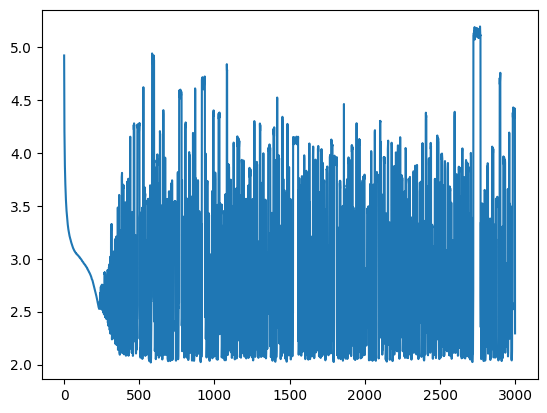

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(Js);

The objective functional decreases almost monotonically for the first 200 steps or so; the chain is effectively doing deterministic gradient descent towards a more probable region of parameter space.
This phenomenon is referred to as the *burn-in*.
It's common to discard all of the samples from the burn-in phase.
From here on out we'll forget these iterations entirely.

In [20]:
num_burn_steps = 200
qs = qs[num_burn_steps:]

We could have avoided this ad-hoc, manual step by taking a few iterations of an optimization procedure to approximate the maximizer of the posterior distribution and starting the Markov chain from there.

The trace plot we showed above helps us diagnose where burn-in occurs, but doesn't give a very good idea of the distribution of $J$ values.
For that we can make a histogram.

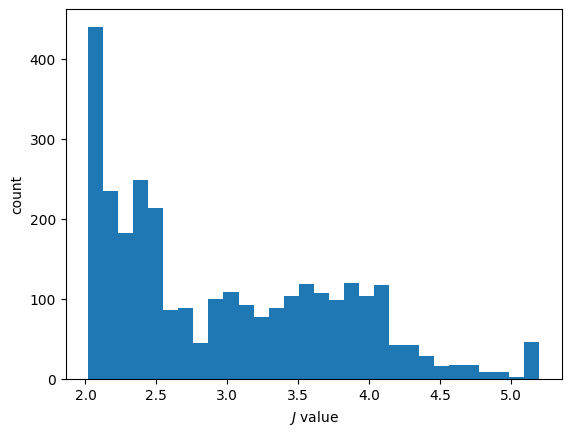

In [21]:
fig, axes = plt.subplots()
axes.hist(Js, 30)
axes.set_xlabel('$J$ value')
axes.set_ylabel('count');

The histogram shows some signs of bimodality, which is definitely worth investigating.
There might be a local maximum of the probability distribution separate from the true mode.

Having tossed the initial deterministic junk, we can take a guess at what the posterior mean of the distribution is.

In [22]:
q_avg = firedrake.Function(Q)
q_avg.dat.data[:] = np.mean(
    np.array([q.dat.data_ro[:] for q in qs]), axis=0
)

Note how similar this looks to the maximum a posteriori estimate that we obtained in the previous demo.

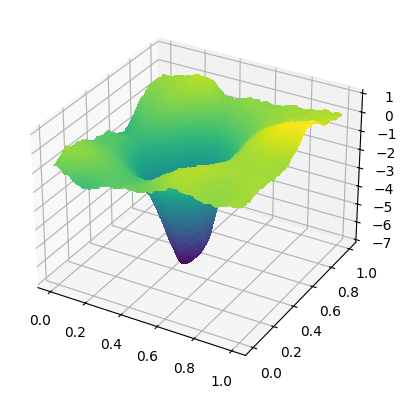

In [23]:
firedrake.trisurf(q_avg);

### Sample size

After we've discarded the samples from the burn-in phase, the successive states of the Markov chain are still correlated and this begs the question of how many independent samples we actually obtained.
Assessing the *effective sample size* turns out to be surprisingly subtle.
The idealized, mathematical definition of the effective sample size, assuming that we could calculate the correlations exactly, is

$$N_{\text{eff}} = \frac{N}{1 + 2\sum_{k = 1}^\infty r_k}$$

where $r_k$ is the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) at lag $k$.
Let's suppose for now that we're only interested in calculating the effective number of samples of the negative log-posterior $J$.
This is a scalar quantity so it's much cheaper to compute on, which is good because our first few attempts are going to go down in flames.
The autocorrelation is defined as

$$r_k = \langle (J(q_{i + k}) - \mu)(J(q_i) - \mu)\rangle / \sigma^2$$

where $\mu$ and $\sigma$ are the mean and standard deviation of $J$.
We could try to approximate the autocorrelation from the samples themselves.

In [24]:
Js = Js[num_burn_steps:]
J_avg = np.mean(Js)
J_std = np.sqrt(np.mean((Js - J_avg)**2))
print(f'Mean, standard deviation of J: {J_avg:5.3f}, {J_std:5.3f}')

autocorr = np.zeros_like(Js)
autocorr[0] = 1.0
for k in range(1, len(Js)):
    autocorr[k] = np.mean(
        (Js[:-k] - J_avg) * (Js[k:] - J_avg)
    ) / J_std**2

Mean, standard deviation of J: 2.975, 0.822


The empirical autocorrelation goes totally bonkers at large lags because there aren't enough samples spaced that far apart to adequately estimate the value of the autocorrelation function.

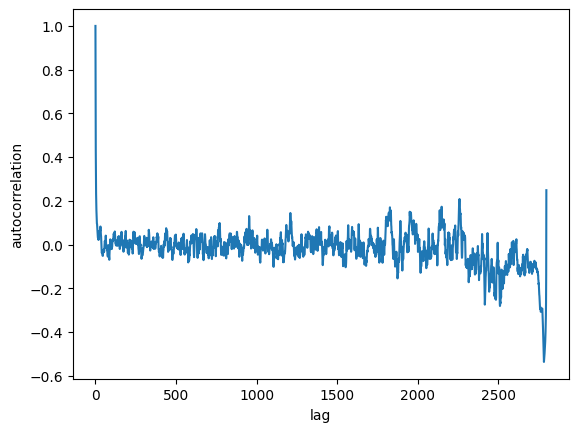

In [25]:
fig, axes = plt.subplots()
axes.plot(autocorr)
axes.set_ylabel('autocorrelation')
axes.set_xlabel('lag');

Just to really drive home how nonsensical this is, let's calculate the denominator in the expression for the effective sample size.

In [26]:
1 + 2 * np.sum(autocorr[1:])

np.float64(-106.3147708709179)

wat.

We could try an alternative formula instead that weights every autocorrelation value by $1 / N$.
This weighting is guaranteed to produce a positive-definite autocorrelation function (see this [SO answer](https://stats.stackexchange.com/a/294410)), unlike the form I used above.
Feels a little ad-hoc to me but ok?

In [27]:
autocorr = np.zeros_like(Js)
autocorr[0] = 1.0
N = len(Js)
for k in range(1, N):
    autocorr[k] = np.sum(
        (Js[:-k] - J_avg) * (Js[k:] - J_avg)
    ) / J_std**2 / N

Slightly less horrific-looking.

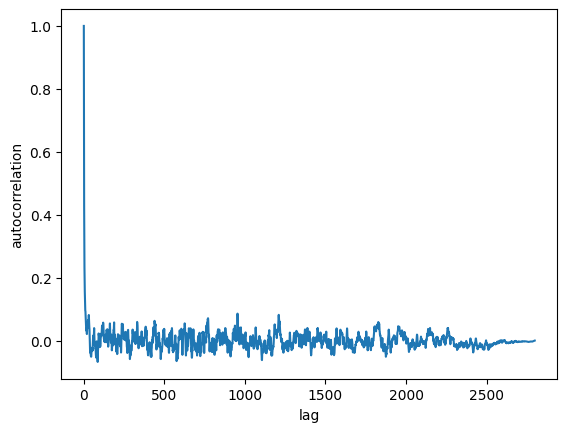

In [28]:
fig, axes = plt.subplots()
axes.plot(autocorr)
axes.set_xlabel('lag')
axes.set_ylabel('autocorrelation');

Now let's see what the correlation time is.

In [29]:
1 + 2 * np.sum(autocorr[1:])

np.float64(-8.881784197001252e-16)

This would imply that we have a few quadrillion independent samples which, again, I find to be highly suspect.

I hope by this point you're convinced that estimating the effective sample size from the samples themselves is very not trivial.
I'll refer you to a great paper called [A Comparison of Methods for Computing Autocorrelation Time](https://arxiv.org/abs/1011.0175) by Madeleine Thompson.
One of the methods she tested is to use *batch means* and this is what we'll use below.
The idea of batch means is to divide the $n$ samples into $m$ batches, and to compare the overall sample variance with the variance of the batch means.
For the method to converge, the number of batches and the size of each batch has to go to infinity.
A common choice is to take $m = \sqrt{n}$, or some other power.

In [30]:
batch_size = int(np.sqrt(N / 2))
num_batches = int(N / batch_size)
batch_means = np.zeros(num_batches)
for index in range(num_batches):
    batch_means[index] = np.mean(
        Js[index * batch_size: (index + 1) * batch_size]
    )
    
batch_std = np.sqrt(np.mean((batch_means - J_avg)**2))
correlation_time = batch_size * batch_std / J_std

print(f"""
    batch size:     {batch_size}
    total std dev:  {J_std:5.3f}
    batch std dev:  {batch_std:5.3f}
    corr time:      {correlation_time:5.3f}
""")


    batch size:     37
    total std dev:  0.822
    batch std dev:  0.319
    corr time:      14.341



This suggests that about one out of every 12 Monte Carlo samples is effectively independent, which is pretty good.
We might be able to improve this further by tuning the stepsize or by using a better choice of preconditioner $M$.

There are other ways to estimate effective sample size and the Thompson paper I linked above does a nice comparison of them on several example problems.
Nonetheless, I'm surprised to have found only one paper that compared them.
It's been cited about 50 times but never published in a peer-reviewed journal.
I'm also surprised to have come across so many papers that don't report how they computed the effective sample size or even what it was for their simulation.

A few other subtle points are worth mentioning here too.
The effective sample size can differ depending on exactly what quantity you're measuring.
For example, let's see what the effective sample size is for the cosine of the angle between the estimated parameter and the true value.

In [31]:
from firedrake import norm
def angle(p, q):
    cos_θ = float(assemble(p * q * dx) / (norm(p) * norm(q)))
    return np.arccos(cos_θ)

angles = np.array([angle(q, q_true) for q in qs])
angles_avg = np.mean(angles)
angles_std = np.sqrt(np.mean((angles - angles_avg)**2))
print(f'Mean, stddev of ∠(q, q_true): {angles_avg:5.3f}, {angles_std:5.3f}')

Mean, stddev of ∠(q, q_true): 0.488, 0.044


In [32]:
batch_means = np.zeros(num_batches)
for index in range(num_batches):
    batch_means[index] = np.mean(
        angles[index * batch_size: (index + 1) * batch_size]
    )
    
batch_std = np.sqrt(np.mean((batch_means - angles_avg)**2))
correlation_time = batch_size * batch_std / angles_std

print(f"""
    batch size:     {batch_size}
    total std dev:  {angles_std:5.3f}
    batch std dev:  {batch_std:5.3f}
    corr time:      {correlation_time:5.3f}
""")


    batch size:     37
    total std dev:  0.044
    batch std dev:  0.013
    corr time:      11.108



We have just a bit more effective samples of the angle between $q$ and the true value as we do of $J(q)$.

A second and perhaps more surprising fact is that, if the autocorrelation function really is negative, you can have more effective samples than total samples.
It's possible to specially design the proposal distribution to make the autocorrelation function at odd lags negative; this is the idea behind [antithetic updates](https://doi.org/10.1007/978-1-4612-2920-9_10).
There's a nice discussion of the unintuitive behaviors of effective sample size [here](https://golem.ph.utexas.edu/category/2014/12/effective_sample_size.html).

### Reflection

I've worked on inverse problems for several years from a purely optimization point of view.
I knew about Monte Carlo approaches, but I'd written them off for a while because I had the impression that they scale very badly to high dimensions.
So I was very happy to hear about approaches like MALA or Hamiltonian Monte Carlo that overcome the dimensionality curse.
I'd spent a lot of time beating my head against the wall trying (and failing) to implement more robust optimization algorithms and preconditioners to solve an inverse problem that doesn't even have a unique solution.
So I find it more appealing on a philosophical level to confront the possible non-uniqueness head-on by sampling directly from the posterior distribution.
This isn't to say that MCMC sampling is a cakewalk.
Here I touched on how estimating the effective sample size is a poorly-documented but necessary part of the workflow.
Things get worse when you consider the likelihood of sampling distinct regions of parameter space that are separated by a large potential barrier.
Even with these faults, I find the sampling approach to be a big improvement both in implementation feasibility and in what you can learn from the results over the optimization approach.